## Configure

In [3]:
source('../../gitProjectExtras/gitBasedProjects/R/sourceAllLibs.r')
sourceAllLibs('../../gitProjectExtras/gitBasedProjects/R/', trace = FALSE)
sourceAllLibs('../../rasterextrafuns/rasterPlotFunctions/R/', trace = FALSE)
sourceAllLibs('../../rasterextrafuns/rasterExtras/R/', trace = FALSE)

library(raster)
#library(rasterExtras)
library(fields)
sourceAllLibs("../libs/", trace = FALSE)
graphics.off()



### parameters

In [29]:
vars = c("fpc", "height", "gdd")

xlims = list(c(0, 1), c(0, 120), c(0, 10000))

transs  = list(logit, function(x, ...) logit(x/120, ...), log)
itranss = list(logistic, function(x, ...) 120 * logistic(x, ...), exp)

logisticit <- function(x, a) logistic(a*logit(x))

logisticitN <- function(x, ...)
    (logisticit(x, ...) - logisticit(0, ...))/(logisticit(1, ...) - logisticit(0, ...))

ptranss = list(function(x) logisticitN(x, 0.1) , function(x) (x/120)^0.2, function(x) 1-exp(-x*0.0001))
pitranss = list(function(x) logisticitN(x, 10), function(x) (x^5)*120, function(x) -10000*log(1-x))


ForestCentres = list(CNRM   = list(c(-70, -0), c(-53, -08), c(-60, -10), c(-67, -14)),
                     ENS    = list(c(-72, -1), c(-54, -09), c(-61, -09), c(-66, -14)),
                     FGOALs = list(c(-70, -0), c(-55, -08), c(-60, -10), c(-67, -14)),
                     HADGEM = list(c(-70, -0), c(-52, -06), c(-67, -10)),
                     MIROC  = list(c(-75, -2), c(-51, -05), c(-61, -08), c(-66, -13)))
                
dir = '../outputs/'
                
speciesDist = "../outputs/bcObs-den/all.Rd"

In [30]:
findBioclimPnts <- function(dat, ForestCentre) {
    findPnt <- function(pnt)  
        dat[cellFromXY(dat, pnt)]
    
    sapply(ForestCentre, findPnt)    
}

In [31]:
testWhereInSphere <- function(bcranges, dats, transs) {
    shift = sapply(bcranges, mean)
    scale = sapply(bcranges, diff)/2
    
    siftScar <- function(sh, sc, dat, trans)
        ((trans(dat)) - sh)/sc
    sdats = mapply(siftScar, shift, scale, dats, transs)
    
    if (!is.raster(dats[[1]])) return(sdats)
    out = sqrt(sum(layer.apply(sdats, function(i) i^2)))<1
    out[out == 0] = NaN
    
    return(out)                              
}  

In [32]:
testNiche <- function(bcranges, ForestCentre, ...) {
    inSphere = testWhereInSphere(bcranges, ...)
    
    if (is.na(mean(inSphere[], na.rm = TRUE))) {
        print("broke")
        return(c(0))
    }
    pol = rasterToPolygons(inSphere, digits = 2, dissolve = TRUE)

     
    ps = lapply(pol@polygons , slot , "Polygons")[[1]]
    coords = lapply(ps, function(x) slot(x, "coords"))

    findPntInPol <- function(pnt){
        for (i in 1:length(coords)) {
            test = point.in.polygon(pnt[1], pnt[2], coords[[i]][,1], coords[[i]][,2])
            if (test) break
        }
        if (test) return(i) else return(NaN)
    }
    
    Cpols = sapply(ForestCentre, findPntInPol)
    if (all(is.na(Cpols))) out = 1 else if (any(is.na(Cpols)))  browser() else if (var(Cpols) > 0) out = 3 else out = 4
    return(c(out))
} 

In [33]:
randomBCrange <- function(i, continent_range, inRange = TRUE,  id = NULL) {    
    if (is.null(id))
        mu = sample(continent_range[,i], 1)
    else
        mu = continent_range[id, i]
    
    sd = runif(1, 0, 1)
    bcrange = mu + c(-1, 1) * logit(sd)
    bcrange = sort(bcrange)
    
    bcrange
}


selectPossibleNiche <- function(tcen) {
    dis = 2 
    id = sample(1:nrow(tcen), 1)
    p = sds = 0
    while( max(dis) > 1) {
        p = p + 1
        bcranges = lapply(1:3, randomBCrange, continent_range = tcen, id = id)
        dis = testWhereInSphere(bcranges, dats = matrix2list(tcen), list(blankFun))
        dis = apply(dis, 1, function(i) sqrt(sum(i^2)))                    
    }
    print(p)
    print(dis)
    
    return(bcranges)
}


In [34]:
load(speciesDist)
lims = lims[-1,] - diff(lims)/2
tlims = cbind(rep(lims[,1], each = nrow(lims)^2), 
              rep(lims[,2], each = nrow(lims)), 
              lims[,3])

pMat = array(0, dim = dim(specDmat[[1]])) 

pMatFind <- function(info) {
    dis = testWhereInSphere(info, matrix2list(tlims), transs)
    pMat[] = apply(dis, 1, function(i) sqrt(sum(i^2)))<1
    return(pMat)
}

In [40]:
grab_cache = T
nboots = 1000
testRandomNiche <- function(ntest, model, experiment, ForestCentre, tcen) {
    tfile = paste0("../temp/randomNicheTest--gdd-2", model, '-', experiment, '-', ntest, ".Rd")
    print(tfile)
    
    #print(file.exists(tfile))
    if (file.exists(tfile) && grab_cache) 
        load(tfile)
    else {        
        bcranges = selectPossibleNiche(tcen)#lapply(1:3, randomBCrange, id = id)
        
        test = testNiche(bcranges, ForestCentre, dats, transs)
        pMatout = pMatFind(bcranges)
        
        save(bcranges, test, pMatout, file = tfile)
    }
    print(test)
    return(list(bcranges, test, pMatout))
}
runNicheBoots <- function(...)
    out = lapply(1:nboots, testRandomNiche, ...)


In [41]:
run4model <- function(model, ForestCentre) {
    experiments = list.files(paste0(dir, model, '/'))
    run4Exp <- function(experiment) {
        print(model)
        print(experiment)
        dats = suppressWarnings(lapply(vars, function(i) raster(paste0(dir, '/', model, '/', experiment, '/', i, '.nc'))))
        dats <<- dats
        
        centres = lapply(dats, findBioclimPnts, ForestCentre)
        
        tcen = mapply(function(F,i) F(i), transs, centres)
        
        out = runNicheBoots(model, experiment, ForestCentre = ForestCentre, tcen = tcen)
        return(list(out, centres))
        
    }
    
    lapply(experiments, run4Exp)
}

In [42]:
models = list.files(dir)
models = models[!grepl("bcObs-den", models)]
model = models[1]


ForestCentre = ForestCentres[[1]]


experiments = list.files(paste0(dir, model, '/'))
experiment = experiments[1]
outss = mapply(run4model, models, ForestCentres, SIMPLIFY = FALSE)

[1] "CNRM"
[1] "corrected"
[1] "../temp/randomNicheTest--gdd-2CNRM-corrected-1.Rd"
[1] 109
                                                    
7.412084e-01 2.667361e-01 6.278107e-17 7.888103e-01 
[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-corrected-2.Rd"
[1] 3424
                                                    
2.170566e-16 9.699935e-01 8.648757e-01 4.349103e-01 
[1] 3
[1] "../temp/randomNicheTest--gdd-2CNRM-corrected-3.Rd"
[1] 1803
                                        
0.9271788 0.2599415 0.0000000 0.7833143 
[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-corrected-4.Rd"
[1] 2558
                                                    
3.735104e-01 9.203917e-01 7.123605e-01 7.412867e-17 
[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-corrected-5.Rd"
[1] 7595
                                                    
2.003402e-16 8.888126e-01 7.862847e-01 3.898921e-01 
[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-corrected-6.Rd"
[1] 5670
                                        
0.96108

Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-2.Rd"
[1] 108
                                                    
5.984175e-01 9.702735e-02 8.948012e-17 7.750184e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-3.Rd"
[1] 1956
                                                    
8.436646e-01 1.192285e-01 8.604062e-17 9.304469e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-4.Rd"
[1] 507
                                                    
2.238188e-01 9.279960e-01 8.959251e-01 1.518315e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-5.Rd"
[1] 947
                                                    
1.744488e-01 7.238952e-01 6.987232e-01 1.230567e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-6.Rd"
[1] 3013
                                                    
7.529025e-01 1.078033e-16 5.336044e-02 9.675126e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-7.Rd"
[1] 363
                                        
0.0000000 0.5955973 0.5954424 0.2004073 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-8.Rd"
[1] 334
                                                    
6.092487e-01 4.539655e-02 1.370914e-16 8.090917e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-9.Rd"
[1] 1178
                                                    
6.227476e-01 9.210366e-17 1.324028e-01 8.156981e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-10.Rd"
[1] 630
                                                    
1.331225e-16 9.979972e-01 9.544103e-01 3.183705e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-11.Rd"
[1] 2951
                                                    
6.494601e-01 3.479918e-02 1.267227e-16 8.651050e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-12.Rd"
[1] 1002
                                                    
6.816842e-01 3.663584e-02 1.063284e-16 9.041701e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-13.Rd"
[1] 321
                                                    
7.154148e-17 9.169854e-01 8.780016e-01 2.941029e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-14.Rd"
[1] 485
                                                    
1.279468e-16 8.799747e-01 8.411571e-01 2.802438e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-15.Rd"
[1] 480
                                                    
2.101403e-01 8.648361e-01 8.368708e-01 6.203902e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-16.Rd"
[1] 1881
                                                    
7.346326e-01 9.574368e-17 6.485422e-02 9.032844e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-17.Rd"
[1] 262
                                                    
6.988563e-01 4.743787e-02 1.075131e-16 9.200621e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-18.Rd"
[1] 1879
                                                    
7.502395e-01 1.124553e-16 3.697343e-02 9.865268e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-19.Rd"
[1] 2305
                                        
0.2040656 0.8811738 0.8410355 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-20.Rd"
[1] 2294
                                                    
7.374453e-01 7.734418e-02 1.152962e-16 9.788099e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-21.Rd"
[1] 98
                                                    
6.062697e-01 1.044354e-01 1.220795e-16 8.023534e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-22.Rd"
[1] 277
                                                    
6.766595e-01 5.450450e-02 1.051651e-16 8.955554e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-23.Rd"
[1] 990
                                                    
1.799419e-01 7.404902e-01 7.163227e-01 6.427724e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-24.Rd"
[1] 679
                                                    
6.604452e-01 9.250347e-17 8.204801e-02 8.402435e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-25.Rd"
[1] 1070
                                                    
6.546281e-01 9.348478e-17 4.766696e-02 8.401452e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-26.Rd"
[1] 145
                                                    
7.225347e-01 1.257050e-16 1.858828e-01 9.561888e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-27.Rd"
[1] 1131
                                            
0.73048558 0.07077399 0.00000000 0.96222724 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-28.Rd"
[1] 6418
                                                    
2.022378e-01 8.333181e-01 8.061850e-01 7.246008e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-29.Rd"
[1] 233
                                                    
3.103499e-16 9.423313e-01 8.925861e-01 2.877284e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-30.Rd"
[1] 748
                                                    
7.120398e-17 9.214466e-01 8.823008e-01 2.955571e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-31.Rd"
[1] 133
                                                    
7.374176e-01 1.111750e-16 3.522631e-02 9.725762e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-32.Rd"
[1] 329
                                                    
7.394188e-01 5.002769e-02 1.116964e-16 9.642081e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-33.Rd"
[1] 66
                                                    
7.363468e-01 1.087349e-16 1.180091e-01 9.624134e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-34.Rd"
[1] 1245
                                                    
6.890046e-01 8.906090e-02 1.072610e-16 9.120495e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-35.Rd"
[1] 37
                                                    
2.272734e-01 9.394650e-01 9.079888e-01 1.216418e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-36.Rd"
[1] 3387
                                        
0.2191980 0.9173991 0.8834450 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-37.Rd"
[1] 1633
                                                    
7.166279e-17 8.603167e-01 8.243893e-01 2.761484e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-38.Rd"
[1] 1008
                                            
0.76490530 0.00000000 0.04419105 0.99549055 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-39.Rd"
[1] 117
                                        
0.0000000 0.8786837 0.8183626 0.2464986 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-40.Rd"
[1] 144
                                                    
2.283365e-01 9.387979e-01 9.085274e-01 5.870689e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-41.Rd"
[1] 1124
                                                    
7.998219e-01 1.041729e-01 9.944465e-17 9.506443e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-42.Rd"
[1] 1201
                                                    
7.298082e-01 5.034916e-02 1.552331e-16 9.703796e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-43.Rd"
[1] 1777
                                                    
7.044407e-01 5.877349e-02 1.035770e-16 9.058126e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-44.Rd"
[1] 2489
                                                    
7.288993e-01 1.025677e-16 5.404662e-02 9.287460e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-45.Rd"
[1] 5454
                                                    
2.313725e-01 9.531392e-01 9.221249e-01 8.126994e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-46.Rd"
[1] 4744
                                                    
6.983249e-01 5.365358e-02 1.033935e-16 9.011901e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-47.Rd"
[1] 2632
                                                    
6.748158e-01 1.118055e-16 3.674778e-02 8.908123e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-48.Rd"
[1] 593
                                                    
5.181979e-17 9.979086e-01 9.557795e-01 3.205338e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-49.Rd"
[1] 563
                                                    
7.124544e-01 3.994452e-02 1.103894e-16 9.416120e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-50.Rd"
[1] 1742
                                                    
6.529665e-01 5.739983e-02 1.027790e-16 8.700294e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-51.Rd"
[1] 1281
                                                    
6.135230e-01 9.063954e-17 3.693692e-02 8.008285e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-52.Rd"
[1] 448
                                                    
7.470022e-01 1.099042e-16 1.270843e-01 9.747450e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-53.Rd"
[1] 20
                                        
0.0000000 0.8592499 0.8414200 0.2818689 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-54.Rd"
[1] 64
                                        
0.0000000 0.7587807 0.7159140 0.2271658 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-55.Rd"
[1] 1621
                                            
0.73079034 0.03877016 0.00000000 0.97183879 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-56.Rd"
[1] 970
                                        
0.2060917 0.8916817 0.8504172 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-57.Rd"
[1] 9263
                                                    
2.208092e-01 9.132207e-01 8.825154e-01 1.224560e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-58.Rd"
[1] 3076
                                                    
2.226034e-01 9.220982e-01 8.906680e-01 1.382884e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-59.Rd"
[1] 1737
                                        
0.2183393 0.9445554 0.9009780 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-60.Rd"
[1] 161
                                        
0.0000000 0.7991514 0.7598424 0.2484845 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-61.Rd"
[1] 8
                                        
0.0000000 0.7470686 0.7130583 0.2363395 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-62.Rd"
[1] 4348
                                        
0.2357337 0.9753663 0.9423966 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-63.Rd"
[1] 382
                                                    
7.149659e-01 6.843960e-02 1.108746e-16 9.449693e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-64.Rd"
[1] 1598
                                                    
7.677328e-01 6.511858e-02 1.127602e-16 9.866371e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-65.Rd"
[1] 1603
                                                    
2.281966e-01 9.379886e-01 9.067816e-01 1.030510e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-66.Rd"
[1] 5337
                                                    
2.286527e-01 9.473755e-01 9.150218e-01 1.440902e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-67.Rd"
[1] 276
                                                    
8.969823e-17 8.090346e-01 7.740941e-01 2.587219e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-68.Rd"
[1] 158
                                        
0.0000000 0.9957203 0.9487633 0.3124127 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-69.Rd"
[1] 44
                                                    
2.280515e-01 9.421504e-01 9.107036e-01 1.171580e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-70.Rd"
[1] 5456
                                                    
6.735379e-01 4.089407e-02 1.053852e-16 8.948063e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-71.Rd"
[1] 1374
                                                    
6.452107e-01 3.435660e-02 1.006391e-16 8.557948e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-72.Rd"
[1] 28
                                                    
7.675827e-01 7.059791e-02 1.082535e-16 9.667229e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-73.Rd"
[1] 2290
                                            
0.74276606 0.04979359 0.00000000 0.98473692 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-74.Rd"
[1] 1270
                                                    
5.487677e-01 4.046714e-02 8.628113e-17 7.308658e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-75.Rd"
[1] 1735
                                        
0.1815823 0.7546923 0.7282642 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-76.Rd"
[1] 103
                                        
0.0000000 0.9118580 0.8994987 0.3032182 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-77.Rd"
[1] 1273
                                                    
5.726822e-01 8.261976e-17 3.589204e-02 7.386269e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-78.Rd"
[1] 227
                                                    
6.879191e-01 1.239202e-16 3.680000e-02 9.069128e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-79.Rd"
[1] 19
                                                    
1.095762e-16 9.982843e-01 9.552888e-01 3.193211e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-80.Rd"
[1] 3046
                                                    
6.685118e-01 9.962847e-17 5.105886e-02 8.766512e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-81.Rd"
[1] 1703
                                                    
7.512739e-01 6.922162e-02 1.149423e-16 9.859337e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-82.Rd"
[1] 531
                                            
0.78229794 0.06539635 0.00000000 0.99897529 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-83.Rd"
[1] 1717
                                                    
1.962982e-01 8.084954e-01 7.819318e-01 7.975214e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-84.Rd"
[1] 171
                                                    
8.800070e-17 9.818036e-01 9.417729e-01 3.154771e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-85.Rd"
[1] 284
                                                    
2.264994e-01 9.272060e-01 8.971342e-01 5.284270e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-86.Rd"
[1] 68
                                        
0.0000000 0.9362239 0.8776753 0.2715955 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-87.Rd"
[1] 351
                                        
0.0000000 0.8023232 0.7626805 0.2490715 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-88.Rd"
[1] 3392
                                                    
1.884833e-01 7.703451e-01 7.447359e-01 7.301493e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-89.Rd"
[1] 2239
                                            
0.74885589 0.00000000 0.04111725 0.98012062 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-90.Rd"
[1] 4314
                                                    
7.000909e-01 1.039821e-16 4.027334e-02 9.163048e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-91.Rd"
[1] 201
                                                    
1.136402e-16 9.138259e-01 8.765010e-01 2.929173e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-92.Rd"
[1] 425
                                                    
6.121255e-01 9.085777e-17 3.162996e-02 8.008690e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-93.Rd"
[1] 393
                                            
0.75241359 0.00000000 0.03722611 0.98833233 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-94.Rd"
[1] 54
                                        
0.0000000 0.9615647 0.9149906 0.2999331 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-95.Rd"
[1] 1174
                                                    
7.042419e-01 1.009508e-16 1.253325e-01 9.072390e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-96.Rd"
[1] 1087
                                            
0.72177745 0.05667977 0.00000000 0.95088599 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-97.Rd"
[1] 449
                                                    
2.030694e-01 8.347248e-01 8.076865e-01 5.897964e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-98.Rd"
[1] 480
                                                    
7.479748e-01 5.731453e-02 1.109979e-16 9.663900e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-99.Rd"
[1] 827
                                                    
7.333388e-01 1.482924e-16 3.748944e-02 9.646294e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-100.Rd"
[1] 249
                                                    
6.102771e-17 8.939179e-01 8.560164e-01 2.868798e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-101.Rd"
[1] 2164
                                                    
7.186958e-01 1.051568e-16 4.316740e-02 9.335154e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-102.Rd"
[1] 586
                                                    
1.515922e-16 9.646989e-01 9.243229e-01 3.078751e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-103.Rd"
[1] 134
                                                    
7.172292e-01 6.025841e-02 1.032441e-16 9.125121e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-104.Rd"
[1] 1464
                                                    
6.336393e-01 9.435607e-17 4.468149e-02 8.305302e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-105.Rd"
[1] 249
                                                    
3.187460e-16 8.910399e-01 8.421517e-01 2.693306e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-106.Rd"
[1] 243
                                                    
6.569969e-01 1.166190e-16 2.909743e-02 8.677977e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-107.Rd"
[1] 1881
                                                    
2.282899e-01 9.443523e-01 9.124895e-01 1.302661e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-108.Rd"
[1] 197
                                                    
2.171089e-01 9.047730e-01 8.723667e-01 1.795788e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-109.Rd"
[1] 698
                                                    
2.199780e-01 9.061150e-01 8.766960e-01 7.385334e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-110.Rd"
[1] 5899
                                                    
2.324480e-01 9.559192e-01 9.246545e-01 8.420641e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-111.Rd"
[1] 2078
                                                    
5.987340e-01 5.300736e-02 9.317858e-17 7.929126e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-112.Rd"
[1] 62
                                                    
6.178338e-17 9.427617e-01 9.028448e-01 3.026151e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-113.Rd"
[1] 20
                                                    
8.175200e-17 7.613246e-01 7.286355e-01 2.436108e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-114.Rd"
[1] 1693
                                                    
7.344123e-01 3.869170e-02 1.145749e-16 9.742152e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-115.Rd"
[1] 69
                                                    
1.019250e-16 9.718682e-01 9.415542e-01 3.162327e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-116.Rd"
[1] 1167
                                                    
6.420514e-01 4.405091e-02 9.928087e-17 8.475642e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-117.Rd"
[1] 657
                                                    
1.089935e-16 8.616720e-01 8.241027e-01 2.750678e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-118.Rd"
[1] 820
                                        
0.0000000 0.9956169 0.9525524 0.3183129 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-119.Rd"
[1] 269
                                                    
2.407177e-01 9.932792e-01 9.604902e-01 1.083722e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-120.Rd"
[1] 160
                                                    
1.187216e-16 9.427879e-01 9.021185e-01 3.011754e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-121.Rd"
[1] 1322
                                        
0.2202547 0.9263186 0.8907399 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-122.Rd"
[1] 19
                                                    
8.177008e-01 1.038719e-16 7.383729e-02 9.941333e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-123.Rd"
[1] 1409
                                                    
6.967123e-01 1.004858e-16 5.199229e-02 8.985804e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-124.Rd"
[1] 828
                                                    
7.720612e-01 1.083102e-16 5.429763e-02 9.822455e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-125.Rd"
[1] 1652
                                        
0.2325041 0.9638587 0.9307822 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-126.Rd"
[1] 472
                                                    
6.719903e-01 4.985108e-02 9.990474e-17 8.690534e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-127.Rd"
[1] 3112
                                        
0.2477391 0.9674980 0.9286994 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-128.Rd"
[1] 854
                                                    
9.995694e-17 9.776005e-01 9.355641e-01 3.128942e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-129.Rd"
[1] 1511
                                                    
2.005071e-01 8.238278e-01 7.968493e-01 7.202796e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-130.Rd"
[1] 1532
                                        
0.0000000 0.8763327 0.8385312 0.2795513 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-131.Rd"
[1] 238
                                        
0.0000000 0.9821978 0.9396977 0.3135645 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-132.Rd"
[1] 324
                                                    
6.716494e-01 3.474083e-02 1.057482e-16 8.953640e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-133.Rd"
[1] 2189
                                                    
6.920704e-01 5.754573e-02 1.035355e-16 8.978047e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-134.Rd"
[1] 357
                                                    
2.372955e-01 9.801581e-01 9.475158e-01 1.191181e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-135.Rd"
[1] 193
                                                    
5.744054e-01 8.255628e-17 3.693477e-02 7.394704e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-136.Rd"
[1] 2483
                                                    
6.860540e-01 1.016463e-16 1.602545e-01 9.000150e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-137.Rd"
[1] 3244
                                        
0.2059586 0.8538327 0.8245484 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-138.Rd"
[1] 3873
                                                    
1.762249e-01 7.270468e-01 7.025882e-01 9.454373e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-139.Rd"
[1] 340
                                                    
7.615266e-01 5.227519e-02 1.146439e-16 9.912717e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-140.Rd"
[1] 241
                                                    
4.283050e-17 9.057187e-01 8.754236e-01 2.945723e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-141.Rd"
[1] 692
                                                    
2.144359e-01 8.823205e-01 8.538095e-01 6.149030e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-142.Rd"
[1] 5141
                                                    
2.236179e-01 9.208632e-01 8.907802e-01 8.304763e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-143.Rd"
[1] 102
                                                    
5.808632e-17 9.760751e-01 9.347539e-01 3.133855e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-144.Rd"
[1] 2640
                                                    
2.149816e-01 9.121998e-01 8.748450e-01 2.724815e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-145.Rd"
[1] 3829
                                                    
7.397220e-01 1.089076e-16 4.124259e-02 9.638247e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-146.Rd"
[1] 24
                                                    
1.668725e-16 9.898645e-01 9.455164e-01 3.141910e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-147.Rd"
[1] 3126
                                                    
7.460428e-01 6.323490e-17 4.546166e-02 9.842345e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-148.Rd"
[1] 3011
                                        
0.2152561 0.8935357 0.8621789 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-149.Rd"
[1] 308
                                                    
2.290940e-16 8.441838e-01 8.044834e-01 2.631399e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-150.Rd"
[1] 3436
                                        
0.2251099 0.9456281 0.9088523 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-151.Rd"
[1] 920
                                                    
6.780663e-01 9.826389e-17 4.221970e-02 8.765113e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-152.Rd"
[1] 2960
                                                    
5.740413e-01 3.457521e-02 8.839832e-17 7.561852e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-153.Rd"
[1] 511
                                                    
7.582593e-01 8.570132e-02 1.161294e-16 9.953325e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-154.Rd"
[1] 132
                                                    
6.988503e-01 5.010782e-02 1.099999e-16 9.313255e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-155.Rd"
[1] 1085
                                                    
3.311662e-16 9.897147e-01 9.372553e-01 3.017273e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-156.Rd"
[1] 220
                                                    
8.191770e-17 9.814748e-01 9.396007e-01 3.146313e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-157.Rd"
[1] 6695
                                                    
6.679835e-01 6.332990e-02 9.301804e-17 8.361165e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-158.Rd"
[1] 3662
                                                    
7.408952e-01 1.066424e-16 4.747247e-02 9.545026e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-159.Rd"
[1] 108
                                                    
7.675544e-01 8.816539e-17 8.570429e-02 8.957184e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-160.Rd"
[1] 1407
                                                    
7.026324e-01 1.010608e-16 4.961316e-02 9.049357e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-161.Rd"
[1] 813
                                                    
2.087833e-16 9.779527e-01 9.324292e-01 3.078991e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-162.Rd"
[1] 1100
                                                    
7.003905e-01 1.018854e-16 4.418999e-02 9.071037e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-163.Rd"
[1] 618
                                                    
6.025654e-01 3.039940e-02 9.509896e-17 8.043174e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-164.Rd"
[1] 1271
                                                    
1.915140e-01 7.887902e-01 7.631733e-01 6.440396e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-165.Rd"
[1] 1210
                                                    
6.334428e-01 9.282229e-17 9.304509e-02 8.244545e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-166.Rd"
[1] 157
                                        
0.2371568 0.9810850 0.9478757 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-167.Rd"
[1] 1724
                                                    
6.614770e-01 6.550958e-02 9.020935e-17 8.197755e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-168.Rd"
[1] 2497
                                                    
2.343487e-01 9.651911e-01 9.336916e-01 8.600877e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-169.Rd"
[1] 501
                                                    
7.732316e-01 1.102181e-16 6.058212e-02 9.915166e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-170.Rd"
[1] 302
                                        
0.2081241 0.9195799 0.8708707 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-171.Rd"
[1] 415
                                                    
1.957593e-01 8.220852e-01 7.908741e-01 2.020075e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-172.Rd"
[1] 536
                                                    
2.820541e-16 7.700793e-01 7.281646e-01 2.324173e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-173.Rd"
[1] 424
                                                    
1.013207e-16 6.380900e-01 6.108986e-01 2.033846e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-174.Rd"
[1] 933
                                        
0.1905979 0.8562003 0.8082327 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-175.Rd"
[1] 344
                                                    
1.553820e-16 8.969969e-01 8.575006e-01 2.848860e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-176.Rd"
[1] 401
                                                    
6.458838e-01 9.690325e-17 7.940953e-02 8.504596e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-177.Rd"
[1] 3
                                                    
6.368412e-01 3.555074e-02 1.002529e-16 8.488678e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-178.Rd"
[1] 1601
                                                    
1.868599e-01 7.711226e-01 7.451359e-01 1.020494e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-179.Rd"
[1] 85
                                                    
6.748100e-17 9.420238e-01 9.020113e-01 3.022407e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-180.Rd"
[1] 8
                                                    
8.514355e-17 9.880515e-01 9.471707e-01 3.172742e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-181.Rd"
[1] 1712
                                                    
2.154228e-01 8.869635e-01 8.582599e-01 6.621240e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-182.Rd"
[1] 229
                                                    
7.568519e-01 4.603689e-02 1.169273e-16 9.987047e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-183.Rd"
[1] 2281
                                                    
7.318916e-01 1.358799e-16 4.729112e-01 9.847355e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-184.Rd"
[1] 241
                                                    
7.725298e-17 9.309375e-01 8.914807e-01 2.985571e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-185.Rd"
[1] 3082
                                                    
7.461536e-01 1.030285e-01 1.160767e-16 9.871682e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-186.Rd"
[1] 541
                                                    
6.415656e-01 9.472590e-17 3.911298e-02 8.371827e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-187.Rd"
[1] 911
                                        
0.7198114 0.1639248 0.0000000 0.9483277 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-188.Rd"
[1] 62
                                                    
5.474022e-01 5.127987e-02 8.393910e-17 7.192187e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-189.Rd"
[1] 525
                                                    
7.044171e-01 9.362293e-17 5.847298e-02 8.737901e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-190.Rd"
[1] 680
                                                    
1.161126e-16 6.668340e-01 6.368672e-01 2.114870e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-191.Rd"
[1] 505
                                                    
8.307775e-01 9.697520e-17 1.195960e-01 9.763001e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-192.Rd"
[1] 718
                                                    
2.389971e-01 9.831139e-01 9.514820e-01 5.900877e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-193.Rd"
[1] 4
                                        
0.1844086 0.7790450 0.7478929 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-194.Rd"
[1] 59
                                                    
7.182081e-17 9.791192e-01 9.383394e-01 3.144860e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-195.Rd"
[1] 17
                                                    
5.616746e-01 8.442017e-17 6.388499e-02 7.401530e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-196.Rd"
[1] 1621
                                                    
6.509366e-01 9.564594e-17 4.051759e-02 8.473321e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-197.Rd"
[1] 327
                                                    
1.252150e-16 9.412244e-01 9.149685e-01 3.070437e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-198.Rd"
[1] 28
                                                    
1.081856e-16 9.654321e-01 9.238902e-01 3.087804e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-199.Rd"
[1] 1422
                                                    
5.540070e-01 9.924203e-17 3.433388e-02 7.318064e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-200.Rd"
[1] 324
                                        
0.0000000 0.9108661 0.8502133 0.2583420 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-201.Rd"
[1] 506
                                                    
5.431465e-01 2.950310e-02 8.482002e-17 7.208716e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-202.Rd"
[1] 1692
                                                    
6.675633e-01 4.359314e-02 1.473719e-16 8.871157e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-203.Rd"
[1] 780
                                                    
6.923663e-01 1.355922e-16 3.727882e-02 9.113586e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-204.Rd"
[1] 592
                                        
0.0000000 0.9882983 0.9428699 0.3118100 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-205.Rd"
[1] 71
                                                    
1.084554e-16 9.186461e-01 8.877779e-01 2.976377e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-206.Rd"
[1] 1223
                                        
0.2385213 0.9613730 0.9229464 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-207.Rd"
[1] 85
                                        
0.0000000 0.8954398 0.8493706 0.2753359 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-208.Rd"
[1] 415
                                                    
2.992678e-16 8.817307e-01 8.351866e-01 2.685938e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-209.Rd"
[1] 104
                                                    
1.860264e-16 9.450382e-01 9.017337e-01 2.985179e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-210.Rd"
[1] 526
                                        
0.2131214 0.8854811 0.8544264 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-211.Rd"
[1] 3235
                                                    
7.340326e-01 1.096327e-16 3.948324e-02 9.634609e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-212.Rd"
[1] 107
                                        
0.0000000 0.8672408 0.8213491 0.2630547 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-213.Rd"
[1] 235
                                                    
1.118367e-16 9.820934e-01 9.396816e-01 3.139985e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-214.Rd"
[1] 8389
                                                    
2.232236e-01 9.063086e-01 8.758743e-01 8.267032e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-215.Rd"
[1] 3182
                                                    
2.009162e-01 8.290003e-01 8.013543e-01 1.001759e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-216.Rd"
[1] 434
                                                    
5.917406e-17 6.458325e-01 6.181994e-01 2.069049e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-217.Rd"
[1] 1033
                                                    
6.823387e-01 4.300171e-02 1.045931e-16 8.966453e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-218.Rd"
[1] 2655
                                                    
6.907686e-01 9.548548e-17 3.910571e-01 8.930335e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-219.Rd"
[1] 87
                                                    
7.602109e-01 8.796653e-02 9.423567e-17 9.026954e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-220.Rd"
[1] 2034
                                        
0.3018283 0.9827040 0.9201033 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-221.Rd"
[1] 206
                                        
0.0000000 0.8669776 0.8230406 0.2675651 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-222.Rd"
[1] 281
                                                    
7.604557e-01 1.119361e-16 5.907284e-02 9.909362e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-223.Rd"
[1] 2020
                                        
0.2223831 0.9205124 0.8889464 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-224.Rd"
[1] 546
                                                    
2.723766e-16 9.425048e-01 8.949732e-01 2.913141e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-225.Rd"
[1] 938
                                                    
2.397755e-01 9.959417e-01 9.610591e-01 1.764856e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-226.Rd"
[1] 5
                                                    
2.146874e-01 8.902163e-01 8.592009e-01 1.517996e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-227.Rd"
[1] 447
                                                    
7.138598e-01 3.899140e-02 1.112983e-16 9.466188e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-228.Rd"
[1] 128
                                                    
7.119085e-01 8.864360e-17 6.749520e-02 8.581623e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-229.Rd"
[1] 1887
                                                    
2.140027e-01 8.792734e-01 8.510676e-01 4.158605e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-230.Rd"
[1] 499
                                                    
7.183591e-01 1.063559e-16 4.969777e-02 9.387774e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-231.Rd"
[1] 243
                                        
0.0000000 0.9458896 0.8992101 0.2935600 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-232.Rd"
[1] 929
                                                    
6.822763e-01 9.435764e-17 5.013518e-02 8.621049e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-233.Rd"
[1] 3234
                                                    
2.397546e-01 9.913343e-01 9.580773e-01 1.302097e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-234.Rd"
[1] 440
                                                    
1.047940e-16 9.656080e-01 9.248179e-01 3.092597e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-235.Rd"
[1] 347
                                                    
1.392470e-16 6.751468e-01 6.440095e-01 2.129094e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-236.Rd"
[1] 424
                                                    
7.366896e-01 1.097242e-16 1.420466e-01 9.678701e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-237.Rd"
[1] 4038
                                                    
8.453778e-01 9.607266e-17 9.423793e-02 9.824974e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-238.Rd"
[1] 76
                                                    
1.254569e-16 9.757009e-01 9.331388e-01 3.114062e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-239.Rd"
[1] 1359
                                                    
2.288511e-01 9.419873e-01 9.115673e-01 6.581051e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-240.Rd"
[1] 883
                                                    
5.819813e-01 4.454141e-02 8.657240e-17 7.528487e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-241.Rd"
[1] 1561
                                                    
2.315347e-01 9.537792e-01 9.227185e-01 8.244262e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-242.Rd"
[1] 940
                                                    
6.683270e-01 4.155306e-02 1.040479e-16 8.854971e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-243.Rd"
[1] 90
                                                    
4.016824e-16 8.532322e-01 7.986971e-01 2.453449e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-244.Rd"
[1] 23
                                        
0.0000000 0.8272045 0.7890580 0.2609635 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-245.Rd"
[1] 56
                                        
0.0000000 0.6158177 0.5876152 0.1943411 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-246.Rd"
[1] 84
                                        
0.0000000 0.7928404 0.7462501 0.2333373 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-247.Rd"
[1] 776
                                                    
7.711426e-01 6.780800e-02 1.120973e-16 9.858479e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-248.Rd"
[1] 67
                                                    
7.490820e-01 1.170754e-01 1.137124e-16 9.779135e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-249.Rd"
[1] 1060
                                                    
7.435347e-01 1.002072e-01 1.157794e-16 9.842661e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-250.Rd"
[1] 2010
                                                    
6.705646e-01 3.942836e-02 1.301018e-16 8.931741e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-251.Rd"
[1] 2093
                                            
0.72263331 0.09801382 0.00000000 0.95203149 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-252.Rd"
[1] 385
                                        
0.7381524 0.0578063 0.0000000 0.9840266 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-253.Rd"
[1] 135
                                                    
1.161376e-16 6.977489e-01 6.689987e-01 2.226743e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-254.Rd"
[1] 3082
                                        
0.7470866 0.0000000 0.1009308 0.9860766 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-255.Rd"
[1] 1029
                                                    
2.206018e-01 9.081319e-01 8.786953e-01 6.983962e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-256.Rd"
[1] 473
                                                    
5.853214e-01 8.681285e-17 3.279551e-02 7.655251e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-257.Rd"
[1] 729
                                                    
6.369997e-01 3.637735e-02 1.002439e-16 8.489157e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-258.Rd"
[1] 1453
                                        
0.2132753 0.8976808 0.8630517 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-259.Rd"
[1] 2323
                                                    
6.765172e-01 9.367720e-17 5.052786e-02 8.553457e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-260.Rd"
[1] 9221
                                                    
7.047722e-01 9.788194e-17 5.280974e-02 8.923489e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-261.Rd"
[1] 3311
                                                    
2.354530e-01 9.733550e-01 9.407434e-01 1.261740e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-262.Rd"
[1] 104
                                        
0.2280024 0.9406465 0.9093279 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-263.Rd"
[1] 2131
                                                    
7.730858e-01 1.097242e-16 5.164774e-02 9.891141e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-264.Rd"
[1] 273
                                        
0.0000000 0.9319228 0.8906604 0.2965786 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-265.Rd"
[1] 7205
                                        
0.2125781 0.9014313 0.8646149 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-266.Rd"
[1] 454
                                                    
7.059740e-01 1.031960e-16 4.053723e-02 9.165248e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-267.Rd"
[1] 1542
                                                    
2.424124e-01 9.962345e-01 9.640207e-01 6.631504e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-268.Rd"
[1] 42
                                        
0.0000000 0.8121499 0.7749829 0.2566475 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-269.Rd"
[1] 2511
                                                    
7.738342e-01 1.106174e-16 7.393105e-02 9.938946e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-270.Rd"
[1] 685
                                                    
1.867755e-01 7.732675e-01 7.463528e-01 1.294703e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-271.Rd"
[1] 1671
                                                    
1.988450e-01 8.222887e-01 7.920921e-01 1.702873e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-272.Rd"
[1] 531
                                                    
7.380512e-01 4.148354e-02 8.867042e-17 9.828483e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-273.Rd"
[1] 1120
                                        
0.1758231 0.7455870 0.7151256 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-274.Rd"
[1] 547
                                                    
7.750496e-01 1.063798e-16 1.841526e-01 9.795690e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-275.Rd"
[1] 694
                                        
0.0000000 0.9348763 0.8942390 0.2984851 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-276.Rd"
[1] 343
                                        
0.0000000 0.7634512 0.7121978 0.2155719 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-277.Rd"
[1] 240
                                                    
7.221973e-01 1.075730e-16 6.677223e-02 9.469762e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-278.Rd"
[1] 608
                                                    
7.470877e-01 1.502183e-16 8.120073e-02 9.833011e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-279.Rd"
[1] 113
                                                    
1.033120e-16 7.913334e-01 7.575692e-01 2.528675e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-280.Rd"
[1] 3833
                                                    
7.077540e-01 3.669094e-02 1.107340e-16 9.403060e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-281.Rd"
[1] 82
                                                    
7.435307e-17 8.795248e-01 8.419708e-01 2.819196e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-282.Rd"
[1] 1960
                                                    
7.123365e-01 1.022896e-16 4.717784e-02 9.166510e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-283.Rd"
[1] 2685
                                                    
6.451652e-01 9.552006e-17 3.650473e-02 8.430349e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-284.Rd"
[1] 403
                                                    
7.512484e-01 4.024334e-02 1.174515e-16 9.976802e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-285.Rd"
[1] 945
                                                    
7.536731e-01 1.202058e-16 3.733361e-02 9.954097e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-286.Rd"
[1] 404
                                                    
6.702936e-01 6.229993e-02 1.222504e-16 8.925357e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-287.Rd"
[1] 2445
                                                    
1.792173e-01 7.361806e-01 7.115010e-01 8.644886e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-288.Rd"
[1] 233
                                                    
9.438689e-17 7.494462e-01 7.168055e-01 2.392693e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-289.Rd"
[1] 1100
                                                    
6.056661e-01 3.971480e-02 9.272830e-17 7.953681e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-290.Rd"
[1] 1597
                                                    
7.145197e-01 9.790325e-17 5.711187e-02 8.989378e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-291.Rd"
[1] 892
                                                    
2.311540e-01 9.506396e-01 9.201641e-01 4.794005e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-292.Rd"
[1] 1613
                                                    
7.336988e-01 6.407168e-02 1.099235e-16 9.524741e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-293.Rd"
[1] 271
                                                    
8.653644e-17 9.416169e-01 9.013596e-01 3.016747e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-294.Rd"
[1] 6416
                                                    
2.422325e-01 9.971268e-01 9.646637e-01 8.364522e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-295.Rd"
[1] 1311
                                        
0.2009489 0.8378220 0.8075899 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-296.Rd"
[1] 2489
                                                    
7.184191e-01 6.308274e-02 1.100893e-16 9.436526e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-297.Rd"
[1] 1270
                                                    
7.517825e-01 1.092040e-16 4.471651e-02 9.729283e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-298.Rd"
[1] 909
                                        
0.1772325 0.7322651 0.7070780 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-299.Rd"
[1] 2728
                                                    
7.392770e-01 1.068462e-16 6.566493e-02 9.546243e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-300.Rd"
[1] 157
                                                    
7.030836e-01 4.780504e-02 1.069103e-16 9.199776e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-301.Rd"
[1] 1531
                                                    
7.014928e-01 4.080894e-02 1.099353e-16 9.327669e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-302.Rd"
[1] 53
                                                    
7.074599e-01 1.525492e-16 4.101503e-02 9.292448e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-303.Rd"
[1] 274
                                                    
7.503358e-01 1.066283e-16 7.749028e-02 9.610305e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-304.Rd"
[1] 670
                                                    
3.822065e-16 8.945805e-01 8.405203e-01 2.626776e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-305.Rd"
[1] 659
                                                    
2.426059e-01 9.990086e-01 9.666158e-01 7.831749e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-306.Rd"
[1] 2457
                                                    
7.798367e-01 1.004993e-01 8.859932e-17 8.939622e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-307.Rd"
[1] 1244
                                                    
7.166398e-01 1.041164e-16 4.474777e-02 9.275490e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-308.Rd"
[1] 200
                                        
0.0000000 0.7445817 0.7057850 0.2282671 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-309.Rd"
[1] 2896
                                                    
2.092303e-01 8.648799e-01 8.359323e-01 1.110531e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-310.Rd"
[1] 2226
                                        
0.2370711 0.9855291 0.9509257 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-311.Rd"
[1] 9665
                                        
0.2336203 0.9955933 0.9537732 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-312.Rd"
[1] 9923
                                        
0.2112686 0.8827350 0.8500303 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-313.Rd"
[1] 534
                                        
0.7352429 0.1595421 0.0000000 0.9680771 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-314.Rd"
[1] 64
                                                    
1.125647e-16 6.585770e-01 6.293561e-01 2.091150e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-315.Rd"
[1] 1979
                                                    
7.040238e-01 4.256824e-02 1.503203e-16 9.362639e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-316.Rd"
[1] 1922
                                                    
1.871540e-01 7.792008e-01 7.515097e-01 1.492413e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-317.Rd"
[1] 2976
                                                    
6.494243e-01 8.796363e-02 9.708062e-17 8.414467e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-318.Rd"
[1] 1201
                                            
0.70969268 0.03502263 0.00000000 0.94524991 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-319.Rd"
[1] 99
                                                    
1.227200e-16 9.545971e-01 9.129363e-01 3.046625e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-320.Rd"
[1] 657
                                        
0.0000000 0.8980781 0.8547355 0.2804352 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-321.Rd"
[1] 359
                                        
0.0000000 0.8660462 0.8276757 0.2755646 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-322.Rd"
[1] 506
                                                    
7.493830e-01 5.410937e-02 1.130537e-16 9.764943e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-323.Rd"
[1] 8415
                                                    
2.248136e-01 9.271099e-01 8.966864e-01 9.286890e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-324.Rd"
[1] 3116
                                                    
7.935329e-01 9.861171e-17 7.514691e-02 9.557498e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-325.Rd"
[1] 94
                                                    
8.698451e-17 9.921717e-01 9.497545e-01 3.179485e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-326.Rd"
[1] 531
                                                    
7.115346e-01 3.293540e-02 1.122167e-16 9.494315e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-327.Rd"
[1] 12
                                                    
6.938937e-01 4.003649e-02 1.083972e-16 9.210845e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-328.Rd"
[1] 312
                                                    
7.367998e-01 1.097846e-16 5.403701e-02 9.660754e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-329.Rd"
[1] 58
                                                    
8.494123e-17 9.720120e-01 9.305881e-01 3.115530e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-330.Rd"
[1] 3313
                                                    
6.021525e-01 3.441850e-02 9.344919e-17 7.965068e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-331.Rd"
[1] 170
                                                    
7.424812e-17 9.687118e-01 9.276443e-01 3.107663e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-332.Rd"
[1] 1774
                                        
0.2315741 0.9940152 0.9500528 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-333.Rd"
[1] 4088
                                                    
7.922755e-01 1.060327e-16 6.483314e-02 9.858937e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-334.Rd"
[1] 39
                                                    
6.966617e-01 4.213781e-02 1.086142e-16 9.237572e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-335.Rd"
[1] 411
                                                    
6.110869e-01 1.000958e-16 4.935983e-02 8.069634e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-336.Rd"
[1] 568
                                        
0.2263065 0.9606126 0.9212848 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-337.Rd"
[1] 901
                                                    
2.368157e-01 9.784027e-01 9.456363e-01 1.252555e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-338.Rd"
[1] 913
                                        
0.2340553 0.9665293 0.9344550 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-339.Rd"
[1] 651
                                                    
7.362005e-01 2.877612e-01 1.105256e-16 9.466320e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-340.Rd"
[1] 261
                                                    
7.054859e-01 1.057893e-16 4.524949e-02 9.279784e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-341.Rd"
[1] 48
                                                    
6.044405e-01 4.789995e-02 8.995525e-17 7.820643e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-342.Rd"
[1] 266
                                                    
6.096824e-01 9.110814e-17 8.115102e-02 8.012859e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-343.Rd"
[1] 121
                                        
0.0000000 0.7617623 0.7173313 0.2262409 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-344.Rd"
[1] 1611
                                                    
7.573806e-01 1.105294e-16 5.498352e-02 9.825890e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-345.Rd"
[1] 245
                                            
0.75046517 0.05076725 0.00000000 0.97942177 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-346.Rd"
[1] 163
                                                    
7.295352e-01 6.661448e-02 1.035911e-16 9.218656e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-347.Rd"
[1] 2024
                                                    
7.183219e-01 4.086736e-02 1.122241e-16 9.535660e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-348.Rd"
[1] 9
                                                    
7.314872e-01 1.070881e-16 4.299148e-01 9.731789e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-349.Rd"
[1] 810
                                                    
2.245089e-01 9.259029e-01 8.954155e-01 9.694741e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-350.Rd"
[1] 215
                                                    
4.552759e-16 8.525028e-01 7.918484e-01 2.357852e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-351.Rd"
[1] 456
                                                    
7.571810e-01 8.393211e-17 1.288716e-01 8.731074e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-352.Rd"
[1] 107
                                                    
7.748015e-01 6.333514e-02 1.130792e-16 9.925843e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-353.Rd"
[1] 4793
                                                    
6.594039e-01 4.932649e-02 1.029834e-16 8.750464e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-354.Rd"
[1] 2423
                                                    
7.516155e-01 1.053030e-16 5.607987e-02 9.556670e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-355.Rd"
[1] 346
                                                    
1.206487e-16 9.365058e-01 8.956171e-01 2.988739e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-356.Rd"
[1] 1029
                                                    
7.028242e-17 9.081097e-01 8.695080e-01 2.912673e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-357.Rd"
[1] 301
                                                    
2.396676e-01 9.867175e-01 9.548009e-01 7.258928e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-358.Rd"
[1] 679
                                        
0.2066332 0.9922402 0.9214508 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-359.Rd"
[1] 128
                                                    
9.312107e-17 8.199358e-01 7.844628e-01 2.621294e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-360.Rd"
[1] 1310
                                                    
7.537478e-01 5.214629e-02 1.149852e-16 9.879283e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-361.Rd"
[1] 587
                                        
0.0000000 0.8742743 0.8192239 0.2531678 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-362.Rd"
[1] 3395
                                            
0.74981477 0.00000000 0.04297286 0.98202403 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-363.Rd"
[1] 229
                                                    
1.240260e-16 8.597620e-01 8.220127e-01 2.739166e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-364.Rd"
[1] 4503
                                                    
2.179303e-01 9.011757e-01 8.708464e-01 1.214540e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-365.Rd"
[1] 837
                                                    
7.699829e-01 1.100722e-16 8.587865e-02 9.892097e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-366.Rd"
[1] 2872
                                                    
2.009577e-01 8.586012e-01 8.218765e-01 2.808907e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-367.Rd"
[1] 289
                                        
0.2331915 0.9715892 0.9368037 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-368.Rd"
[1] 2484
                                        
0.2250681 0.9887957 0.9378405 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-369.Rd"
[1] 2250
                                                    
5.698691e-01 6.576037e-02 8.847447e-17 7.534348e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-370.Rd"
[1] 74
                                        
0.1973863 0.8498019 0.8104452 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-371.Rd"
[1] 3
                                        
0.7380475 0.1933476 0.0000000 0.9646080 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-372.Rd"
[1] 1105
                                                    
3.219948e-16 9.056546e-01 8.560143e-01 2.739234e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-373.Rd"
[1] 69
                                                    
7.817347e-17 9.163758e-01 8.772165e-01 2.937051e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-374.Rd"
[1] 112
                                                    
6.064171e-01 6.030342e-02 8.364824e-17 7.555807e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-375.Rd"
[1] 3572
                                                    
7.283694e-01 1.059038e-16 1.559913e-01 9.459273e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-376.Rd"
[1] 119
                                                    
8.657327e-17 6.619147e-01 6.334728e-01 2.114168e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-377.Rd"
[1] 205
                                            
0.72159512 0.04700708 0.00000000 0.96077545 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-378.Rd"
[1] 369
                                                    
7.523641e-01 5.373792e-02 1.173044e-16 9.975440e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-379.Rd"
[1] 3318
                                                    
7.291053e-01 1.085811e-16 7.995471e-02 9.561712e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-380.Rd"
[1] 41
                                                    
2.178839e-01 8.967747e-01 8.678300e-01 6.150834e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-381.Rd"
[1] 3946
                                                    
6.916435e-01 1.010002e-16 4.173924e-02 8.974888e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-382.Rd"
[1] 1953
                                                    
6.697189e-01 8.935105e-17 9.025070e-02 8.329290e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-383.Rd"
[1] 1485
                                                    
2.123662e-01 8.777711e-01 8.472632e-01 1.437371e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-384.Rd"
[1] 904
                                                    
1.066292e-16 7.878963e-01 8.072010e-01 2.755903e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-385.Rd"
[1] 225
                                                    
7.133216e-01 1.067069e-16 1.067500e-01 9.383046e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-386.Rd"
[1] 38
                                                    
1.317726e-16 7.132533e-01 6.817420e-01 2.261795e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-387.Rd"
[1] 68
                                                    
2.332324e-01 9.711198e-01 9.364390e-01 1.896193e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-388.Rd"
[1] 574
                                            
0.74437294 0.06228127 0.00000000 0.98024739 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-389.Rd"
[1] 1502
                                        
0.1996162 0.8310214 0.8015075 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-390.Rd"
[1] 344
                                                    
6.464151e-01 3.450000e-02 1.015843e-16 8.608426e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-391.Rd"
[1] 35
                                                    
1.889426e-01 7.594682e-01 7.296159e-01 1.684073e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-392.Rd"
[1] 2261
                                                    
7.422370e-01 4.643512e-17 3.726836e-02 9.799755e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-393.Rd"
[1] 924
                                                    
7.335326e-01 1.058394e-16 1.208622e-01 9.477300e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-394.Rd"
[1] 2802
                                                    
7.351650e-01 5.264172e-02 1.102301e-16 9.549387e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-395.Rd"
[1] 909
                                        
0.0000000 0.9135611 0.8735681 0.2912966 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-396.Rd"
[1] 3720
                                                    
7.359837e-01 1.099095e-16 8.951957e-02 9.667550e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-397.Rd"
[1] 4376
                                                    
6.007631e-01 1.081699e-16 8.295266e-02 7.926772e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-398.Rd"
[1] 4594
                                                    
7.002710e-01 1.051266e-16 3.392959e-02 9.215485e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-399.Rd"
[1] 1905
                                                    
7.022893e-01 4.346317e-02 1.095096e-16 9.312903e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-400.Rd"
[1] 3947
                                                    
7.493442e-01 4.017377e-17 4.785224e-02 9.897025e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-401.Rd"
[1] 72
                                                    
7.503757e-01 5.928419e-02 1.466564e-16 9.987535e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-402.Rd"
[1] 1811
                                                    
2.309534e-01 9.496840e-01 9.191615e-01 5.317351e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-403.Rd"
[1] 918
                                                    
7.461723e-01 5.697147e-02 1.119120e-16 9.693276e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-404.Rd"
[1] 2590
                                                    
7.125807e-01 1.182838e-16 3.784589e-02 9.406327e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-405.Rd"
[1] 98
                                                    
8.882137e-17 9.622743e-01 9.213032e-01 3.083629e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-406.Rd"
[1] 5143
                                                    
1.992288e-01 8.251679e-01 7.970686e-01 1.228504e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-407.Rd"
[1] 841
                                                    
1.063640e-16 7.487785e-01 7.159723e-01 2.386380e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-408.Rd"
[1] 87
                                            
0.74819890 0.05284731 0.00000000 0.97229805 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-409.Rd"
[1] 1595
                                                    
7.604196e-01 5.213134e-02 1.162448e-16 9.977683e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-410.Rd"
[1] 1194
                                                    
7.163889e-01 3.641008e-02 1.006055e-16 9.531670e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-411.Rd"
[1] 3345
                                                    
7.436762e-01 4.106254e-02 8.119377e-17 9.908341e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-412.Rd"
[1] 479
                                                    
5.882238e-01 4.494874e-02 8.712119e-17 7.592373e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-413.Rd"
[1] 1318
                                                    
4.244886e-17 9.102718e-01 8.719037e-01 2.924602e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-414.Rd"
[1] 4627
                                                    
5.501239e-01 8.092172e-17 3.072297e-02 7.164643e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-415.Rd"
[1] 2784
                                                    
6.859960e-01 9.398987e-17 5.855187e-02 8.630887e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-416.Rd"
[1] 1521
                                        
0.2326322 0.9889686 0.9480843 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-417.Rd"
[1] 594
                                                    
6.226230e-01 9.884901e-02 8.129676e-17 7.554528e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-418.Rd"
[1] 126
                                                    
1.628298e-16 7.957167e-01 7.592450e-01 2.510901e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-419.Rd"
[1] 1987
                                                    
2.351034e-01 9.725107e-01 9.397471e-01 1.326504e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-420.Rd"
[1] 4287
                                        
0.1910979 0.7958081 0.7670619 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-421.Rd"
[1] 69
                                                    
9.878560e-17 9.925589e-01 9.499361e-01 3.177631e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-422.Rd"
[1] 370
                                            
0.76084857 0.05231134 0.00000000 0.99729048 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-423.Rd"
[1] 5316
                                        
0.2127509 0.9071069 0.8686507 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-424.Rd"
[1] 117
                                                    
2.240449e-16 6.013572e-01 5.677205e-01 1.807602e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-425.Rd"
[1] 637
                                                    
2.359268e-01 9.745754e-01 9.405949e-01 1.613592e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-426.Rd"
[1] 1937
                                                    
2.236822e-01 9.329960e-01 8.976775e-01 2.212022e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-427.Rd"
[1] 284
                                                    
1.078765e-16 9.270726e-01 8.958144e-01 3.003561e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-428.Rd"
[1] 88
                                                    
6.025026e-01 3.379067e-02 9.356639e-17 7.972620e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-429.Rd"
[1] 136
                                        
0.0000000 0.9912847 0.9475580 0.3156627 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-430.Rd"
[1] 664
                                        
0.0000000 0.9948944 0.9279082 0.2802038 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-431.Rd"
[1] 1466
                                                    
7.561711e-01 1.063359e-16 5.404236e-02 9.631619e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-432.Rd"
[1] 638
                                        
0.0000000 0.9733279 0.9289555 0.3078548 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-433.Rd"
[1] 529
                                                    
7.326406e-01 5.491184e-02 1.122013e-16 9.621715e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-434.Rd"
[1] 432
                                                    
2.227020e-01 9.618977e-01 9.180130e-01 3.530983e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-435.Rd"
[1] 199
                                        
0.2075663 0.8618316 0.8318681 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-436.Rd"
[1] 328
                                                    
7.664136e-01 1.108194e-16 7.081754e-02 9.899403e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-437.Rd"
[1] 7926
                                                    
2.218729e-01 9.130089e-01 8.833070e-01 7.454891e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-438.Rd"
[1] 2567
                                                    
7.255734e-01 1.030130e-16 5.798958e-02 9.285982e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-439.Rd"
[1] 1791
                                                    
2.215176e-01 9.367810e-01 8.989385e-01 2.702184e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-440.Rd"
[1] 471
                                                    
6.663660e-01 9.546837e-17 9.796556e-02 8.575863e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-441.Rd"
[1] 5847
                                                    
2.147493e-01 8.841463e-01 8.551801e-01 8.283782e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-442.Rd"
[1] 961
                                                    
5.677823e-01 7.278775e-02 8.869595e-17 7.529939e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-443.Rd"
[1] 95
                                        
0.0000000 0.6718819 0.6417301 0.2130435 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-444.Rd"
[1] 3125
                                                    
7.010989e-01 1.133267e-16 2.128110e-01 9.300500e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-445.Rd"
[1] 271
                                                    
1.142505e-16 9.996384e-01 9.564937e-01 3.196097e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-446.Rd"
[1] 2048
                                                    
2.382597e-01 9.804230e-01 9.488928e-01 5.925549e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-447.Rd"
[1] 1264
                                                    
6.809147e-01 1.196362e-16 3.418803e-02 8.980360e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-448.Rd"
[1] 610
                                                    
5.916359e-01 2.901388e-02 9.306667e-17 7.883315e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-449.Rd"
[1] 124
                                        
0.0000000 0.8691678 0.8171775 0.2560944 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-450.Rd"
[1] 527
                                                    
1.002849e-16 7.271138e-01 6.959838e-01 2.321517e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-451.Rd"
[1] 1127
                                                    
7.305965e-01 1.062449e-16 5.257953e-02 9.461511e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-452.Rd"
[1] 2945
                                                    
5.795723e-01 3.864674e-02 9.005602e-17 7.670796e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-453.Rd"
[1] 53
                                                    
2.086007e-01 8.598627e-01 8.317604e-01 8.036201e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-454.Rd"
[1] 54
                                            
0.75892176 0.00000000 0.04202799 0.98852610 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-455.Rd"
[1] 210
                                                    
9.939844e-17 8.334183e-01 7.972286e-01 2.662665e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-456.Rd"
[1] 731
                                        
0.2210840 0.9129972 0.8813680 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-457.Rd"
[1] 3002
                                        
0.2240295 0.9217037 0.8893620 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-458.Rd"
[1] 4775
                                                    
7.389821e-01 1.105540e-16 4.185763e-02 9.708049e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-459.Rd"
[1] 106
                                        
0.0000000 0.9964343 0.9487287 0.3117938 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-460.Rd"
[1] 11
                                        
0.0000000 0.8164558 0.7676363 0.2395787 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-461.Rd"
[1] 248
                                        
0.0000000 0.9998210 0.9467630 0.3050361 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-462.Rd"
[1] 245
                                        
0.0000000 0.9838461 0.9412299 0.3141894 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-463.Rd"
[1] 7127
                                                    
6.926478e-01 1.041409e-16 8.577717e-02 9.130563e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-464.Rd"
[1] 1566
                                                    
6.518912e-01 9.827037e-17 3.057930e-02 8.597234e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-465.Rd"
[1] 264
                                                    
8.201793e-01 9.266566e-02 1.044395e-16 9.852293e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-466.Rd"
[1] 365
                                                    
2.370383e-16 9.786527e-01 9.322978e-01 3.064250e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-467.Rd"
[1] 1727
                                                    
2.160832e-01 8.887235e-01 8.601688e-01 4.997212e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-468.Rd"
[1] 1645
                                                    
7.653928e-01 1.123185e-16 4.909272e-02 9.956849e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-469.Rd"
[1] 3206
                                        
0.2156506 0.8944811 0.8635809 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-470.Rd"
[1] 130
                                            
0.72172435 0.07347055 0.00000000 0.95857453 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-471.Rd"
[1] 650
                                        
0.0000000 0.9228517 0.8698676 0.2753651 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-472.Rd"
[1] 2215
                                                    
8.092460e-01 1.094810e-01 8.580090e-17 9.044873e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-473.Rd"
[1] 816
                                            
0.72919723 0.05190231 0.00000000 0.95768374 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-474.Rd"
[1] 1798
                                                    
6.122697e-01 8.003605e-02 9.433997e-17 8.060262e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-475.Rd"
[1] 2438
                                                    
6.960361e-01 5.958341e-02 1.095119e-16 9.272296e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-476.Rd"
[1] 3298
                                                    
2.431622e-01 9.954744e-01 9.626070e-01 8.900041e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-477.Rd"
[1] 8
                                                    
1.143139e-16 9.108170e-01 8.729785e-01 2.916355e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-478.Rd"
[1] 1036
                                                    
7.443525e-01 1.053654e-16 6.680964e-02 9.513619e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-479.Rd"
[1] 556
                                        
0.0000000 0.9954956 0.9713583 0.3260136 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-480.Rd"
[1] 1063
                                                    
2.354554e-01 9.710610e-01 9.391462e-01 9.938764e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-481.Rd"
[1] 1994
                                                    
6.215077e-01 1.157665e-16 2.768273e-02 8.207540e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-482.Rd"
[1] 976
                                                    
2.168725e-01 9.000894e-01 8.688715e-01 1.513011e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-483.Rd"
[1] 620
                                        
0.0000000 0.9312149 0.8901482 0.2965969 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-484.Rd"
[1] 150
                                                    
7.263201e-01 1.053627e-16 8.977402e-02 9.401275e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-485.Rd"
[1] 3121
                                                    
2.107571e-01 8.770073e-01 8.459736e-01 1.645500e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-486.Rd"
[1] 194
                                                    
8.546098e-17 9.934936e-01 9.580440e-01 3.215990e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-487.Rd"
[1] 684
                                        
0.0000000 0.7958904 0.7595369 0.2516250 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-488.Rd"
[1] 577
                                                    
7.537335e-01 1.046810e-01 1.088761e-16 9.597235e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-489.Rd"
[1] 4469
                                        
0.1832262 0.8334718 0.7772847 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-490.Rd"
[1] 379
                                                    
6.762868e-01 1.016676e-16 3.173487e-02 8.906205e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-491.Rd"
[1] 1735
                                                    
7.325775e-01 1.100604e-16 4.488420e-02 9.645385e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-492.Rd"
[1] 830
                                                    
7.410579e-01 1.094903e-16 1.101210e-01 9.685953e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-493.Rd"
[1] 216
                                                    
6.773578e-01 9.684583e-17 5.841341e-02 8.699620e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-494.Rd"
[1] 3113
                                                    
6.948985e-01 4.064088e-02 1.078048e-16 9.190064e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-495.Rd"
[1] 937
                                                    
6.488000e-01 9.778379e-17 6.382443e-02 8.559935e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-496.Rd"
[1] 906
                                                    
2.193722e-01 9.157555e-01 8.817323e-01 2.067345e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-497.Rd"
[1] 4279
                                        
0.2266943 0.9535283 0.9159275 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-498.Rd"
[1] 1580
                                                    
7.384159e-01 1.032966e-16 5.666472e-02 9.382166e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-499.Rd"
[1] 267
                                                    
5.271765e-17 7.120468e-01 6.817598e-01 2.284098e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-500.Rd"
[1] 3203
                                                    
6.552970e-01 9.826419e-17 4.130151e-02 8.619563e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-501.Rd"
[1] 21
                                                    
2.344808e-01 9.715582e-01 9.382521e-01 1.511376e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-502.Rd"
[1] 28
                                                    
7.194264e-01 7.440499e-02 9.572222e-17 8.814222e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-503.Rd"
[1] 15
                                        
0.0000000 0.9255703 0.8855557 0.2954599 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-504.Rd"
[1] 391
                                                    
8.126357e-01 9.939539e-02 1.004337e-16 9.636020e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-505.Rd"
[1] 5765
                                        
0.2379810 0.9865296 0.9527019 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-506.Rd"
[1] 356
                                                    
1.270733e-16 8.134576e-01 7.773648e-01 2.586934e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-507.Rd"
[1] 2306
                                        
0.2229948 0.9377525 0.9017847 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-508.Rd"
[1] 61
                                                    
1.260578e-16 8.563879e-01 8.243383e-01 2.753072e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-509.Rd"
[1] 38
                                        
0.1964255 0.8127138 0.7846159 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-510.Rd"
[1] 5140
                                                    
6.925901e-01 9.300129e-17 2.043601e-01 8.685101e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-511.Rd"
[1] 346
                                                    
6.931853e-01 1.041641e-16 3.218158e-02 9.126718e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-512.Rd"
[1] 90
                                                    
7.281780e-01 3.759812e-01 1.032748e-16 9.012271e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-513.Rd"
[1] 872
                                                    
6.463662e-01 9.363051e-17 3.871845e-02 8.353400e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-514.Rd"
[1] 72
                                                    
2.101621e-01 8.878968e-01 8.526444e-01 2.466896e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-515.Rd"
[1] 5363
                                                    
2.102516e-01 8.681771e-01 8.393607e-01 1.016696e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-516.Rd"
[1] 2269
                                                    
6.206116e-01 9.118357e-17 9.452612e-02 8.089312e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-517.Rd"
[1] 175
                                                    
1.786430e-16 6.354693e-01 6.037790e-01 1.968806e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-518.Rd"
[1] 1014
                                                    
7.395179e-01 1.284888e-16 5.321719e-02 9.756337e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-519.Rd"
[1] 489
                                        
0.0000000 0.9868146 0.9442650 0.3109836 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-520.Rd"
[1] 133
                                                    
7.633200e-01 8.951917e-17 8.440572e-02 8.980244e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-521.Rd"
[1] 355
                                                    
6.905376e-01 1.905289e-01 1.055350e-16 9.013454e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-522.Rd"
[1] 902
                                                    
2.331516e-01 9.991204e-01 9.546705e-01 3.491258e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-523.Rd"
[1] 1578
                                                    
6.974658e-01 4.794920e-02 1.304366e-16 9.292204e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-524.Rd"
[1] 558
                                                    
2.000834e-01 8.223779e-01 7.960910e-01 3.180154e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-525.Rd"
[1] 1788
                                                    
7.777145e-01 1.086193e-16 1.041013e-01 9.882645e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-526.Rd"
[1] 17
                                                    
6.748198e-01 1.422750e-16 3.279743e-02 8.868067e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-527.Rd"
[1] 344
                                            
0.73074207 0.03348054 0.00000000 0.97511778 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-528.Rd"
[1] 1000
                                                    
7.755309e-01 1.105149e-16 5.193587e-02 9.942078e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-529.Rd"
[1] 1890
                                                    
7.486608e-01 1.098449e-16 2.143798e-01 9.791916e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-530.Rd"
[1] 44
                                        
0.0000000 0.8738965 0.8202600 0.2549820 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-531.Rd"
[1] 435
                                                    
2.226422e-01 9.196530e-01 8.890580e-01 1.107295e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-532.Rd"
[1] 1025
                                                    
2.127955e-16 8.366072e-01 7.962432e-01 2.610823e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-533.Rd"
[1] 189
                                        
0.0000000 0.9717491 0.9294743 0.3102200 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-534.Rd"
[1] 468
                                        
0.0000000 0.9928733 0.9531371 0.3118274 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-535.Rd"
[1] 517
                                                    
7.267005e-01 1.404527e-16 3.646744e-02 9.567857e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-536.Rd"
[1] 164
                                        
0.2153075 0.8903118 0.8595123 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-537.Rd"
[1] 5946
                                                    
2.153997e-01 8.841628e-01 8.550806e-01 8.068188e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-538.Rd"
[1] 9
                                        
0.0000000 0.9445799 0.8744964 0.2540797 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-539.Rd"
[1] 314
                                            
0.74289276 0.07042702 0.00000000 0.96859031 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-540.Rd"
[1] 1539
                                                    
6.410203e-01 3.758190e-02 9.904169e-17 8.459173e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-541.Rd"
[1] 1647
                                                    
7.042554e-01 5.113129e-02 1.058669e-16 9.159915e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-542.Rd"
[1] 1272
                                                    
6.968844e-01 1.048319e-16 3.298534e-02 9.180570e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-543.Rd"
[1] 130
                                                    
7.046898e-01 4.491703e-02 1.109065e-16 9.391199e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-544.Rd"
[1] 692
                                        
0.1892837 0.8017209 0.7692460 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-545.Rd"
[1] 166
                                        
0.0000000 0.6682558 0.6247239 0.1897539 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-546.Rd"
[1] 1619
                                                    
2.335596e-01 9.643274e-01 9.323100e-01 1.130614e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-547.Rd"
[1] 7
                                        
0.0000000 0.7946684 0.7408510 0.2242034 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-548.Rd"
[1] 2621
                                            
0.76654212 0.05788732 0.00000000 0.99256395 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-549.Rd"
[1] 529
                                                    
6.075574e-01 3.477832e-02 9.480255e-17 8.059939e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-550.Rd"
[1] 2879
                                        
0.2250595 0.9796282 0.9329136 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-551.Rd"
[1] 373
                                                    
7.495073e-01 1.117479e-16 1.134029e-01 9.842519e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-552.Rd"
[1] 97
                                                    
2.341673e-01 9.624363e-01 9.312771e-01 6.666748e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-553.Rd"
[1] 2290
                                                    
5.689800e-01 3.317754e-02 1.371924e-16 7.548799e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-554.Rd"
[1] 1316
                                                    
7.183912e-01 5.750371e-02 1.054143e-16 9.228434e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-555.Rd"
[1] 1981
                                                    
7.390136e-01 1.105528e-16 6.545609e-02 9.711317e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-556.Rd"
[1] 176
                                                    
7.404412e-01 1.036786e-16 5.276792e-02 9.411665e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-557.Rd"
[1] 2183
                                        
0.1800795 0.7875210 0.7488891 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-558.Rd"
[1] 1182
                                        
0.0000000 0.8732321 0.8291120 0.2537058 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-559.Rd"
[1] 135
                                        
0.2292481 0.9670759 0.9289553 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-560.Rd"
[1] 1648
                                                    
2.414178e-01 9.976399e-01 9.643136e-01 1.254716e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-561.Rd"
[1] 953
                                                    
9.559019e-17 8.134513e-01 7.786402e-01 2.601553e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-562.Rd"
[1] 2450
                                                    
5.917776e-01 1.308542e-16 4.238297e-02 7.768736e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-563.Rd"
[1] 4
                                                    
5.306163e-01 3.712935e-02 8.129868e-17 6.970557e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-564.Rd"
[1] 520
                                                    
7.512551e-01 4.224805e-02 1.176570e-16 9.986005e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-565.Rd"
[1] 454
                                                    
6.872182e-01 1.355421e-16 4.830770e-02 9.045466e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-566.Rd"
[1] 5679
                                                    
2.332194e-01 9.630216e-01 9.310712e-01 1.123011e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-567.Rd"
[1] 144
                                                    
3.086240e-16 7.350576e-01 6.910520e-01 2.165462e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-568.Rd"
[1] 6794
                                        
0.2222657 0.8627497 0.8292161 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-569.Rd"
[1] 41
                                                    
2.213973e-01 9.134031e-01 8.832415e-01 9.965448e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-570.Rd"
[1] 1795
                                                    
6.540509e-01 9.835412e-17 3.038380e-02 8.614680e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-571.Rd"
[1] 47
                                                    
5.914980e-17 8.566886e-01 8.203281e-01 2.749057e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-572.Rd"
[1] 1794
                                        
0.2192972 0.9062477 0.8740357 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-573.Rd"
[1] 1185
                                                    
2.366475e-01 9.743719e-01 9.427776e-01 7.608129e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-574.Rd"
[1] 346
                                                    
6.141528e-01 5.514927e-02 9.171088e-17 7.959087e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-575.Rd"
[1] 995
                                                    
7.246587e-01 3.991172e-02 1.344330e-16 9.659166e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-576.Rd"
[1] 144
                                                    
2.412734e-01 9.996349e-01 9.651538e-01 1.608123e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-577.Rd"
[1] 282
                                        
0.2137636 0.9261859 0.8827696 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-578.Rd"
[1] 553
                                        
0.0000000 0.8745830 0.8180590 0.2510744 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-579.Rd"
[1] 2526
                                                    
7.040343e-01 1.272587e-01 1.068087e-16 9.182665e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-580.Rd"
[1] 32
                                        
0.0000000 0.8553369 0.8155102 0.2683887 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-581.Rd"
[1] 16
                                                    
7.345867e-17 9.504821e-01 9.100226e-01 3.048336e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-582.Rd"
[1] 354
                                        
0.1928806 0.7983065 0.7712480 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-583.Rd"
[1] 106
                                                    
7.116863e-01 4.556270e-02 1.086677e-16 9.332904e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-584.Rd"
[1] 333
                                                    
3.147802e-16 9.048520e-01 8.579488e-01 2.754846e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-585.Rd"
[1] 1429
                                                    
2.241585e-01 9.113820e-01 8.790681e-01 1.416414e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-586.Rd"
[1] 47
                                                    
6.430207e-01 8.618541e-17 7.254352e-02 8.010855e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-587.Rd"
[1] 2982
                                                    
2.601404e-01 8.877593e-01 8.446499e-01 1.301703e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-588.Rd"
[1] 168
                                                    
5.409089e-17 6.931334e-01 6.682740e-01 2.244041e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-589.Rd"
[1] 501
                                                    
6.780570e-01 6.163677e-02 1.034879e-16 8.887242e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-590.Rd"
[1] 874
                                                    
2.332043e-01 9.575386e-01 9.268305e-01 4.104044e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-591.Rd"
[1] 178
                                            
0.76925360 0.00000000 0.05089792 0.99540297 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-592.Rd"
[1] 5240
                                                    
7.636949e-01 2.652966e-01 1.077312e-16 9.535859e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-593.Rd"
[1] 456
                                                    
7.133576e-01 5.177865e-02 1.124483e-16 9.514040e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-594.Rd"
[1] 4386
                                                    
2.318486e-01 9.622347e-01 9.285163e-01 1.698016e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-595.Rd"
[1] 181
                                        
0.2113679 0.8857147 0.8525379 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-596.Rd"
[1] 5574
                                                    
2.363097e-01 9.793236e-01 9.454867e-01 1.593394e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-597.Rd"
[1] 367
                                                    
8.232001e-17 9.686999e-01 9.274946e-01 3.105674e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-598.Rd"
[1] 38
                                        
0.0000000 0.6172941 0.5873919 0.1926104 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-599.Rd"
[1] 71
                                                    
5.457906e-17 9.787328e-01 9.410306e-01 3.159790e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-600.Rd"
[1] 2239
                                                    
6.144714e-01 9.010087e-17 4.313028e-02 7.990834e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-601.Rd"
[1] 7141
                                        
0.2141256 0.8868357 0.8565316 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-602.Rd"
[1] 182
                                        
0.0000000 0.9328356 0.8712639 0.2657600 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-603.Rd"
[1] 103
                                                    
5.864091e-17 9.537488e-01 9.137981e-01 3.063879e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-604.Rd"
[1] 31
                                                    
7.340316e-17 7.836520e-01 7.500796e-01 2.510086e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-605.Rd"
[1] 23
                                                    
1.243604e-16 9.447546e-01 9.096195e-01 3.042298e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-606.Rd"
[1] 274
                                        
0.2369302 0.9954434 0.9575528 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-607.Rd"
[1] 5860
                                                    
2.586571e-01 9.709125e-01 9.312997e-01 1.462367e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-608.Rd"
[1] 846
                                                    
1.803712e-01 7.422297e-01 7.181890e-01 5.514777e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-609.Rd"
[1] 928
                                                    
6.480394e-01 8.752200e-17 5.103292e-02 8.097855e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-610.Rd"
[1] 862
                                                    
7.520647e-01 7.196157e-17 1.546300e-01 9.936548e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-611.Rd"
[1] 34
                                                    
2.255731e-01 9.287880e-01 8.987425e-01 6.881137e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-612.Rd"
[1] 695
                                                    
2.407625e-01 9.944707e-01 9.609126e-01 1.346304e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-613.Rd"
[1] 1841
                                                    
7.467726e-01 5.798962e-02 1.100974e-16 9.616227e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-614.Rd"
[1] 372
                                        
0.2189718 0.9041985 0.8739499 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-615.Rd"
[1] 2762
                                                    
6.412737e-01 9.378859e-17 4.016812e-02 8.327903e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-616.Rd"
[1] 1075
                                                    
6.347620e-01 6.779462e-02 8.760009e-17 7.909832e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-617.Rd"
[1] 1076
                                        
0.1892492 0.8093986 0.7745991 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-618.Rd"
[1] 107
                                                    
1.490348e-16 9.169075e-01 9.258815e-01 3.139666e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-619.Rd"
[1] 4447
                                                    
7.583733e-01 1.132493e-16 1.835548e-01 9.991716e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-620.Rd"
[1] 298
                                        
0.0000000 0.8194865 0.7915965 0.2641594 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-621.Rd"
[1] 4329
                                                    
6.528790e-01 1.628592e-01 1.248806e-16 8.583421e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-622.Rd"
[1] 1333
                                            
0.73465790 0.04458932 0.00000000 0.97034166 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-623.Rd"
[1] 405
                                        
0.0000000 0.8015922 0.7602984 0.2464140 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-624.Rd"
[1] 237
                                        
0.0000000 0.8943760 0.8504522 0.2781804 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-625.Rd"
[1] 1638
                                                    
6.837977e-01 4.695432e-02 1.058823e-16 9.033352e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-626.Rd"
[1] 267
                                                    
2.006986e-01 8.260062e-01 7.993045e-01 5.890426e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-627.Rd"
[1] 2164
                                        
0.1790099 0.7490600 0.7212279 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-628.Rd"
[1] 1290
                                                    
5.749999e-01 3.134057e-02 9.022263e-17 7.650981e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-629.Rd"
[1] 1206
                                                    
2.161399e-01 8.887243e-01 8.602983e-01 3.833920e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-630.Rd"
[1] 62
                                        
0.0000000 0.9092397 0.8591357 0.2745958 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-631.Rd"
[1] 2809
                                                    
7.611599e-01 8.098053e-02 1.059883e-16 9.525518e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-632.Rd"
[1] 2333
                                                    
7.141060e-01 1.064324e-16 1.856502e-01 9.405016e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-633.Rd"
[1] 61
                                                    
7.149676e-01 1.028893e-16 5.326488e-02 9.211015e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-634.Rd"
[1] 277
                                                    
2.064393e-16 9.694276e-01 9.311022e-01 3.083771e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-635.Rd"
[1] 388
                                        
0.2033101 0.8565291 0.8232434 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-636.Rd"
[1] 265
                                                    
6.670670e-01 9.779033e-17 4.825879e-02 8.673976e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-637.Rd"
[1] 2098
                                                    
1.790034e-01 7.390668e-01 7.126391e-01 1.369628e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-638.Rd"
[1] 115
                                                    
8.602882e-17 7.793711e-01 7.456948e-01 2.492367e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-639.Rd"
[1] 3544
                                                    
7.345083e-01 4.956398e-02 1.110781e-16 9.583601e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-640.Rd"
[1] 52
                                        
0.0000000 0.9562344 0.8933324 0.2728308 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-641.Rd"
[1] 599
                                                    
1.867770e-01 7.723760e-01 7.464159e-01 1.031039e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-642.Rd"
[1] 694
                                        
0.2372695 0.9867210 0.9519886 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-643.Rd"
[1] 142
                                        
0.0000000 0.9258124 0.8883741 0.2814990 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-644.Rd"
[1] 616
                                                    
7.088756e-01 3.672904e-02 1.110832e-16 9.425878e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-645.Rd"
[1] 3638
                                                    
6.845694e-01 9.871183e-17 7.685541e-02 8.832655e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-646.Rd"
[1] 9
                                                    
2.314309e-16 9.330279e-01 8.881533e-01 2.915461e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-647.Rd"
[1] 285
                                        
0.0000000 0.9110797 0.8551038 0.2655784 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-648.Rd"
[1] 1061
                                                    
6.779965e-01 6.975906e-02 9.389073e-17 8.463022e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-649.Rd"
[1] 239
                                                    
8.512640e-17 9.028664e-01 8.659374e-01 2.899814e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-650.Rd"
[1] 1767
                                                    
6.621666e-01 1.156639e-16 3.873779e-02 8.734324e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-651.Rd"
[1] 1515
                                                    
6.658424e-01 7.132079e-02 1.038666e-16 8.826729e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-652.Rd"
[1] 120
                                                    
9.925014e-17 9.868490e-01 9.444107e-01 3.158864e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-653.Rd"
[1] 333
                                                    
7.269476e-01 6.444625e-02 1.133837e-16 9.638512e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-654.Rd"
[1] 1184
                                                    
2.392408e-01 9.869868e-01 9.545109e-01 1.032432e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-655.Rd"
[1] 5033
                                                    
6.457954e-01 6.138889e-02 1.012338e-16 8.584954e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-656.Rd"
[1] 27
                                                    
1.315390e-16 7.275764e-01 6.947144e-01 2.304990e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-657.Rd"
[1] 3403
                                                    
7.221763e-01 8.989047e-02 1.114003e-16 9.513892e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-658.Rd"
[1] 4039
                                            
0.75561873 0.08059151 0.00000000 0.97347610 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-659.Rd"
[1] 647
                                                    
7.265655e-01 6.308648e-02 1.103769e-16 9.500376e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-660.Rd"
[1] 3200
                                            
0.75702342 0.00000000 0.03844203 0.99164793 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-661.Rd"
[1] 1372
                                                    
7.761786e-01 6.286794e-02 1.129735e-16 9.930071e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-662.Rd"
[1] 1834
                                                    
7.372105e-01 1.103118e-16 3.799194e-02 9.685441e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-663.Rd"
[1] 1173
                                                    
6.732485e-01 9.683596e-17 7.712220e-02 8.676074e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-664.Rd"
[1] 470
                                                    
7.109303e-01 3.819058e-02 7.443872e-17 9.474104e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-665.Rd"
[1] 393
                                                    
2.193295e-01 9.749870e-01 9.232277e-01 4.432389e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-666.Rd"
[1] 180
                                        
0.0000000 0.9129150 0.8856430 0.2881292 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-667.Rd"
[1] 3803
                                                    
6.859834e-01 3.443839e-02 1.427300e-16 9.129083e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-668.Rd"
[1] 18
                                        
0.0000000 0.9785553 0.9296997 0.3031431 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-669.Rd"
[1] 91
                                                    
8.586509e-17 9.897522e-01 9.482251e-01 3.175478e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-670.Rd"
[1] 2973
                                        
0.2122903 0.9225626 0.8788582 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-671.Rd"
[1] 3034
                                                    
7.708767e-01 1.067843e-16 6.711268e-02 9.749736e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-672.Rd"
[1] 755
                                                    
7.274850e-01 1.086168e-16 4.756918e-02 9.547863e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-673.Rd"
[1] 376
                                        
0.0000000 0.7953851 0.7590052 0.2513280 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-674.Rd"
[1] 1310
                                                    
6.329785e-01 6.378113e-02 8.924993e-17 7.970059e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-675.Rd"
[1] 735
                                                    
6.192610e-01 9.030021e-17 4.416559e-02 8.030636e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-676.Rd"
[1] 316
                                                    
1.625329e-16 6.658698e-01 6.339461e-01 2.082482e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-677.Rd"
[1] 4712
                                                    
2.372207e-01 9.831887e-01 9.493656e-01 1.564136e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-678.Rd"
[1] 1617
                                        
0.2315419 0.9554526 0.9204391 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-679.Rd"
[1] 198
                                                    
6.962832e-01 6.417682e-02 9.934121e-17 8.818897e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-680.Rd"
[1] 400
                                                    
6.976415e-01 1.149486e-16 4.942248e-02 9.211142e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-681.Rd"
[1] 128
                                        
0.0000000 0.6458871 0.6080635 0.1911030 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-682.Rd"
[1] 1035
                                                    
7.649667e-01 6.394782e-02 1.138222e-16 9.896088e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-683.Rd"
[1] 112
                                                    
1.511204e-16 6.989079e-01 6.674756e-01 2.204691e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-684.Rd"
[1] 297
                                                    
8.702133e-17 9.405949e-01 9.003469e-01 3.013208e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-685.Rd"
[1] 2930
                                                    
7.072088e-01 1.062581e-16 3.264088e-02 9.310737e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-686.Rd"
[1] 923
                                                    
7.639316e-01 6.686581e-02 1.087674e-16 9.666505e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-687.Rd"
[1] 1112
                                        
0.2049771 0.8734210 0.8366239 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-688.Rd"
[1] 1209
                                                    
6.405248e-01 3.882544e-02 9.895792e-17 8.452166e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-689.Rd"
[1] 11
                                        
0.0000000 0.8688012 0.8254697 0.2687558 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-690.Rd"
[1] 21
                                        
0.0000000 0.7491119 0.7093798 0.2215351 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-691.Rd"
[1] 3318
                                                    
2.138854e-01 9.018469e-01 8.655187e-01 2.564994e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-692.Rd"
[1] 97
                                                    
6.619493e-01 4.187891e-02 1.021846e-16 8.730905e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-693.Rd"
[1] 3847
                                                    
6.505486e-01 1.412990e-16 3.186170e-02 8.542956e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-694.Rd"
[1] 1140
                                                    
2.323060e-01 9.572764e-01 9.260652e-01 8.534380e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-695.Rd"
[1] 731
                                                    
6.785879e-01 5.231812e-02 1.069520e-16 9.049194e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-696.Rd"
[1] 1011
                                                    
2.305650e-01 9.480607e-01 9.177046e-01 4.393323e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-697.Rd"
[1] 189
                                                    
7.056697e-01 4.730218e-02 1.066208e-16 9.203057e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-698.Rd"
[1] 376
                                                    
7.375131e-01 4.529549e-02 1.134790e-16 9.710970e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-699.Rd"
[1] 2635
                                                    
6.893760e-01 1.016367e-16 1.144974e-01 9.004123e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-700.Rd"
[1] 1209
                                                    
6.872268e-01 8.086937e-02 1.069635e-16 9.097833e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-701.Rd"
[1] 1311
                                        
0.2231197 0.9474191 0.9085302 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-702.Rd"
[1] 15
                                        
0.0000000 0.8801883 0.7919438 0.1973924 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-703.Rd"
[1] 3528
                                                    
2.367445e-01 9.764749e-01 9.441643e-01 1.084091e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-704.Rd"
[1] 1978
                                                    
6.995385e-01 3.555442e-02 1.102974e-16 9.332711e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-705.Rd"
[1] 137
                                        
0.1862551 0.7927773 0.7595984 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-706.Rd"
[1] 526
                                                    
5.451985e-17 9.882570e-01 9.465706e-01 3.174150e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-707.Rd"
[1] 1969
                                                    
6.971696e-01 5.439316e-02 1.039339e-16 9.028495e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-708.Rd"
[1] 1901
                                                    
7.344500e-01 1.106557e-16 3.519024e-02 9.683356e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-709.Rd"
[1] 2256
                                                    
7.478363e-01 5.162005e-02 1.161448e-16 9.895024e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-710.Rd"
[1] 2438
                                                    
6.347039e-01 4.215008e-02 9.749409e-17 8.349389e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-711.Rd"
[1] 735
                                                    
7.458914e-01 1.111786e-01 8.548285e-17 8.574496e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-712.Rd"
[1] 484
                                                    
6.847145e-01 3.852982e-02 1.313236e-16 9.122311e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-713.Rd"
[1] 403
                                                    
2.058737e-16 9.195962e-01 8.771202e-01 2.892484e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-714.Rd"
[1] 474
                                                    
7.165789e-01 1.056373e-16 3.902301e-02 9.342786e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-715.Rd"
[1] 92
                                                    
9.582169e-17 9.951852e-01 9.525726e-01 3.187240e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-716.Rd"
[1] 2261
                                                    
7.048629e-01 1.324410e-16 5.651389e-02 9.287227e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-717.Rd"
[1] 614
                                                    
6.755457e-01 1.853848e-01 1.474961e-16 8.835295e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-718.Rd"
[1] 5343
                                                    
1.769575e-01 7.710432e-01 7.340725e-01 3.057061e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-719.Rd"
[1] 4711
                                                    
2.074761e-01 8.584947e-01 8.295010e-01 1.196620e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-720.Rd"
[1] 3660
                                        
0.1871881 0.8081053 0.7710715 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-721.Rd"
[1] 350
                                                    
7.364281e-01 1.103562e-16 7.262912e-02 9.687238e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-722.Rd"
[1] 178
                                                    
6.429209e-01 9.445290e-17 5.399196e-02 8.370174e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-723.Rd"
[1] 1000
                                                    
6.720771e-01 9.767785e-17 4.555043e-02 8.700745e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-724.Rd"
[1] 362
                                                    
6.637581e-01 3.246056e-02 1.044963e-16 8.848184e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-725.Rd"
[1] 565
                                                    
1.754142e-16 9.436392e-01 9.008078e-01 2.986707e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-726.Rd"
[1] 3979
                                                    
7.295912e-01 4.550453e-02 1.115954e-16 9.576578e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-727.Rd"
[1] 23
                                        
0.0000000 0.6059235 0.5760818 0.1883069 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-728.Rd"
[1] 219
                                                    
1.128475e-16 8.459865e-01 8.096393e-01 2.701524e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-729.Rd"
[1] 882
                                        
0.2092303 0.9146961 0.8700248 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-730.Rd"
[1] 659
                                        
0.1783093 0.7584639 0.7252379 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-731.Rd"
[1] 377
                                        
0.2344845 0.9613882 0.9264173 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-732.Rd"
[1] 143
                                                    
2.405368e-16 9.414715e-01 8.963846e-01 2.939076e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-733.Rd"
[1] 373
                                                    
2.140837e-01 9.054410e-01 8.692529e-01 2.558106e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-734.Rd"
[1] 196
                                                    
1.137145e-16 9.940785e-01 9.513100e-01 3.178920e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-735.Rd"
[1] 60
                                                    
6.331064e-01 9.460239e-17 4.101297e-02 8.312629e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-736.Rd"
[1] 2988
                                                    
2.361905e-01 9.874358e-01 9.511022e-01 2.181720e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-737.Rd"
[1] 193
                                        
0.0000000 0.9151074 0.8749256 0.2914154 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-738.Rd"
[1] 41
                                                    
1.347881e-16 9.281678e-01 8.872252e-01 2.955970e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-739.Rd"
[1] 952
                                                    
7.304600e-01 5.259413e-02 1.095322e-16 9.488570e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-740.Rd"
[1] 3371
                                            
0.75713388 0.00000000 0.06883862 0.98864875 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-741.Rd"
[1] 1608
                                                    
6.545314e-01 9.853472e-17 5.129680e-02 8.628310e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-742.Rd"
[1] 1958
                                                    
7.681684e-01 1.034420e-16 6.111841e-02 9.585979e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-743.Rd"
[1] 97
                                        
0.0000000 0.8964809 0.8562224 0.2757170 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-744.Rd"
[1] 910
                                                    
7.014948e-01 1.024683e-16 4.337835e-02 9.104160e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-745.Rd"
[1] 708
                                                    
1.905816e-01 7.832174e-01 7.582208e-01 2.512695e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-746.Rd"
[1] 49
                                                    
9.931355e-17 8.845754e-01 8.463349e-01 2.828340e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-747.Rd"
[1] 672
                                                    
6.835989e-01 4.330977e-02 1.045598e-16 8.972770e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-748.Rd"
[1] 1410
                                            
0.72308111 0.04114948 0.00000000 0.95923200 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-749.Rd"
[1] 475
                                                    
2.415176e-01 9.969710e-01 9.631866e-01 1.380268e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-750.Rd"
[1] 1439
                                        
0.1962880 0.8270391 0.7945956 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-751.Rd"
[1] 241
                                                    
7.220596e-01 1.240883e-01 1.086866e-16 9.381428e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-752.Rd"
[1] 426
                                        
0.2266385 0.9635939 0.9236391 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-753.Rd"
[1] 1990
                                        
0.2078605 0.8592089 0.8303253 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-754.Rd"
[1] 6
                                        
0.0000000 0.7345312 0.7020206 0.2336019 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-755.Rd"
[1] 1435
                                                    
2.112760e-01 8.694977e-01 8.413302e-01 6.516607e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-756.Rd"
[1] 160
                                                    
5.919269e-01 1.151055e-16 6.952778e-02 7.796992e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-757.Rd"
[1] 488
                                        
0.0000000 0.9605009 0.9193132 0.3067592 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-758.Rd"
[1] 1624
                                                    
6.489656e-01 3.997780e-02 1.426896e-16 8.625574e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-759.Rd"
[1] 398
                                                    
6.436691e-01 4.634065e-02 9.850515e-17 8.450342e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-760.Rd"
[1] 307
                                                    
2.464008e-01 9.958080e-01 9.625795e-01 6.476025e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-761.Rd"
[1] 554
                                        
0.2418498 0.9998194 0.9662824 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-762.Rd"
[1] 669
                                                    
2.260345e-01 9.304279e-01 9.003622e-01 6.620869e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-763.Rd"
[1] 3915
                                                    
6.567673e-01 9.572328e-17 6.659883e-02 8.518109e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-764.Rd"
[1] 789
                                                    
7.236692e-01 7.681777e-02 1.101467e-16 9.469419e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-765.Rd"
[1] 1916
                                                    
5.581814e-01 6.331621e-02 8.492114e-17 7.301449e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-766.Rd"
[1] 1802
                                        
0.2394168 0.9956570 0.9576553 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-767.Rd"
[1] 2601
                                                    
6.115482e-01 3.179253e-02 1.207149e-16 8.144955e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-768.Rd"
[1] 565
                                                    
2.111099e-01 8.350178e-01 8.055722e-01 7.516402e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-769.Rd"
[1] 54
                                                    
1.559379e-16 9.576201e-01 9.178173e-01 3.055652e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-770.Rd"
[1] 17
                                                    
6.826564e-01 9.804747e-02 1.022123e-16 8.850898e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-771.Rd"
[1] 466
                                                    
6.637469e-17 8.773207e-01 8.400119e-01 2.814084e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-772.Rd"
[1] 95
                                        
0.0000000 0.9572052 0.9080430 0.2945125 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-773.Rd"
[1] 1264
                                                    
6.584419e-01 3.126419e-02 1.038653e-16 8.786811e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-774.Rd"
[1] 90
                                                    
1.390879e-16 9.728811e-01 9.300691e-01 3.099487e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-775.Rd"
[1] 1093
                                                    
2.345325e-01 9.619051e-01 9.308250e-01 5.456557e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-776.Rd"
[1] 1128
                                                    
1.072557e-16 8.976024e-01 8.587136e-01 2.868078e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-777.Rd"
[1] 1532
                                                    
2.093927e-01 8.641641e-01 8.355726e-01 9.696229e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-778.Rd"
[1] 670
                                        
0.0000000 0.9462490 0.8982708 0.2914961 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-779.Rd"
[1] 165
                                                    
5.473075e-01 7.448374e-02 8.320852e-17 7.153695e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-780.Rd"
[1] 967
                                                    
5.883233e-01 3.352360e-02 1.276515e-16 7.822431e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-781.Rd"
[1] 216
                                                    
6.753185e-01 3.690584e-02 1.051017e-16 8.946579e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-782.Rd"
[1] 269
                                        
0.0000000 0.9578004 0.9173132 0.3049105 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-783.Rd"
[1] 82
                                        
0.2312886 0.9585066 0.9257221 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-784.Rd"
[1] 916
                                                    
6.861907e-01 7.457833e-02 9.858181e-17 8.718585e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-785.Rd"
[1] 1957
                                            
0.72240671 0.03813882 0.00000000 0.95880940 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-786.Rd"
[1] 47
                                        
0.2132392 0.8822636 0.8524525 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-787.Rd"
[1] 22
                                                    
8.144748e-17 8.057499e-01 7.711934e-01 2.579517e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-788.Rd"
[1] 185
                                        
0.2308611 0.9914128 0.9475246 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-789.Rd"
[1] 294
                                                    
6.731138e-01 3.789341e-02 1.469884e-16 8.948923e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-790.Rd"
[1] 1544
                                                    
2.188128e-01 9.025915e-01 8.713258e-01 1.423564e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-791.Rd"
[1] 598
                                                    
8.287007e-17 9.643132e-01 9.233640e-01 3.091767e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-792.Rd"
[1] 1814
                                            
0.75388154 0.00000000 0.04438797 0.99333608 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-793.Rd"
[1] 1493
                                                    
7.460165e-01 6.977149e-02 8.140496e-17 9.927086e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-794.Rd"
[1] 1139
                                                    
6.221378e-01 3.416662e-02 9.697906e-17 8.249029e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-795.Rd"
[1] 440
                                        
0.2306791 0.9744931 0.9358462 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-796.Rd"
[1] 1097
                                                    
2.069563e-01 8.581777e-01 8.286751e-01 1.366777e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-797.Rd"
[1] 1382
                                                    
6.151356e-01 3.493018e-02 9.659699e-17 8.188385e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-798.Rd"
[1] 1270
                                                    
7.473586e-01 7.119299e-02 1.347102e-16 9.952040e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-799.Rd"
[1] 675
                                                    
7.245169e-01 1.071982e-16 4.173753e-02 9.464141e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-800.Rd"
[1] 782
                                        
0.0000000 0.9481102 0.9111711 0.3032603 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-801.Rd"
[1] 1525
                                        
0.2011069 0.8471295 0.8142240 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-802.Rd"
[1] 32
                                                    
2.354475e-01 9.695932e-01 9.381307e-01 7.740311e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-803.Rd"
[1] 1796
                                                    
6.656418e-01 9.580471e-17 4.676005e-02 8.575778e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-804.Rd"
[1] 1953
                                        
0.2327790 0.9778542 0.9404423 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-805.Rd"
[1] 129
                                                    
9.877824e-17 6.602847e-01 6.327941e-01 2.109455e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-806.Rd"
[1] 3047
                                                    
7.267773e-01 1.064507e-16 4.206294e-02 9.444959e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-807.Rd"
[1] 1474
                                                    
6.968757e-01 1.024518e-16 4.578254e-02 9.074107e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-808.Rd"
[1] 1650
                                                    
6.570669e-01 9.711925e-17 1.598565e-01 8.612202e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-809.Rd"
[1] 387
                                                    
2.139528e-01 8.804974e-01 8.521253e-01 5.716889e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-810.Rd"
[1] 333
                                        
0.0000000 0.9915652 0.9460702 0.3130778 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-811.Rd"
[1] 521
                                        
0.0000000 0.7945940 0.7607943 0.2536511 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-812.Rd"
[1] 188
                                        
0.0000000 0.9110968 0.8758124 0.2885679 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-813.Rd"
[1] 15
                                        
0.0000000 0.9601600 0.9069747 0.2894941 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-814.Rd"
[1] 383
                                                    
2.657777e-16 9.777119e-01 9.295393e-01 3.037128e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-815.Rd"
[1] 1270
                                                    
6.559586e-01 6.881774e-02 1.031948e-16 8.735666e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-816.Rd"
[1] 1902
                                                    
7.119530e-01 9.343271e-17 7.394680e-02 8.783348e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-817.Rd"
[1] 1494
                                        
0.2395869 0.9914004 0.9578673 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-818.Rd"
[1] 530
                                                    
6.696485e-01 3.143827e-02 1.237562e-16 8.928014e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-819.Rd"
[1] 1235
                                                    
7.221516e-01 4.072538e-02 1.138368e-16 9.632812e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-820.Rd"
[1] 1217
                                                    
5.921083e-01 1.041800e-01 8.961130e-17 7.714012e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-821.Rd"
[1] 111
                                        
0.1787757 0.7522517 0.7232794 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-822.Rd"
[1] 827
                                                    
2.393061e-01 9.829483e-01 9.512730e-01 5.621646e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-823.Rd"
[1] 534
                                        
0.2292614 0.9802171 0.9381914 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-824.Rd"
[1] 2092
                                                    
6.916124e-01 5.232447e-02 1.438286e-16 9.197493e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-825.Rd"
[1] 23
                                                    
8.475547e-17 7.830187e-01 8.106469e-01 2.781256e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-826.Rd"
[1] 1502
                                                    
6.098311e-01 8.884281e-17 3.568211e-02 7.903721e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-827.Rd"
[1] 59
                                                    
2.263298e-16 9.975011e-01 9.504301e-01 3.131505e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-828.Rd"
[1] 103
                                        
0.0000000 0.9937054 0.9358451 0.2953275 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-829.Rd"
[1] 344
                                                    
6.830408e-01 4.461547e-02 1.065790e-16 9.060604e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-830.Rd"
[1] 3007
                                                    
8.674412e-01 1.806612e-01 9.926688e-17 9.946606e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-831.Rd"
[1] 1068
                                                    
7.371911e-01 1.487046e-16 6.738237e-02 9.700357e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-832.Rd"
[1] 2903
                                        
0.2256395 0.9348830 0.9029496 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-833.Rd"
[1] 287
                                                    
7.527765e-01 1.105579e-16 6.073694e-02 9.798472e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-834.Rd"
[1] 409
                                            
0.76068140 0.05425234 0.00000000 0.99669896 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-835.Rd"
[1] 115
                                                    
2.247033e-01 9.629847e-01 9.208318e-01 3.285813e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-836.Rd"
[1] 340
                                                    
7.380853e-01 1.102751e-16 9.566175e-02 9.698846e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-837.Rd"
[1] 4415
                                                    
7.393574e-01 1.103554e-16 4.322249e-02 9.701561e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-838.Rd"
[1] 14
                                        
0.0000000 0.8787738 0.8393986 0.2788683 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-839.Rd"
[1] 145
                                        
0.0000000 0.9420414 0.8903741 0.2840811 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-840.Rd"
[1] 1150
                                                    
2.228273e-01 9.158368e-01 8.856453e-01 8.960069e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-841.Rd"
[1] 10069
                                                    
2.368974e-01 9.778667e-01 9.454819e-01 1.112568e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-842.Rd"
[1] 131
                                        
0.0000000 0.8490694 0.8092418 0.2661955 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-843.Rd"
[1] 1274
                                                    
2.341507e-01 9.672078e-01 9.348563e-01 1.221958e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-844.Rd"
[1] 99
                                                    
9.590332e-17 9.010727e-01 8.645303e-01 2.893260e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-845.Rd"
[1] 745
                                                    
1.934355e-01 8.095087e-01 7.794893e-01 1.839181e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-846.Rd"
[1] 955
                                                    
6.915080e-01 1.018391e-16 4.430794e-02 9.012022e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-847.Rd"
[1] 1165
                                                    
6.132218e-01 9.193408e-17 1.656184e-01 8.103607e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-848.Rd"
[1] 982
                                                    
2.292618e-01 9.465704e-01 9.152064e-01 1.087314e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-849.Rd"
[1] 574
                                        
0.2183095 0.9959910 0.9272962 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-850.Rd"
[1] 568
                                                    
5.324911e-17 8.072213e-01 7.731879e-01 2.591695e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-851.Rd"
[1] 1179
                                                    
6.244423e-01 3.504366e-02 9.745354e-17 8.284750e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-852.Rd"
[1] 162
                                                    
6.117073e-01 4.999835e-02 9.609093e-17 8.142283e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-853.Rd"
[1] 918
                                                    
5.972816e-01 8.639529e-17 3.772671e-02 7.713689e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-854.Rd"
[1] 583
                                        
0.2305250 0.9520627 0.9199945 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-855.Rd"
[1] 1058
                                                    
2.207973e-01 9.123490e-01 8.819017e-01 1.136303e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-856.Rd"
[1] 1864
                                        
0.1876565 0.8484670 0.7998486 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-857.Rd"
[1] 1383
                                                    
7.500042e-01 1.116211e-16 4.000064e-02 9.826218e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-858.Rd"
[1] 89
                                                    
7.461098e-01 7.717213e-02 9.962936e-17 9.156143e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-859.Rd"
[1] 72
                                        
0.0000000 0.9111129 0.8713205 0.2907060 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-860.Rd"
[1] 759
                                                    
6.639248e-01 4.985195e-02 9.892376e-17 8.595846e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-861.Rd"
[1] 1646
                                                    
6.651556e-01 4.626264e-02 1.024335e-16 8.761546e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-862.Rd"
[1] 1330
                                                    
2.365432e-01 9.803912e-01 9.467662e-01 1.533843e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-863.Rd"
[1] 178
                                        
0.0000000 0.9416476 0.8961698 0.2940811 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-864.Rd"
[1] 1776
                                                    
6.692508e-01 1.256888e-16 5.493916e-02 8.818224e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-865.Rd"
[1] 352
                                        
0.0000000 0.9559570 0.9111620 0.3005498 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-866.Rd"
[1] 4287
                                                    
6.396323e-01 9.085266e-17 4.396995e-02 8.186921e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-867.Rd"
[1] 32
                                        
0.7431212 0.0000000 0.1258774 0.9798515 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-868.Rd"
[1] 1168
                                        
0.2358782 0.9815730 0.9468464 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-869.Rd"
[1] 2840
                                                    
6.580403e-01 4.980666e-02 9.747494e-17 8.494173e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-870.Rd"
[1] 292
                                                    
7.814554e-01 9.373445e-17 7.756777e-02 9.275279e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-871.Rd"
[1] 1531
                                                    
6.993414e-01 4.204267e-02 1.076590e-16 9.210876e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-872.Rd"
[1] 1180
                                            
0.75838480 0.05150041 0.00000000 0.99826735 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-873.Rd"
[1] 1839
                                                    
2.353706e-01 9.651263e-01 9.340309e-01 4.690165e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-874.Rd"
[1] 1772
                                                    
6.765301e-01 1.016390e-16 3.548206e-02 8.906779e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-875.Rd"
[1] 518
                                                    
2.394457e-01 9.962816e-01 9.610360e-01 1.866033e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-876.Rd"
[1] 1507
                                                    
2.387709e-01 9.883914e-01 9.542951e-01 1.577315e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-877.Rd"
[1] 428
                                                    
7.993509e-01 1.009990e-16 7.475370e-02 9.696171e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-878.Rd"
[1] 950
                                                    
7.094815e-01 4.551605e-02 1.108547e-16 9.418266e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-879.Rd"
[1] 921
                                                    
7.392476e-01 1.079853e-16 4.934926e-02 9.594666e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-880.Rd"
[1] 446
                                            
0.74465105 0.04812741 0.00000000 0.98024531 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-881.Rd"
[1] 92
                                                    
8.271072e-17 9.267585e-01 8.876375e-01 2.971880e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-882.Rd"
[1] 10
                                                    
7.373666e-01 1.088823e-16 5.098534e-02 9.623180e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-883.Rd"
[1] 39
                                        
0.2369745 0.9873214 0.9520517 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-884.Rd"
[1] 2420
                                                    
7.963384e-01 7.590964e-02 1.102355e-16 9.939515e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-885.Rd"
[1] 277
                                                    
7.183658e-01 1.040208e-16 5.713490e-02 9.283965e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-886.Rd"
[1] 175
                                                    
2.167108e-16 9.487212e-01 9.047929e-01 2.981581e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-887.Rd"
[1] 774
                                                    
7.190808e-17 8.920608e-01 8.747282e-01 2.954165e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-888.Rd"
[1] 4304
                                                    
7.328406e-01 9.762941e-17 5.981550e-02 9.100094e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-889.Rd"
[1] 1971
                                                    
7.258996e-01 1.161895e-16 3.180526e-02 9.586560e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-890.Rd"
[1] 69
                                                    
7.709160e-01 1.106032e-16 5.106548e-02 9.915958e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-891.Rd"
[1] 67
                                                    
2.256791e-01 9.308279e-01 9.002159e-01 9.623943e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-892.Rd"
[1] 1448
                                                    
7.021171e-01 7.740168e-02 1.099419e-16 9.326148e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-893.Rd"
[1] 1326
                                                    
1.102179e-16 8.964560e-01 8.575337e-01 2.863271e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-894.Rd"
[1] 916
                                                    
2.400992e-01 9.904165e-01 9.578494e-01 1.024940e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-895.Rd"
[1] 549
                                        
0.0000000 0.7895491 0.7452653 0.2347884 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-896.Rd"
[1] 1708
                                                    
2.263186e-01 7.929772e-01 7.571148e-01 9.264018e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-897.Rd"
[1] 494
                                                    
6.238721e-01 8.971870e-02 9.781229e-17 8.287521e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-898.Rd"
[1] 2310
                                                    
5.647875e-01 8.256628e-17 1.431134e-01 7.364349e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-899.Rd"
[1] 29
                                        
0.0000000 0.7470616 0.7142675 0.2375943 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-900.Rd"
[1] 536
                                                    
6.670584e-01 1.003890e-16 3.657484e-02 8.790109e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-901.Rd"
[1] 887
                                        
0.2227142 0.9358879 0.9002049 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-902.Rd"
[1] 36
                                            
0.77414222 0.00000000 0.07645361 0.99916907 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-903.Rd"
[1] 1006
                                                    
8.214883e-01 9.486937e-17 8.573738e-02 9.605253e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-904.Rd"
[1] 283
                                        
0.2149289 0.9022742 0.8681303 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-905.Rd"
[1] 212
                                        
0.0000000 0.9835549 0.9389002 0.3113043 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-906.Rd"
[1] 1241
                                                    
7.057552e-01 3.706433e-02 1.277782e-16 9.410728e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-907.Rd"
[1] 2918
                                                    
2.226686e-01 9.291125e-01 8.955398e-01 1.916774e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-908.Rd"
[1] 1189
                                                    
7.961791e-17 7.568008e-01 7.242623e-01 2.421788e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-909.Rd"
[1] 5916
                                                    
6.424932e-01 4.790734e-02 9.674225e-17 8.363574e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-910.Rd"
[1] 4533
                                                    
2.404471e-01 9.889056e-01 9.567743e-01 7.705576e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-911.Rd"
[1] 476
                                        
0.2392240 0.9887201 0.9555521 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-912.Rd"
[1] 816
                                                    
2.237268e-01 9.215296e-01 8.916207e-01 7.450091e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-913.Rd"
[1] 974
                                                    
7.381892e-17 7.238633e-01 6.933900e-01 2.319839e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-914.Rd"
[1] 57
                                        
0.0000000 0.7639546 0.7176913 0.2242341 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-915.Rd"
[1] 283
                                                    
3.019618e-16 9.819329e-01 9.320772e-01 3.022007e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-916.Rd"
[1] 2532
                                                    
8.028938e-01 8.872300e-17 1.319253e-01 9.245968e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-917.Rd"
[1] 333
                                                    
6.792794e-01 5.142714e-02 1.024007e-16 8.847670e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-918.Rd"
[1] 1879
                                                    
6.972473e-01 8.834154e-17 6.452013e-02 8.467640e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-919.Rd"
[1] 685
                                        
0.0000000 0.9575525 0.9155135 0.3052210 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-920.Rd"
[1] 2589
                                                    
7.304185e-01 4.653952e-02 1.140532e-16 9.692924e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-921.Rd"
[1] 17
                                                    
8.661638e-17 7.081378e-01 6.776205e-01 2.262941e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-922.Rd"
[1] 4753
                                                    
6.659380e-01 9.954759e-17 5.151437e-02 8.746575e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-923.Rd"
[1] 862
                                                    
7.736397e-01 8.710024e-02 1.077767e-16 9.682854e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-924.Rd"
[1] 2586
                                                    
7.560085e-01 5.017701e-02 1.163936e-16 9.957170e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-925.Rd"
[1] 1236
                                                    
2.402430e-01 9.902347e-01 9.579128e-01 9.059090e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-926.Rd"
[1] 243
                                        
0.2243968 0.9623401 0.9196814 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-927.Rd"
[1] 979
                                        
0.2303859 0.9605072 0.9259944 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-928.Rd"
[1] 2888
                                        
0.2336553 0.9672970 0.9344943 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-929.Rd"
[1] 3774
                                                    
2.037171e-01 8.393946e-01 8.120124e-01 7.527500e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-930.Rd"
[1] 107
                                                    
8.655616e-17 8.148949e-01 7.825937e-01 2.619992e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-931.Rd"
[1] 163
                                                    
7.776504e-17 8.758563e-01 8.384836e-01 2.806896e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-932.Rd"
[1] 223
                                                    
1.173368e-16 7.165850e-01 6.847904e-01 2.277100e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-933.Rd"
[1] 718
                                        
0.0000000 0.8442352 0.8032780 0.2632745 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-934.Rd"
[1] 2135
                                                    
6.217463e-01 8.999085e-17 3.833080e-02 8.032070e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-935.Rd"
[1] 48
                                        
0.0000000 0.6545619 0.6235218 0.2052457 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-936.Rd"
[1] 6003
                                                    
2.100733e-01 8.674839e-01 8.386997e-01 1.013632e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-937.Rd"
[1] 170
                                        
0.0000000 0.9373298 0.8850895 0.2820186 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-938.Rd"
[1] 487
                                                    
7.031550e-17 7.886981e-01 7.554902e-01 2.529557e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-939.Rd"
[1] 752
                                        
0.2048016 0.8493775 0.8201398 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-940.Rd"
[1] 419
                                        
0.0000000 0.9528573 0.9079243 0.2989582 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-941.Rd"
[1] 4915
                                                    
2.143514e-01 9.049869e-01 8.690885e-01 2.504449e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-942.Rd"
[1] 3367
                                        
0.2298892 0.9704318 0.9321729 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-943.Rd"
[1] 438
                                        
0.0000000 0.9567634 0.9238078 0.3046723 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-944.Rd"
[1] 3442
                                                    
2.123757e-01 8.826672e-01 8.513371e-01 1.662671e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-945.Rd"
[1] 359
                                                    
6.616349e-01 3.522894e-02 1.375585e-16 8.804547e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-946.Rd"
[1] 697
                                                    
6.858382e-01 9.418697e-17 1.465854e-01 8.663411e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-947.Rd"
[1] 1383
                                                    
7.220225e-01 3.045629e-01 1.384683e-16 9.237651e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-948.Rd"
[1] 438
                                        
0.0000000 0.6892243 0.6564950 0.2160579 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-949.Rd"
[1] 1071
                                                    
1.750449e-01 7.222377e-01 6.978494e-01 9.682398e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-950.Rd"
[1] 431
                                        
0.2051673 0.9967794 0.9230647 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-951.Rd"
[1] 40
                                                    
3.852969e-16 9.010200e-01 8.473954e-01 2.649392e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-952.Rd"
[1] 1368
                                                    
2.264236e-01 9.413427e-01 9.082731e-01 1.702234e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-953.Rd"
[1] 356
                                                    
1.207698e-16 9.366463e-01 8.957910e-01 2.989341e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-954.Rd"
[1] 933
                                                    
1.346859e-16 7.374772e-01 7.040461e-01 2.335290e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-955.Rd"
[1] 3058
                                                    
2.007169e-01 8.265138e-01 7.997325e-01 6.382788e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-956.Rd"
[1] 496
                                                    
5.839344e-01 1.156876e-16 2.906347e-02 7.684313e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-957.Rd"
[1] 453
                                                    
2.267279e-16 9.632828e-01 9.175819e-01 3.019043e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-958.Rd"
[1] 1468
                                                    
2.416741e-01 9.955136e-01 9.631737e-01 8.213519e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-959.Rd"
[1] 373
                                                    
8.404225e-17 9.718329e-01 9.303940e-01 3.115008e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-960.Rd"
[1] 424
                                        
0.0000000 0.8183145 0.7809448 0.2583266 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-961.Rd"
[1] 1763
                                                    
7.517036e-01 4.283347e-02 1.166032e-16 9.940793e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-962.Rd"
[1] 773
                                                    
6.832271e-01 1.004160e-16 4.772043e-02 8.895426e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-963.Rd"
[1] 106
                                        
0.0000000 0.7000214 0.7684079 0.2613233 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-964.Rd"
[1] 33
                                                    
2.739498e-16 9.944349e-01 9.450987e-01 3.085412e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-965.Rd"
[1] 756
                                                    
2.020436e-01 7.859032e-01 7.564561e-01 1.013724e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-966.Rd"
[1] 951
                                                    
7.344872e-01 1.094814e-16 3.905684e-02 9.630594e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-967.Rd"
[1] 853
                                                    
2.141843e-01 8.824165e-01 8.535145e-01 8.393106e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-968.Rd"
[1] 232
                                        
0.1959083 0.8591030 0.8163266 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-969.Rd"
[1] 274
                                                    
7.592751e-01 9.605443e-17 7.225234e-02 9.215228e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-970.Rd"
[1] 354
                                                    
7.127660e-01 6.470154e-02 1.012525e-16 9.008673e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-971.Rd"
[1] 215
                                                    
1.374720e-16 9.278513e-01 8.871236e-01 2.955066e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-972.Rd"
[1] 1659
                                            
0.74700297 0.00000000 0.05424479 0.97830295 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-973.Rd"
[1] 139
                                                    
1.804826e-16 9.988953e-01 9.539066e-01 3.165167e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-974.Rd"
[1] 3495
                                                    
7.820444e-01 1.095272e-16 5.892869e-02 9.941940e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-975.Rd"
[1] 1981
                                                    
6.757050e-01 3.654872e-02 1.056402e-16 8.973495e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-976.Rd"
[1] 1177
                                                    
2.106432e-01 8.620788e-01 8.332112e-01 9.294205e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-977.Rd"
[1] 2682
                                                    
6.221505e-01 1.190830e-16 2.896805e-02 8.192740e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-978.Rd"
[1] 618
                                                    
7.616876e-01 8.123301e-02 1.007207e-16 9.305288e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-979.Rd"
[1] 982
                                        
0.7851869 0.3253364 0.0000000 0.9999505 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-980.Rd"
[1] 120
                                                    
1.052945e-16 8.109814e-01 7.779148e-01 2.598634e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-981.Rd"
[1] 1816
                                                    
6.699357e-01 9.613825e-17 9.630057e-02 8.628246e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-982.Rd"
[1] 692
                                        
0.2097428 0.9201391 0.8684113 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-983.Rd"
[1] 1380
                                                    
2.315511e-01 9.563370e-01 9.243062e-01 1.219252e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-984.Rd"
[1] 238
                                                    
6.390797e-17 9.523974e-01 9.122344e-01 3.057618e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-985.Rd"
[1] 123
                                                    
1.303198e-16 8.549015e-01 8.173281e-01 2.721393e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-986.Rd"
[1] 2088
                                                    
6.897238e-01 1.245352e-16 3.249057e-02 9.092257e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-987.Rd"
[1] 1240
                                        
0.1927136 0.8532805 0.8069917 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-988.Rd"
[1] 2330
                                        
0.2179324 0.9112246 0.8761900 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-989.Rd"
[1] 4385
                                                    
1.892898e-01 7.812354e-01 7.551859e-01 9.470946e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-990.Rd"
[1] 413
                                                    
7.615798e-01 6.917466e-02 1.142405e-16 9.892484e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-991.Rd"
[1] 46
                                                    
7.843500e-01 1.018381e-16 7.144542e-02 9.628284e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-992.Rd"
[1] 2013
                                            
0.73453977 0.09269837 0.00000000 0.97405490 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-993.Rd"
[1] 3194
                                                    
6.724942e-01 9.987414e-17 4.387534e-02 8.802021e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-994.Rd"
[1] 1593
                                                    
2.006263e-01 8.276762e-01 7.991498e-01 1.269679e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-995.Rd"
[1] 4139
                                                    
1.974136e-01 8.135837e-01 7.864498e-01 9.637476e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-996.Rd"
[1] 35
                                        
0.0000000 0.5841321 0.5581902 0.1849164 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-997.Rd"
[1] 3597
                                                    
7.708289e-01 1.109255e-16 8.128297e-02 9.934556e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-998.Rd"
[1] 292
                                        
0.2106400 0.9081864 0.8671818 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-999.Rd"
[1] 759
                                                    
7.023985e-01 4.925494e-02 1.086348e-16 9.273156e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2CNRM-uncorrected-1000.Rd"
[1] 905
                                                    
6.450908e-01 9.371786e-17 1.331681e-01 8.372354e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "Ensemble"
[1] "corrected"
[1] "../temp/randomNicheTest--gdd-2Ensemble-corrected-1.Rd"
[1] 3
                                        
0.9148750 0.0000000 0.4820102 0.9380655 
[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-corrected-2.Rd"
[1] 183
                                                    
4.732404e-01 3.508489e-01 8.443558e-17 7.883683e-01 
[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-corrected-3.Rd"
[1] 100
                                                    
4.732808e-01 3.311931e-01 8.576965e-17 7.392953e-01 
[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-corrected-4.Rd"
[1] 2455
                                                    
9.388509e-01 4.507434e-01 7.680373e-01 7.204110e-17 
[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-corrected-5.Rd"
[1] 826
                                                    
6.080594e-18 7.323419e-01 7.149044e-01 9.894663e-01 
[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-corrected-6.Rd"
[1] 3397
                   

Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-2.Rd"
[1] 22
                                                    
6.597497e-01 3.701276e-01 5.802419e-01 6.010493e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-3.Rd"
[1] 105
                                                    
9.551053e-01 5.276547e-01 8.332487e-01 4.037110e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-4.Rd"
[1] 2
                                        
0.1189754 0.4857759 0.0000000 0.8277984 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-5.Rd"
[1] 123
                                        
0.0000000 0.5379441 0.1138203 0.9149650 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-6.Rd"
[1] 67
                                        
0.1254197 0.4016474 0.0000000 0.9100510 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-7.Rd"
[1] 3
                                                    
8.418969e-17 4.256017e-01 1.086813e-01 9.041947e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-8.Rd"
[1] 4
                                        
0.6639336 0.0000000 0.5115256 0.7954324 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-9.Rd"
[1] 24
                                        
0.0000000 0.7385605 0.1200971 0.8898212 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-10.Rd"
[1] 10
                                        
0.9864058 0.0000000 0.8156085 0.8322368 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-11.Rd"
[1] 12
                                        
0.1140059 0.5419459 0.0000000 0.7609811 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-12.Rd"
[1] 71
                                        
0.1141309 0.3620534 0.0000000 0.8287435 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-13.Rd"
[1] 5
                                        
0.9398379 0.0000000 0.7567145 0.9138370 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-14.Rd"
[1] 32
                                        
0.0000000 0.5394282 0.1121428 0.8987511 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-15.Rd"
[1] 4
                                                    
5.929218e-01 1.385841e-16 4.387763e-01 7.432494e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-16.Rd"
[1] 39
                                                    
8.579368e-17 3.848180e-01 9.570875e-02 7.892336e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-17.Rd"
[1] 17
                                                    
6.721724e-01 2.333366e-16 5.019295e-01 8.193282e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-18.Rd"
[1] 262
                                                    
6.070373e-01 3.385601e-01 5.326810e-01 5.389698e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-19.Rd"
[1] 18
                                                    
1.059177e-01 2.971701e-01 5.446788e-17 7.800628e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-20.Rd"
[1] 46
                                                    
9.283867e-01 5.148458e-01 8.119181e-01 4.004877e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-21.Rd"
[1] 12
                                        
0.7731181 0.0000000 0.5743593 0.9635702 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-22.Rd"
[1] 60
                                        
0.1105716 0.4521631 0.0000000 0.7602865 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-23.Rd"
[1] 29
                                        
0.1223643 0.4845421 0.0000000 0.8537592 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-24.Rd"
[1] 169
                                                    
8.871796e-01 4.588548e-01 8.262185e-01 6.856336e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-25.Rd"
[1] 3
                                                    
4.392058e-01 1.766526e-16 3.327061e-01 5.222605e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-26.Rd"
[1] 24
                                        
0.4841439 0.0000000 0.4002199 0.4143787 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-27.Rd"
[1] 7
                                        
0.9894519 0.0000000 0.8393695 0.6933146 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-28.Rd"
[1] 7
                                        
0.9085706 0.0000000 0.7569247 0.7308183 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-29.Rd"
[1] 12
                                                    
1.325780e-01 3.695865e-01 6.486512e-17 9.770749e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-30.Rd"
[1] 1
                                                    
6.212972e-01 3.470345e-01 5.449221e-01 5.540741e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-31.Rd"
[1] 25
                                        
0.0000000 0.4659156 0.1098212 0.9029230 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-32.Rd"
[1] 3
                                                    
7.135204e-01 1.387672e-16 5.283008e-01 8.990071e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-33.Rd"
[1] 62
                                                    
8.687970e-01 4.779887e-01 7.560122e-01 7.179165e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-34.Rd"
[1] 42
                                                    
1.084196e-16 3.443856e-01 7.513699e-02 5.907889e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-35.Rd"
[1] 57
                                                    
9.466376e-01 5.285785e-01 8.319717e-01 4.234143e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-36.Rd"
[1] 2
                                        
0.8085340 0.0000000 0.6537428 0.9259409 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-37.Rd"
[1] 46
                                                    
7.689972e-17 6.034254e-01 1.346537e-01 9.330486e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-38.Rd"
[1] 1
                                        
0.6752032 0.0000000 0.5510216 0.6362408 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-39.Rd"
[1] 46
                                        
0.1180681 0.5165117 0.0000000 0.7998416 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-40.Rd"
[1] 86
                                            
0.07984208 0.25549990 0.00000000 0.57947184 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-41.Rd"
[1] 36
                                                    
9.420368e-01 5.246210e-01 8.250819e-01 4.142386e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-42.Rd"
[1] 24
                                                    
1.320900e-01 3.648366e-01 5.729348e-17 9.743403e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-43.Rd"
[1] 8
                                        
0.0979865 0.3333988 0.0000000 0.7053030 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-44.Rd"
[1] 3
                                        
0.7698603 0.0000000 0.5802337 0.9253051 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-45.Rd"
[1] 61
                                        
0.1202866 0.3829207 0.0000000 0.8734079 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-46.Rd"
[1] 1
                                                    
8.324349e-17 4.320796e-01 1.107191e-01 9.216009e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-47.Rd"
[1] 8
                                        
0.6560869 0.0000000 0.4965596 0.8151916 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-48.Rd"
[1] 35
                                        
0.1355585 0.4109034 0.0000000 0.9902819 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-49.Rd"
[1] 248
                                                    
7.688347e-01 4.303923e-01 6.751670e-01 6.929337e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-50.Rd"
[1] 2
                                        
0.1367535 0.4460762 0.0000000 0.9901210 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-51.Rd"
[1] 63
                                                    
8.361358e-01 4.204462e-01 8.111979e-01 6.599855e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-52.Rd"
[1] 86
                                                    
9.578305e-01 5.347686e-01 8.456902e-01 4.324033e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-53.Rd"
[1] 5
                                        
0.7798792 0.0000000 0.6395396 0.6861519 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-54.Rd"
[1] 18
                                                    
1.892078e-16 5.360199e-01 1.112821e-01 8.712926e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-55.Rd"
[1] 63
                                                    
9.745893e-01 5.472571e-01 8.580187e-01 4.462880e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-56.Rd"
[1] 258
                                                    
8.920446e-01 4.811645e-01 7.677683e-01 6.543779e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-57.Rd"
[1] 280
                                        
0.0000000 0.4900975 0.1036935 0.8334905 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-58.Rd"
[1] 10
                                                    
9.725527e-17 3.751083e-01 9.111948e-02 7.529810e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-59.Rd"
[1] 6
                                        
0.8379530 0.0000000 0.6944289 0.7318121 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-60.Rd"
[1] 98
                                                    
7.822206e-01 4.349241e-01 6.938637e-01 7.028578e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-61.Rd"
[1] 31
                                                    
9.152121e-01 5.112958e-01 8.030060e-01 4.086791e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-62.Rd"
[1] 35
                                                    
8.239009e-17 3.233915e-01 7.857366e-02 6.475676e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-63.Rd"
[1] 123
                                                    
9.012856e-01 5.068341e-01 7.937501e-01 4.150944e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-64.Rd"
[1] 66
                                                    
4.260988e-17 3.829774e-01 1.021494e-01 8.544775e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-65.Rd"
[1] 73
                                                    
9.423052e-01 5.168401e-01 8.188054e-01 3.830326e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-66.Rd"
[1] 170
                                        
0.0000000 0.6430066 0.1206689 0.9380399 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-67.Rd"
[1] 35
                                        
0.0000000 0.4740397 0.1036380 0.8316895 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-68.Rd"
[1] 52
                                                    
8.006361e-01 4.435205e-01 6.991860e-01 6.856512e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-69.Rd"
[1] 28
                                        
0.1045783 0.5401291 0.0000000 0.6766658 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-70.Rd"
[1] 129
                                            
0.00000000 0.47278679 0.09894357 0.79441802 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-71.Rd"
[1] 129
                                                    
8.984044e-01 4.986077e-01 7.853663e-01 3.883450e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-72.Rd"
[1] 424
                                            
0.00000000 0.47515182 0.09563544 0.74824513 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-73.Rd"
[1] 91
                                                    
9.948855e-01 5.550487e-01 8.774285e-01 4.469131e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-74.Rd"
[1] 69
                                                    
8.069832e-01 4.527511e-01 7.098098e-01 7.354822e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-75.Rd"
[1] 17
                                                    
1.045494e-16 4.663971e-01 1.169015e-01 9.705789e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-76.Rd"
[1] 74
                                                    
9.327680e-01 5.245625e-01 8.220358e-01 1.147637e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-77.Rd"
[1] 2
                                        
0.1090909 0.5361783 0.0000000 0.7196773 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-78.Rd"
[1] 35
                                        
0.1086451 0.3049828 0.0000000 0.8001132 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-79.Rd"
[1] 230
                                                    
9.292983e-01 5.185970e-01 8.201010e-01 4.184046e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-80.Rd"
[1] 3
                                        
0.1271519 0.4086043 0.0000000 0.9225022 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-81.Rd"
[1] 15
                                        
0.1362588 0.4008060 0.0000000 0.9988658 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-82.Rd"
[1] 158
                                                    
9.731962e-01 5.477836e-01 8.572216e-01 9.167974e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-83.Rd"
[1] 92
                                                    
7.156478e-01 3.983049e-01 6.264603e-01 6.272307e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-84.Rd"
[1] 52
                                                    
8.591106e-01 4.770240e-01 7.527230e-01 3.739043e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-85.Rd"
[1] 5
                                                    
7.057618e-01 2.360367e-16 5.264177e-01 8.634913e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-86.Rd"
[1] 8
                                        
0.1265304 0.4041983 0.0000000 0.9184855 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-87.Rd"
[1] 261
                                                    
9.820157e-01 5.464762e-01 8.635497e-01 4.343735e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-88.Rd"
[1] 303
                                                    
9.554703e-01 5.336948e-01 8.450703e-01 4.335957e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-89.Rd"
[1] 133
                                                    
7.736922e-17 3.518600e-01 8.484171e-02 6.800746e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-90.Rd"
[1] 4
                                                    
1.079665e-01 4.406935e-01 8.415124e-17 7.384706e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-91.Rd"
[1] 74
                                            
0.09723696 0.36583517 0.00000000 0.68723388 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-92.Rd"
[1] 2
                                        
0.4565795 0.0000000 0.3504378 0.5373135 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-93.Rd"
[1] 107
                                                    
7.293775e-01 4.055193e-01 6.382340e-01 6.362114e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-94.Rd"
[1] 15
                                        
0.0000000 0.7386487 0.1166862 0.8525573 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-95.Rd"
[1] 46
                                        
0.1229702 0.4049529 0.0000000 0.8891907 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-96.Rd"
[1] 8
                                        
0.8539198 0.0000000 0.6727193 0.8949126 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-97.Rd"
[1] 103
                                        
0.1379842 0.5483152 0.0000000 0.9660602 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-98.Rd"
[1] 115
                                                    
1.676836e-16 4.521127e-01 9.255591e-02 7.323939e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-99.Rd"
[1] 124
                                        
0.1072363 0.4998426 0.0000000 0.7201280 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-100.Rd"
[1] 94
                                                    
3.174246e-17 4.443515e-01 1.191833e-01 9.940132e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-101.Rd"
[1] 3
                                        
0.1339476 0.4443863 0.0000000 0.9676199 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-102.Rd"
[1] 161
                                        
0.0000000 0.4784523 0.1172656 0.9703281 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-103.Rd"
[1] 260
                                                    
9.307860e-01 5.121258e-01 8.307977e-01 4.082217e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-104.Rd"
[1] 3
                                        
0.5973014 0.0000000 0.4729341 0.6156598 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-105.Rd"
[1] 30
                                        
0.7133676 0.0000000 0.5423752 0.8369402 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-106.Rd"
[1] 60
                                        
0.1343121 0.4034934 0.0000000 0.9822706 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-107.Rd"
[1] 3
                                                    
6.253859e-01 1.830702e-16 4.662215e-01 7.722332e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-108.Rd"
[1] 64
                                                    
1.295727e-01 3.785862e-01 4.631373e-17 9.485226e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-109.Rd"
[1] 124
                                                    
8.570927e-01 4.813417e-01 7.545364e-01 1.893085e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-110.Rd"
[1] 230
                                            
0.00000000 0.40776308 0.09095394 0.73973905 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-111.Rd"
[1] 68
                                                    
9.234106e-01 5.185429e-01 8.123020e-01 2.255863e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-112.Rd"
[1] 28
                                                    
6.269358e-01 3.475816e-01 5.485803e-01 5.410036e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-113.Rd"
[1] 113
                                        
0.1049049 0.3729362 0.0000000 0.7499932 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-114.Rd"
[1] 64
                                                    
8.203030e-01 4.594311e-01 7.209743e-01 3.709600e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-115.Rd"
[1] 161
                                                    
6.486723e-17 4.366442e-01 1.140454e-01 9.480846e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-116.Rd"
[1] 52
                                        
0.0000000 0.4756564 0.1082036 0.8828784 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-117.Rd"
[1] 39
                                                    
1.654589e-16 5.089922e-01 1.127478e-01 9.088463e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-118.Rd"
[1] 274
                                                    
8.980073e-01 4.985166e-01 7.936258e-01 3.979898e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-119.Rd"
[1] 1
                                        
0.4716678 0.0000000 0.3511086 0.5858273 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-120.Rd"
[1] 24
                                        
0.1189780 0.3473296 0.0000000 0.8725978 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-121.Rd"
[1] 7
                                        
0.9052209 0.0000000 0.7073339 0.9766965 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-122.Rd"
[1] 9
                                                    
9.221426e-02 2.990727e-01 9.570540e-17 6.673742e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-123.Rd"
[1] 36
                                        
0.1405896 0.5880156 0.0000000 0.9624312 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-124.Rd"
[1] 79
                                                    
9.825458e-01 5.530287e-01 8.654167e-01 9.791933e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-125.Rd"
[1] 40
                                                    
9.815658e-01 5.418737e-01 8.772724e-01 4.369856e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-126.Rd"
[1] 4
                                        
0.6752635 0.0000000 0.5509935 0.6124346 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-127.Rd"
[1] 12
                                        
0.0000000 0.5541234 0.1219146 0.9898592 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-128.Rd"
[1] 45
                                        
0.1356330 0.3993318 0.0000000 0.9940999 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-129.Rd"
[1] 76
                                                    
7.826033e-01 4.392266e-01 6.882908e-01 7.139810e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-130.Rd"
[1] 90
                                                    
4.147787e-16 8.665547e-01 1.296276e-01 9.210778e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-131.Rd"
[1] 148
                                                    
8.932181e-01 5.000070e-01 7.852968e-01 4.034333e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-132.Rd"
[1] 55
                                                    
3.634247e-16 7.702803e-01 1.188967e-01 8.589315e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-133.Rd"
[1] 145
                                                    
8.612715e-01 4.814478e-01 7.563007e-01 3.860880e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-134.Rd"
[1] 50
                                        
0.1100534 0.3260240 0.0000000 0.8060983 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-135.Rd"
[1] 109
                                        
0.0000000 0.6190820 0.1246103 0.9844809 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-136.Rd"
[1] 125
                                                    
1.339808e-16 4.714069e-01 1.114360e-01 9.164390e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-137.Rd"
[1] 9
                                        
0.1083759 0.4479160 0.0000000 0.7515212 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-138.Rd"
[1] 63
                                        
0.0000000 0.5219370 0.1194490 0.9380052 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-139.Rd"
[1] 1
                                        
0.6993877 0.0000000 0.5476682 0.7476297 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-140.Rd"
[1] 4
                                                    
9.046410e-01 5.053494e-01 8.014912e-01 4.121244e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-141.Rd"
[1] 56
                                        
0.0865429 0.4556979 0.0000000 0.5554035 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-142.Rd"
[1] 21
                                                    
8.962210e-01 4.988127e-01 7.847554e-01 3.930140e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-143.Rd"
[1] 31
                                        
0.3850449 0.0000000 0.3126978 0.3918670 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-144.Rd"
[1] 244
                                                    
9.348482e-01 5.245714e-01 8.232034e-01 4.272193e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-145.Rd"
[1] 1
                                        
0.5831604 0.0000000 0.4364126 0.7258221 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-146.Rd"
[1] 297
                                                    
8.673554e-01 4.699043e-01 7.509378e-01 6.611801e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-147.Rd"
[1] 21
                                        
0.4412848 0.0000000 0.3436185 0.4817457 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-148.Rd"
[1] 12
                                        
0.7844003 0.0000000 0.5843637 0.9642910 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-149.Rd"
[1] 7
                                                    
9.749280e-17 4.324343e-01 1.067090e-01 8.754751e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-150.Rd"
[1] 30
                                                    
1.140581e-16 4.662873e-01 1.148339e-01 9.508468e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-151.Rd"
[1] 13
                                        
0.7843055 0.0000000 0.6335345 0.8707606 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-152.Rd"
[1] 176
                                                    
5.157542e-17 3.371330e-01 8.830423e-02 7.367284e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-153.Rd"
[1] 12
                                        
0.0000000 0.9585676 0.1327355 0.8977072 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-154.Rd"
[1] 35
                                                    
9.395022e-01 5.254761e-01 8.250084e-01 4.220283e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-155.Rd"
[1] 170
                                        
0.0000000 0.7735458 0.1181832 0.8489588 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-156.Rd"
[1] 37
                                                    
8.121581e-17 3.334070e-01 8.152148e-02 6.707180e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-157.Rd"
[1] 5
                                        
0.6714517 0.0000000 0.4990822 0.8284194 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-158.Rd"
[1] 4
                                        
0.7629970 0.0000000 0.5748643 0.9122374 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-159.Rd"
[1] 139
                                        
0.1162438 0.3943980 0.0000000 0.8370314 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-160.Rd"
[1] 134
                                                    
1.172211e-01 3.423511e-01 8.006950e-17 8.596170e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-161.Rd"
[1] 57
                                        
0.1641050 0.9694774 0.0000000 0.9910203 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-162.Rd"
[1] 4
                                                    
6.435962e-01 1.435848e-16 4.739887e-01 8.104953e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-163.Rd"
[1] 28
                                        
0.1385369 0.4698352 0.0000000 0.9939947 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-164.Rd"
[1] 20
                                        
0.1235087 0.3636390 0.0000000 0.9050867 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-165.Rd"
[1] 115
                                                    
7.546451e-01 4.228628e-01 6.643954e-01 2.216702e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-166.Rd"
[1] 25
                                                    
9.641929e-01 5.421526e-01 8.498934e-01 1.176251e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-167.Rd"
[1] 214
                                                    
9.250101e-01 5.144190e-01 8.116174e-01 4.062176e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-168.Rd"
[1] 37
                                                    
7.337884e-01 4.102480e-01 6.510579e-01 1.012342e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-169.Rd"
[1] 39
                                        
0.1091309 0.4538284 0.0000000 0.7551525 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-170.Rd"
[1] 14
                                        
0.1340281 0.4978883 0.0000000 0.9508835 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-171.Rd"
[1] 11
                                                    
9.367569e-01 5.151740e-01 8.146400e-01 3.858190e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-172.Rd"
[1] 125
                                                    
1.255531e-16 3.957401e-01 8.969630e-02 7.320668e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-173.Rd"
[1] 15
                                        
0.1287300 0.6397481 0.0000000 0.8459044 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-174.Rd"
[1] 187
                                                    
9.876586e-17 5.178760e-01 1.242132e-01 9.746048e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-175.Rd"
[1] 187
                                                    
3.859310e-16 7.672611e-01 1.071797e-01 7.124331e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-176.Rd"
[1] 99
                                                    
8.450760e-01 4.723588e-01 7.426647e-01 3.793507e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-177.Rd"
[1] 13
                                                    
9.171769e-02 2.755335e-01 7.145214e-17 6.703699e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-178.Rd"
[1] 121
                                        
0.1030723 0.4716753 0.0000000 0.6963555 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-179.Rd"
[1] 59
                                        
0.1393865 0.8836873 0.0000000 0.8003503 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-180.Rd"
[1] 102
                                                    
8.891540e-01 4.991080e-01 7.823140e-01 4.061544e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-181.Rd"
[1] 27
                                        
0.1005125 0.3470945 0.0000000 0.7219066 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-182.Rd"
[1] 1
                                                    
5.692020e-01 1.372884e-16 4.204186e-01 7.135572e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-183.Rd"
[1] 18
                                                    
8.519953e-01 4.780429e-01 7.509379e-01 1.843432e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-184.Rd"
[1] 77
                                                    
6.840802e-01 3.778994e-01 6.075098e-01 6.020145e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-185.Rd"
[1] 12
                                        
0.8615916 0.0000000 0.6631502 0.9711167 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-186.Rd"
[1] 30
                                                    
9.248808e-01 5.178711e-01 8.151832e-01 4.203089e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-187.Rd"
[1] 19
                                            
0.08500199 0.31734749 0.00000000 0.60257625 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-188.Rd"
[1] 83
                                                    
1.098150e-01 3.056127e-01 5.352823e-17 8.094790e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-189.Rd"
[1] 115
                                        
0.0000000 0.5641410 0.1209878 0.9770769 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-190.Rd"
[1] 36
                                                    
6.860695e-01 3.850705e-01 6.034105e-01 1.884717e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-191.Rd"
[1] 1
                                                    
6.073053e-01 3.392882e-01 5.331205e-01 5.430053e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-192.Rd"
[1] 8
                                                    
1.180901e-01 3.542285e-01 9.691292e-17 8.636073e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-193.Rd"
[1] 169
                                                    
1.009336e-16 3.912064e-01 9.262306e-02 7.484286e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-194.Rd"
[1] 158
                                                    
8.364632e-01 4.529851e-01 7.215223e-01 6.297691e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-195.Rd"
[1] 286
                                            
0.09003337 0.45209606 0.00000000 0.58896856 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-196.Rd"
[1] 20
                                                    
9.876641e-01 5.556140e-01 8.697329e-01 4.553637e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-197.Rd"
[1] 33
                                                    
6.175523e-01 2.361372e-16 4.636637e-01 7.432038e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-198.Rd"
[1] 144
                                            
0.08815639 0.29403068 0.00000000 0.63629322 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-199.Rd"
[1] 59
                                        
0.1020689 0.4542753 0.0000000 0.6796346 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-200.Rd"
[1] 29
                                                    
2.941363e-16 6.666780e-01 1.140445e-01 8.524602e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-201.Rd"
[1] 23
                                        
0.5859787 0.0000000 0.4350608 0.7310430 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-202.Rd"
[1] 17
                                                    
7.557161e-01 4.222494e-01 6.693456e-01 6.886545e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-203.Rd"
[1] 60
                                            
0.00000000 0.44411326 0.09249987 0.74206437 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-204.Rd"
[1] 56
                                        
0.1233139 0.4046827 0.0000000 0.8921943 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-205.Rd"
[1] 62
                                                    
9.645496e-01 5.417871e-01 8.489833e-01 2.123415e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-206.Rd"
[1] 10
                                        
0.5386124 0.0000000 0.4159586 0.6028185 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-207.Rd"
[1] 31
                                                    
7.647524e-01 4.142826e-01 6.597923e-01 5.769760e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-208.Rd"
[1] 170
                                                    
8.625389e-01 4.839935e-01 7.586531e-01 2.319992e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-209.Rd"
[1] 27
                                        
0.1466982 0.8746420 0.0000000 0.8807410 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-210.Rd"
[1] 58
                                                    
1.413775e-16 4.881210e-01 1.144926e-01 9.394320e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-211.Rd"
[1] 63
                                        
0.1258281 0.3522613 0.0000000 0.9268850 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-212.Rd"
[1] 2
                                                    
9.964734e-01 5.597521e-01 8.768862e-01 4.564770e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-213.Rd"
[1] 161
                                                    
9.915628e-01 5.516061e-01 8.691251e-01 4.349926e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-214.Rd"
[1] 8
                                                    
6.048739e-01 1.213893e-16 4.441338e-01 7.654798e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-215.Rd"
[1] 284
                                                    
9.400938e-01 5.127054e-01 8.433739e-01 4.038342e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-216.Rd"
[1] 22
                                        
0.0000000 0.4620584 0.1034020 0.8411788 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-217.Rd"
[1] 27
                                        
0.1051501 0.3765860 0.0000000 0.7508554 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-218.Rd"
[1] 86
                                        
0.0000000 0.6134568 0.1106826 0.8525276 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-219.Rd"
[1] 4
                                        
0.4160930 0.0000000 0.3427652 0.4676654 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-220.Rd"
[1] 1
                                                    
6.639354e-01 1.312308e-16 4.902109e-01 8.376680e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-221.Rd"
[1] 120
                                        
0.0000000 0.6520648 0.1020330 0.7278386 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-222.Rd"
[1] 196
                                                    
8.741852e-01 4.764543e-01 7.565798e-01 6.842939e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-223.Rd"
[1] 674
                                                    
1.398868e-16 5.002717e-01 1.187287e-01 9.762749e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-224.Rd"
[1] 53
                                                    
9.373880e-01 5.218284e-01 8.211126e-01 4.117080e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-225.Rd"
[1] 14
                                                    
6.640512e-01 3.692596e-01 5.888944e-01 5.965831e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-226.Rd"
[1] 39
                                                    
7.453994e-01 4.165766e-01 6.548966e-01 6.684575e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-227.Rd"
[1] 229
                                                    
9.561444e-17 4.614653e-01 1.170720e-01 9.731473e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-228.Rd"
[1] 73
                                        
0.1367753 0.4846040 0.0000000 0.9754827 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-229.Rd"
[1] 5
                                                    
5.788222e-01 1.558237e-16 4.303486e-01 7.191671e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-230.Rd"
[1] 8
                                        
0.5205697 0.0000000 0.4344538 0.5494579 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-231.Rd"
[1] 43
                                        
0.1190458 0.3934132 0.0000000 0.8603278 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-232.Rd"
[1] 35
                                        
0.1414464 0.7341366 0.0000000 0.9134722 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-233.Rd"
[1] 134
                                                    
9.169306e-01 5.152881e-01 8.070356e-01 1.879466e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-234.Rd"
[1] 161
                                                    
7.664898e-17 3.120210e-01 7.676848e-02 6.355606e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-235.Rd"
[1] 19
                                        
0.5857397 0.0000000 0.4658054 0.5932189 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-236.Rd"
[1] 33
                                        
0.6747040 0.0000000 0.5204962 0.7588816 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-237.Rd"
[1] 1
                                        
0.6827438 0.0000000 0.5118264 0.8269668 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-238.Rd"
[1] 2
                                                    
9.043566e-01 4.772279e-01 7.744569e-01 5.764466e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-239.Rd"
[1] 31
                                        
0.1257031 0.5956421 0.0000000 0.8134704 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-240.Rd"
[1] 10
                                        
0.7104834 0.0000000 0.5326179 0.8667428 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-241.Rd"
[1] 54
                                                    
9.736710e-01 5.445130e-01 8.636787e-01 1.066988e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-242.Rd"
[1] 4
                                        
0.8038497 0.0000000 0.6129968 0.9365913 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-243.Rd"
[1] 31
                                                    
1.149841e-01 3.247821e-01 6.409195e-17 8.463068e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-244.Rd"
[1] 185
                                                    
2.082031e-16 5.055641e-01 9.569548e-02 7.488545e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-245.Rd"
[1] 3
                                                    
9.841065e-01 5.525038e-01 8.660317e-01 2.368651e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-246.Rd"
[1] 63
                                        
0.1204999 0.5414649 0.0000000 0.8051759 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-247.Rd"
[1] 348
                                                    
9.613668e-01 5.331586e-01 8.583038e-01 2.070127e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-248.Rd"
[1] 30
                                        
0.6835473 0.0000000 0.5196553 0.7984076 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-249.Rd"
[1] 7
                                        
0.8978738 0.0000000 0.7596537 0.7604936 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-250.Rd"
[1] 15
                                                    
7.475618e-17 3.391799e-01 8.504709e-02 7.049653e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-251.Rd"
[1] 12
                                            
0.08766016 0.39898405 0.00000000 0.59317639 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-252.Rd"
[1] 40
                                        
0.1092375 0.4095198 0.0000000 0.7736868 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-253.Rd"
[1] 7
                                                    
8.423470e-17 4.462928e-01 1.145606e-01 9.533151e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-254.Rd"
[1] 6
                                        
0.1166488 0.4308542 0.0000000 0.8273156 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-255.Rd"
[1] 15
                                        
0.1374969 0.5277965 0.0000000 0.9696940 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-256.Rd"
[1] 100
                                                    
1.939160e-16 6.236312e-01 1.175463e-01 7.467661e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-257.Rd"
[1] 92
                                                    
9.744440e-01 5.480423e-01 8.586049e-01 4.494236e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-258.Rd"
[1] 130
                                                    
9.650736e-01 5.410419e-01 8.481425e-01 4.378658e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-259.Rd"
[1] 30
                                            
0.08199096 0.42146582 0.00000000 0.53164717 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-260.Rd"
[1] 62
                                        
0.1340662 0.3889692 0.0000000 0.9842022 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-261.Rd"
[1] 3
                                        
0.7881328 0.0000000 0.5877145 0.9650330 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-262.Rd"
[1] 7
                                        
0.4497755 0.0000000 0.3347588 0.5540369 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-263.Rd"
[1] 261
                                                    
1.596220e-16 4.231924e-01 8.614920e-02 6.841095e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-264.Rd"
[1] 8
                                                    
9.755481e-01 5.482428e-01 8.590689e-01 4.482119e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-265.Rd"
[1] 13
                                                    
8.518313e-01 4.651875e-01 7.381080e-01 6.747798e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-266.Rd"
[1] 43
                                                    
3.102484e-16 6.791583e-01 1.106925e-01 8.155963e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-267.Rd"
[1] 21
                                        
0.9791077 0.0000000 0.7829090 0.9864881 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-268.Rd"
[1] 70
                                        
0.1230092 0.4422337 0.0000000 0.8701311 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-269.Rd"
[1] 6
                                                    
7.886985e-01 4.404999e-01 6.922792e-01 7.042836e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-270.Rd"
[1] 67
                                        
0.0000000 0.7418542 0.1217845 0.9053295 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-271.Rd"
[1] 29
                                        
0.6529914 0.0000000 0.5434182 0.5495174 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-272.Rd"
[1] 25
                                        
0.1429871 0.6450036 0.0000000 0.9702265 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-273.Rd"
[1] 138
                                        
0.0000000 0.6284992 0.1199100 0.9402344 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-274.Rd"
[1] 41
                                        
0.1281866 0.5415787 0.0000000 0.8852051 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-275.Rd"
[1] 12
                                                    
7.012913e-17 4.224511e-01 1.097429e-01 9.137688e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-276.Rd"
[1] 48
                                        
0.1062719 0.3875277 0.0000000 0.7564635 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-277.Rd"
[1] 37
                                        
0.1308943 0.5172971 0.0000000 0.9176685 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-278.Rd"
[1] 43
                                                    
7.579729e-01 4.245200e-01 6.663771e-01 6.859302e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-279.Rd"
[1] 145
                                                    
9.555646e-01 5.312883e-01 8.381314e-01 4.189535e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-280.Rd"
[1] 69
                                        
0.1182944 0.3965494 0.0000000 0.8499140 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-281.Rd"
[1] 214
                                        
0.0000000 0.5147724 0.1111186 0.8981889 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-282.Rd"
[1] 14
                                                    
9.746108e-01 5.411028e-01 8.522352e-01 4.221606e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-283.Rd"
[1] 15
                                        
0.7582606 0.0000000 0.5579802 0.9627929 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-284.Rd"
[1] 3
                                        
0.3851844 0.0000000 0.3155524 0.3906596 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-285.Rd"
[1] 29
                                                    
2.085696e-16 5.059482e-01 9.559406e-02 7.472608e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-286.Rd"
[1] 71
                                        
0.1333300 0.4673461 0.0000000 0.9552483 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-287.Rd"
[1] 1
                                        
0.9471201 0.0000000 0.8299078 0.4355591 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-288.Rd"
[1] 100
                                        
0.0000000 0.8270998 0.1246146 0.8892581 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-289.Rd"
[1] 18
                                                    
9.959534e-01 5.262716e-01 8.492257e-01 6.294948e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-290.Rd"
[1] 18
                                        
0.1149540 0.5317635 0.0000000 0.7732708 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-291.Rd"
[1] 10
                                        
0.1404432 0.5246753 0.0000000 0.9954156 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-292.Rd"
[1] 4
                                        
0.5691751 0.0000000 0.4564444 0.6021090 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-293.Rd"
[1] 27
                                        
0.0000000 0.6055350 0.1132470 0.8493945 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-294.Rd"
[1] 92
                                        
0.1304007 0.5199299 0.0000000 0.9125663 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-295.Rd"
[1] 33
                                                    
1.205985e-01 3.780951e-01 7.948673e-17 8.748998e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-296.Rd"
[1] 21
                                                    
1.205463e-16 4.069772e-01 9.490799e-02 7.790386e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-297.Rd"
[1] 23
                                            
0.00000000 0.43979329 0.09467655 0.76407535 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-298.Rd"
[1] 46
                                        
0.1334420 0.4964080 0.0000000 0.9374747 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-299.Rd"
[1] 38
                                                    
1.067673e-01 2.874607e-01 4.398998e-17 7.893704e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-300.Rd"
[1] 6
                                        
0.6960708 0.0000000 0.5605219 0.8219961 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-301.Rd"
[1] 160
                                                    
9.938564e-17 3.469981e-01 7.975429e-02 6.413574e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-302.Rd"
[1] 12
                                        
0.8074955 0.0000000 0.6028867 0.9890101 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-303.Rd"
[1] 28
                                        
0.7555748 0.0000000 0.5971199 0.7952126 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-304.Rd"
[1] 217
                                        
0.0000000 0.7615888 0.1198105 0.8738805 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-305.Rd"
[1] 210
                                                    
9.828688e-01 5.530498e-01 8.657220e-01 1.156594e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-306.Rd"
[1] 9
                                            
0.08946149 0.29285835 0.00000000 0.64748335 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-307.Rd"
[1] 37
                                        
0.1061602 0.5464323 0.0000000 0.6874972 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-308.Rd"
[1] 6
                                        
0.9220283 0.0000000 0.7370079 0.9180363 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-309.Rd"
[1] 6
                                        
0.6899734 0.0000000 0.5537695 0.6845909 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-310.Rd"
[1] 65
                                            
0.09432621 0.32251535 0.00000000 0.67841507 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-311.Rd"
[1] 14
                                                    
8.888996e-01 4.888004e-01 7.729156e-01 7.316369e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-312.Rd"
[1] 11
                                                    
3.434072e-16 7.230984e-01 1.099293e-01 7.870715e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-313.Rd"
[1] 39
                                        
0.0000000 0.5614679 0.1204344 0.9720240 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-314.Rd"
[1] 40
                                        
0.8439264 0.0000000 0.6582338 0.9285980 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-315.Rd"
[1] 49
                                                    
9.102835e-01 5.104730e-01 8.004505e-01 4.139148e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-316.Rd"
[1] 1
                                                    
7.657162e-01 5.999854e-17 5.580265e-01 9.839148e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-317.Rd"
[1] 29
                                                    
1.886121e-16 3.856797e-01 6.848148e-02 5.229332e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-318.Rd"
[1] 13
                                        
0.6979664 0.0000000 0.5175884 0.8655714 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-319.Rd"
[1] 10
                                                    
1.340875e-01 3.789719e-01 7.379774e-17 9.867962e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-320.Rd"
[1] 3
                                        
0.8330362 0.0000000 0.6350342 0.9970971 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-321.Rd"
[1] 28
                                                    
3.752595e-01 2.069612e-16 2.916251e-01 4.133632e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-322.Rd"
[1] 77
                                        
0.0000000 0.7499281 0.1084573 0.7388156 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-323.Rd"
[1] 4
                                                    
6.738989e-01 3.714681e-01 5.941868e-01 5.787930e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-324.Rd"
[1] 3
                                        
0.8957700 0.0000000 0.8478373 0.8567089 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-325.Rd"
[1] 1
                                        
0.7059722 0.0000000 0.5194692 0.8923595 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-326.Rd"
[1] 19
                                                    
6.430036e-01 1.312494e-16 4.748322e-01 8.105003e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-327.Rd"
[1] 28
                                                    
9.128037e-01 5.126403e-01 8.056330e-01 1.146800e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-328.Rd"
[1] 13
                                        
0.6263447 0.0000000 0.4912076 0.6660181 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-329.Rd"
[1] 34
                                                    
9.197287e-02 2.675916e-01 6.610053e-17 6.749859e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-330.Rd"
[1] 144
                                                    
9.835893e-01 5.479256e-01 8.617992e-01 4.333423e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-331.Rd"
[1] 9
                                                    
4.647381e-01 1.672862e-16 3.483837e-01 5.631916e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-332.Rd"
[1] 50
                                        
0.0000000 0.6091407 0.1044225 0.7907698 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-333.Rd"
[1] 65
                                                    
8.447383e-01 4.650489e-01 7.365878e-01 7.033263e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-334.Rd"
[1] 155
                                            
0.00000000 0.42846066 0.08503156 0.67369291 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-335.Rd"
[1] 24
                                                    
5.239895e-17 4.199436e-01 1.114153e-01 9.312060e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-336.Rd"
[1] 38
                                                    
7.031079e-01 1.698534e-16 6.909436e-01 6.310032e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-337.Rd"
[1] 5
                                        
0.1242072 0.6763637 0.0000000 0.7847723 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-338.Rd"
[1] 50
                                                    
7.518082e-01 4.203241e-01 6.610789e-01 6.763399e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-339.Rd"
[1] 32
                                                    
6.535767e-01 3.648498e-01 5.734902e-01 5.821658e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-340.Rd"
[1] 9
                                        
0.5895601 0.0000000 0.4633153 0.6315803 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-341.Rd"
[1] 4
                                                    
4.738686e-01 2.132229e-16 3.601214e-01 5.537505e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-342.Rd"
[1] 51
                                                    
9.106679e-01 5.059131e-01 7.964264e-01 3.955023e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-343.Rd"
[1] 245
                                                    
8.536233e-01 4.799953e-01 7.514922e-01 3.927462e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-344.Rd"
[1] 8
                                        
0.5117619 0.0000000 0.3975636 0.5613991 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-345.Rd"
[1] 377
                                        
0.0000000 0.9213340 0.1379262 0.9799633 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-346.Rd"
[1] 15
                                        
0.8729270 0.0000000 0.6713346 0.9872672 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-347.Rd"
[1] 38
                                        
0.7464999 0.0000000 0.5869532 0.8026057 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-348.Rd"
[1] 127
                                                    
4.285351e-17 3.339069e-01 8.768566e-02 7.277655e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-349.Rd"
[1] 26
                                                    
1.988753e-16 5.385451e-01 1.116092e-01 8.914927e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-350.Rd"
[1] 72
                                                    
9.697648e-01 5.419828e-01 8.512096e-01 4.340115e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-351.Rd"
[1] 175
                                                    
3.827478e-16 7.910678e-01 1.133893e-01 7.726669e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-352.Rd"
[1] 29
                                        
0.0000000 0.5737570 0.1020830 0.7827403 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-353.Rd"
[1] 12
                                        
0.1016960 0.2963107 0.0000000 0.7462491 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-354.Rd"
[1] 11
                                        
0.6459336 0.0000000 0.4777178 0.8045667 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-355.Rd"
[1] 17
                                                    
4.681857e-01 9.922457e-17 3.621923e-01 5.712297e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-356.Rd"
[1] 1
                                                    
7.576461e-01 1.144966e-16 5.540606e-01 9.664985e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-357.Rd"
[1] 48
                                                    
1.442429e-16 5.288338e-01 1.184758e-01 9.184425e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-358.Rd"
[1] 217
                                        
0.0000000 0.4767224 0.1150011 0.9482451 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-359.Rd"
[1] 24
                                        
0.1421541 0.6353235 0.0000000 0.9671305 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-360.Rd"
[1] 84
                                                    
8.206437e-01 4.503320e-01 7.417441e-01 7.334843e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-361.Rd"
[1] 1
                                                    
9.465260e-01 5.322557e-01 8.337209e-01 1.438191e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-362.Rd"
[1] 76
                                                    
8.889043e-02 2.828113e-01 5.338452e-17 6.430606e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-363.Rd"
[1] 166
                                                    
2.207779e-16 5.635415e-01 1.118871e-01 8.867167e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-364.Rd"
[1] 53
                                        
0.7142578 0.0000000 0.5371753 0.8639193 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-365.Rd"
[1] 21
                                                    
1.037988e-16 4.026175e-01 9.777344e-02 8.070260e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-366.Rd"
[1] 270
                                                    
1.643638e-16 5.171195e-01 1.170557e-01 9.548279e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-367.Rd"
[1] 108
                                                    
1.336424e-16 4.243348e-01 9.653623e-02 7.887059e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-368.Rd"
[1] 12
                                        
0.4565627 0.0000000 0.3516056 0.5328193 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-369.Rd"
[1] 171
                                                    
5.086110e-17 4.619827e-01 1.194784e-01 9.747576e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-370.Rd"
[1] 33
                                        
0.1585240 0.8936245 0.0000000 0.9837265 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-371.Rd"
[1] 2
                                        
0.7605758 0.0000000 0.5692526 0.9288220 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-372.Rd"
[1] 7
                                                    
5.486177e-01 1.676559e-16 4.076570e-01 6.771551e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-373.Rd"
[1] 16
                                        
0.8030165 0.0000000 0.6257714 0.8731163 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-374.Rd"
[1] 26
                                                    
1.187365e-01 3.580515e-01 1.035916e-16 8.680444e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-375.Rd"
[1] 3
                                        
0.1563008 0.8541039 0.0000000 0.9841607 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-376.Rd"
[1] 1
                                        
0.5793135 0.0000000 0.4772496 0.5008226 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-377.Rd"
[1] 19
                                                    
9.556402e-01 5.238600e-01 8.622269e-01 4.237965e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-378.Rd"
[1] 17
                                        
0.5960191 0.0000000 0.5186420 0.3995808 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-379.Rd"
[1] 139
                                            
0.00000000 0.47605774 0.08892679 0.67988357 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-380.Rd"
[1] 10
                                        
0.6570747 0.0000000 0.5325598 0.6142064 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-381.Rd"
[1] 34
                                        
0.5954064 0.0000000 0.4714274 0.6313431 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-382.Rd"
[1] 110
                                                    
2.149549e-16 5.408699e-01 1.056835e-01 8.322352e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-383.Rd"
[1] 106
                                                    
1.850206e-16 5.173305e-01 1.096422e-01 8.807511e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-384.Rd"
[1] 78
                                        
0.1086451 0.3538477 0.0000000 0.7866531 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-385.Rd"
[1] 55
                                                    
1.657362e-16 4.876706e-01 1.068733e-01 8.665997e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-386.Rd"
[1] 182
                                                    
5.920731e-01 3.301554e-01 5.251329e-01 1.460563e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-387.Rd"
[1] 4
                                        
0.5778446 0.0000000 0.4354401 0.6915034 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-388.Rd"
[1] 108
                                        
0.0000000 0.5350089 0.1179595 0.9564873 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-389.Rd"
[1] 2
                                                    
3.489889e-01 2.067594e-16 2.734165e-01 3.738381e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-390.Rd"
[1] 60
                                                    
9.542064e-01 5.366610e-01 8.401560e-01 4.394478e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-391.Rd"
[1] 53
                                        
0.0000000 0.5073802 0.1122872 0.8966982 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-392.Rd"
[1] 43
                                                    
8.570844e-01 4.809183e-01 7.542543e-01 2.202380e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-393.Rd"
[1] 7
                                        
0.5826362 0.0000000 0.4460521 0.6713536 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-394.Rd"
[1] 20
                                        
0.1171646 0.4325039 0.0000000 0.8313665 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-395.Rd"
[1] 3
                                        
0.8234711 0.0000000 0.6301735 0.9513708 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-396.Rd"
[1] 53
                                                    
7.901808e-17 4.328461e-01 1.104036e-01 9.118033e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-397.Rd"
[1] 33
                                        
0.6709342 0.0000000 0.5020025 0.8143052 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-398.Rd"
[1] 6
                                        
0.6190216 0.0000000 0.4923698 0.7405585 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-399.Rd"
[1] 7
                                        
0.1530695 0.8320558 0.0000000 0.9672024 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-400.Rd"
[1] 6
                                                    
9.421058e-01 5.293958e-01 8.309306e-01 1.203248e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-401.Rd"
[1] 92
                                                    
5.144820e-17 4.083107e-01 1.082429e-01 9.044245e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-402.Rd"
[1] 62
                                                    
1.274762e-01 3.509003e-01 5.122356e-17 9.405707e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-403.Rd"
[1] 150
                                        
0.0000000 0.9489408 0.1369509 0.9521297 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-404.Rd"
[1] 14
                                                    
1.003466e-16 4.271768e-01 1.060857e-01 8.794008e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-405.Rd"
[1] 40
                                                    
9.280237e-01 5.204086e-01 8.187320e-01 1.916643e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-406.Rd"
[1] 96
                                                    
8.474145e-02 2.738689e-01 9.612696e-17 6.143295e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-407.Rd"
[1] 5
                                                    
4.560380e-01 9.659758e-17 3.360690e-01 5.749823e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-408.Rd"
[1] 26
                                                    
9.465058e-01 5.281934e-01 8.305742e-01 4.210747e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-409.Rd"
[1] 21
                                                    
1.504762e-16 4.510456e-01 9.987604e-02 8.118540e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-410.Rd"
[1] 219
                                                    
8.906037e-17 4.101554e-01 1.021878e-01 8.413120e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-411.Rd"
[1] 8
                                                    
7.519744e-01 1.447221e-16 5.516747e-01 9.531164e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-412.Rd"
[1] 27
                                            
0.09929089 0.37939703 0.00000000 0.70065483 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-413.Rd"
[1] 22
                                                    
8.517067e-01 4.706643e-01 7.627596e-01 3.822375e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-414.Rd"
[1] 5
                                        
0.9624625 0.0000000 0.8275826 0.5989924 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-415.Rd"
[1] 1
                                        
0.9647397 0.0000000 0.7663735 0.9796600 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-416.Rd"
[1] 34
                                        
0.8260454 0.0000000 0.6615978 0.8433504 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-417.Rd"
[1] 145
                                        
0.1355772 0.4551778 0.0000000 0.9777978 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-418.Rd"
[1] 10
                                                    
4.214984e-01 8.542144e-17 3.100500e-01 5.326839e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-419.Rd"
[1] 28
                                        
0.1297032 0.3882407 0.0000000 0.9487475 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-420.Rd"
[1] 29
                                        
0.1334821 0.4902289 0.0000000 0.9490327 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-421.Rd"
[1] 22
                                        
0.6541813 0.0000000 0.5123488 0.7509916 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-422.Rd"
[1] 18
                                                    
6.461229e-01 1.295405e-16 4.762737e-01 8.157361e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-423.Rd"
[1] 32
                                        
0.1514912 0.8869102 0.0000000 0.9199789 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-424.Rd"
[1] 185
                                        
0.1306525 0.3690291 0.0000000 0.9616077 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-425.Rd"
[1] 33
                                        
0.1212482 0.3904617 0.0000000 0.8792818 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-426.Rd"
[1] 8
                                        
0.8955770 0.0000000 0.6980423 0.9713750 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-427.Rd"
[1] 19
                                        
0.1359320 0.4413334 0.0000000 0.9844200 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-428.Rd"
[1] 15
                                                    
2.489384e-16 4.952333e-01 7.578253e-02 5.443820e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-429.Rd"
[1] 176
                                                    
9.871338e-01 5.547814e-01 8.690166e-01 4.533466e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-430.Rd"
[1] 17
                                                    
1.291688e-16 4.872745e-01 1.138263e-01 9.133900e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-431.Rd"
[1] 10
                                        
0.8273196 0.0000000 0.6483531 0.9530602 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-432.Rd"
[1] 9
                                        
0.1345447 0.5824951 0.0000000 0.9217724 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-433.Rd"
[1] 101
                                                    
7.749876e-17 4.435650e-01 1.115990e-01 9.083403e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-434.Rd"
[1] 30
                                                    
9.721049e-01 5.456564e-01 8.555562e-01 4.442767e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-435.Rd"
[1] 28
                                                    
6.844855e-01 3.813358e-01 5.997948e-01 6.034524e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-436.Rd"
[1] 81
                                                    
8.294888e-01 4.665647e-01 7.303267e-01 3.821241e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-437.Rd"
[1] 29
                                                    
7.141611e-01 1.669262e-16 5.552518e-01 8.651996e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-438.Rd"
[1] 22
                                                    
8.381793e-01 4.695496e-01 7.390436e-01 2.131436e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-439.Rd"
[1] 122
                                                    
1.208537e-01 3.551935e-01 8.833738e-17 8.857816e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-440.Rd"
[1] 33
                                                    
9.130208e-17 3.351001e-01 7.865134e-02 6.373152e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-441.Rd"
[1] 171
                                                    
8.825532e-01 4.933882e-01 7.752339e-01 3.960173e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-442.Rd"
[1] 1
                                                    
5.195879e-01 2.011811e-16 3.921973e-01 6.221008e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-443.Rd"
[1] 42
                                        
0.1150273 0.5137442 0.0000000 0.7826830 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-444.Rd"
[1] 5
                                                    
6.853231e-01 2.329888e-16 5.120840e-01 8.364006e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-445.Rd"
[1] 23
                                        
0.1166926 0.3708387 0.0000000 0.8462779 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-446.Rd"
[1] 6
                                        
0.0000000 0.5233735 0.1058476 0.8422888 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-447.Rd"
[1] 97
                                                    
8.811432e-17 3.754157e-01 9.144327e-02 7.460212e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-448.Rd"
[1] 113
                                                    
8.795661e-01 4.734138e-01 7.570963e-01 6.384225e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-449.Rd"
[1] 123
                                        
0.1282732 0.3889610 0.0000000 0.9371171 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-450.Rd"
[1] 207
                                        
0.1212938 0.5606831 0.0000000 0.8169474 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-451.Rd"
[1] 28
                                                    
7.913406e-01 4.422723e-01 6.945871e-01 7.083370e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-452.Rd"
[1] 8
                                        
0.9443997 0.0000000 0.7634559 0.8914771 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-453.Rd"
[1] 3
                                                    
7.557634e-01 4.056552e-01 6.495198e-01 5.381356e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-454.Rd"
[1] 28
                                        
0.9024241 0.0000000 0.7007391 0.9906984 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-455.Rd"
[1] 64
                                        
0.1088185 0.3502306 0.0000000 0.7891991 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-456.Rd"
[1] 61
                                                    
1.280140e-01 3.708715e-01 8.263412e-17 9.395644e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-457.Rd"
[1] 58
                                                    
8.096341e-02 2.562599e-01 8.561851e-17 5.885024e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-458.Rd"
[1] 58
                                                    
7.357030e-17 4.824354e-01 1.051725e-01 7.125176e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-459.Rd"
[1] 89
                                                    
4.105570e-17 4.000367e-01 1.059365e-01 8.796269e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-460.Rd"
[1] 98
                                        
0.1276745 0.3866464 0.0000000 0.9329121 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-461.Rd"
[1] 19
                                        
0.6660506 0.0000000 0.5130107 0.7545668 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-462.Rd"
[1] 44
                                                    
6.773503e-17 4.788090e-01 1.218939e-01 9.899783e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-463.Rd"
[1] 7
                                        
0.8634790 0.0000000 0.7221312 0.6766078 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-464.Rd"
[1] 2
                                        
0.1323812 0.4393004 0.0000000 0.9557693 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-465.Rd"
[1] 26
                                                    
9.699757e-01 5.429668e-01 8.522402e-01 4.375055e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-466.Rd"
[1] 1
                                            
0.09883901 0.40431950 0.00000000 0.68663937 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-467.Rd"
[1] 5
                                                    
5.089416e-01 1.921258e-16 3.825052e-01 6.128552e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-468.Rd"
[1] 218
                                                    
9.879030e-01 5.467520e-01 8.675265e-01 4.268392e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-469.Rd"
[1] 73
                                        
0.1105323 0.3877082 0.0000000 0.7918903 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-470.Rd"
[1] 43
                                        
0.1134715 0.4595376 0.0000000 0.7913570 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-471.Rd"
[1] 123
                                            
0.08461155 0.33293693 0.00000000 0.59227699 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-472.Rd"
[1] 4
                                        
0.8696675 0.0000000 0.7376705 0.9634688 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-473.Rd"
[1] 52
                                        
0.1339509 0.4435836 0.0000000 0.9676888 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-474.Rd"
[1] 64
                                                    
5.854078e-17 4.210964e-01 1.090962e-01 8.984597e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-475.Rd"
[1] 5
                                        
0.6325795 0.0000000 0.4793834 0.7694629 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-476.Rd"
[1] 12
                                        
0.1276929 0.3550865 0.0000000 0.9412982 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-477.Rd"
[1] 143
                                                    
1.409272e-16 4.713010e-01 1.095181e-01 8.983696e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-478.Rd"
[1] 83
                                        
0.1354875 0.5458248 0.0000000 0.9460151 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-479.Rd"
[1] 121
                                                    
9.040790e-01 5.085041e-01 7.960627e-01 1.402747e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-480.Rd"
[1] 170
                                                    
9.279690e-01 5.203695e-01 8.157060e-01 4.215831e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-481.Rd"
[1] 186
                                                    
9.789354e-17 4.195910e-01 1.037518e-01 8.563321e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-482.Rd"
[1] 10
                                        
0.7716503 0.0000000 0.5829986 0.9480673 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-483.Rd"
[1] 43
                                                    
8.401834e-01 4.724650e-01 7.397330e-01 3.867147e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-484.Rd"
[1] 8
                                        
0.6058147 0.0000000 0.4622676 0.7070707 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-485.Rd"
[1] 30
                                                    
8.067782e-01 2.502733e-16 5.993989e-01 9.949459e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-486.Rd"
[1] 14
                                        
0.6799379 0.0000000 0.5093784 0.8235571 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-487.Rd"
[1] 1
                                        
0.6102519 0.0000000 0.4501338 0.7705147 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-488.Rd"
[1] 129
                                                    
9.449393e-01 5.291454e-01 8.308904e-01 4.274560e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-489.Rd"
[1] 82
                                                    
8.382242e-01 4.701123e-01 7.370488e-01 3.812497e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-490.Rd"
[1] 207
                                                    
8.304359e-17 4.013750e-01 1.015815e-01 8.426689e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-491.Rd"
[1] 83
                                            
0.09609087 0.39669511 0.00000000 0.66722796 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-492.Rd"
[1] 40
                                        
0.1508945 0.8264182 0.0000000 0.9496555 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-493.Rd"
[1] 2
                                        
0.5727752 0.0000000 0.4644167 0.5364056 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-494.Rd"
[1] 17
                                        
0.1247299 0.6264333 0.0000000 0.8163646 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-495.Rd"
[1] 181
                                                    
1.111810e-16 4.137578e-01 9.949777e-02 8.206383e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-496.Rd"
[1] 3
                                        
0.7619182 0.0000000 0.5858638 0.8616989 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-497.Rd"
[1] 1
                                                    
5.888798e-01 1.557845e-16 4.421647e-01 7.274991e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-498.Rd"
[1] 11
                                                    
8.421976e-17 4.534856e-01 1.083951e-01 8.452885e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-499.Rd"
[1] 24
                                                    
1.194955e-01 3.518012e-01 9.236296e-17 8.758948e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-500.Rd"
[1] 49
                                        
0.1361935 0.4458545 0.0000000 0.9856958 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-501.Rd"
[1] 14
                                        
0.7138767 0.0000000 0.6010420 0.7059244 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-502.Rd"
[1] 9
                                        
0.0000000 0.4876788 0.1081261 0.8786627 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-503.Rd"
[1] 12
                                        
0.1160491 0.4117993 0.0000000 0.8298079 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-504.Rd"
[1] 2
                                        
0.8905403 0.0000000 0.7301420 0.7954659 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-505.Rd"
[1] 13
                                                    
8.212703e-01 4.586348e-01 7.285317e-01 1.460888e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-506.Rd"
[1] 64
                                                    
9.130171e-01 5.089372e-01 8.125259e-01 1.153512e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-507.Rd"
[1] 1
                                        
0.8022066 0.0000000 0.6178000 0.9047946 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-508.Rd"
[1] 83
                                        
0.1209631 0.4472282 0.0000000 0.8589560 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-509.Rd"
[1] 7
                                                    
7.718420e-01 1.028097e-16 5.651971e-01 9.853951e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-510.Rd"
[1] 27
                                                    
4.242318e-01 1.969800e-16 3.234841e-01 4.920056e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-511.Rd"
[1] 6
                                                    
1.099601e-01 3.299342e-01 6.918386e-17 8.029916e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-512.Rd"
[1] 41
                                                    
8.953637e-01 5.031781e-01 7.885370e-01 4.114473e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-513.Rd"
[1] 8
                                        
0.9236694 0.0000000 0.7829216 0.6473747 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-514.Rd"
[1] 6
                                                    
7.541565e-01 7.084701e-17 5.623566e-01 9.548100e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-515.Rd"
[1] 38
                                        
0.5766032 0.0000000 0.4276143 0.7143040 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-516.Rd"
[1] 97
                                        
0.0000000 0.5634707 0.1099622 0.8670182 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-517.Rd"
[1] 61
                                        
0.1320236 0.8269689 0.0000000 0.7654929 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-518.Rd"
[1] 155
                                                    
2.584806e-16 6.095723e-01 1.115283e-01 8.633117e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-519.Rd"
[1] 22
                                        
0.9249529 0.0000000 0.7281555 0.9721155 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-520.Rd"
[1] 7
                                        
0.1239922 0.4330011 0.0000000 0.8889940 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-521.Rd"
[1] 2
                                        
0.6581112 0.0000000 0.5844919 0.5545136 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-522.Rd"
[1] 4
                                        
0.5300844 0.0000000 0.3948449 0.6515207 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-523.Rd"
[1] 117
                                                    
9.747398e-01 5.479380e-01 8.579256e-01 4.478126e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-524.Rd"
[1] 467
                                                    
9.788061e-01 5.483749e-01 8.603488e-01 4.431948e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-525.Rd"
[1] 21
                                        
0.9325195 0.0000000 0.7497572 0.9060415 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-526.Rd"
[1] 2
                                        
0.7581675 0.0000000 0.5936990 0.8386980 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-527.Rd"
[1] 58
                                                    
1.924330e-16 6.048352e-01 1.266238e-01 9.562983e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-528.Rd"
[1] 1
                                        
0.7471366 0.0000000 0.6373609 0.6368814 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-529.Rd"
[1] 9
                                        
0.7550440 0.0000000 0.5883135 0.8201561 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-530.Rd"
[1] 54
                                                    
8.661940e-01 4.826698e-01 7.606349e-01 3.838710e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-531.Rd"
[1] 79
                                                    
7.707744e-01 4.275932e-01 6.756288e-01 6.693253e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-532.Rd"
[1] 5
                                        
0.6202404 0.0000000 0.4739281 0.7152485 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-533.Rd"
[1] 2
                                                    
6.441311e-01 3.573041e-01 5.629731e-01 5.555217e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-534.Rd"
[1] 12
                                        
0.8697196 0.0000000 0.6670008 0.9908697 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-535.Rd"
[1] 4
                                                    
7.108707e-01 2.203182e-16 5.283193e-01 8.765292e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-536.Rd"
[1] 22
                                                    
9.896695e-17 4.282410e-01 1.064278e-01 8.809164e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-537.Rd"
[1] 3
                                                    
1.106535e-16 3.974876e-01 9.416478e-02 7.724418e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-538.Rd"
[1] 80
                                                    
1.278734e-01 3.616370e-01 7.270460e-17 9.410836e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-539.Rd"
[1] 13
                                        
0.6717162 0.0000000 0.5008544 0.8227631 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-540.Rd"
[1] 54
                                        
0.1186553 0.6252094 0.0000000 0.7590552 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-541.Rd"
[1] 52
                                        
0.1481827 0.7904024 0.0000000 0.9438075 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-542.Rd"
[1] 28
                                        
0.1251581 0.5449670 0.0000000 0.8570012 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-543.Rd"
[1] 102
                                                    
9.459281e-02 3.058612e-01 9.801349e-17 6.849359e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-544.Rd"
[1] 12
                                        
0.7050632 0.0000000 0.5754084 0.6469454 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-545.Rd"
[1] 17
                                                    
8.200739e-01 4.404283e-01 7.552969e-01 7.100101e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-546.Rd"
[1] 94
                                                    
1.339623e-16 4.212781e-01 9.546066e-02 7.794705e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-547.Rd"
[1] 9
                                        
0.6625522 0.0000000 0.5047061 0.8103471 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-548.Rd"
[1] 25
                                                    
9.226841e-01 5.171405e-01 8.107652e-01 4.181101e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-549.Rd"
[1] 40
                                        
0.0000000 0.6181686 0.1201410 0.9464797 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-550.Rd"
[1] 171
                                        
0.1126135 0.3741016 0.0000000 0.8131469 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-551.Rd"
[1] 162
                                                    
9.915385e-01 5.572775e-01 8.728483e-01 1.939317e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-552.Rd"
[1] 69
                                        
0.1136493 0.4160795 0.0000000 0.8072212 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-553.Rd"
[1] 10
                                        
0.0000000 0.5037950 0.1179826 0.9670881 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-554.Rd"
[1] 1
                                                    
7.799154e-01 4.370923e-01 6.853879e-01 7.068151e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-555.Rd"
[1] 147
                                                    
8.749811e-01 4.725090e-01 7.533607e-01 6.462977e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-556.Rd"
[1] 46
                                                    
7.620616e-01 4.261324e-01 6.690721e-01 6.838166e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-557.Rd"
[1] 13
                                        
0.4672275 0.0000000 0.3609833 0.5249101 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-558.Rd"
[1] 215
                                        
0.0000000 0.6217158 0.1171352 0.9156197 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-559.Rd"
[1] 13
                                        
0.1368236 0.6511313 0.0000000 0.9130140 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-560.Rd"
[1] 5
                                        
0.8303513 0.0000000 0.6285129 0.9797270 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-561.Rd"
[1] 45
                                        
0.1012390 0.3302057 0.0000000 0.7329979 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-562.Rd"
[1] 25
                                                    
5.856983e-01 1.996315e-16 4.498266e-01 7.007410e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-563.Rd"
[1] 105
                                                    
5.501213e-17 3.888260e-01 1.025163e-01 8.566193e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-564.Rd"
[1] 4
                                        
0.8291721 0.0000000 0.6330513 0.9777869 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-565.Rd"
[1] 20
                                                    
9.529769e-01 5.277115e-01 8.425895e-01 4.189289e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-566.Rd"
[1] 64
                                                    
1.245926e-16 3.879515e-01 8.723563e-02 7.097631e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-567.Rd"
[1] 11
                                        
0.7938017 0.0000000 0.6562699 0.7679465 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-568.Rd"
[1] 13
                                        
0.8045621 0.0000000 0.6259520 0.8812358 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-569.Rd"
[1] 28
                                                    
6.866890e-17 4.086010e-01 1.063193e-01 8.870253e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-570.Rd"
[1] 75
                                        
0.1163798 0.4329444 0.0000000 0.8253646 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-571.Rd"
[1] 284
                                                    
1.550540e-16 5.111027e-01 1.180686e-01 9.672594e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-572.Rd"
[1] 12
                                        
0.7457264 0.0000000 0.5758998 0.8328646 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-573.Rd"
[1] 73
                                                    
8.111354e-01 4.513970e-01 7.108113e-01 7.122745e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-574.Rd"
[1] 270
                                                    
8.166526e-01 4.577364e-01 7.197767e-01 3.724366e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-575.Rd"
[1] 167
                                                    
1.451314e-16 4.946842e-01 1.157499e-01 9.506229e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-576.Rd"
[1] 11
                                        
0.6055045 0.0000000 0.5011912 0.5175900 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-577.Rd"
[1] 38
                                        
0.1311143 0.4794587 0.0000000 0.9329704 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-578.Rd"
[1] 112
                                                    
8.348930e-01 4.606346e-01 7.287468e-01 7.029550e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-579.Rd"
[1] 9
                                        
0.1379495 0.4877057 0.0000000 0.9871412 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-580.Rd"
[1] 5
                                        
0.3579775 0.0000000 0.2782137 0.3939478 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-581.Rd"
[1] 135
                                        
0.0000000 0.5988530 0.1211663 0.9610383 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-582.Rd"
[1] 22
                                        
0.8309423 0.0000000 0.6922047 0.6728524 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-583.Rd"
[1] 14
                                                    
7.343597e-01 1.600800e-16 5.404419e-01 9.258850e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-584.Rd"
[1] 9
                                        
0.8830462 0.0000000 0.7742721 0.8636657 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-585.Rd"
[1] 43
                                        
0.1210425 0.4710567 0.0000000 0.8512997 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-586.Rd"
[1] 117
                                        
0.0000000 0.5058728 0.1209605 0.9892052 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-587.Rd"
[1] 20
                                                    
7.393466e-01 1.267529e-16 5.454220e-01 9.362063e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-588.Rd"
[1] 10
                                                    
6.011502e-01 1.407285e-16 4.428669e-01 7.556649e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-589.Rd"
[1] 49
                                                    
7.254754e-01 4.077972e-01 6.387010e-01 1.473552e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-590.Rd"
[1] 16
                                                    
1.047653e-16 4.625815e-01 1.156609e-01 9.595787e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-591.Rd"
[1] 17
                                                    
1.316399e-01 3.611214e-01 5.061497e-17 9.716282e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-592.Rd"
[1] 22
                                                    
1.140524e-01 3.147154e-01 4.960643e-17 8.413912e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-593.Rd"
[1] 14
                                                    
4.033189e-01 1.784529e-16 3.062841e-01 4.727513e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-594.Rd"
[1] 3
                                        
0.8323882 0.0000000 0.6752390 0.9119760 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-595.Rd"
[1] 74
                                                    
1.062840e-16 4.403323e-01 1.086612e-01 8.994938e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-596.Rd"
[1] 16
                                                    
1.281784e-01 3.834061e-01 1.027395e-16 9.376236e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-597.Rd"
[1] 103
                                        
0.0000000 0.4735972 0.1021060 0.8251670 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-598.Rd"
[1] 13
                                                    
1.337551e-16 4.495070e-01 1.044283e-01 8.554270e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-599.Rd"
[1] 6
                                        
0.9009661 0.0000000 0.7257661 0.9340344 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-600.Rd"
[1] 47
                                                    
9.501158e-01 5.337234e-01 8.374742e-01 4.367232e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-601.Rd"
[1] 43
                                                    
1.089455e-01 3.014898e-01 4.449717e-17 8.033451e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-602.Rd"
[1] 183
                                                    
2.088205e-16 5.409017e-01 1.087597e-01 8.647735e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-603.Rd"
[1] 303
                                                    
8.720056e-01 4.899138e-01 7.682271e-01 1.598387e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-604.Rd"
[1] 170
                                                    
1.559052e-16 4.273378e-01 8.968772e-02 7.205337e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-605.Rd"
[1] 38
                                                    
7.850182e-01 4.321084e-01 6.829726e-01 6.496837e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-606.Rd"
[1] 19
                                        
0.5994461 0.0000000 0.4534139 0.7350913 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-607.Rd"
[1] 5
                                        
0.6524011 0.0000000 0.4855480 0.8052711 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-608.Rd"
[1] 7
                                        
0.1253178 0.4619960 0.0000000 0.8848970 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-609.Rd"
[1] 214
                                                    
9.380820e-01 5.257056e-01 8.243005e-01 4.249069e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-610.Rd"
[1] 202
                                        
0.0000000 0.4944471 0.1167676 0.9552464 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-611.Rd"
[1] 165
                                                    
9.389060e-01 5.222049e-01 8.216049e-01 4.100822e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-612.Rd"
[1] 9
                                                    
4.614633e-01 1.283413e-16 3.469112e-01 5.682151e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-613.Rd"
[1] 51
                                                    
9.759276e-01 5.456518e-01 8.565480e-01 4.373432e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-614.Rd"
[1] 8
                                        
0.5996443 0.0000000 0.4635161 0.6963408 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-615.Rd"
[1] 8
                                        
0.5976608 0.0000000 0.4609099 0.6790545 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-616.Rd"
[1] 101
                                                    
8.391024e-01 4.667275e-01 7.353543e-01 7.355398e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-617.Rd"
[1] 3
                                        
0.1542493 0.9620838 0.0000000 0.8972859 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-618.Rd"
[1] 44
                                        
0.8571348 0.0000000 0.6833266 0.8920427 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-619.Rd"
[1] 212
                                        
0.1201822 0.4645840 0.0000000 0.8463459 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-620.Rd"
[1] 11
                                        
0.8036467 0.0000000 0.6120225 0.9332421 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-621.Rd"
[1] 6
                                                    
1.341867e-01 4.025569e-01 8.464559e-17 9.799432e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-622.Rd"
[1] 104
                                                    
1.039611e-16 3.764627e-01 8.951766e-02 7.353983e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-623.Rd"
[1] 2
                                        
0.7718584 0.0000000 0.6524768 0.8462293 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-624.Rd"
[1] 6
                                                    
4.840644e-01 1.001645e-16 3.563617e-01 6.111050e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-625.Rd"
[1] 358
                                                    
9.862733e-01 5.545049e-01 8.682069e-01 1.804317e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-626.Rd"
[1] 9
                                                    
8.158613e-01 2.388979e-16 6.513105e-01 9.570519e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-627.Rd"
[1] 9
                                                    
4.748969e-01 1.813774e-16 3.568970e-01 5.712042e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-628.Rd"
[1] 53
                                        
0.1113877 0.3403195 0.0000000 0.8130466 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-629.Rd"
[1] 105
                                                    
9.091267e-02 2.849835e-01 9.281201e-17 6.616066e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-630.Rd"
[1] 63
                                        
0.1040267 0.3318899 0.0000000 0.7551946 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-631.Rd"
[1] 6
                                                    
9.689902e-17 3.996590e-01 9.827991e-02 8.117965e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-632.Rd"
[1] 54
                                                    
1.324295e-16 5.008161e-01 1.208849e-01 9.971921e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-633.Rd"
[1] 4
                                        
0.4903949 0.0000000 0.3641475 0.6139968 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-634.Rd"
[1] 11
                                        
0.1281877 0.4530563 0.0000000 0.9170516 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-635.Rd"
[1] 177
                                                    
7.596501e-01 4.253522e-01 6.692284e-01 6.897543e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-636.Rd"
[1] 7
                                                    
4.063022e-01 1.943750e-16 3.104466e-01 4.680613e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-637.Rd"
[1] 9
                                        
0.6512813 0.0000000 0.4839395 0.8073220 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-638.Rd"
[1] 13
                                        
0.1221451 0.3395969 0.0000000 0.9004441 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-639.Rd"
[1] 30
                                        
0.9323520 0.0000000 0.7536036 0.8818648 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-640.Rd"
[1] 354
                                        
0.0000000 0.6596611 0.1115505 0.8401337 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-641.Rd"
[1] 15
                                        
0.7016307 0.0000000 0.5349350 0.8137818 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-642.Rd"
[1] 151
                                        
0.1265737 0.5812816 0.0000000 0.8540449 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-643.Rd"
[1] 125
                                                    
5.936585e-01 3.325233e-01 5.228001e-01 1.766782e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-644.Rd"
[1] 4
                                            
0.00000000 0.47586399 0.09988587 0.80130249 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-645.Rd"
[1] 75
                                        
0.0000000 0.5380650 0.1130143 0.8732886 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-646.Rd"
[1] 12
                                        
0.1268941 0.6811490 0.0000000 0.8071406 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-647.Rd"
[1] 19
                                        
0.1315172 0.5167613 0.0000000 0.9231048 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-648.Rd"
[1] 15
                                        
0.7625979 0.0000000 0.6246139 0.6879388 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-649.Rd"
[1] 2
                                        
0.7214957 0.0000000 0.5599536 0.8008511 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-650.Rd"
[1] 34
                                                    
9.300090e-17 4.553088e-01 1.034058e-01 7.704065e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-651.Rd"
[1] 306
                                                    
8.467660e-01 4.677077e-01 7.383285e-01 7.143539e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-652.Rd"
[1] 26
                                                    
1.232929e-16 3.792544e-01 8.490611e-02 6.908219e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-653.Rd"
[1] 7
                                        
0.5402869 0.0000000 0.4012269 0.6741852 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-654.Rd"
[1] 43
                                                    
8.262717e-17 4.278088e-01 1.096900e-01 9.136408e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-655.Rd"
[1] 58
                                                    
9.497711e-01 5.224676e-01 8.566854e-01 1.470013e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-656.Rd"
[1] 149
                                                    
6.783133e-01 3.800356e-01 5.964460e-01 6.148080e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-657.Rd"
[1] 5
                                                    
9.357388e-01 5.055433e-01 8.591906e-01 4.106161e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-658.Rd"
[1] 62
                                            
0.09507014 0.44543185 0.00000000 0.61707693 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-659.Rd"
[1] 14
                                        
0.8956206 0.0000000 0.7230139 0.9060412 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-660.Rd"
[1] 67
                                                    
9.943593e-01 5.503640e-01 8.676418e-01 4.235565e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-661.Rd"
[1] 71
                                        
0.0000000 0.4392871 0.1000316 0.8173195 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-662.Rd"
[1] 20
                                                    
7.573561e-01 4.013759e-01 6.643933e-01 5.396115e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-663.Rd"
[1] 39
                                        
0.1015435 0.3529448 0.0000000 0.7284289 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-664.Rd"
[1] 240
                                                    
7.143012e-17 4.509098e-01 1.167520e-01 9.670849e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-665.Rd"
[1] 52
                                        
0.1259352 0.3836426 0.0000000 0.9196304 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-666.Rd"
[1] 138
                                                    
9.888793e-01 5.532284e-01 8.733478e-01 4.498923e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-667.Rd"
[1] 78
                                                    
1.174624e-01 3.301373e-01 6.209573e-17 8.649606e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-668.Rd"
[1] 8
                                        
0.7416817 0.0000000 0.5906888 0.7483266 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-669.Rd"
[1] 1
                                        
0.6962522 0.0000000 0.5328124 0.8063933 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-670.Rd"
[1] 215
                                        
0.0000000 0.7922837 0.1230520 0.8702754 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-671.Rd"
[1] 6
                                        
0.7038448 0.0000000 0.5479050 0.7777893 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-672.Rd"
[1] 44
                                        
0.1007723 0.3065526 0.0000000 0.7358059 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-673.Rd"
[1] 280
                                                    
2.019180e-16 5.510035e-01 1.153594e-01 9.266473e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-674.Rd"
[1] 3
                                                    
6.321318e-17 3.805630e-01 9.804585e-02 8.111088e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-675.Rd"
[1] 19
                                                    
1.357824e-16 4.299023e-01 9.761421e-02 7.968649e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-676.Rd"
[1] 95
                                        
0.0000000 0.6810125 0.1163079 0.8274341 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-677.Rd"
[1] 511
                                                    
7.343239e-01 4.129177e-01 6.467651e-01 1.286841e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-678.Rd"
[1] 131
                                                    
6.125489e-17 3.611369e-01 9.395357e-02 7.841928e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-679.Rd"
[1] 106
                                                    
8.034707e-01 4.516521e-01 7.080388e-01 7.399980e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-680.Rd"
[1] 19
                                        
0.6515844 0.0000000 0.4994035 0.7442000 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-681.Rd"
[1] 81
                                        
0.1287967 0.7171101 0.0000000 0.8045182 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-682.Rd"
[1] 297
                                                    
9.095378e-01 5.061764e-01 7.971747e-01 3.995394e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-683.Rd"
[1] 185
                                        
0.0000000 0.6295075 0.1143367 0.8812937 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-684.Rd"
[1] 8
                                        
0.9031022 0.0000000 0.7176154 0.9929966 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-685.Rd"
[1] 35
                                        
0.1315970 0.4486931 0.0000000 0.9467984 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-686.Rd"
[1] 51
                                        
0.9177313 0.0000000 0.7830853 0.6013513 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-687.Rd"
[1] 17
                                                    
7.990722e-01 4.494795e-01 7.040619e-01 1.155084e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-688.Rd"
[1] 1
                                        
0.1373328 0.8462453 0.0000000 0.8056268 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-689.Rd"
[1] 6
                                        
0.8314556 0.0000000 0.7226148 0.5167111 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-690.Rd"
[1] 1
                                        
0.6630783 0.0000000 0.4972278 0.8268494 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-691.Rd"
[1] 65
                                        
0.1268326 0.3964863 0.0000000 0.9230298 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-692.Rd"
[1] 16
                                        
0.7384642 0.0000000 0.6097098 0.7256499 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-693.Rd"
[1] 4
                                        
0.9512785 0.0000000 0.7549854 0.9709005 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-694.Rd"
[1] 8
                                        
0.9511907 0.0000000 0.8136822 0.6658056 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-695.Rd"
[1] 5
                                        
0.1337505 0.5215735 0.0000000 0.9299584 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-696.Rd"
[1] 43
                                        
0.7555438 0.0000000 0.5717892 0.8921901 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-697.Rd"
[1] 9
                                                    
6.158159e-01 2.501896e-16 4.644484e-01 7.337630e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-698.Rd"
[1] 73
                                                    
9.859518e-01 5.523010e-01 8.673625e-01 4.469857e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-699.Rd"
[1] 12
                                                    
6.366916e-01 1.575643e-16 4.699520e-01 7.977038e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-700.Rd"
[1] 258
                                                    
9.983844e-01 5.579490e-01 8.763511e-01 4.467590e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-701.Rd"
[1] 16
                                                    
9.929340e-01 5.574447e-01 8.736969e-01 4.538700e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-702.Rd"
[1] 3
                                        
0.8096613 0.0000000 0.6035665 0.9922081 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-703.Rd"
[1] 41
                                                    
8.413277e-17 4.872373e-01 1.183478e-01 9.318086e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-704.Rd"
[1] 53
                                                    
7.345499e-01 4.057580e-01 6.570724e-01 6.567098e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-705.Rd"
[1] 20
                                                    
2.094619e-16 5.226881e-01 1.017178e-01 8.022757e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-706.Rd"
[1] 23
                                                    
8.834011e-01 4.952765e-01 7.765803e-01 4.011000e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-707.Rd"
[1] 36
                                                    
8.955500e-01 5.028487e-01 7.877282e-01 4.092802e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-708.Rd"
[1] 46
                                        
0.1375849 0.7934461 0.0000000 0.8365544 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-709.Rd"
[1] 56
                                                    
9.612401e-01 5.342662e-01 8.416142e-01 4.192826e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-710.Rd"
[1] 10
                                        
0.1331202 0.4044646 0.0000000 0.9714072 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-711.Rd"
[1] 51
                                                    
7.847175e-01 4.409463e-01 6.910643e-01 7.208582e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-712.Rd"
[1] 184
                                                    
9.111680e-01 5.060154e-01 7.977620e-01 3.961873e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-713.Rd"
[1] 5
                                        
0.6811332 0.0000000 0.5463127 0.6722314 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-714.Rd"
[1] 14
                                            
0.00000000 0.42074919 0.08281452 0.65436348 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-715.Rd"
[1] 2
                                        
0.7015502 0.0000000 0.5660084 0.6825505 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-716.Rd"
[1] 46
                                        
0.1219249 0.3576587 0.0000000 0.8936544 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-717.Rd"
[1] 66
                                        
0.1327742 0.4076231 0.0000000 0.9687175 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-718.Rd"
[1] 29
                                        
0.1190066 0.3570215 0.0000000 0.8704048 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-719.Rd"
[1] 64
                                        
0.1154007 0.3607940 0.0000000 0.8386020 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-720.Rd"
[1] 155
                                                    
1.703407e-16 5.854639e-01 1.254766e-01 9.430010e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-721.Rd"
[1] 46
                                                    
9.816731e-01 5.312432e-01 8.461716e-01 7.350358e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-722.Rd"
[1] 205
                                                    
6.117388e-01 3.391179e-01 5.383379e-01 5.344073e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-723.Rd"
[1] 8
                                        
0.7572258 0.0000000 0.5810222 0.8620281 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-724.Rd"
[1] 11
                                        
0.1133244 0.5746841 0.0000000 0.7374628 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-725.Rd"
[1] 12
                                        
0.4748696 0.0000000 0.3663124 0.5442638 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-726.Rd"
[1] 6
                                        
0.9558035 0.0000000 0.7694992 0.9195424 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-727.Rd"
[1] 2
                                        
0.8009880 0.0000000 0.6207815 0.9777016 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-728.Rd"
[1] 62
                                        
0.1119143 0.4593065 0.0000000 0.7780380 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-729.Rd"
[1] 27
                                        
0.8167845 0.0000000 0.6196852 0.9661634 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-730.Rd"
[1] 391
                                        
0.0000000 0.5958345 0.1242798 0.9945793 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-731.Rd"
[1] 126
                                        
0.1327440 0.3928737 0.0000000 0.9723716 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-732.Rd"
[1] 27
                                                    
9.301693e-01 5.227606e-01 8.197360e-01 4.280762e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-733.Rd"
[1] 58
                                                    
1.061782e-01 3.052991e-01 4.175688e-17 7.790677e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-734.Rd"
[1] 9
                                        
0.7274779 0.0000000 0.5532933 0.8753939 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-735.Rd"
[1] 82
                                        
0.1326128 0.4445122 0.0000000 0.9566012 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-736.Rd"
[1] 19
                                        
0.1343546 0.3968056 0.0000000 0.9842376 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-737.Rd"
[1] 3
                                        
0.7545235 0.0000000 0.5823128 0.8631130 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-738.Rd"
[1] 10
                                        
0.4943242 0.0000000 0.3866404 0.5419256 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-739.Rd"
[1] 6
                                        
0.1371032 0.4633277 0.0000000 0.9870934 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-740.Rd"
[1] 7
                                        
0.7621549 0.0000000 0.6247136 0.6757512 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-741.Rd"
[1] 9
                                        
0.1508246 0.8112798 0.0000000 0.9582115 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-742.Rd"
[1] 8
                                                    
9.924141e-01 5.578896e-01 8.745605e-01 4.571059e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-743.Rd"
[1] 3
                                        
0.7691577 0.0000000 0.5709765 0.9520523 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-744.Rd"
[1] 28
                                                    
1.252874e-01 3.749926e-01 9.208723e-17 9.159204e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-745.Rd"
[1] 138
                                                    
7.649910e-01 4.290832e-01 6.725302e-01 6.958657e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-746.Rd"
[1] 19
                                        
0.7677265 0.0000000 0.5725342 0.9399160 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-747.Rd"
[1] 11
                                                    
4.431723e-01 9.023370e-17 3.257104e-01 5.603059e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-748.Rd"
[1] 114
                                                    
8.285267e-01 4.646795e-01 7.284868e-01 3.768192e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-749.Rd"
[1] 18
                                        
0.6632625 0.0000000 0.5136085 0.7398896 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-750.Rd"
[1] 93
                                                    
8.617028e-01 4.752954e-01 7.513061e-01 7.228230e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-751.Rd"
[1] 21
                                                    
9.411289e-01 5.243735e-01 8.259858e-01 4.164381e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-752.Rd"
[1] 6
                                                    
6.276741e-17 4.449315e-01 1.039167e-01 7.721599e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-753.Rd"
[1] 70
                                        
0.0000000 0.4750981 0.1052367 0.8548288 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-754.Rd"
[1] 35
                                        
0.1057787 0.3782191 0.0000000 0.7549884 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-755.Rd"
[1] 28
                                        
0.0000000 0.6972695 0.1280590 0.9931816 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-756.Rd"
[1] 2
                                        
0.6149142 0.0000000 0.4538891 0.7696838 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-757.Rd"
[1] 55
                                                    
1.224621e-01 3.990651e-01 7.424052e-17 8.822971e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-758.Rd"
[1] 15
                                        
0.1313451 0.4997906 0.0000000 0.9230840 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-759.Rd"
[1] 36
                                                    
7.611531e-01 1.019504e-16 5.560462e-01 9.730698e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-760.Rd"
[1] 15
                                        
0.8279999 0.0000000 0.6619790 0.8234299 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-761.Rd"
[1] 16
                                        
0.9484476 0.0000000 0.7616054 0.9571693 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-762.Rd"
[1] 49
                                        
0.1300157 0.3925515 0.0000000 0.9501318 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-763.Rd"
[1] 244
                                                    
1.280395e-16 4.805085e-01 1.155950e-01 9.522646e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-764.Rd"
[1] 1
                                                    
6.564279e-01 1.921250e-16 4.865521e-01 8.136510e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-765.Rd"
[1] 236
                                        
0.0000000 0.4764043 0.1176379 0.9713277 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-766.Rd"
[1] 177
                                            
0.09882015 0.38299002 0.00000000 0.69560470 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-767.Rd"
[1] 90
                                                    
9.848973e-01 5.444030e-01 8.599533e-01 4.179814e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-768.Rd"
[1] 18
                                        
0.1289468 0.3638267 0.0000000 0.9491332 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-769.Rd"
[1] 90
                                                    
1.155193e-01 3.379552e-01 7.389577e-17 8.466945e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-770.Rd"
[1] 357
                                                    
4.290973e-17 3.008629e-01 7.935604e-02 6.635143e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-771.Rd"
[1] 3
                                        
0.6571588 0.0000000 0.4968687 0.7946506 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-772.Rd"
[1] 1
                                        
0.1171496 0.3309694 0.0000000 0.8622772 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-773.Rd"
[1] 66
                                        
0.0000000 0.7934190 0.1143049 0.7940858 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-774.Rd"
[1] 47
                                            
0.09042681 0.39331622 0.00000000 0.60909300 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-775.Rd"
[1] 1
                                                    
6.467617e-01 1.067308e-16 4.758690e-01 8.208599e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-776.Rd"
[1] 17
                                        
0.4192424 0.0000000 0.3451662 0.3622703 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-777.Rd"
[1] 18
                                        
0.1616524 0.9715295 0.0000000 0.9654616 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-778.Rd"
[1] 43
                                        
0.1277471 0.3973136 0.0000000 0.9303181 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-779.Rd"
[1] 22
                                        
0.1399947 0.5556125 0.0000000 0.9789248 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-780.Rd"
[1] 47
                                                    
9.583573e-01 5.182513e-01 8.258041e-01 7.143868e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-781.Rd"
[1] 18
                                        
0.1279749 0.3884118 0.0000000 0.9348229 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-782.Rd"
[1] 16
                                                    
1.202633e-01 4.118040e-01 7.342356e-17 8.584147e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-783.Rd"
[1] 133
                                            
0.00000000 0.41278318 0.08188708 0.64852709 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-784.Rd"
[1] 13
                                        
0.6640430 0.0000000 0.4933203 0.8198911 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-785.Rd"
[1] 123
                                        
0.0000000 0.7239557 0.1161484 0.8547838 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-786.Rd"
[1] 20
                                        
0.6703557 0.0000000 0.5857354 0.4653382 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-787.Rd"
[1] 68
                                                    
5.519620e-17 3.067812e-01 7.796381e-02 6.412971e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-788.Rd"
[1] 65
                                                    
9.579917e-17 4.578424e-01 1.151409e-01 9.514116e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-789.Rd"
[1] 1
                                        
0.1523799 0.8134580 0.0000000 0.9718044 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-790.Rd"
[1] 14
                                        
0.7846480 0.0000000 0.6035402 0.8890025 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-791.Rd"
[1] 31
                                        
0.1366644 0.4634614 0.0000000 0.9839493 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-792.Rd"
[1] 11
                                        
0.5859455 0.0000000 0.4351803 0.7263744 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-793.Rd"
[1] 27
                                                    
7.669741e-01 2.175783e-16 5.685517e-01 9.522481e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-794.Rd"
[1] 55
                                                    
1.194789e-01 3.552223e-01 8.872446e-17 8.743519e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-795.Rd"
[1] 29
                                        
0.7121974 0.0000000 0.5389818 0.8405258 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-796.Rd"
[1] 34
                                                    
7.109128e-01 3.751817e-01 6.659777e-01 1.659218e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-797.Rd"
[1] 13
                                                    
1.015385e-01 3.778776e-01 5.824513e-17 7.113284e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-798.Rd"
[1] 14
                                                    
6.530054e-01 3.650670e-01 5.750784e-01 2.220293e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-799.Rd"
[1] 1
                                        
0.6369915 0.0000000 0.4863549 0.7393477 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-800.Rd"
[1] 162
                                                    
1.245243e-16 3.992330e-01 9.116734e-02 7.451701e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-801.Rd"
[1] 10
                                        
0.1339763 0.5516931 0.0000000 0.9302379 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-802.Rd"
[1] 79
                                                    
8.524876e-17 4.947377e-01 1.143487e-01 8.526464e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-803.Rd"
[1] 22
                                                    
1.236377e-01 3.497196e-01 7.133755e-17 9.099340e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-804.Rd"
[1] 62
                                        
0.1199830 0.4205190 0.0000000 0.8596913 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-805.Rd"
[1] 25
                                        
0.8405086 0.0000000 0.6447063 0.9589097 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-806.Rd"
[1] 83
                                                    
9.169790e-01 5.114256e-01 8.078286e-01 4.105023e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-807.Rd"
[1] 6
                                        
0.5589764 0.0000000 0.4387478 0.5964994 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-808.Rd"
[1] 32
                                                    
9.124400e-01 5.123807e-01 8.038133e-01 1.852906e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-809.Rd"
[1] 7
                                        
0.6720604 0.0000000 0.5128594 0.7777313 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-810.Rd"
[1] 106
                                                    
2.164001e-16 4.747816e-01 7.828788e-02 5.833824e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-811.Rd"
[1] 7
                                                    
4.875863e-01 1.511842e-16 3.639133e-01 5.994970e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-812.Rd"
[1] 36
                                                    
1.111426e-16 2.963027e-01 6.054319e-02 4.810448e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-813.Rd"
[1] 159
                                                    
8.217440e-01 4.602811e-01 7.255450e-01 1.819081e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-814.Rd"
[1] 33
                                        
0.1132422 0.4439459 0.0000000 0.7946125 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-815.Rd"
[1] 23
                                                    
9.311673e-01 5.224327e-01 8.191312e-01 4.244535e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-816.Rd"
[1] 282
                                                    
1.604809e-16 4.921014e-01 1.086927e-01 8.748263e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-817.Rd"
[1] 93
                                                    
2.979944e-16 6.797306e-01 1.191013e-01 9.087919e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-818.Rd"
[1] 1
                                                    
6.617841e-01 1.733600e-16 4.958545e-01 8.190997e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-819.Rd"
[1] 123
                                                    
6.111697e-01 3.418940e-01 5.364877e-01 5.489894e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-820.Rd"
[1] 46
                                        
0.1272191 0.4243559 0.0000000 0.9175824 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-821.Rd"
[1] 13
                                        
0.7695299 0.0000000 0.6249180 0.7218066 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-822.Rd"
[1] 69
                                                    
6.713875e-01 3.700844e-01 5.853090e-01 5.615866e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-823.Rd"
[1] 25
                                                    
1.208602e-01 3.455450e-01 7.494183e-17 8.884831e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-824.Rd"
[1] 51
                                                    
5.488499e-01 3.059767e-01 4.818466e-01 4.870330e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-825.Rd"
[1] 3
                                        
0.7534815 0.0000000 0.5649331 0.9419664 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-826.Rd"
[1] 9
                                        
0.8036531 0.0000000 0.6069910 0.9528398 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-827.Rd"
[1] 180
                                                    
2.379403e-16 5.980684e-01 1.172242e-01 9.265733e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-828.Rd"
[1] 80
                                        
0.1441775 0.6949347 0.0000000 0.9579661 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-829.Rd"
[1] 7
                                                    
9.958240e-01 5.577129e-01 8.758937e-01 4.509600e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-830.Rd"
[1] 11
                                                    
8.738075e-01 4.899395e-01 7.679954e-01 3.967031e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-831.Rd"
[1] 16
                                        
0.7017414 0.0000000 0.5313664 0.8310119 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-832.Rd"
[1] 56
                                                    
6.799930e-17 3.908591e-01 1.014169e-01 8.461043e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-833.Rd"
[1] 172
                                                    
8.382896e-01 3.961410e-01 8.528320e-01 1.237590e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-834.Rd"
[1] 107
                                                    
2.626267e-16 6.938368e-01 1.329813e-01 9.920352e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-835.Rd"
[1] 8
                                        
0.6255228 0.0000000 0.4739778 0.7623364 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-836.Rd"
[1] 45
                                                    
8.495872e-01 4.770412e-01 7.478564e-01 1.948891e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-837.Rd"
[1] 150
                                                    
7.837474e-01 4.172517e-01 6.710067e-01 5.266187e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-838.Rd"
[1] 2
                                                    
1.186746e-01 4.092172e-01 8.501576e-17 8.465106e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-839.Rd"
[1] 1
                                                    
8.948361e-01 5.017354e-01 7.868429e-01 4.066512e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-840.Rd"
[1] 90
                                                    
8.901769e-01 5.005909e-01 7.838001e-01 1.466596e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-841.Rd"
[1] 264
                                                    
1.894217e-16 4.872907e-01 9.691498e-02 7.656811e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-842.Rd"
[1] 5
                                                    
4.302630e-01 1.642484e-16 3.243557e-01 5.164010e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-843.Rd"
[1] 8
                                                    
9.113942e-01 5.115105e-01 8.020606e-01 2.278204e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-844.Rd"
[1] 82
                                                    
9.476777e-01 5.293533e-01 8.321582e-01 4.236603e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-845.Rd"
[1] 39
                                                    
1.251773e-01 3.490193e-01 4.566690e-17 9.220254e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-846.Rd"
[1] 4
                                                    
2.048227e-16 5.129790e-01 9.661404e-02 7.343365e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-847.Rd"
[1] 170
                                            
0.00000000 0.45049056 0.08550873 0.66860891 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-848.Rd"
[1] 194
                                                    
2.771710e-16 6.545682e-01 1.198958e-01 9.280260e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-849.Rd"
[1] 82
                                        
0.0000000 0.7150617 0.1287108 0.9903142 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-850.Rd"
[1] 386
                                                    
9.525851e-01 5.330063e-01 8.366952e-01 4.287297e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-851.Rd"
[1] 7
                                        
0.8257713 0.0000000 0.6200842 0.9972657 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-852.Rd"
[1] 112
                                                    
3.429819e-16 8.654765e-01 1.495114e-01 9.993717e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-853.Rd"
[1] 167
                                                    
1.573928e-16 4.983882e-01 1.132175e-01 9.245707e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-854.Rd"
[1] 30
                                        
0.1227811 0.4509951 0.0000000 0.8715965 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-855.Rd"
[1] 7
                                                    
5.113856e-01 1.310390e-16 3.839669e-01 6.326900e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-856.Rd"
[1] 39
                                                    
1.208683e-01 3.411468e-01 4.741766e-17 8.890062e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-857.Rd"
[1] 17
                                                    
8.107725e-01 4.532398e-01 7.126854e-01 7.285792e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-858.Rd"
[1] 151
                                        
0.0000000 0.5661023 0.1211754 0.9777101 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-859.Rd"
[1] 78
                                        
0.0000000 0.4945695 0.1195073 0.9867748 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-860.Rd"
[1] 1
                                        
0.7871233 0.0000000 0.6375008 0.7490283 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-861.Rd"
[1] 2
                                        
0.6001399 0.0000000 0.4488278 0.7350773 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-862.Rd"
[1] 1
                                        
0.7249560 0.0000000 0.5452344 0.8711589 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-863.Rd"
[1] 1
                                        
0.0000000 0.5244750 0.1131780 0.9135586 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-864.Rd"
[1] 40
                                        
0.1295184 0.6233375 0.0000000 0.8609390 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-865.Rd"
[1] 143
                                                    
7.294470e-17 3.102695e-01 7.657687e-02 6.317220e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-866.Rd"
[1] 7
                                                    
8.022624e-01 2.043171e-16 6.490154e-01 9.377082e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-867.Rd"
[1] 8
                                        
0.7573006 0.0000000 0.5821780 0.8675592 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-868.Rd"
[1] 11
                                        
0.1125072 0.4288179 0.0000000 0.7943305 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-869.Rd"
[1] 256
                                                    
8.950641e-01 4.992335e-01 7.848207e-01 3.967928e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-870.Rd"
[1] 50
                                                    
8.980484e-01 5.036581e-01 7.910961e-01 2.204343e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-871.Rd"
[1] 23
                                                    
3.991111e-01 1.923116e-16 3.537583e-01 3.901887e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-872.Rd"
[1] 64
                                        
0.0000000 0.4652452 0.1044296 0.8511848 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-873.Rd"
[1] 26
                                                    
8.934146e-01 4.965052e-01 7.962975e-01 4.047779e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-874.Rd"
[1] 76
                                                    
9.946235e-01 5.589371e-01 8.755632e-01 1.994036e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-875.Rd"
[1] 30
                                        
0.9512386 0.0000000 0.7748311 0.8686273 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-876.Rd"
[1] 29
                                                    
5.662985e-01 3.148947e-01 4.959199e-01 4.950692e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-877.Rd"
[1] 3
                                                    
7.057656e-01 1.715689e-16 5.228558e-01 8.827985e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-878.Rd"
[1] 55
                                                    
1.659995e-16 5.118895e-01 1.145722e-01 9.312708e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-879.Rd"
[1] 46
                                                    
8.615424e-01 4.642683e-01 7.411855e-01 6.281259e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-880.Rd"
[1] 36
                                                    
4.666500e-01 2.617380e-01 4.112006e-01 1.155246e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-881.Rd"
[1] 37
                                        
0.0000000 0.5933380 0.1158212 0.9139690 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-882.Rd"
[1] 2
                                                    
4.592468e-01 1.458862e-16 3.418530e-01 5.647461e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-883.Rd"
[1] 128
                                            
0.00000000 0.39597011 0.09271185 0.76107658 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-884.Rd"
[1] 27
                                                    
7.518065e-17 4.590445e-01 1.196683e-01 9.983372e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-885.Rd"
[1] 95
                                                    
6.160715e-17 4.425100e-01 1.156336e-01 9.589345e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-886.Rd"
[1] 124
                                                    
9.883172e-01 5.545621e-01 8.693307e-01 4.506123e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-887.Rd"
[1] 5
                                        
0.8443363 0.0000000 0.6563100 0.9267645 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-888.Rd"
[1] 38
                                                    
9.596254e-01 5.376766e-01 8.478999e-01 1.802021e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-889.Rd"
[1] 283
                                                    
7.811669e-17 3.311081e-01 8.201753e-02 6.788906e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-890.Rd"
[1] 123
                                                    
7.902844e-17 4.618273e-01 1.198823e-01 9.994433e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-891.Rd"
[1] 11
                                        
0.0875076 0.3355360 0.0000000 0.6126094 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-892.Rd"
[1] 2
                                        
0.7657859 0.0000000 0.6415147 0.5899688 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-893.Rd"
[1] 75
                                        
0.1023240 0.5559162 0.0000000 0.6470779 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-894.Rd"
[1] 38
                                                    
6.992651e-01 3.839066e-01 6.078135e-01 5.712455e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-895.Rd"
[1] 22
                                        
0.6354332 0.0000000 0.4902537 0.7121967 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-896.Rd"
[1] 32
                                                    
9.029541e-01 5.051214e-01 7.993482e-01 1.652988e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-897.Rd"
[1] 128
                                                    
7.976631e-01 4.378373e-01 6.931183e-01 6.505393e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-898.Rd"
[1] 37
                                        
0.1107346 0.3707870 0.0000000 0.7988033 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-899.Rd"
[1] 48
                                            
0.09581246 0.32374711 0.00000000 0.68710290 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-900.Rd"
[1] 3
                                        
0.5558329 0.0000000 0.4388972 0.5785720 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-901.Rd"
[1] 324
                                                    
8.421155e-01 4.738352e-01 7.419300e-01 8.867880e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-902.Rd"
[1] 155
                                                    
9.077541e-17 4.278588e-01 1.082297e-01 8.996922e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-903.Rd"
[1] 14
                                                    
8.473113e-01 4.722256e-01 7.424083e-01 3.739484e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-904.Rd"
[1] 34
                                                    
1.260468e-01 3.513090e-01 6.205857e-17 9.289787e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-905.Rd"
[1] 12
                                        
0.5631695 0.0000000 0.4319592 0.6468361 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-906.Rd"
[1] 7
                                        
0.8552286 0.0000000 0.6827440 0.8535042 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-907.Rd"
[1] 37
                                                    
1.367943e-01 4.276711e-01 8.939166e-17 9.928070e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-908.Rd"
[1] 2
                                        
0.7665982 0.0000000 0.5622143 0.9762958 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-909.Rd"
[1] 45
                                                    
1.013820e-16 3.981976e-01 9.691560e-02 7.997605e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-910.Rd"
[1] 5
                                        
0.5905190 0.0000000 0.4607442 0.6417094 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-911.Rd"
[1] 9
                                        
0.0000000 0.9909933 0.1430306 0.9949682 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-912.Rd"
[1] 83
                                        
0.1222027 0.3845289 0.0000000 0.8883862 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-913.Rd"
[1] 13
                                        
0.8854022 0.0000000 0.7042736 0.9611573 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-914.Rd"
[1] 10
                                        
0.8206851 0.0000000 0.6476975 0.8557698 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-915.Rd"
[1] 82
                                        
0.1172753 0.3965517 0.0000000 0.8449619 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-916.Rd"
[1] 139
                                                    
9.529665e-01 5.350818e-01 8.396997e-01 1.904787e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-917.Rd"
[1] 32
                                        
0.1272801 0.4044929 0.0000000 0.9246706 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-918.Rd"
[1] 17
                                            
0.09099226 0.26131701 0.00000000 0.66850434 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-919.Rd"
[1] 59
                                                    
7.990608e-01 4.463128e-01 7.081103e-01 7.280659e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-920.Rd"
[1] 16
                                        
0.7747445 0.0000000 0.5844950 0.9331410 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-921.Rd"
[1] 7
                                        
0.1149754 0.3983983 0.0000000 0.8253426 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-922.Rd"
[1] 7
                                        
0.1111651 0.6000353 0.0000000 0.7046336 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-923.Rd"
[1] 221
                                                    
7.106022e-17 3.733854e-01 9.496408e-02 7.850262e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-924.Rd"
[1] 31
                                        
0.7878281 0.0000000 0.6179240 0.8787146 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-925.Rd"
[1] 59
                                                    
9.388475e-01 5.261402e-01 8.253455e-01 4.256641e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-926.Rd"
[1] 58
                                        
0.1440559 0.6137898 0.0000000 0.9926692 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-927.Rd"
[1] 4
                                                    
4.581067e-17 4.441578e-01 1.189431e-01 9.962525e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-928.Rd"
[1] 79
                                            
0.08806503 0.33311042 0.00000000 0.62271175 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-929.Rd"
[1] 14
                                        
0.5468848 0.0000000 0.4253310 0.5976984 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-930.Rd"
[1] 45
                                        
0.1373007 0.5952331 0.0000000 0.9418526 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-931.Rd"
[1] 119
                                                    
1.737566e-16 5.134755e-01 1.108606e-01 8.855298e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-932.Rd"
[1] 38
                                                    
9.225815e-01 5.047768e-01 8.059090e-01 3.760924e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-933.Rd"
[1] 48
                                                    
6.437437e-17 3.900157e-01 9.282582e-02 7.130615e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-934.Rd"
[1] 22
                                                    
8.229607e-01 4.558638e-01 7.285142e-01 7.263463e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-935.Rd"
[1] 289
                                                    
4.201427e-17 3.674406e-01 9.808946e-02 8.216165e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-936.Rd"
[1] 21
                                        
0.7033708 0.0000000 0.5348512 0.8373612 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-937.Rd"
[1] 163
                                        
0.0000000 0.4694164 0.1127496 0.9294638 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-938.Rd"
[1] 11
                                                    
7.654472e-01 1.298875e-16 5.743040e-01 9.590760e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-939.Rd"
[1] 118
                                                    
8.185805e-01 4.584589e-01 7.193624e-01 7.401113e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-940.Rd"
[1] 16
                                                    
9.936258e-01 5.591566e-01 8.751092e-01 1.164216e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-941.Rd"
[1] 35
                                                    
8.829251e-02 2.814546e-01 9.418032e-17 6.410804e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-942.Rd"
[1] 15
                                                    
7.491412e-01 1.527331e-16 5.522825e-01 9.453056e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-943.Rd"
[1] 61
                                        
0.0000000 0.6116173 0.1152403 0.8994383 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-944.Rd"
[1] 6
                                                    
6.521287e-01 1.391277e-16 4.801879e-01 8.224578e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-945.Rd"
[1] 4
                                        
0.1283082 0.3802377 0.0000000 0.9398217 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-946.Rd"
[1] 4
                                        
0.7134868 0.0000000 0.5710599 0.7603126 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-947.Rd"
[1] 55
                                                    
2.125491e-16 5.102684e-01 9.506500e-02 7.385901e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-948.Rd"
[1] 11
                                        
0.6431026 0.0000000 0.4756425 0.8026798 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-949.Rd"
[1] 48
                                                    
6.858396e-17 4.635275e-01 1.176854e-01 9.556569e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-950.Rd"
[1] 22
                                                    
5.162018e-01 2.168721e-16 3.921723e-01 6.091996e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-951.Rd"
[1] 17
                                        
0.1399464 0.6522535 0.0000000 0.9400063 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-952.Rd"
[1] 17
                                        
0.5003065 0.0000000 0.3912675 0.5376546 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-953.Rd"
[1] 256
                                            
0.07568011 0.31266652 0.00000000 0.52542217 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-954.Rd"
[1] 15
                                        
0.1304225 0.3792869 0.0000000 0.9571779 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-955.Rd"
[1] 62
                                                    
7.753670e-01 4.325128e-01 6.818877e-01 6.920600e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-956.Rd"
[1] 433
                                                    
1.005358e-16 4.083823e-01 1.002434e-01 8.286288e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-957.Rd"
[1] 163
                                        
0.0000000 0.4993009 0.1160610 0.9517146 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-958.Rd"
[1] 9
                                        
0.9152341 0.0000000 0.8868831 0.7829833 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-959.Rd"
[1] 7
                                                    
1.070286e-01 3.109013e-01 6.628732e-17 7.851270e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-960.Rd"
[1] 248
                                                    
9.689175e-01 5.321491e-01 8.706809e-01 4.286714e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-961.Rd"
[1] 108
                                                    
6.248553e-01 3.455409e-01 5.529468e-01 5.476475e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-962.Rd"
[1] 17
                                        
0.0000000 0.7193695 0.1176489 0.8697835 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-963.Rd"
[1] 2
                                        
0.5767860 0.0000000 0.4351943 0.7130816 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-964.Rd"
[1] 82
                                        
0.1348503 0.7037727 0.0000000 0.8686103 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-965.Rd"
[1] 11
                                        
0.0000000 0.5426877 0.1110159 0.8641939 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-966.Rd"
[1] 23
                                        
0.8115693 0.0000000 0.6152057 0.9540325 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-967.Rd"
[1] 47
                                        
0.1298922 0.4117627 0.0000000 0.9423178 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-968.Rd"
[1] 15
                                            
0.09249652 0.41773899 0.00000000 0.61995879 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-969.Rd"
[1] 43
                                                    
6.072977e-01 3.403985e-01 5.341457e-01 5.516078e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-970.Rd"
[1] 1
                                        
0.7837730 0.0000000 0.6557786 0.8025359 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-971.Rd"
[1] 5
                                        
0.1221533 0.5029221 0.0000000 0.8476199 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-972.Rd"
[1] 26
                                                    
4.397953e-17 3.651988e-01 8.645691e-02 6.473773e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-973.Rd"
[1] 12
                                        
0.1063349 0.4330905 0.0000000 0.7401183 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-974.Rd"
[1] 5
                                                    
8.591040e-01 4.769808e-01 7.574812e-01 3.790031e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-975.Rd"
[1] 1
                                                    
3.933964e-01 1.198289e-16 2.935473e-01 4.843121e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-976.Rd"
[1] 3
                                        
0.6653705 0.0000000 0.6267784 0.5946796 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-977.Rd"
[1] 74
                                                    
8.257983e-01 4.616009e-01 7.245436e-01 7.389712e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-978.Rd"
[1] 92
                                                    
8.877923e-01 4.967824e-01 7.818507e-01 4.018526e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-979.Rd"
[1] 84
                                                    
1.567204e-16 4.858567e-01 1.093616e-01 8.917488e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-980.Rd"
[1] 191
                                                    
9.426676e-17 3.717495e-01 8.956626e-02 7.325006e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-981.Rd"
[1] 15
                                        
0.1648998 0.9922626 0.0000000 0.9837991 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-982.Rd"
[1] 2
                                        
0.7002573 0.0000000 0.5370168 0.7980224 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-983.Rd"
[1] 82
                                        
0.1432693 0.6713322 0.0000000 0.9609290 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-984.Rd"
[1] 28
                                        
0.1090516 0.5137926 0.0000000 0.7300625 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-985.Rd"
[1] 3
                                        
0.8256950 0.0000000 0.6611381 0.8125547 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-986.Rd"
[1] 115
                                        
0.0000000 0.5135903 0.1197666 0.9829020 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-987.Rd"
[1] 66
                                                    
8.900797e-01 4.858514e-01 7.713615e-01 7.039161e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-988.Rd"
[1] 60
                                                    
9.696612e-01 5.399994e-01 8.619539e-01 2.041541e-16 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-989.Rd"
[1] 10
                                        
0.7338669 0.0000000 0.5506682 0.8848845 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-990.Rd"
[1] 13
                                        
0.6795222 0.0000000 0.5106064 0.8190914 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-991.Rd"
[1] 160
                                            
0.09826091 0.32086458 0.00000000 0.71060422 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-992.Rd"
[1] 99
                                                    
8.007023e-01 4.504945e-01 7.056270e-01 9.939448e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-993.Rd"
[1] 1
                                            
0.00000000 0.55418747 0.08887875 0.64232618 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-994.Rd"
[1] 24
                                                    
7.741274e-01 4.308287e-01 6.778337e-01 6.787411e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-995.Rd"
[1] 24
                                                    
8.022027e-01 4.450339e-01 7.060149e-01 7.028900e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-996.Rd"
[1] 2
                                                    
5.987090e-01 3.361950e-01 5.270030e-01 5.481533e-17 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-997.Rd"
[1] 6
                                        
0.1369937 0.5242116 0.0000000 0.9667289 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-998.Rd"
[1] 486
                                        
0.0000000 0.7465586 0.1198350 0.8828346 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-999.Rd"
[1] 104
                                                    
8.973583e-17 4.625566e-01 1.184886e-01 9.865716e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2Ensemble-uncorrected-1000.Rd"
[1] 32
                                                    
1.154061e-01 3.167524e-01 6.678594e-17 8.514836e-01 


Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "FGOALS"
[1] "corrected"
[1] "../temp/randomNicheTest--gdd-2FGOALS-corrected-1.Rd"
[1] 10
                                                    
6.087915e-01 6.016585e-01 4.537788e-01 4.429326e-17 
[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-corrected-2.Rd"
[1] 2889
                                        
0.8478254 0.0000000 0.1864757 0.4499379 
[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-corrected-3.Rd"
[1] 1184
                                        
0.9696431 0.2388203 0.0000000 0.5026171 
[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-corrected-4.Rd"
[1] 972
                                        
0.9329428 0.1699967 0.0000000 0.3550945 
[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-corrected-5.Rd"
[1] 3157
                                        
0.9593978 0.0000000 0.1556633 0.4348452 
[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-corrected-6.Rd"
[1] 2159
                                        
0.9447268 0.0000000 0.2215469 0.5144516 
[1] 4
[1] "../temp/r

Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-2.Rd"
[1] 126
                                        
0.6930300 0.2288383 0.0000000 0.1068867 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-3.Rd"
[1] 127
                                            
0.89348440 0.00000000 0.07128525 0.09584464 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-4.Rd"
[1] 68
                                            
0.99678058 0.00000000 0.08801883 0.10492998 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-5.Rd"
[1] 112
                                            
0.81615157 0.00000000 0.06170638 0.09563525 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-6.Rd"
[1] 28
                                        
0.5217425 0.2076357 0.1058564 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-7.Rd"
[1] 237
                                        
0.8414986 0.3622204 0.2061871 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-8.Rd"
[1] 18
                                                    
9.973541e-01 2.440305e-01 1.177454e-16 8.069689e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-9.Rd"
[1] 91
                                                    
7.448552e-17 6.497656e-01 6.082990e-01 6.087356e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-10.Rd"
[1] 176
                                            
0.63798852 0.00000000 0.04254480 0.04652859 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-11.Rd"
[1] 230
                                            
0.99938302 0.09605623 0.04155398 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-12.Rd"
[1] 153
                                            
0.77643197 0.09783799 0.04828102 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-13.Rd"
[1] 51
                                            
0.92770799 0.13575829 0.06859945 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-14.Rd"
[1] 16
                                            
0.73048870 0.00000000 0.05928375 0.09988680 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-15.Rd"
[1] 1
                                                    
8.515705e-01 3.895198e-01 5.776226e-16 2.078323e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-16.Rd"
[1] 481
                                            
0.97017692 0.08731436 0.00000000 0.04125703 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-17.Rd"
[1] 68
                                                    
7.733918e-17 6.559207e-01 6.144452e-01 6.152192e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-18.Rd"
[1] 108
                                        
0.0000000 0.9543602 0.8213881 0.7257094 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-19.Rd"
[1] 48
                                        
0.8937187 0.0000000 0.2184154 0.2890755 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-20.Rd"
[1] 70
                                            
0.82261176 0.00000000 0.10066408 0.08549525 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-21.Rd"
[1] 8
                                            
0.74914359 0.17891489 0.09940694 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-22.Rd"
[1] 13
                                        
0.9456790 0.2451520 0.1362915 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-23.Rd"
[1] 318
                                                    
1.056998e-16 9.213022e-01 8.631293e-01 8.643182e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-24.Rd"
[1] 182
                                                    
5.741917e-17 8.533178e-01 8.004152e-01 8.026858e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-25.Rd"
[1] 54
                                            
0.76302101 0.00000000 0.06703228 0.09989092 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-26.Rd"
[1] 52
                                            
0.86741131 0.00000000 0.07129156 0.11828693 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-27.Rd"
[1] 786
                                        
0.0000000 0.8926083 0.8345410 0.8338154 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-28.Rd"
[1] 422
                                        
0.9326337 0.1251258 0.0000000 0.1465140 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-29.Rd"
[1] 428
                                            
0.70055512 0.06457719 0.00000000 0.04765011 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-30.Rd"
[1] 82
                                                    
6.926041e-01 5.379091e-02 9.950383e-17 3.076760e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-31.Rd"
[1] 68
                                                    
9.701967e-01 2.886530e-01 4.638264e-16 1.620950e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-32.Rd"
[1] 17
                                                    
7.566358e-17 9.043195e-01 8.480057e-01 8.501008e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-33.Rd"
[1] 302
                                            
0.76481073 0.08043603 0.03440821 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-34.Rd"
[1] 210
                                            
0.99535838 0.00000000 0.08487135 0.10199505 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-35.Rd"
[1] 26
                                        
0.8243906 0.2709176 0.1499299 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-36.Rd"
[1] 138
                                        
0.9748139 0.0000000 0.1730337 0.1529915 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-37.Rd"
[1] 249
                                            
0.72325536 0.00000000 0.05874944 0.07752586 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-38.Rd"
[1] 229
                                        
0.0000000 0.9915681 0.9212561 0.9132744 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-39.Rd"
[1] 19
                                        
0.9701841 0.0000000 0.4132961 0.3142725 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-40.Rd"
[1] 39
                                        
0.9858077 0.0000000 0.1118758 0.1114408 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-41.Rd"
[1] 103
                                        
0.9476015 0.6859959 0.3912957 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-42.Rd"
[1] 8
                                                    
8.743096e-01 7.334542e-02 8.434069e-17 2.881421e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-43.Rd"
[1] 85
                                                    
1.185325e-16 9.628345e-01 9.018637e-01 9.028736e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-44.Rd"
[1] 65
                                                    
1.008142e-16 9.949842e-01 9.325745e-01 9.343467e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-45.Rd"
[1] 124
                                                    
1.084675e-16 7.987709e-01 7.477915e-01 7.481662e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-46.Rd"
[1] 320
                                        
0.9250652 0.0000000 0.1227155 0.2664583 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-47.Rd"
[1] 22
                                            
0.88189222 0.09138511 0.04231404 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-48.Rd"
[1] 179
                                        
0.9640073 0.0000000 0.4070212 0.3316368 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-49.Rd"
[1] 371
                                        
0.9390919 0.2598004 0.1444125 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-50.Rd"
[1] 53
                                            
0.84546409 0.08285573 0.03716328 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-51.Rd"
[1] 103
                                        
0.9017832 0.0000000 0.1891299 0.2203263 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-52.Rd"
[1] 73
                                            
0.93359272 0.09298312 0.00000000 0.09050081 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-53.Rd"
[1] 100
                                                    
9.538893e-01 6.477861e-02 5.304383e-17 1.692165e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-54.Rd"
[1] 59
                                                    
9.198446e-17 9.577592e-01 8.976494e-01 8.993607e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-55.Rd"
[1] 49
                                            
0.87197467 0.00000000 0.06690622 0.10440962 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-56.Rd"
[1] 9
                                                    
9.124624e-01 8.112500e-02 9.885312e-17 3.389817e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-57.Rd"
[1] 231
                                        
0.9936123 0.1614499 0.0846546 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-58.Rd"
[1] 173
                                                    
2.165462e-16 9.460652e-01 8.814590e-01 8.767909e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-59.Rd"
[1] 143
                                        
0.9712760 0.0000000 0.1516543 0.1438825 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-60.Rd"
[1] 3
                                                    
6.729572e-01 8.628580e-02 2.104695e-16 6.616576e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-61.Rd"
[1] 60
                                            
0.86537203 0.06703079 0.00000000 0.04074848 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-62.Rd"
[1] 98
                                        
0.8305461 0.0000000 0.1586088 0.2330849 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-63.Rd"
[1] 12
                                        
0.8859181 0.0000000 0.2056025 0.2440714 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-64.Rd"
[1] 33
                                            
0.87256739 0.16773081 0.08927315 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-65.Rd"
[1] 195
                                            
0.93114573 0.00000000 0.07127549 0.07480668 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-66.Rd"
[1] 91
                                        
0.0000000 0.8442653 0.7404296 0.6760191 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-67.Rd"
[1] 406
                                                    
9.359082e-01 6.580221e-01 2.938373e-01 5.987066e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-68.Rd"
[1] 184
                                                    
7.966800e-01 7.298846e-02 3.042983e-02 9.564587e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-69.Rd"
[1] 321
                                                    
3.607409e-17 8.124016e-01 7.623299e-01 7.648378e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-70.Rd"
[1] 692
                                                    
2.126523e-16 9.270474e-01 8.636794e-01 8.590410e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-71.Rd"
[1] 70
                                                    
8.283965e-01 1.472528e-01 6.027054e-16 1.825572e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-72.Rd"
[1] 36
                                            
0.85140630 0.09014385 0.00000000 0.09532685 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-73.Rd"
[1] 133
                                            
0.59089852 0.05410807 0.00000000 0.04898472 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-74.Rd"
[1] 118
                                            
0.97569629 0.12123436 0.05983289 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-75.Rd"
[1] 87
                                            
0.97319108 0.13845960 0.06221933 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-76.Rd"
[1] 7
                                        
0.6939115 0.1332481 0.0000000 0.1413917 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-77.Rd"
[1] 31
                                                    
7.969520e-01 1.072864e-16 6.528890e-02 7.692055e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-78.Rd"
[1] 129
                                        
0.8956090 0.1080312 0.0526073 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-79.Rd"
[1] 224
                                        
0.0000000 0.6884859 0.6409322 0.6368850 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-80.Rd"
[1] 124
                                        
0.9706576 0.0000000 0.3861818 0.3318203 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-81.Rd"
[1] 142
                                        
0.7902725 0.7679309 0.4405999 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-82.Rd"
[1] 115
                                            
0.73370742 0.08558181 0.00000000 0.08474444 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-83.Rd"
[1] 68
                                                    
8.099811e-17 9.289966e-01 8.705213e-01 8.720814e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-84.Rd"
[1] 306
                                        
0.0000000 0.8419083 0.7805973 0.7717650 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-85.Rd"
[1] 152
                                            
0.84470250 0.10679435 0.04470483 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-86.Rd"
[1] 12
                                                    
8.851592e-01 7.163923e-02 1.099881e-16 3.509314e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-87.Rd"
[1] 99
                                                    
9.127242e-01 7.381607e-02 9.487429e-17 3.120217e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-88.Rd"
[1] 67
                                                    
8.963341e-01 7.678352e-02 2.230741e-16 6.756627e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-89.Rd"
[1] 633
                                            
0.93062745 0.08045965 0.03250010 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-90.Rd"
[1] 270
                                            
0.91532109 0.00000000 0.07818857 0.08701332 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-91.Rd"
[1] 99
                                            
0.55978677 0.00000000 0.04906833 0.05430186 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-92.Rd"
[1] 269
                                        
0.7885056 0.3807503 0.2106479 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-93.Rd"
[1] 31
                                                    
9.932171e-01 2.178966e-01 9.389528e-16 2.840103e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-94.Rd"
[1] 282
                                        
0.9285468 0.1221453 0.0608238 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-95.Rd"
[1] 264
                                            
0.91780071 0.09741026 0.04557028 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-96.Rd"
[1] 24
                                            
0.88687410 0.00000000 0.06575752 0.09097181 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-97.Rd"
[1] 188
                                        
0.8964907 0.0000000 0.1721483 0.1722052 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-98.Rd"
[1] 27
                                                    
9.175844e-01 1.219450e-01 9.431482e-17 4.316268e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-99.Rd"
[1] 97
                                            
0.73617320 0.00000000 0.06382495 0.06201482 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-100.Rd"
[1] 18
                                        
0.9238365 0.0000000 0.1034000 0.2130411 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-101.Rd"
[1] 32
                                            
0.95917600 0.09061208 0.00000000 0.08356708 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-102.Rd"
[1] 33
                                            
0.78376787 0.00000000 0.07381231 0.09028213 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-103.Rd"
[1] 1142
                                            
0.93926316 0.00000000 0.06752867 0.09450346 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-104.Rd"
[1] 96
                                            
0.95874374 0.11749753 0.05343607 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-105.Rd"
[1] 191
                                            
0.74931844 0.08539891 0.03929630 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-106.Rd"
[1] 57
                                            
0.79763106 0.12186989 0.06007831 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-107.Rd"
[1] 38
                                            
0.95733129 0.00000000 0.08297682 0.14868796 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-108.Rd"
[1] 4
                                            
0.89157045 0.16126190 0.08724166 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-109.Rd"
[1] 137
                                            
0.75408347 0.00000000 0.05368044 0.07054600 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-110.Rd"
[1] 91
                                        
0.7326058 0.2503583 0.1108331 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-111.Rd"
[1] 224
                                        
0.7672160 0.0000000 0.1754120 0.1468641 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-112.Rd"
[1] 187
                                        
0.9977192 0.1616011 0.0000000 0.1938318 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-113.Rd"
[1] 349
                                                    
9.226134e-01 1.593276e-01 9.870182e-17 5.421834e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-114.Rd"
[1] 101
                                                    
5.107758e-16 9.738082e-01 8.782550e-01 8.367511e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-115.Rd"
[1] 129
                                            
0.90584744 0.16532032 0.08140472 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-116.Rd"
[1] 1
                                        
0.8038186 0.2131648 0.1163077 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-117.Rd"
[1] 137
                                        
0.8428812 0.0000000 0.1163770 0.1041889 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-118.Rd"
[1] 494
                                            
0.66746141 0.09667438 0.05001192 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-119.Rd"
[1] 33
                                                    
5.879146e-16 8.576308e-01 7.504385e-01 6.823754e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-120.Rd"
[1] 334
                                        
0.0000000 0.8547017 0.7902813 0.7786360 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-121.Rd"
[1] 88
                                            
0.79622467 0.12166886 0.05214162 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-122.Rd"
[1] 171
                                                    
3.730241e-17 9.671170e-01 9.055413e-01 9.067453e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-123.Rd"
[1] 88
                                            
0.91708300 0.00000000 0.07017265 0.10277674 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-124.Rd"
[1] 210
                                                    
8.736494e-01 1.704300e-01 3.709254e-16 1.200785e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-125.Rd"
[1] 34
                                            
0.95157589 0.09150421 0.00000000 0.07313901 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-126.Rd"
[1] 391
                                            
0.61425034 0.00000000 0.05402565 0.06001037 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-127.Rd"
[1] 14
                                                    
6.535781e-01 5.784498e-02 1.121266e-16 3.524991e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-128.Rd"
[1] 41
                                                    
3.942192e-16 9.515611e-01 8.713304e-01 8.477659e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-129.Rd"
[1] 39
                                        
0.0000000 0.9580306 0.8740383 0.8462450 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-130.Rd"
[1] 174
                                            
0.76903158 0.00000000 0.08359257 0.16068118 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-131.Rd"
[1] 89
                                        
0.8867803 0.1467293 0.0000000 0.1786958 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-132.Rd"
[1] 11
                                            
0.98700733 0.07371787 0.02299010 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-133.Rd"
[1] 68
                                        
0.9960402 0.3650127 0.2068111 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-134.Rd"
[1] 227
                                                    
7.903560e-17 8.497488e-01 7.965209e-01 7.981517e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-135.Rd"
[1] 101
                                            
0.84038267 0.06647591 0.02397929 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-136.Rd"
[1] 196
                                            
0.98372474 0.00000000 0.09396086 0.17578255 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-137.Rd"
[1] 33
                                        
0.8734457 0.1494252 0.0000000 0.0708007 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-138.Rd"
[1] 25
                                                    
7.690983e-01 5.734947e-02 7.529119e-17 2.393870e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-139.Rd"
[1] 67
                                            
0.94277957 0.17989444 0.08929901 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-140.Rd"
[1] 35
                                        
0.8079169 0.4088013 0.2333321 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-141.Rd"
[1] 5
                                            
0.95256644 0.00000000 0.08053559 0.12143215 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-142.Rd"
[1] 32
                                                    
1.465351e-16 7.184693e-01 6.703839e-01 6.680392e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-143.Rd"
[1] 176
                                            
0.92337400 0.17423514 0.09026183 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-144.Rd"
[1] 151
                                            
0.89035901 0.00000000 0.08944167 0.09502854 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-145.Rd"
[1] 37
                                                    
7.901411e-01 1.268471e-01 9.590827e-17 4.573963e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-146.Rd"
[1] 382
                                        
0.8515833 0.1414002 0.0000000 0.1520419 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-147.Rd"
[1] 305
                                        
0.8929029 0.1345533 0.0000000 0.1509899 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-148.Rd"
[1] 36
                                        
0.0000000 0.9276024 0.8550306 0.8391637 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-149.Rd"
[1] 90
                                            
0.88546772 0.16803317 0.07294704 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-150.Rd"
[1] 114
                                            
0.81813286 0.00000000 0.06667432 0.10618997 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-151.Rd"
[1] 135
                                                    
6.382411e-17 8.087788e-01 7.583988e-01 7.602815e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-152.Rd"
[1] 688
                                                    
6.476024e-01 9.987303e-17 4.810657e-02 6.531333e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-153.Rd"
[1] 11
                                        
0.9867946 0.2640147 0.1442107 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-154.Rd"
[1] 88
                                                    
8.314613e-01 8.559073e-17 1.146978e-01 9.585682e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-155.Rd"
[1] 8
                                            
0.88269762 0.09763107 0.00000000 0.10693544 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-156.Rd"
[1] 104
                                        
0.8262558 0.0000000 0.1100831 0.1790236 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-157.Rd"
[1] 462
                                        
0.0000000 0.7146195 0.6583009 0.6455033 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-158.Rd"
[1] 26
                                        
0.9327671 0.1344232 0.0698606 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-159.Rd"
[1] 37
                                        
0.8278010 0.1068518 0.0000000 0.1250093 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-160.Rd"
[1] 253
                                                    
9.671799e-01 1.583264e-01 6.508392e-16 1.969482e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-161.Rd"
[1] 3
                                                    
8.528483e-01 1.844393e-01 7.952205e-02 6.705320e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-162.Rd"
[1] 53
                                            
0.87208979 0.17354153 0.00000000 0.08150619 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-163.Rd"
[1] 106
                                            
0.57895567 0.09927962 0.05143367 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-164.Rd"
[1] 221
                                            
0.75686245 0.11673752 0.06138171 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-165.Rd"
[1] 178
                                                    
6.698866e-17 8.330721e-01 7.808962e-01 7.825698e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-166.Rd"
[1] 92
                                            
0.95205667 0.14901770 0.07828209 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-167.Rd"
[1] 219
                                                    
9.913187e-01 7.156487e-02 1.153096e-16 3.543750e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-168.Rd"
[1] 176
                                        
0.0000000 0.6970828 0.6283310 0.5981876 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-169.Rd"
[1] 80
                                                    
7.310433e-01 5.253646e-02 8.125364e-17 2.501959e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-170.Rd"
[1] 45
                                            
0.82336785 0.10879268 0.05514779 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-171.Rd"
[1] 282
                                                    
2.241807e-16 7.883274e-01 7.312016e-01 7.233828e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-172.Rd"
[1] 29
                                            
0.71382114 0.09493978 0.04693687 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-173.Rd"
[1] 27
                                            
0.84335671 0.11441721 0.00000000 0.09168553 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-174.Rd"
[1] 27
                                            
0.85745520 0.06659068 0.00000000 0.04102972 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-175.Rd"
[1] 69
                                        
0.8690834 0.2246440 0.1254336 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-176.Rd"
[1] 10
                                                    
9.144395e-01 7.262080e-02 1.751372e-16 5.325602e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-177.Rd"
[1] 124
                                            
0.90191934 0.08136829 0.00000000 0.06330827 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-178.Rd"
[1] 19
                                                    
8.045251e-01 7.717264e-17 4.272484e-01 2.991295e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-179.Rd"
[1] 17
                                                    
9.181128e-17 8.647290e-01 8.103946e-01 8.118154e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-180.Rd"
[1] 13
                                                    
4.880509e-01 6.017363e-02 2.927961e-02 1.248642e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-181.Rd"
[1] 73
                                        
0.9923225 0.4122888 0.2345604 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-182.Rd"
[1] 299
                                        
0.9740367 0.3743575 0.2125074 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-183.Rd"
[1] 43
                                                    
8.515731e-01 6.342893e-02 1.228007e-16 3.751296e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-184.Rd"
[1] 3
                                            
0.97430623 0.08984675 0.03425542 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-185.Rd"
[1] 276
                                        
0.0000000 0.9726206 0.9072359 0.9048374 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-186.Rd"
[1] 220
                                        
0.9688155 0.0000000 0.1022598 0.1685263 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-187.Rd"
[1] 11
                                        
0.6785097 0.1351565 0.0000000 0.1753155 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-188.Rd"
[1] 11
                                        
0.9276742 0.1256806 0.0642457 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-189.Rd"
[1] 35
                                                    
9.787267e-17 6.783020e-01 6.312667e-01 6.280685e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-190.Rd"
[1] 440
                                            
0.87051259 0.00000000 0.05798257 0.06286965 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-191.Rd"
[1] 38
                                                    
6.303941e-17 9.583114e-01 8.989636e-01 9.015792e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-192.Rd"
[1] 95
                                                    
8.979972e-01 6.561507e-02 7.831786e-17 2.501594e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-193.Rd"
[1] 5
                                            
0.89392422 0.09677705 0.00000000 0.09905275 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-194.Rd"
[1] 51
                                        
0.9534355 0.2912074 0.1638852 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-195.Rd"
[1] 222
                                            
0.99494172 0.06702378 0.01566401 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-196.Rd"
[1] 40
                                                    
8.288501e-01 8.659678e-02 1.179819e-16 4.067476e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-197.Rd"
[1] 171
                                                    
9.760686e-01 7.772062e-02 1.504148e-16 4.653119e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-198.Rd"
[1] 43
                                            
0.90652575 0.07118044 0.00000000 0.04902755 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-199.Rd"
[1] 151
                                                    
1.500055e-16 8.476922e-01 7.922113e-01 7.909306e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-200.Rd"
[1] 216
                                                    
8.873725e-01 7.856584e-02 6.402920e-17 2.521081e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-201.Rd"
[1] 29
                                            
0.92696763 0.08330288 0.00000000 0.06730641 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-202.Rd"
[1] 77
                                        
0.0000000 0.5679556 0.5110467 0.4868813 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-203.Rd"
[1] 29
                                            
0.94168025 0.17217715 0.08878353 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-204.Rd"
[1] 157
                                            
0.95631363 0.11522363 0.05640291 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-205.Rd"
[1] 6
                                                    
7.097393e-17 7.781624e-01 7.286105e-01 7.293737e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-206.Rd"
[1] 17
                                            
0.82786367 0.09280091 0.04424544 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-207.Rd"
[1] 81
                                            
0.68041325 0.08592015 0.03702643 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-208.Rd"
[1] 11
                                                    
8.749112e-01 1.124504e-01 9.773620e-17 4.167943e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-209.Rd"
[1] 130
                                                    
6.548442e-17 9.362806e-01 8.782354e-01 8.807148e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-210.Rd"
[1] 56
                                            
0.96594078 0.11286445 0.05465456 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-211.Rd"
[1] 209
                                            
0.74394727 0.10301261 0.04994764 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-212.Rd"
[1] 57
                                            
0.98869066 0.07322542 0.02319773 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-213.Rd"
[1] 35
                                        
0.9431477 0.1424532 0.0000000 0.1498516 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-214.Rd"
[1] 223
                                        
0.9491051 0.0000000 0.7378015 0.5383751 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-215.Rd"
[1] 251
                                            
0.89575840 0.17831555 0.00000000 0.09571563 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-216.Rd"
[1] 122
                                                    
8.747503e-01 6.136210e-02 5.878257e-17 1.891987e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-217.Rd"
[1] 117
                                        
0.8910667 0.1691003 0.0000000 0.2065017 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-218.Rd"
[1] 118
                                                    
7.255834e-01 5.079217e-02 4.469058e-17 1.456931e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-219.Rd"
[1] 50
                                        
0.8626754 0.0000000 0.1975874 0.1588562 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-220.Rd"
[1] 1
                                            
0.86770969 0.00000000 0.09626481 0.10939243 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-221.Rd"
[1] 57
                                                    
7.880945e-01 1.529083e-01 2.352306e-16 8.243151e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-222.Rd"
[1] 29
                                                    
8.174437e-01 7.828767e-02 1.365753e-16 4.406129e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-223.Rd"
[1] 65
                                            
0.90964555 0.09147048 0.00000000 0.08985322 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-224.Rd"
[1] 110
                                            
0.78737041 0.00000000 0.09908853 0.09952652 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-225.Rd"
[1] 405
                                                    
1.088186e-16 9.876838e-01 9.255369e-01 9.270484e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-226.Rd"
[1] 33
                                                    
9.284199e-01 7.522490e-02 1.926219e-16 5.848826e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-227.Rd"
[1] 170
                                            
0.95049384 0.17561201 0.08386777 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-228.Rd"
[1] 64
                                            
0.96070014 0.00000000 0.07802471 0.10926441 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-229.Rd"
[1] 118
                                            
0.93504073 0.08246827 0.00000000 0.03711927 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-230.Rd"
[1] 104
                                        
0.0000000 0.9357972 0.8607678 0.8429022 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-231.Rd"
[1] 259
                                            
0.82896202 0.09954268 0.04899152 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-232.Rd"
[1] 343
                                            
0.95991351 0.07562314 0.00000000 0.05485783 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-233.Rd"
[1] 108
                                            
0.88108324 0.00000000 0.08947666 0.17706916 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-234.Rd"
[1] 3
                                        
0.8881077 0.0000000 0.1134860 0.1416562 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-235.Rd"
[1] 10
                                        
0.7926688 0.0000000 0.1428890 0.3255935 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-236.Rd"
[1] 401
                                        
0.0000000 0.7831780 0.7241138 0.7136319 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-237.Rd"
[1] 72
                                            
0.99087465 0.00000000 0.08912969 0.16334004 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-238.Rd"
[1] 182
                                                    
8.235443e-01 5.908727e-02 8.847438e-17 2.730409e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-239.Rd"
[1] 12
                                            
0.77471687 0.00000000 0.07398800 0.07768559 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-240.Rd"
[1] 118
                                        
0.0000000 0.9975099 0.9320330 0.9303516 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-241.Rd"
[1] 3
                                                    
8.362259e-01 9.331009e-02 1.070667e-16 3.939623e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-242.Rd"
[1] 67
                                        
0.9197671 0.0000000 0.1813276 0.1537772 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-243.Rd"
[1] 4
                                            
0.75754929 0.13047604 0.07007598 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-244.Rd"
[1] 143
                                            
0.92455788 0.00000000 0.09028105 0.09353148 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-245.Rd"
[1] 210
                                        
0.8990928 0.0000000 0.1186951 0.2486454 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-246.Rd"
[1] 48
                                            
0.90907565 0.00000000 0.06500486 0.07928716 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-247.Rd"
[1] 3
                                        
0.9172452 0.2654148 0.1452464 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-248.Rd"
[1] 358
                                            
0.95730313 0.17781140 0.09626366 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-249.Rd"
[1] 39
                                            
0.82149815 0.00000000 0.11142670 0.08906394 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-250.Rd"
[1] 229
                                                    
3.723058e-16 7.820638e-01 7.102982e-01 6.834941e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-251.Rd"
[1] 72
                                        
0.8477995 0.4533330 0.2575676 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-252.Rd"
[1] 183
                                            
0.87220380 0.00000000 0.06576572 0.09519940 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-253.Rd"
[1] 196
                                            
0.87834754 0.00000000 0.09702304 0.09944883 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-254.Rd"
[1] 272
                                                    
8.880807e-01 1.565433e-01 7.564596e-17 5.031211e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-255.Rd"
[1] 5
                                                    
8.999753e-17 9.459461e-01 8.865740e-01 8.882668e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-256.Rd"
[1] 387
                                        
0.0000000 0.9341352 0.8739444 0.8738517 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-257.Rd"
[1] 264
                                            
0.84727041 0.00000000 0.09599971 0.19515648 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-258.Rd"
[1] 56
                                                    
1.678563e-16 8.883713e-01 8.296698e-01 8.276661e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-259.Rd"
[1] 103
                                                    
9.902485e-17 7.473974e-01 6.998293e-01 7.003264e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-260.Rd"
[1] 115
                                                    
8.311316e-01 6.497855e-02 2.200539e-02 6.477269e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-261.Rd"
[1] 131
                                            
0.87193969 0.12575184 0.00000000 0.08547389 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-262.Rd"
[1] 48
                                        
0.8694266 0.2111037 0.1172708 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-263.Rd"
[1] 304
                                            
0.84415030 0.00000000 0.06553694 0.08501757 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-264.Rd"
[1] 15
                                            
0.91661123 0.00000000 0.08438984 0.14558381 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-265.Rd"
[1] 36
                                            
0.94950387 0.13051520 0.06674943 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-266.Rd"
[1] 6
                                            
0.84083346 0.16868431 0.09182437 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-267.Rd"
[1] 105
                                            
0.88973344 0.07357559 0.00000000 0.05982320 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-268.Rd"
[1] 57
                                            
0.97096882 0.09770151 0.00000000 0.09665332 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-269.Rd"
[1] 196
                                            
0.80312607 0.00000000 0.06056266 0.07993700 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-270.Rd"
[1] 94
                                        
0.9624957 0.0000000 0.1200662 0.1302651 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-271.Rd"
[1] 238
                                        
0.0000000 0.8787996 0.8179064 0.8124901 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-272.Rd"
[1] 127
                                            
0.69768956 0.00000000 0.09609086 0.19586068 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-273.Rd"
[1] 116
                                            
0.90762491 0.00000000 0.06892316 0.06324862 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-274.Rd"
[1] 117
                                            
0.86353948 0.00000000 0.06722293 0.10409369 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-275.Rd"
[1] 105
                                            
0.94629218 0.00000000 0.06591639 0.06467829 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-276.Rd"
[1] 179
                                                    
9.038930e-01 6.768018e-02 1.059156e-16 3.300254e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-277.Rd"
[1] 14
                                            
0.90856359 0.13337608 0.05803493 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-278.Rd"
[1] 56
                                            
0.76338444 0.09704774 0.04778893 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-279.Rd"
[1] 76
                                        
0.9834734 0.0000000 0.1498241 0.1329962 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-280.Rd"
[1] 33
                                            
0.59684997 0.09831750 0.05231742 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-281.Rd"
[1] 102
                                            
0.93623041 0.10127897 0.04146621 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-282.Rd"
[1] 331
                                        
0.9502337 0.0000000 0.1521653 0.3147031 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-283.Rd"
[1] 221
                                        
0.9561579 0.1065632 0.0444783 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-284.Rd"
[1] 167
                                                    
9.344650e-01 6.835282e-02 1.001289e-16 3.118095e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-285.Rd"
[1] 117
                                                    
9.351549e-01 2.050773e-01 9.544967e-17 6.687249e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-286.Rd"
[1] 319
                                        
0.9851577 0.6142862 0.0000000 0.2015603 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-287.Rd"
[1] 145
                                            
0.88991881 0.09816258 0.00000000 0.05572521 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-288.Rd"
[1] 97
                                        
0.9631200 0.2546059 0.1146058 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-289.Rd"
[1] 235
                                        
0.5509964 0.0000000 0.1560703 0.1371280 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-290.Rd"
[1] 123
                                                    
1.129800e-16 9.664447e-01 9.053462e-01 9.065063e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-291.Rd"
[1] 92
                                                    
1.789918e-16 7.995823e-01 7.452784e-01 7.416797e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-292.Rd"
[1] 249
                                        
0.9005823 0.1643289 0.0000000 0.2085755 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-293.Rd"
[1] 52
                                                    
5.981160e-01 6.313589e-02 4.571866e-17 2.053460e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-294.Rd"
[1] 49
                                        
0.0000000 0.8784783 0.7649801 0.6900081 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-295.Rd"
[1] 1
                                            
0.78812739 0.10847158 0.05545327 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-296.Rd"
[1] 354
                                        
0.0000000 0.8810948 0.8190764 0.8124801 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-297.Rd"
[1] 254
                                        
0.0000000 0.9162942 0.8500347 0.8416894 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-298.Rd"
[1] 39
                                        
0.9798443 0.2347184 0.1279795 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-299.Rd"
[1] 57
                                        
0.9837531 0.4677564 0.2667361 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-300.Rd"
[1] 7
                                            
0.90989690 0.09427701 0.00000000 0.06615975 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-301.Rd"
[1] 139
                                            
0.76593518 0.00000000 0.06832623 0.11043897 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-302.Rd"
[1] 27
                                            
0.90548243 0.06016453 0.01290912 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-303.Rd"
[1] 246
                                                    
6.931956e-01 7.729722e-02 1.012978e-16 3.567390e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-304.Rd"
[1] 26
                                                    
8.764978e-01 8.256115e-02 1.564678e-16 4.973464e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-305.Rd"
[1] 106
                                        
0.9882329 0.3283510 0.1853793 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-306.Rd"
[1] 64
                                            
0.79378895 0.08586384 0.03906828 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-307.Rd"
[1] 160
                                                    
9.995467e-01 8.566720e-02 8.027409e-17 2.944529e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-308.Rd"
[1] 150
                                        
0.0000000 0.7813223 0.7192990 0.7048068 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-309.Rd"
[1] 61
                                                    
8.086128e-01 5.895594e-02 1.833118e-02 5.895095e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-310.Rd"
[1] 176
                                                    
1.405883e-16 9.648544e-01 9.029478e-01 9.029989e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-311.Rd"
[1] 39
                                                    
1.665577e-16 9.442403e-01 8.824487e-01 8.810368e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-312.Rd"
[1] 70
                                                    
6.576397e-17 7.181439e-01 6.733059e-01 6.748249e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-313.Rd"
[1] 46
                                                    
9.237974e-01 7.545079e-02 1.560278e-16 4.817022e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-314.Rd"
[1] 94
                                                    
9.484076e-01 9.590001e-02 8.629931e-17 3.422555e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-315.Rd"
[1] 72
                                                    
4.890972e-01 4.979335e-02 1.629609e-16 4.298765e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-316.Rd"
[1] 43
                                        
0.7206004 0.2550688 0.1443482 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-317.Rd"
[1] 294
                                        
0.8985049 0.0000000 0.1089160 0.2280496 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-318.Rd"
[1] 31
                                        
0.9515714 0.0000000 0.1296083 0.2750434 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-319.Rd"
[1] 1
                                            
0.95586713 0.00000000 0.08125928 0.14435532 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-320.Rd"
[1] 300
                                        
0.0000000 0.9475204 0.7966175 0.7038327 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-321.Rd"
[1] 86
                                            
0.61333735 0.06341748 0.02876830 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-322.Rd"
[1] 53
                                        
0.9595532 0.0000000 0.1552044 0.1252942 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-323.Rd"
[1] 936
                                        
0.0000000 0.9977424 0.9259535 0.9165847 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-324.Rd"
[1] 70
                                        
0.9270694 0.1624385 0.0000000 0.2070395 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-325.Rd"
[1] 10
                                                    
7.259062e-17 9.702205e-01 9.009690e-01 8.951213e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-326.Rd"
[1] 322
                                        
0.7335244 0.2246433 0.1265688 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-327.Rd"
[1] 11
                                                    
3.391549e-16 9.966778e-01 9.203108e-01 9.051714e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-328.Rd"
[1] 229
                                            
0.96088516 0.08444959 0.03487021 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-329.Rd"
[1] 93
                                                    
9.201602e-01 7.038125e-02 2.408442e-02 7.748121e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-330.Rd"
[1] 18
                                        
0.9173102 0.0000000 0.1782051 0.2734826 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-331.Rd"
[1] 16
                                        
0.0000000 0.8434465 0.7702034 0.7465528 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-332.Rd"
[1] 85
                                        
0.0000000 0.9002010 0.8409715 0.8396633 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-333.Rd"
[1] 228
                                        
0.9658169 0.0000000 0.1154117 0.2392112 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-334.Rd"
[1] 74
                                            
0.90673634 0.13213105 0.06119154 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-335.Rd"
[1] 20
                                                    
9.924150e-17 9.005581e-01 8.437825e-01 8.450591e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-336.Rd"
[1] 53
                                                    
9.269116e-01 1.915590e-01 1.007346e-16 6.367551e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-337.Rd"
[1] 231
                                            
0.87191591 0.08047596 0.03408879 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-338.Rd"
[1] 116
                                            
0.86634324 0.00000000 0.06287288 0.07126884 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-339.Rd"
[1] 78
                                        
0.6370526 0.2535302 0.1434350 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-340.Rd"
[1] 70
                                        
0.9196548 0.4301779 0.0000000 0.1361639 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-341.Rd"
[1] 45
                                        
0.7282443 0.6761634 0.3881536 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-342.Rd"
[1] 106
                                            
0.75876735 0.08864671 0.04318206 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-343.Rd"
[1] 37
                                            
0.72017816 0.10263766 0.00000000 0.05847635 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-344.Rd"
[1] 48
                                                    
9.862917e-01 1.711687e-01 7.095741e-16 2.147390e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-345.Rd"
[1] 70
                                        
0.6956941 0.1167357 0.0000000 0.1427636 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-346.Rd"
[1] 19
                                        
0.0000000 0.9440463 0.8687935 0.8508246 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-347.Rd"
[1] 3
                                        
0.8930448 0.2759799 0.1285514 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-348.Rd"
[1] 18
                                            
0.72991883 0.11518438 0.06081996 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-349.Rd"
[1] 179
                                            
0.84038646 0.00000000 0.08996481 0.10155314 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-350.Rd"
[1] 51
                                            
0.80725528 0.00000000 0.05545135 0.06937817 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-351.Rd"
[1] 78
                                            
0.96322573 0.10157096 0.04745673 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-352.Rd"
[1] 481
                                                    
1.693878e-16 8.995862e-01 8.389756e-01 8.358752e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-353.Rd"
[1] 3
                                        
0.0000000 0.7807260 0.7283767 0.7257497 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-354.Rd"
[1] 37
                                                    
5.759344e-17 9.513967e-01 8.925479e-01 8.952328e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-355.Rd"
[1] 23
                                                    
8.073514e-17 8.396832e-01 7.870939e-01 7.886941e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-356.Rd"
[1] 49
                                            
0.83607501 0.00000000 0.06847380 0.06065132 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-357.Rd"
[1] 8
                                                    
2.469455e-16 9.895117e-01 9.205494e-01 9.140028e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-358.Rd"
[1] 36
                                        
0.0000000 0.9490547 0.8488693 0.7991830 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-359.Rd"
[1] 61
                                        
0.0000000 0.8937226 0.8265304 0.8145956 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-360.Rd"
[1] 175
                                            
0.94866018 0.11948333 0.05488587 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-361.Rd"
[1] 7
                                        
0.0000000 0.9182612 0.8123584 0.7519242 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-362.Rd"
[1] 222
                                            
0.81403084 0.07737209 0.00000000 0.05196129 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-363.Rd"
[1] 64
                                            
0.61586912 0.09677207 0.04595437 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-364.Rd"
[1] 243
                                                    
1.648932e-16 9.884271e-01 9.241260e-01 9.231223e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-365.Rd"
[1] 196
                                        
0.9175251 0.1062310 0.0000000 0.1161378 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-366.Rd"
[1] 187
                                        
0.0000000 0.9983583 0.9206619 0.9040943 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-367.Rd"
[1] 3
                                                    
7.505351e-01 1.786330e-01 7.225903e-16 2.194136e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-368.Rd"
[1] 116
                                            
0.76668245 0.00000000 0.05981593 0.08717321 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-369.Rd"
[1] 157
                                            
0.74589596 0.09125015 0.04510290 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-370.Rd"
[1] 13
                                            
0.65612926 0.13560084 0.07302056 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-371.Rd"
[1] 33
                                                    
8.216298e-01 6.298388e-02 1.007949e-16 3.153820e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-372.Rd"
[1] 19
                                            
0.84911202 0.09570523 0.00000000 0.04331308 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-373.Rd"
[1] 118
                                            
0.98049167 0.08456101 0.00000000 0.04287033 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-374.Rd"
[1] 310
                                            
0.96045235 0.07118675 0.00000000 0.04264406 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-375.Rd"
[1] 168
                                        
0.9532776 0.0000000 0.1240195 0.2663315 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-376.Rd"
[1] 32
                                            
0.71871385 0.00000000 0.07151561 0.07184973 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-377.Rd"
[1] 22
                                        
0.9731296 0.1396554 0.0716850 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-378.Rd"
[1] 89
                                                    
8.254170e-01 8.675762e-02 6.962553e-17 2.953145e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-379.Rd"
[1] 157
                                            
0.78522465 0.06250602 0.00000000 0.04049105 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-380.Rd"
[1] 114
                                                    
1.986648e-16 6.017147e-01 5.556609e-01 5.467268e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-381.Rd"
[1] 192
                                                    
8.350016e-01 8.314617e-02 1.074200e-16 3.725212e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-382.Rd"
[1] 283
                                            
0.94564571 0.06440728 0.01574427 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-383.Rd"
[1] 254
                                            
0.89654679 0.00000000 0.07544055 0.10538284 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-384.Rd"
[1] 255
                                            
0.66933936 0.10171772 0.00000000 0.06756145 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-385.Rd"
[1] 79
                                                    
8.747913e-01 5.020966e-01 1.967474e-16 1.649106e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-386.Rd"
[1] 45
                                            
0.92764725 0.00000000 0.07532879 0.12455161 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-387.Rd"
[1] 337
                                        
0.6748315 0.2853406 0.0000000 0.1184006 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-388.Rd"
[1] 392
                                                    
6.164257e-17 6.719445e-01 6.299616e-01 6.313553e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-389.Rd"
[1] 243
                                            
0.81997884 0.00000000 0.07749217 0.09050657 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-390.Rd"
[1] 95
                                            
0.83594621 0.00000000 0.06979312 0.10819667 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-391.Rd"
[1] 56
                                                    
5.351883e-17 7.236519e-01 6.783406e-01 6.798318e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-392.Rd"
[1] 67
                                        
0.9263094 0.2038531 0.1121276 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-393.Rd"
[1] 147
                                        
0.7799250 0.0000000 0.1497340 0.1205862 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-394.Rd"
[1] 161
                                            
0.87798829 0.12116458 0.04953095 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-395.Rd"
[1] 261
                                        
0.9939358 0.2289155 0.0000000 0.3007720 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-396.Rd"
[1] 164
                                            
0.89942199 0.00000000 0.05970116 0.06562454 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-397.Rd"
[1] 505
                                                    
9.560311e-01 7.267568e-02 1.604221e-16 4.876202e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-398.Rd"
[1] 197
                                            
0.91206855 0.00000000 0.09214766 0.15133199 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-399.Rd"
[1] 20
                                                    
9.676813e-01 6.951585e-02 1.064175e-16 3.279248e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-400.Rd"
[1] 245
                                            
0.85453480 0.09248387 0.00000000 0.08561939 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-401.Rd"
[1] 162
                                                    
9.775159e-01 9.230086e-17 1.559142e-01 1.233481e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-402.Rd"
[1] 205
                                                    
6.740133e-01 9.577875e-17 2.432186e-01 1.766366e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-403.Rd"
[1] 13
                                        
0.9685794 0.0000000 0.1850445 0.1723686 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-404.Rd"
[1] 134
                                                    
8.915715e-01 1.480090e-01 6.202605e-02 6.977664e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-405.Rd"
[1] 60
                                                    
9.857078e-01 6.775592e-01 2.250390e-16 2.190171e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-406.Rd"
[1] 274
                                                    
5.070964e-17 8.240427e-01 7.727045e-01 7.746913e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-407.Rd"
[1] 79
                                                    
9.383586e-01 7.668932e-02 2.558300e-02 6.000292e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-408.Rd"
[1] 153
                                                    
8.484575e-17 9.674632e-01 9.068525e-01 9.087355e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-409.Rd"
[1] 128
                                            
0.91135904 0.06784113 0.00000000 0.04207852 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-410.Rd"
[1] 190
                                        
0.9358920 0.0000000 0.3082394 0.2237069 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-411.Rd"
[1] 104
                                                    
1.077642e-16 6.952230e-01 6.503319e-01 6.500343e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-412.Rd"
[1] 12
                                            
0.87778144 0.08983653 0.00000000 0.05516611 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-413.Rd"
[1] 219
                                            
0.72578022 0.00000000 0.05720861 0.08610019 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-414.Rd"
[1] 89
                                        
0.0000000 0.9783595 0.8864843 0.8591137 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-415.Rd"
[1] 134
                                        
0.0000000 0.7437574 0.6936036 0.6907075 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-416.Rd"
[1] 446
                                                    
4.588366e-17 8.905946e-01 8.352998e-01 8.376579e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-417.Rd"
[1] 164
                                        
0.0000000 0.9287343 0.8693775 0.8697147 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-418.Rd"
[1] 292
                                        
0.0000000 0.9959130 0.9276183 0.9223390 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-419.Rd"
[1] 43
                                            
0.88531991 0.00000000 0.09187207 0.17234394 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-420.Rd"
[1] 83
                                            
0.99392691 0.07313783 0.02018875 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-421.Rd"
[1] 174
                                            
0.92052871 0.09479152 0.04079308 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-422.Rd"
[1] 308
                                                    
1.117698e-16 9.125008e-01 8.546350e-01 8.555219e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-423.Rd"
[1] 35
                                                    
9.923931e-01 8.765930e-02 5.869650e-17 2.540676e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-424.Rd"
[1] 170
                                            
0.89054503 0.00000000 0.07236446 0.11785838 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-425.Rd"
[1] 10
                                            
0.89773380 0.08626921 0.00000000 0.08219530 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-426.Rd"
[1] 100
                                        
0.7433638 0.0000000 0.1302664 0.1972060 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-427.Rd"
[1] 93
                                        
0.0000000 0.8176542 0.7572400 0.7475886 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-428.Rd"
[1] 120
                                        
0.0000000 0.9188788 0.8601760 0.8605465 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-429.Rd"
[1] 610
                                        
0.0000000 0.9847063 0.9198104 0.9177818 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-430.Rd"
[1] 248
                                                    
7.599530e-01 6.524290e-02 7.055438e-17 2.472437e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-431.Rd"
[1] 4
                                        
0.0000000 0.8062954 0.7442906 0.7318317 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-432.Rd"
[1] 426
                                        
0.0000000 0.8229297 0.7682802 0.7660913 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-433.Rd"
[1] 131
                                            
0.78911591 0.00000000 0.08679607 0.07229074 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-434.Rd"
[1] 133
                                        
0.8897012 0.5208433 0.0000000 0.2708294 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-435.Rd"
[1] 183
                                            
0.91153204 0.10331208 0.04994831 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-436.Rd"
[1] 394
                                        
0.7495542 0.0000000 0.3279900 0.2747056 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-437.Rd"
[1] 395
                                        
0.0000000 0.9455904 0.8711099 0.8542327 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-438.Rd"
[1] 34
                                        
0.9725740 0.0000000 0.0730780 0.1013462 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-439.Rd"
[1] 120
                                            
0.96317922 0.11682123 0.05198845 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-440.Rd"
[1] 55
                                        
0.7278936 0.1040001 0.0000000 0.1269663 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-441.Rd"
[1] 105
                                        
0.8891463 0.0000000 0.1061442 0.2004311 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-442.Rd"
[1] 130
                                                    
7.569917e-01 6.630763e-17 5.264906e-02 5.761906e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-443.Rd"
[1] 564
                                                    
1.912159e-16 9.127245e-01 8.514665e-01 8.482499e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-444.Rd"
[1] 230
                                                    
6.590276e-17 9.865753e-01 9.156882e-01 9.093485e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-445.Rd"
[1] 33
                                                    
3.912705e-16 8.536858e-01 7.773933e-01 7.507263e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-446.Rd"
[1] 105
                                                    
9.823967e-01 2.396680e-01 1.642689e-16 8.637235e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-447.Rd"
[1] 230
                                            
0.99323306 0.00000000 0.09290393 0.15906272 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-448.Rd"
[1] 34
                                                    
7.614928e-01 5.802592e-02 1.041254e-16 3.215686e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-449.Rd"
[1] 46
                                            
0.94625835 0.00000000 0.08546104 0.13165171 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-450.Rd"
[1] 91
                                                    
9.748102e-01 2.604192e-01 7.775824e-17 8.150317e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-451.Rd"
[1] 97
                                        
0.0000000 0.9485651 0.8781268 0.8668488 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-452.Rd"
[1] 91
                                            
0.95517017 0.09493763 0.04053933 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-453.Rd"
[1] 49
                                        
0.8834995 0.0000000 0.1250962 0.1883226 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-454.Rd"
[1] 52
                                        
0.8410715 0.0000000 0.1454531 0.1275402 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-455.Rd"
[1] 305
                                            
0.98020181 0.00000000 0.07311481 0.08809747 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-456.Rd"
[1] 32
                                                    
1.513006e-16 7.972236e-01 7.445447e-01 7.427367e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-457.Rd"
[1] 273
                                                    
1.191394e-16 7.873752e-01 7.366873e-01 7.365248e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-458.Rd"
[1] 142
                                        
0.0000000 0.9977032 0.9314924 0.9288822 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-459.Rd"
[1] 85
                                            
0.91843309 0.09804189 0.00000000 0.10199655 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-460.Rd"
[1] 113
                                            
0.80998700 0.00000000 0.08365609 0.07181193 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-461.Rd"
[1] 85
                                        
0.0000000 0.9524944 0.8778647 0.8615591 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-462.Rd"
[1] 216
                                                    
8.613404e-17 6.027492e-01 5.641139e-01 5.641990e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-463.Rd"
[1] 63
                                        
0.0000000 0.7866345 0.7350923 0.7338472 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-464.Rd"
[1] 27
                                                    
8.932928e-01 8.000194e-02 1.451043e-16 4.609311e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-465.Rd"
[1] 42
                                            
0.70514427 0.09457467 0.04823693 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-466.Rd"
[1] 285
                                                    
9.559614e-01 7.697164e-02 1.869565e-16 5.691405e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-467.Rd"
[1] 124
                                                    
8.376548e-01 6.261183e-02 5.029691e-17 1.782077e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-468.Rd"
[1] 9
                                            
0.87798388 0.10870477 0.04542828 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-469.Rd"
[1] 112
                                            
0.96911117 0.07401494 0.00000000 0.04864123 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-470.Rd"
[1] 92
                                            
0.94301158 0.00000000 0.07407032 0.10088966 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-471.Rd"
[1] 88
                                            
0.94640709 0.00000000 0.07625446 0.12492674 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-472.Rd"
[1] 85
                                                    
9.272789e-01 2.530226e-01 3.613487e-16 1.308469e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-473.Rd"
[1] 5
                                        
0.7675272 0.9284604 0.5334735 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-474.Rd"
[1] 214
                                        
0.8594901 0.6020047 0.0000000 0.2134124 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-475.Rd"
[1] 11
                                                    
1.135279e-16 7.619190e-01 7.075336e-01 7.024577e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-476.Rd"
[1] 35
                                        
0.9912361 0.0000000 0.2109196 0.1803049 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-477.Rd"
[1] 90
                                        
0.9838477 0.2048954 0.0000000 0.2670407 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-478.Rd"
[1] 67
                                            
0.95099161 0.00000000 0.06728121 0.06470306 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-479.Rd"
[1] 127
                                                    
8.936328e-01 1.564878e-01 6.523180e-16 1.973689e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-480.Rd"
[1] 103
                                                    
5.194656e-17 9.526847e-01 8.929537e-01 8.949338e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-481.Rd"
[1] 13
                                        
0.8572459 0.0000000 0.1374441 0.2930728 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-482.Rd"
[1] 8
                                        
0.9300985 0.0000000 0.1837437 0.1545659 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-483.Rd"
[1] 95
                                        
0.9688684 0.1900871 0.1036173 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-484.Rd"
[1] 492
                                        
0.9932884 0.0000000 0.0702341 0.0947001 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-485.Rd"
[1] 56
                                                    
7.541237e-01 6.599139e-02 2.605211e-02 7.959610e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-486.Rd"
[1] 72
                                                    
1.861088e-16 6.571512e-01 6.086457e-01 6.013119e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-487.Rd"
[1] 238
                                                    
9.650704e-01 7.710164e-02 1.896800e-16 5.764744e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-488.Rd"
[1] 10
                                        
0.0000000 0.8127864 0.7532742 0.7445163 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-489.Rd"
[1] 123
                                                    
2.043882e-16 9.259451e-01 8.632040e-01 8.592195e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-490.Rd"
[1] 10
                                                    
8.909578e-01 8.556928e-02 2.802146e-16 8.485948e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-491.Rd"
[1] 119
                                                    
1.820881e-16 8.145858e-01 7.581904e-01 7.535323e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-492.Rd"
[1] 10
                                        
0.6065515 0.1237827 0.0677922 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-493.Rd"
[1] 383
                                                    
1.092289e-16 8.746042e-01 8.191498e-01 8.199879e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-494.Rd"
[1] 139
                                            
0.93718670 0.00000000 0.07355906 0.08593721 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-495.Rd"
[1] 192
                                        
0.8691468 0.0000000 0.1101013 0.1358623 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-496.Rd"
[1] 90
                                                    
8.089486e-01 9.099539e-02 6.662486e-17 3.032149e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-497.Rd"
[1] 4
                                                    
2.698730e-16 9.099600e-01 8.435939e-01 8.339209e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-498.Rd"
[1] 91
                                            
0.98016842 0.00000000 0.07958372 0.10984589 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-499.Rd"
[1] 23
                                                    
7.802829e-01 5.739052e-02 8.977614e-17 2.782350e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-500.Rd"
[1] 28
                                            
0.67651961 0.09124162 0.04656241 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-501.Rd"
[1] 11
                                            
0.79806283 0.00000000 0.05281357 0.05491117 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-502.Rd"
[1] 78
                                                    
9.820711e-01 1.056765e-01 1.681714e-16 5.605641e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-503.Rd"
[1] 30
                                        
0.9981979 0.7386008 0.4214253 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-504.Rd"
[1] 40
                                                    
7.099045e-01 8.689211e-02 7.615390e-17 3.204716e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-505.Rd"
[1] 378
                                        
0.8986907 0.0000000 0.1011892 0.1789639 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-506.Rd"
[1] 9
                                        
0.8616737 0.0000000 0.2094077 0.1529323 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-507.Rd"
[1] 1
                                                    
8.057379e-01 2.098547e-01 8.337633e-17 6.755314e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-508.Rd"
[1] 11
                                                    
1.031243e-16 7.514589e-01 7.033679e-01 7.035890e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-509.Rd"
[1] 99
                                                    
9.279245e-01 7.044586e-17 6.313534e-02 6.700505e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-510.Rd"
[1] 372
                                        
0.0000000 0.8322479 0.7451750 0.7025254 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-511.Rd"
[1] 433
                                        
0.8056823 0.3227708 0.1834312 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-512.Rd"
[1] 4
                                                    
5.955594e-17 9.805281e-01 8.901657e-01 8.649277e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-513.Rd"
[1] 278
                                                    
9.807733e-01 6.706670e-02 8.032047e-17 2.470514e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-514.Rd"
[1] 1
                                            
0.87286269 0.00000000 0.06152114 0.08717593 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-515.Rd"
[1] 42
                                                    
5.471145e-17 8.433665e-01 7.911546e-01 7.934762e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-516.Rd"
[1] 182
                                        
0.8850568 0.0000000 0.1098195 0.2022719 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-517.Rd"
[1] 43
                                            
0.85688505 0.16336697 0.08892718 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-518.Rd"
[1] 332
                                                    
1.858412e-16 8.911864e-01 8.312931e-01 8.280912e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-519.Rd"
[1] 99
                                            
0.96437649 0.00000000 0.07503461 0.10819447 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-520.Rd"
[1] 2
                                                    
8.504470e-01 1.499763e-01 2.266037e-16 7.952237e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-521.Rd"
[1] 179
                                                    
9.946711e-17 8.950373e-01 8.385305e-01 8.397197e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-522.Rd"
[1] 75
                                                    
8.345222e-17 8.729666e-01 8.181614e-01 8.197083e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-523.Rd"
[1] 115
                                                    
5.259233e-17 7.630460e-01 7.153858e-01 7.170865e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-524.Rd"
[1] 17
                                            
0.90172340 0.06380356 0.01600346 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-525.Rd"
[1] 409
                                                    
6.805288e-01 5.831979e-02 9.561029e-17 3.059234e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-526.Rd"
[1] 1347
                                            
0.90874639 0.00000000 0.06542708 0.08450417 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-527.Rd"
[1] 108
                                                    
2.442052e-16 9.201543e-01 8.535471e-01 8.448552e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-528.Rd"
[1] 87
                                            
0.73155068 0.00000000 0.09188658 0.14409710 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-529.Rd"
[1] 79
                                                    
9.559369e-01 9.656391e-17 8.651525e-01 6.003215e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-530.Rd"
[1] 68
                                        
0.8378450 0.1625772 0.0724714 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-531.Rd"
[1] 147
                                        
0.9686300 0.1862260 0.1014648 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-532.Rd"
[1] 4
                                        
0.8848624 0.1191780 0.0000000 0.1080109 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-533.Rd"
[1] 783
                                        
0.0000000 0.9447066 0.8843653 0.8847303 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-534.Rd"
[1] 45
                                        
0.8526483 0.6057224 0.0000000 0.1969517 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-535.Rd"
[1] 61
                                                    
9.445186e-01 9.155434e-01 1.271880e-16 2.851515e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-536.Rd"
[1] 23
                                            
0.69670330 0.07135456 0.00000000 0.06272141 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-537.Rd"
[1] 50
                                            
0.98166269 0.16296876 0.08635733 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-538.Rd"
[1] 102
                                            
0.93935692 0.00000000 0.07308424 0.11312589 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-539.Rd"
[1] 20
                                                    
1.864973e-16 6.725073e-01 5.985994e-01 5.673692e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-540.Rd"
[1] 28
                                            
0.97419204 0.00000000 0.09594593 0.18708494 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-541.Rd"
[1] 247
                                                    
9.753207e-17 9.075610e-01 8.490936e-01 8.492541e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-542.Rd"
[1] 72
                                            
0.93102632 0.00000000 0.09373749 0.09040074 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-543.Rd"
[1] 90
                                            
0.96202246 0.07611308 0.02357807 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-544.Rd"
[1] 49
                                            
0.62800085 0.09164568 0.04683936 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-545.Rd"
[1] 1
                                                    
9.624009e-01 1.090991e-01 3.938457e-16 1.193064e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-546.Rd"
[1] 525
                                        
0.0000000 0.8001908 0.7367027 0.7218419 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-547.Rd"
[1] 403
                                        
0.9810729 0.1345768 0.0692355 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-548.Rd"
[1] 104
                                        
0.7942340 0.0000000 0.1024854 0.2169978 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-549.Rd"
[1] 54
                                                    
1.123106e-16 7.026171e-01 6.516128e-01 6.460468e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-550.Rd"
[1] 45
                                        
0.8005304 0.0000000 0.1405006 0.1522261 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-551.Rd"
[1] 260
                                                    
4.901717e-17 9.166551e-01 8.600918e-01 8.628308e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-552.Rd"
[1] 112
                                                    
8.193827e-01 7.354290e-17 5.629217e-02 6.258525e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-553.Rd"
[1] 32
                                        
0.0000000 0.8541461 0.7995960 0.7999736 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-554.Rd"
[1] 152
                                                    
4.614859e-17 5.760659e-01 5.402187e-01 5.415892e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-555.Rd"
[1] 41
                                            
0.71109718 0.07877695 0.00000000 0.08031315 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-556.Rd"
[1] 80
                                            
0.84547170 0.00000000 0.06368079 0.07787331 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-557.Rd"
[1] 28
                                            
0.91450963 0.08579930 0.03737269 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-558.Rd"
[1] 138
                                            
0.90365097 0.14384144 0.07124865 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-559.Rd"
[1] 73
                                                    
9.636741e-01 6.750311e-02 7.881165e-17 2.466318e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-560.Rd"
[1] 192
                                        
0.9246848 0.1197571 0.0000000 0.1409661 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-561.Rd"
[1] 198
                                                    
7.531743e-17 9.568047e-01 8.971710e-01 8.993694e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-562.Rd"
[1] 332
                                        
0.9663352 0.0000000 0.1116153 0.1891223 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-563.Rd"
[1] 201
                                            
0.81483694 0.00000000 0.05284053 0.05920271 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-564.Rd"
[1] 151
                                        
0.9554684 0.0854653 0.0000000 0.0763624 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-565.Rd"
[1] 181
                                        
0.0000000 0.7987023 0.7457721 0.7440368 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-566.Rd"
[1] 14
                                                    
6.563298e-01 8.545200e-02 3.317474e-16 1.003957e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-567.Rd"
[1] 30
                                        
0.8056371 0.0000000 0.0763077 0.1118630 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-568.Rd"
[1] 230
                                        
0.0000000 0.8229045 0.7683385 0.7663326 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-569.Rd"
[1] 426
                                        
0.9780627 0.0000000 0.1740560 0.1973896 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-570.Rd"
[1] 70
                                                    
8.186639e-01 9.755319e-02 3.982941e-02 6.987370e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-571.Rd"
[1] 113
                                        
0.7641097 0.0000000 0.1606067 0.1631808 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-572.Rd"
[1] 276
                                        
0.0000000 0.8908633 0.8307407 0.8271960 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-573.Rd"
[1] 206
                                                    
5.213767e-17 8.693407e-01 8.155994e-01 8.180841e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-574.Rd"
[1] 152
                                            
0.77857441 0.07091082 0.00000000 0.05644504 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-575.Rd"
[1] 23
                                        
0.0000000 0.9763483 0.9094123 0.9043614 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-576.Rd"
[1] 18
                                        
0.8817444 0.2659660 0.1461620 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-577.Rd"
[1] 51
                                        
0.8818070 0.1462722 0.0000000 0.1823625 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-578.Rd"
[1] 17
                                        
0.7736858 0.1891724 0.1042457 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-579.Rd"
[1] 87
                                            
0.84309093 0.09202993 0.00000000 0.09989390 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-580.Rd"
[1] 146
                                                    
6.480007e-01 5.824479e-02 7.941790e-17 2.657435e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-581.Rd"
[1] 200
                                        
0.9206022 0.0000000 0.1020945 0.1951480 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-582.Rd"
[1] 74
                                                    
9.412687e-01 8.362712e-02 5.514478e-17 2.415277e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-583.Rd"
[1] 723
                                                    
1.842193e-16 8.228813e-01 7.666774e-01 7.626789e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-584.Rd"
[1] 56
                                        
0.0000000 0.9591204 0.8967435 0.8957932 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-585.Rd"
[1] 111
                                            
0.87569010 0.00000000 0.05863631 0.06118582 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-586.Rd"
[1] 11
                                            
0.79768849 0.08929814 0.04260890 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-587.Rd"
[1] 5
                                                    
8.478642e-01 1.379893e-01 1.108847e-16 5.104941e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-588.Rd"
[1] 175
                                                    
6.543987e-17 9.747616e-01 9.143764e-01 9.170134e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-589.Rd"
[1] 167
                                                    
1.454845e-16 9.779483e-01 9.151048e-01 9.150346e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-590.Rd"
[1] 14
                                            
0.75894790 0.00000000 0.05109702 0.05351625 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-591.Rd"
[1] 139
                                            
0.73533849 0.11053514 0.00000000 0.05038191 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-592.Rd"
[1] 175
                                                    
7.157150e-01 6.145419e-02 6.356766e-17 2.257910e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-593.Rd"
[1] 126
                                            
0.97453169 0.09862436 0.04508868 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-594.Rd"
[1] 517
                                            
0.86162291 0.00000000 0.06268479 0.07643027 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-595.Rd"
[1] 161
                                        
0.0000000 0.9867650 0.9199799 0.9161287 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-596.Rd"
[1] 135
                                            
0.98712128 0.14871354 0.07791704 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-597.Rd"
[1] 68
                                        
0.9281586 0.3995892 0.2267610 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-598.Rd"
[1] 85
                                                    
9.756541e-01 9.408381e-17 2.029189e-01 1.527379e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-599.Rd"
[1] 24
                                        
0.5313367 0.0000000 0.1380312 0.1202333 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-600.Rd"
[1] 395
                                        
0.0000000 0.8762300 0.8016826 0.7803174 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-601.Rd"
[1] 21
                                                    
9.989556e-01 1.577725e-01 6.378950e-16 1.931309e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-602.Rd"
[1] 204
                                                    
8.711455e-17 5.621949e-01 5.249436e-01 5.238286e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-603.Rd"
[1] 63
                                        
0.9673032 0.9135221 0.5244488 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-604.Rd"
[1] 56
                                            
0.76914268 0.00000000 0.06090485 0.09515080 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-605.Rd"
[1] 68
                                                    
1.658220e-16 8.969168e-01 8.370641e-01 8.345508e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-606.Rd"
[1] 141
                                            
0.98990767 0.14028669 0.07165056 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-607.Rd"
[1] 31
                                            
0.85384506 0.10861604 0.00000000 0.07538944 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-608.Rd"
[1] 69
                                                    
2.680597e-16 6.792047e-01 6.191198e-01 5.999776e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-609.Rd"
[1] 2
                                                    
8.925456e-17 8.626577e-01 8.084844e-01 8.099485e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-610.Rd"
[1] 325
                                                    
9.007302e-17 9.660930e-01 9.049857e-01 9.062968e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-611.Rd"
[1] 136
                                        
0.9951560 0.2684632 0.1498129 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-612.Rd"
[1] 582
                                                    
6.176107e-17 7.054176e-01 6.613084e-01 6.627594e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-613.Rd"
[1] 20
                                                    
9.396378e-01 2.463021e-01 1.041081e-15 3.154569e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-614.Rd"
[1] 523
                                        
0.8603636 0.0000000 0.1028912 0.1739584 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-615.Rd"
[1] 82
                                            
0.98491625 0.12998740 0.06571479 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-616.Rd"
[1] 24
                                                    
2.123047e-16 9.923981e-01 8.930069e-01 8.579640e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-617.Rd"
[1] 49
                                            
0.99810962 0.13827520 0.00000000 0.08810545 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-618.Rd"
[1] 489
                                        
0.0000000 0.7721498 0.7117996 0.6986200 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-619.Rd"
[1] 51
                                                    
7.546263e-17 8.306797e-01 7.783486e-01 7.796830e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-620.Rd"
[1] 50
                                            
0.97351811 0.08745714 0.03238708 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-621.Rd"
[1] 65
                                        
0.9863710 0.0000000 0.0904160 0.1065918 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-622.Rd"
[1] 65
                                            
0.76052310 0.08295447 0.03507933 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-623.Rd"
[1] 109
                                            
0.77664389 0.00000000 0.05071849 0.05147967 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-624.Rd"
[1] 495
                                                    
7.744341e-01 7.237722e-02 2.142846e-16 6.518572e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-625.Rd"
[1] 185
                                        
0.9808742 0.1124930 0.0000000 0.1064350 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-626.Rd"
[1] 42
                                            
0.54567647 0.07852151 0.03924102 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-627.Rd"
[1] 36
                                            
0.84543809 0.06941738 0.00000000 0.05661755 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-628.Rd"
[1] 49
                                            
0.80346928 0.00000000 0.05386256 0.06436308 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-629.Rd"
[1] 187
                                            
0.89408119 0.00000000 0.06914711 0.08501937 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-630.Rd"
[1] 381
                                            
0.80748689 0.00000000 0.07257920 0.06246662 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-631.Rd"
[1] 62
                                                    
9.448662e-17 8.378799e-01 7.849300e-01 7.859844e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-632.Rd"
[1] 45
                                                    
2.009681e-16 7.784522e-01 7.237533e-01 7.180576e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-633.Rd"
[1] 144
                                                    
6.526892e-17 7.319995e-01 6.863098e-01 6.878822e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-634.Rd"
[1] 225
                                                    
9.434595e-17 9.922582e-01 9.283302e-01 9.285952e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-635.Rd"
[1] 16
                                            
0.84022666 0.08518966 0.00000000 0.04403265 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-636.Rd"
[1] 191
                                                    
6.797672e-01 8.064272e-02 2.285850e-16 7.052849e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-637.Rd"
[1] 23
                                                    
9.051474e-01 7.765707e-02 1.263773e-16 4.049162e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-638.Rd"
[1] 52
                                        
0.9204427 0.0000000 0.1765039 0.4002717 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-639.Rd"
[1] 95
                                                    
9.612513e-01 7.761829e-17 7.046727e-02 7.295000e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-640.Rd"
[1] 119
                                        
0.9897744 0.0000000 0.1231712 0.1690840 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-641.Rd"
[1] 213
                                            
0.83567407 0.07389715 0.00000000 0.06557010 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-642.Rd"
[1] 195
                                            
0.90981566 0.00000000 0.08329717 0.14865295 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-643.Rd"
[1] 206
                                        
0.8447247 0.2146922 0.0000000 0.2846270 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-644.Rd"
[1] 102
                                        
0.9960727 0.3256871 0.1815478 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-645.Rd"
[1] 86
                                        
0.9850287 0.4558535 0.2595664 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-646.Rd"
[1] 145
                                                    
9.720890e-01 8.961459e-17 1.711086e-01 1.320710e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-647.Rd"
[1] 98
                                            
0.99330995 0.07530175 0.02456014 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-648.Rd"
[1] 3
                                            
0.84553056 0.11951353 0.00000000 0.05376032 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-649.Rd"
[1] 224
                                            
0.81209140 0.00000000 0.06054497 0.05923794 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-650.Rd"
[1] 256
                                            
0.99959507 0.11255233 0.05418507 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-651.Rd"
[1] 344
                                                    
9.922127e-17 9.833564e-01 9.215935e-01 9.232727e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-652.Rd"
[1] 467
                                        
0.9441542 0.0000000 0.1492029 0.2700327 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-653.Rd"
[1] 430
                                                    
9.440057e-01 1.027210e-01 2.969324e-16 9.115463e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-654.Rd"
[1] 349
                                        
0.9849997 0.0000000 0.3024638 0.2217811 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-655.Rd"
[1] 98
                                        
0.8841101 0.0000000 0.4117508 0.3206639 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-656.Rd"
[1] 224
                                            
0.63196598 0.00000000 0.06397692 0.09297758 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-657.Rd"
[1] 28
                                            
0.81124835 0.08006471 0.00000000 0.08111881 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-658.Rd"
[1] 129
                                        
0.9153694 0.2297516 0.0000000 0.1614796 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-659.Rd"
[1] 60
                                                    
8.862807e-01 9.244068e-17 8.045047e-02 8.036087e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-660.Rd"
[1] 379
                                                    
9.059362e-17 6.958399e-01 6.515624e-01 6.520493e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-661.Rd"
[1] 128
                                        
0.6734808 0.2584505 0.1368906 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-662.Rd"
[1] 25
                                        
0.8162179 0.0000000 0.1442622 0.1310746 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-663.Rd"
[1] 63
                                            
0.59695719 0.00000000 0.06627665 0.05846730 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-664.Rd"
[1] 367
                                        
0.9555287 0.0000000 0.1034270 0.2010419 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-665.Rd"
[1] 254
                                                    
1.062971e-16 7.937249e-01 7.431348e-01 7.435839e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-666.Rd"
[1] 311
                                            
0.70719262 0.04974687 0.01351229 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-667.Rd"
[1] 6
                                        
0.5107570 0.2160495 0.1228925 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-668.Rd"
[1] 6
                                                    
9.484887e-01 1.902893e-01 6.677035e-17 5.914780e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-669.Rd"
[1] 11
                                                    
3.143053e-16 9.355969e-01 8.638015e-01 8.495931e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-670.Rd"
[1] 262
                                                    
7.533159e-01 7.085219e-02 2.959236e-02 8.986393e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-671.Rd"
[1] 55
                                            
0.72153498 0.00000000 0.09591325 0.19063538 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-672.Rd"
[1] 81
                                            
0.67152130 0.07042724 0.03260522 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-673.Rd"
[1] 89
                                                    
6.410472e-17 9.877906e-01 9.265317e-01 9.291541e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-674.Rd"
[1] 126
                                        
0.8125701 0.0000000 0.1260797 0.1744365 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-675.Rd"
[1] 26
                                            
0.99390164 0.06929340 0.01719602 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-676.Rd"
[1] 62
                                            
0.96433398 0.06727125 0.01826053 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-677.Rd"
[1] 348
                                                    
9.537723e-01 1.271421e-01 5.952466e-17 3.867511e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-678.Rd"
[1] 192
                                            
0.91677138 0.00000000 0.07738313 0.09548449 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-679.Rd"
[1] 80
                                        
0.7727900 0.2076705 0.0000000 0.1215804 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-680.Rd"
[1] 64
                                        
0.9917538 0.0000000 0.1115689 0.2255118 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-681.Rd"
[1] 238
                                        
0.9115862 0.0000000 0.4335204 0.4044908 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-682.Rd"
[1] 357
                                        
0.9518364 0.0000000 0.2576992 0.2312919 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-683.Rd"
[1] 47
                                                    
1.043387e-16 9.736059e-01 9.123972e-01 9.139588e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-684.Rd"
[1] 103
                                                    
9.649572e-01 1.502036e-01 5.779067e-16 1.754245e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-685.Rd"
[1] 158
                                            
0.96453705 0.13033044 0.06591927 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-686.Rd"
[1] 8
                                                    
9.608538e-01 9.955267e-02 3.396234e-17 2.615661e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-687.Rd"
[1] 207
                                                    
2.751336e-16 9.916278e-01 9.207539e-01 9.119891e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-688.Rd"
[1] 216
                                            
0.99172995 0.00000000 0.07403072 0.10805827 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-689.Rd"
[1] 288
                                                    
9.356928e-01 8.004576e-17 6.297772e-02 6.975854e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-690.Rd"
[1] 177
                                                    
1.358114e-16 8.086627e-01 7.560232e-01 7.551605e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-691.Rd"
[1] 88
                                            
0.67729390 0.05684281 0.00000000 0.03536071 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-692.Rd"
[1] 280
                                        
0.9136453 0.3490514 0.1976593 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-693.Rd"
[1] 39
                                                    
1.074708e-16 8.166385e-01 7.646378e-01 7.651644e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-694.Rd"
[1] 38
                                                    
9.863259e-01 9.757890e-02 5.722294e-17 2.848449e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-695.Rd"
[1] 157
                                        
0.0000000 0.9725104 0.9079591 0.9054034 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-696.Rd"
[1] 54
                                        
0.0000000 0.8161928 0.7447212 0.7210947 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-697.Rd"
[1] 20
                                        
0.0000000 0.8382841 0.7813027 0.7775239 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-698.Rd"
[1] 10
                                            
0.86012839 0.07527422 0.03079447 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-699.Rd"
[1] 181
                                        
0.9663655 0.5491596 0.3140730 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-700.Rd"
[1] 178
                                            
0.86648934 0.00000000 0.06516195 0.09021818 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-701.Rd"
[1] 361
                                            
0.93330726 0.07912670 0.00000000 0.06230071 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-702.Rd"
[1] 448
                                        
0.0000000 0.7868906 0.7356372 0.7349898 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-703.Rd"
[1] 113
                                            
0.95065612 0.12042131 0.06013806 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-704.Rd"
[1] 350
                                                    
8.793417e-01 4.998385e-01 9.435647e-17 1.561705e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-705.Rd"
[1] 86
                                            
0.99507273 0.08008735 0.00000000 0.03971068 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-706.Rd"
[1] 51
                                                    
9.096927e-01 6.758235e-02 1.052940e-16 3.274678e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-707.Rd"
[1] 139
                                            
0.67965680 0.09264555 0.04733615 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-708.Rd"
[1] 277
                                        
0.7935424 0.0000000 0.1135914 0.2408879 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-709.Rd"
[1] 88
                                        
0.9190065 0.0000000 0.1813081 0.3416565 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-710.Rd"
[1] 34
                                            
0.77519152 0.06836327 0.00000000 0.04290167 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-711.Rd"
[1] 12
                                                    
4.676599e-17 7.431521e-01 6.971818e-01 6.992686e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-712.Rd"
[1] 35
                                            
0.94346121 0.00000000 0.09087223 0.15814519 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-713.Rd"
[1] 18
                                        
0.8706641 0.0000000 0.1483162 0.3309294 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-714.Rd"
[1] 118
                                                    
9.865724e-01 8.873988e-17 7.076955e-02 7.670991e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-715.Rd"
[1] 173
                                        
0.8745094 0.0000000 0.1134589 0.2062803 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-716.Rd"
[1] 43
                                                    
2.079444e-16 7.689586e-01 7.143379e-01 7.079712e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-717.Rd"
[1] 43
                                        
0.0000000 0.7933217 0.7377384 0.7322031 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-718.Rd"
[1] 27
                                            
0.81603383 0.14642962 0.07835374 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-719.Rd"
[1] 5
                                            
0.72287277 0.00000000 0.07679636 0.11079204 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-720.Rd"
[1] 98
                                                    
5.779372e-17 8.157605e-01 7.650656e-01 7.671112e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-721.Rd"
[1] 57
                                                    
9.419452e-01 8.299740e-02 2.153572e-16 6.582961e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-722.Rd"
[1] 76
                                        
0.0000000 0.8891611 0.8262640 0.8192579 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-723.Rd"
[1] 45
                                            
0.80678771 0.08214936 0.00000000 0.04235572 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-724.Rd"
[1] 59
                                            
0.96470176 0.08485960 0.00000000 0.07616534 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-725.Rd"
[1] 243
                                        
0.9817107 0.0000000 0.1348403 0.1179491 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-726.Rd"
[1] 154
                                            
0.89009212 0.00000000 0.07576545 0.12120041 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-727.Rd"
[1] 70
                                                    
1.779646e-16 9.870880e-01 9.223231e-01 9.206395e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-728.Rd"
[1] 422
                                        
0.9738636 0.6183186 0.0000000 0.2022986 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-729.Rd"
[1] 12
                                            
0.52918433 0.17029484 0.00000000 0.08759086 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-730.Rd"
[1] 36
                                        
0.7228893 0.2518066 0.1273944 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-731.Rd"
[1] 53
                                        
0.0000000 0.8017027 0.7275879 0.6993630 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-732.Rd"
[1] 107
                                                    
6.888633e-01 5.395767e-02 9.011449e-17 2.821189e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-733.Rd"
[1] 222
                                                    
8.584652e-01 6.850375e-02 6.287935e-17 2.238690e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-734.Rd"
[1] 251
                                        
0.8018495 0.0000000 0.1583143 0.2713142 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-735.Rd"
[1] 126
                                            
0.92854972 0.00000000 0.06452505 0.08495859 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-736.Rd"
[1] 64
                                                    
7.381074e-01 7.799435e-02 2.108973e-16 6.501379e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-737.Rd"
[1] 478
                                                    
3.410355e-16 9.986431e-01 9.217845e-01 9.062591e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-738.Rd"
[1] 131
                                        
0.9128268 0.1261541 0.0644730 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-739.Rd"
[1] 125
                                            
0.95865591 0.16620172 0.08893775 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-740.Rd"
[1] 19
                                                    
7.901331e-01 8.154569e-02 5.688499e-17 2.589933e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-741.Rd"
[1] 21
                                        
0.8787797 0.0000000 0.1179989 0.2399613 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-742.Rd"
[1] 23
                                        
0.8065042 0.2291677 0.1285231 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-743.Rd"
[1] 71
                                        
0.0000000 0.8676431 0.7914185 0.7659669 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-744.Rd"
[1] 13
                                            
0.91147584 0.00000000 0.07102109 0.08146023 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-745.Rd"
[1] 519
                                        
0.0000000 0.8599424 0.7961187 0.7856364 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-746.Rd"
[1] 201
                                                    
7.740734e-01 6.396991e-02 1.632417e-16 4.967332e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-747.Rd"
[1] 114
                                                    
9.263227e-01 7.723085e-02 2.954296e-02 9.346142e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-748.Rd"
[1] 87
                                            
0.78651063 0.07536946 0.03248253 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-749.Rd"
[1] 366
                                        
0.8265351 0.2256087 0.1248602 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-750.Rd"
[1] 87
                                        
0.0000000 0.5600729 0.5222984 0.5201699 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-751.Rd"
[1] 552
                                                    
8.442590e-01 1.077355e-16 6.112200e-02 7.623059e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-752.Rd"
[1] 123
                                                    
1.060541e-16 9.728993e-01 9.116388e-01 9.130969e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-753.Rd"
[1] 10
                                                    
8.527344e-01 6.040712e-02 5.592449e-17 1.825948e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-754.Rd"
[1] 13
                                            
0.90080994 0.09071131 0.00000000 0.08461366 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-755.Rd"
[1] 46
                                                    
1.705245e-16 8.182219e-01 7.628389e-01 7.595364e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-756.Rd"
[1] 54
                                        
0.9582332 0.1914111 0.0000000 0.2214347 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-757.Rd"
[1] 515
                                            
0.98810191 0.00000000 0.08271676 0.13894572 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-758.Rd"
[1] 225
                                        
0.8994061 0.2048624 0.0000000 0.1186890 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-759.Rd"
[1] 38
                                                    
9.112608e-17 8.753933e-01 8.202476e-01 8.215711e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-760.Rd"
[1] 54
                                                    
9.537269e-01 6.962666e-02 5.778904e-17 1.986189e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-761.Rd"
[1] 153
                                            
0.67987891 0.07373658 0.03425979 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-762.Rd"
[1] 6
                                        
0.9166495 0.1914177 0.1052322 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-763.Rd"
[1] 265
                                            
0.91991736 0.14280078 0.07492721 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-764.Rd"
[1] 722
                                            
0.93931074 0.00000000 0.07983839 0.11229670 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-765.Rd"
[1] 5
                                            
0.75900693 0.00000000 0.05947665 0.08264065 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-766.Rd"
[1] 7
                                            
0.98426033 0.11989357 0.05932004 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-767.Rd"
[1] 116
                                            
0.66690899 0.09315049 0.04565435 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-768.Rd"
[1] 17
                                                    
8.367407e-01 6.863896e-17 5.680711e-02 6.175788e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-769.Rd"
[1] 7
                                            
0.99381199 0.00000000 0.06740113 0.07069665 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-770.Rd"
[1] 183
                                        
0.0000000 0.9105728 0.8510027 0.8496823 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-771.Rd"
[1] 40
                                            
0.85848828 0.11176531 0.05208147 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-772.Rd"
[1] 364
                                                    
9.501805e-01 1.318329e-01 4.964140e-17 3.900206e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-773.Rd"
[1] 45
                                            
0.99678387 0.00000000 0.09388144 0.13578851 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-774.Rd"
[1] 22
                                        
0.5891740 0.1120265 0.0000000 0.1382544 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-775.Rd"
[1] 65
                                            
0.80318922 0.00000000 0.06048033 0.08310693 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-776.Rd"
[1] 83
                                                    
8.510073e-01 6.619458e-02 1.052982e-16 3.309816e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-777.Rd"
[1] 329
                                            
0.72241996 0.09059053 0.04485165 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-778.Rd"
[1] 120
                                                    
7.426501e-01 6.767124e-02 5.314360e-17 2.157741e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-779.Rd"
[1] 15
                                        
0.0000000 0.6673270 0.6015719 0.5727609 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-780.Rd"
[1] 90
                                                    
8.276817e-01 9.106060e-02 1.359844e-16 4.612896e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-781.Rd"
[1] 45
                                            
0.89046416 0.08478064 0.03607183 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-782.Rd"
[1] 88
                                                    
7.822513e-01 7.466737e-02 1.843757e-16 5.693793e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-783.Rd"
[1] 109
                                                    
7.943300e-01 5.831924e-17 2.827108e-01 1.997982e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-784.Rd"
[1] 50
                                                    
9.469686e-01 7.921219e-17 8.235869e-02 7.879072e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-785.Rd"
[1] 61
                                        
0.9307046 0.1850206 0.1012458 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-786.Rd"
[1] 33
                                            
0.68811418 0.00000000 0.06037264 0.10177915 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-787.Rd"
[1] 207
                                                    
1.514198e-16 9.317530e-01 8.713728e-01 8.706918e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-788.Rd"
[1] 34
                                                    
1.714218e-16 8.280006e-01 7.723510e-01 7.693931e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-789.Rd"
[1] 55
                                                    
4.417685e-17 9.179857e-01 8.612807e-01 8.639880e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-790.Rd"
[1] 210
                                            
0.79035258 0.08052302 0.00000000 0.07907688 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-791.Rd"
[1] 39
                                        
0.9683182 0.1468786 0.0000000 0.1700493 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-792.Rd"
[1] 14
                                        
0.0000000 0.8550704 0.7755121 0.7447543 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-793.Rd"
[1] 30
                                        
0.0000000 0.8329883 0.7595940 0.7348841 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-794.Rd"
[1] 409
                                            
0.87290154 0.00000000 0.08895058 0.16678118 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-795.Rd"
[1] 1
                                            
0.94916352 0.00000000 0.06525204 0.08381422 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-796.Rd"
[1] 47
                                        
0.7895485 0.1191912 0.0000000 0.1306586 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-797.Rd"
[1] 179
                                            
0.74345279 0.00000000 0.06643322 0.07909654 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-798.Rd"
[1] 29
                                        
0.9598177 0.3910385 0.2205403 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-799.Rd"
[1] 9
                                                    
8.564638e-01 7.780709e-02 2.881378e-02 6.695131e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-800.Rd"
[1] 93
                                            
0.95794008 0.00000000 0.06642083 0.06782594 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-801.Rd"
[1] 34
                                        
0.8663303 0.8535407 0.4901120 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-802.Rd"
[1] 54
                                        
0.7075632 0.4555037 0.0000000 0.1491729 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-803.Rd"
[1] 96
                                                    
6.755449e-17 9.046513e-01 8.490835e-01 8.520946e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-804.Rd"
[1] 84
                                                    
5.978404e-17 9.373355e-01 8.793349e-01 8.819464e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-805.Rd"
[1] 362
                                            
0.94514139 0.00000000 0.06449822 0.06864183 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-806.Rd"
[1] 27
                                                    
9.547913e-01 9.310966e-17 2.201971e-01 1.634117e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-807.Rd"
[1] 168
                                                    
5.315772e-01 5.509333e-01 2.617999e-01 8.694383e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-808.Rd"
[1] 83
                                            
0.84871445 0.18590276 0.09049456 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-809.Rd"
[1] 209
                                        
0.8868573 0.1271272 0.0000000 0.1454977 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-810.Rd"
[1] 193
                                            
0.95877185 0.00000000 0.06737026 0.08552707 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-811.Rd"
[1] 192
                                            
0.94555137 0.11201953 0.05440877 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-812.Rd"
[1] 81
                                                    
9.902762e-01 8.258704e-02 1.601997e-16 4.992547e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-813.Rd"
[1] 19
                                            
0.79804882 0.00000000 0.08221489 0.16412156 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-814.Rd"
[1] 122
                                                    
2.219415e-16 8.284768e-01 7.695601e-01 7.626800e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-815.Rd"
[1] 25
                                        
0.0000000 0.7839140 0.7133136 0.6930334 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-816.Rd"
[1] 92
                                                    
3.255631e-16 9.986749e-01 9.210557e-01 9.052087e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-817.Rd"
[1] 226
                                                    
9.820264e-01 7.964018e-02 1.519802e-16 4.722860e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-818.Rd"
[1] 14
                                        
0.9476712 0.2911112 0.1640664 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-819.Rd"
[1] 108
                                        
0.9705970 0.3567250 0.1920261 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-820.Rd"
[1] 51
                                                    
8.881099e-01 2.251349e-01 2.554464e-16 1.010145e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-821.Rd"
[1] 37
                                        
0.9765569 0.0000000 0.1057951 0.2040723 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-822.Rd"
[1] 178
                                        
0.8186848 0.3322251 0.1883929 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-823.Rd"
[1] 110
                                            
0.73860541 0.00000000 0.05201133 0.07025807 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-824.Rd"
[1] 780
                                            
0.98057825 0.00000000 0.09847686 0.08559666 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-825.Rd"
[1] 107
                                                    
6.965994e-17 9.960612e-01 9.341893e-01 9.367169e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-826.Rd"
[1] 6
                                            
0.66371367 0.07198521 0.03336207 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-827.Rd"
[1] 10
                                        
0.8732121 0.0000000 0.2164912 0.2677415 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-828.Rd"
[1] 422
                                                    
1.842223e-16 9.373677e-01 8.750914e-01 8.725623e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-829.Rd"
[1] 339
                                            
0.64319368 0.00000000 0.07591171 0.10476772 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-830.Rd"
[1] 65
                                        
0.0000000 0.9388100 0.7847817 0.6543370 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-831.Rd"
[1] 130
                                        
0.9905661 0.2033044 0.1115976 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-832.Rd"
[1] 159
                                        
0.9875613 0.0000000 0.1856953 0.1993751 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-833.Rd"
[1] 151
                                                    
1.739469e-16 9.176556e-01 8.432026e-01 8.281661e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-834.Rd"
[1] 154
                                            
0.98812184 0.09998993 0.00000000 0.09975569 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-835.Rd"
[1] 32
                                            
0.94485401 0.00000000 0.06578206 0.08302220 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-836.Rd"
[1] 42
                                                    
3.596485e-17 9.625871e-01 9.032663e-01 9.062651e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-837.Rd"
[1] 6
                                                    
1.924307e-16 7.854537e-01 7.310756e-01 7.262845e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-838.Rd"
[1] 52
                                            
0.99667057 0.00000000 0.07298332 0.10846643 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-839.Rd"
[1] 170
                                                    
1.145208e-16 6.810593e-01 6.266432e-01 6.164865e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-840.Rd"
[1] 41
                                            
0.92320273 0.06643059 0.01894317 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-841.Rd"
[1] 100
                                            
0.79116172 0.07469777 0.00000000 0.04328533 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-842.Rd"
[1] 119
                                            
0.96053108 0.00000000 0.07282708 0.10587519 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-843.Rd"
[1] 51
                                                    
8.764479e-01 1.406091e-01 1.597716e-16 6.168180e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-844.Rd"
[1] 106
                                            
0.97367946 0.07738736 0.00000000 0.05061273 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-845.Rd"
[1] 104
                                            
0.93341175 0.00000000 0.06619305 0.09416670 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-846.Rd"
[1] 50
                                            
0.97882375 0.10227789 0.00000000 0.08829172 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-847.Rd"
[1] 75
                                            
0.94439394 0.11251950 0.00000000 0.07186468 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-848.Rd"
[1] 30
                                                    
9.740762e-01 7.969790e-02 8.969781e-17 3.051840e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-849.Rd"
[1] 140
                                                    
9.972171e-17 9.040620e-01 8.443806e-01 8.431958e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-850.Rd"
[1] 386
                                        
0.8723845 0.1093295 0.0000000 0.1119903 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-851.Rd"
[1] 53
                                                    
8.955207e-17 9.880337e-01 9.263506e-01 9.284519e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-852.Rd"
[1] 40
                                            
0.98112322 0.10156314 0.04384919 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-853.Rd"
[1] 393
                                            
0.89669534 0.00000000 0.09596209 0.16770392 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-854.Rd"
[1] 177
                                                    
7.550201e-01 6.957919e-02 7.838286e-17 2.777417e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-855.Rd"
[1] 111
                                                    
1.545660e-16 8.221786e-01 7.678882e-01 7.660792e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-856.Rd"
[1] 124
                                                    
6.289466e-17 9.254952e-01 8.679952e-01 8.703428e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-857.Rd"
[1] 99
                                                    
9.582971e-01 7.564059e-02 1.089498e-16 3.485603e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-858.Rd"
[1] 28
                                                    
7.119787e-01 1.453776e-01 6.385088e-02 7.712630e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-859.Rd"
[1] 158
                                            
0.79712459 0.06329389 0.02216614 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-860.Rd"
[1] 30
                                        
0.9113384 0.1946942 0.1072070 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-861.Rd"
[1] 365
                                                    
8.843110e-01 7.338944e-17 6.254047e-02 6.661381e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-862.Rd"
[1] 20
                                            
0.98775116 0.08351831 0.03309120 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-863.Rd"
[1] 146
                                            
0.95793468 0.06779175 0.00000000 0.03395943 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-864.Rd"
[1] 226
                                        
0.9961220 0.2447772 0.1363269 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-865.Rd"
[1] 61
                                            
0.84571449 0.08376489 0.03719664 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-866.Rd"
[1] 248
                                                    
8.868472e-01 9.739651e-17 2.946190e-01 2.120572e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-867.Rd"
[1] 78
                                        
0.8286533 0.0000000 0.1419885 0.3215594 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-868.Rd"
[1] 46
                                            
0.69720146 0.13929057 0.07571082 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-869.Rd"
[1] 172
                                        
0.9361963 0.2822871 0.1587459 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-870.Rd"
[1] 159
                                            
0.98798913 0.00000000 0.08960257 0.08110482 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-871.Rd"
[1] 83
                                            
0.94047822 0.06504344 0.01694041 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-872.Rd"
[1] 404
                                                    
1.226887e-16 7.945726e-01 7.433501e-01 7.430924e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-873.Rd"
[1] 13
                                                    
1.527799e-16 9.260102e-01 8.656593e-01 8.646386e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-874.Rd"
[1] 305
                                            
0.77349305 0.12420469 0.06077578 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-875.Rd"
[1] 124
                                                    
1.215729e-16 9.179333e-01 8.585724e-01 8.583212e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-876.Rd"
[1] 39
                                                    
4.325941e-17 8.649877e-01 8.116307e-01 8.142435e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-877.Rd"
[1] 78
                                            
0.72764865 0.11714587 0.05752678 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-878.Rd"
[1] 267
                                            
0.90491757 0.11611966 0.04955194 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-879.Rd"
[1] 314
                                        
0.6718435 0.0000000 0.4358643 0.3257617 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-880.Rd"
[1] 19
                                            
0.90347731 0.07860552 0.03050100 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-881.Rd"
[1] 4
                                            
0.95989872 0.09064767 0.00000000 0.08598154 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-882.Rd"
[1] 131
                                            
0.81063516 0.08103305 0.00000000 0.07437257 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-883.Rd"
[1] 138
                                        
0.9054807 0.4261445 0.1896133 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-884.Rd"
[1] 5
                                                    
1.244626e-16 8.563877e-01 8.009094e-01 8.004703e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-885.Rd"
[1] 49
                                        
0.9301248 0.4850154 0.2765688 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-886.Rd"
[1] 108
                                        
0.0000000 0.9744244 0.9098761 0.9074807 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-887.Rd"
[1] 26
                                        
0.9439536 0.0000000 0.1011531 0.2035486 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-888.Rd"
[1] 115
                                                    
9.892258e-01 8.737399e-02 1.490665e-16 4.767065e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-889.Rd"
[1] 337
                                        
0.8896438 0.1908573 0.0911631 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-890.Rd"
[1] 162
                                        
0.0000000 0.9306536 0.8672910 0.8629106 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-891.Rd"
[1] 216
                                            
0.71215792 0.00000000 0.06382637 0.11740941 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-892.Rd"
[1] 42
                                        
0.0000000 0.8658725 0.8028684 0.7939431 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-893.Rd"
[1] 203
                                        
0.9754824 0.0000000 0.3174602 0.2359874 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-894.Rd"
[1] 85
                                                    
1.256587e-16 9.460126e-01 8.857966e-01 8.864160e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-895.Rd"
[1] 125
                                        
0.8132076 0.0000000 0.2159017 0.1686083 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-896.Rd"
[1] 32
                                            
0.89507210 0.12763517 0.06274616 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-897.Rd"
[1] 153
                                                    
1.357336e-16 8.728431e-01 8.165286e-01 8.161919e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-898.Rd"
[1] 1
                                            
0.80358500 0.07574192 0.03301151 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-899.Rd"
[1] 26
                                        
0.8626341 0.3828154 0.2175070 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-900.Rd"
[1] 177
                                            
0.97602765 0.09059006 0.00000000 0.08293575 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-901.Rd"
[1] 84
                                        
0.0000000 0.9062764 0.8479476 0.8478225 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-902.Rd"
[1] 22
                                                    
9.814285e-01 6.479884e-17 6.990862e-02 6.990053e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-903.Rd"
[1] 312
                                            
0.94757899 0.09296705 0.03564471 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-904.Rd"
[1] 154
                                        
0.0000000 0.8710804 0.8093728 0.8023587 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-905.Rd"
[1] 24
                                            
0.86247695 0.00000000 0.08886848 0.15390371 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-906.Rd"
[1] 124
                                        
0.8853728 0.0000000 0.1406199 0.3126490 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-907.Rd"
[1] 310
                                        
0.7109555 0.0000000 0.1051327 0.2321303 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-908.Rd"
[1] 4
                                                    
9.024050e-01 7.145563e-02 1.604650e-16 4.900489e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-909.Rd"
[1] 152
                                        
0.0000000 0.9802323 0.9040928 0.8882639 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-910.Rd"
[1] 3
                                                    
7.566150e-17 9.938018e-01 9.317789e-01 9.340011e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-911.Rd"
[1] 105
                                        
0.8637688 0.1607695 0.0000000 0.1963791 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-912.Rd"
[1] 4
                                            
0.82368206 0.09440217 0.04484892 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-913.Rd"
[1] 54
                                                    
2.107625e-16 7.728200e-01 7.177428e-01 7.111369e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-914.Rd"
[1] 56
                                                    
7.240882e-01 6.927679e-02 8.800203e-17 3.040315e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-915.Rd"
[1] 4
                                        
0.9441853 0.1407376 0.0000000 0.1258129 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-916.Rd"
[1] 172
                                        
0.9535370 0.2340574 0.1303688 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-917.Rd"
[1] 72
                                                    
9.765491e-01 2.212403e-01 9.302475e-16 2.817860e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-918.Rd"
[1] 418
                                            
0.75665394 0.00000000 0.09387191 0.18744137 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-919.Rd"
[1] 140
                                            
0.79284833 0.10996114 0.00000000 0.05615385 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-920.Rd"
[1] 13
                                        
0.0000000 0.8841578 0.8263630 0.8251467 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-921.Rd"
[1] 368
                                        
0.0000000 0.9740168 0.9116818 0.9119842 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-922.Rd"
[1] 180
                                            
0.61599200 0.00000000 0.11015430 0.09231716 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-923.Rd"
[1] 100
                                                    
9.264382e-01 6.588280e-02 6.644945e-17 2.143744e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-924.Rd"
[1] 121
                                        
0.0000000 0.7706565 0.7153792 0.7084018 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-925.Rd"
[1] 191
                                        
0.9677228 0.1500917 0.0000000 0.1833397 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-926.Rd"
[1] 135
                                                    
1.428702e-16 9.193712e-01 8.600548e-01 8.597014e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-927.Rd"
[1] 82
                                                    
9.553492e-01 3.280968e-01 5.461384e-17 1.010220e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-928.Rd"
[1] 10
                                            
0.93469962 0.00000000 0.07053289 0.09440885 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-929.Rd"
[1] 85
                                                    
9.165451e-01 6.572160e-02 1.199490e-16 3.647054e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-930.Rd"
[1] 85
                                        
0.0000000 0.9224868 0.8629254 0.8626055 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-931.Rd"
[1] 171
                                        
0.7968317 0.0000000 0.1201237 0.1841694 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-932.Rd"
[1] 41
                                                    
7.009402e-17 6.691680e-01 6.265983e-01 6.272263e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-933.Rd"
[1] 175
                                                    
4.685778e-16 6.994392e-01 6.135056e-01 5.602900e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-934.Rd"
[1] 271
                                            
0.90828296 0.08940836 0.00000000 0.08364005 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-935.Rd"
[1] 184
                                        
0.9117713 0.2119300 0.1151313 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-936.Rd"
[1] 100
                                            
0.87820767 0.00000000 0.06921013 0.10932161 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-937.Rd"
[1] 128
                                            
0.97083989 0.10810881 0.00000000 0.08459764 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-938.Rd"
[1] 326
                                                    
9.229385e-01 8.012548e-17 6.470225e-02 7.026684e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-939.Rd"
[1] 61
                                            
0.92470582 0.09717672 0.04005165 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-940.Rd"
[1] 549
                                            
0.71249268 0.08573022 0.00000000 0.06013078 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-941.Rd"
[1] 114
                                                    
1.099796e-16 7.161592e-01 6.690914e-01 6.680377e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-942.Rd"
[1] 201
                                        
0.0000000 0.9931693 0.9263595 0.9231604 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-943.Rd"
[1] 14
                                                    
8.875808e-01 6.132869e-02 8.384103e-17 2.566647e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-944.Rd"
[1] 47
                                                    
7.787088e-01 7.780764e-02 1.942798e-16 6.012815e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-945.Rd"
[1] 3
                                                    
8.582361e-01 9.321689e-02 2.919799e-16 8.910027e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-946.Rd"
[1] 36
                                                    
1.713956e-16 9.675170e-01 9.041794e-01 9.027022e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-947.Rd"
[1] 92
                                        
0.9937584 0.0000000 0.0827382 0.1093298 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-948.Rd"
[1] 361
                                            
0.89797868 0.16563200 0.08934219 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-949.Rd"
[1] 87
                                                    
9.868095e-01 4.129040e-01 7.587933e-17 1.282158e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-950.Rd"
[1] 142
                                                    
1.780604e-16 9.607371e-01 8.973338e-01 8.952896e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-951.Rd"
[1] 178
                                        
0.9722927 0.4155473 0.2187708 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-952.Rd"
[1] 50
                                            
0.62109318 0.09715033 0.00000000 0.05194771 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-953.Rd"
[1] 52
                                        
0.0000000 0.9801942 0.9030192 0.8857647 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-954.Rd"
[1] 26
                                            
0.67360821 0.17544282 0.00000000 0.09025448 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-955.Rd"
[1] 91
                                        
0.7405129 0.1327595 0.0603380 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-956.Rd"
[1] 159
                                        
0.9451446 0.0000000 0.2488803 0.1856942 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-957.Rd"
[1] 70
                                        
0.8597051 0.3162791 0.1790072 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-958.Rd"
[1] 170
                                        
0.8930878 0.4107061 0.2341005 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-959.Rd"
[1] 122
                                                    
9.725468e-01 6.785151e-02 6.698246e-17 2.136211e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-960.Rd"
[1] 31
                                            
0.91816302 0.00000000 0.08203885 0.08878629 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-961.Rd"
[1] 27
                                        
0.7120031 0.0000000 0.1100956 0.1089285 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-962.Rd"
[1] 53
                                                    
8.123934e-01 5.941103e-02 1.814290e-02 5.577608e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-963.Rd"
[1] 55
                                        
0.8284950 0.3967654 0.2263674 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-964.Rd"
[1] 121
                                                    
9.277539e-17 9.987952e-01 9.363982e-01 9.384686e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-965.Rd"
[1] 124
                                                    
9.276614e-01 8.480202e-02 8.520531e-17 3.128047e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-966.Rd"
[1] 152
                                        
0.5610192 0.1035145 0.0531527 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-967.Rd"
[1] 13
                                        
0.0000000 0.6190295 0.5756143 0.5711572 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-968.Rd"
[1] 166
                                                    
8.373031e-17 6.818560e-01 6.383370e-01 6.387415e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-969.Rd"
[1] 83
                                        
0.9794081 0.1983488 0.1087083 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-970.Rd"
[1] 3
                                        
0.8281367 0.2846767 0.1562002 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-971.Rd"
[1] 221
                                                    
7.464453e-01 6.347295e-02 2.311273e-02 6.245412e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-972.Rd"
[1] 107
                                            
0.75599438 0.13969420 0.07572423 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-973.Rd"
[1] 180
                                            
0.91868809 0.00000000 0.05889585 0.06149390 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-974.Rd"
[1] 100
                                            
0.99859113 0.15458558 0.08160354 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-975.Rd"
[1] 428
                                            
0.97313886 0.00000000 0.08678913 0.14707989 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-976.Rd"
[1] 157
                                        
0.0000000 0.9238316 0.8568507 0.8475246 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-977.Rd"
[1] 73
                                                    
1.410591e-16 9.835178e-01 9.203774e-01 9.204205e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-978.Rd"
[1] 61
                                                    
9.730813e-01 2.339461e-01 8.791371e-17 7.441081e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-979.Rd"
[1] 443
                                                    
8.312826e-01 1.416882e-01 2.400289e-16 8.153962e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-980.Rd"
[1] 199
                                        
0.7265993 0.2074341 0.1158698 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-981.Rd"
[1] 201
                                                    
9.827963e-01 1.252663e-01 4.637268e-16 1.406469e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-982.Rd"
[1] 126
                                        
0.0000000 0.8607887 0.7992845 0.7917102 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-983.Rd"
[1] 154
                                                    
8.381289e-01 6.978293e-02 1.436010e-16 4.447582e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-984.Rd"
[1] 30
                                                    
9.250466e-01 7.891720e-02 3.088232e-02 9.729758e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-985.Rd"
[1] 98
                                        
0.8855882 0.0000000 0.1203149 0.2518316 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-986.Rd"
[1] 458
                                                    
9.297600e-01 6.932194e-02 1.340590e-16 4.096373e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-987.Rd"
[1] 214
                                        
0.0000000 0.9973710 0.9032783 0.8656954 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-988.Rd"
[1] 798
                                                    
6.754320e-17 8.064644e-01 7.525063e-01 7.509428e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-989.Rd"
[1] 305
                                        
0.8419218 0.0000000 0.1713281 0.3310400 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-990.Rd"
[1] 272
                                                    
6.106857e-16 9.573229e-01 8.458634e-01 7.814715e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-991.Rd"
[1] 84
                                                    
7.397088e-01 9.262012e-17 5.431591e-02 6.645840e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-992.Rd"
[1] 132
                                            
0.72743342 0.07139937 0.03139235 0.00000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-993.Rd"
[1] 160
                                                    
4.639474e-16 9.086387e-01 8.212230e-01 7.847916e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-994.Rd"
[1] 5
                                                    
8.656863e-17 8.879738e-01 8.317647e-01 8.329034e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-995.Rd"
[1] 12
                                            
0.98901098 0.00000000 0.06887361 0.07474381 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-996.Rd"
[1] 14
                                            
0.84199521 0.10112880 0.00000000 0.09323225 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-997.Rd"
[1] 45
                                        
0.8358297 0.1084862 0.0549411 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-998.Rd"
[1] 173
                                                    
1.213102e-16 9.209877e-01 8.623793e-01 8.630060e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-999.Rd"
[1] 89
                                        
0.9663181 0.0000000 0.1201126 0.1360522 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2FGOALS-uncorrected-1000.Rd"
[1] 57
                                        
0.0000000 0.9471029 0.8686989 0.8470797 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "HAD"
[1] "corrected"
[1] "../temp/randomNicheTest--gdd-2HAD-corrected-1.Rd"
[1] 5
                                       
4.558323e-17 6.445295e-01 9.869961e-01 
[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-corrected-2.Rd"
[1] 10468
                                       
7.837969e-01 9.881951e-01 5.534037e-17 
[1] 3
[1] "../temp/randomNicheTest--gdd-2HAD-corrected-3.Rd"
[1] 2641
                                       
3.686128e-01 2.380595e-16 8.182696e-01 
[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-corrected-4.Rd"
[1] 8413
                                       
4.231824e-01 2.395114e-16 8.760051e-01 
[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-corrected-5.Rd"
[1] 92
                                       
5.731982e-17 9.680689e-01 8.722923e-01 
[1] 3
[1] "../temp/randomNicheTest--gdd-2HAD-corrected-6.Rd"
[1] 275
                                       
2.025760e-16 9.685671e-01 7.607294e-01 
[1] 3
[1] "../temp/randomNicheTest--gdd-2HAD-corrected-7.Rd"
[1] 155
          

Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-2.Rd"
[1] 51
                                       
8.860765e-17 1.547591e-01 8.599411e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-3.Rd"
[1] 19
                                 
0.03575773 0.00000000 0.77820424 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-4.Rd"
[1] 8
                                       
5.298142e-17 1.029954e-01 8.774250e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-5.Rd"
[1] 155
                              
0.8097730 0.8299131 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-6.Rd"
[1] 85
                              
0.9485346 0.9507414 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-7.Rd"
[1] 325
                              
0.8037553 0.8690175 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-8.Rd"
[1] 270
                                       
7.472745e-01 7.849897e-01 8.665497e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-9.Rd"
[1] 533
                              
0.7558013 0.7723396 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-10.Rd"
[1] 155
                              
0.0000000 0.2101306 0.9458240 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-11.Rd"
[1] 86
                                       
1.048843e-01 8.885828e-17 9.813246e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-12.Rd"
[1] 73
                                 
0.00000000 0.05373944 0.73320445 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-13.Rd"
[1] 20
                                 
0.00000000 0.06768257 0.94102838 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-14.Rd"
[1] 388
                                       
3.444074e-02 1.354895e-16 8.292752e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-15.Rd"
[1] 211
                              
0.0000000 0.3078536 0.9099625 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-16.Rd"
[1] 125
                                 
0.00000000 0.08502663 0.88036746 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-17.Rd"
[1] 34
                                 
0.09766036 0.00000000 0.79075605 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-18.Rd"
[1] 261
                              
0.1096239 0.0000000 0.8356514 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-19.Rd"
[1] 210
                              
0.1438458 0.0000000 0.9732483 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-20.Rd"
[1] 17
                                       
7.595992e-17 1.350199e-01 7.897557e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-21.Rd"
[1] 20
                                 
0.06681589 0.00000000 0.91446554 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-22.Rd"
[1] 198
                              
0.0000000 0.1241971 0.9767763 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-23.Rd"
[1] 5
                                 
0.00000000 0.05035559 0.97317832 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-24.Rd"
[1] 163
                                 
0.00000000 0.08105025 0.85301626 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-25.Rd"
[1] 73
                              
0.9012769 0.9233302 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-26.Rd"
[1] 14
                              
0.0000000 0.1933481 0.9195052 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-27.Rd"
[1] 144
                                       
5.274948e-02 1.772652e-16 9.750121e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-28.Rd"
[1] 41
                              
0.0000000 0.1743730 0.9208562 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-29.Rd"
[1] 95
                              
0.0000000 0.6889752 0.9313719 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-30.Rd"
[1] 188
                                       
7.857102e-02 4.181881e-16 8.272557e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-31.Rd"
[1] 24
                              
0.9062480 0.9286409 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-32.Rd"
[1] 329
                              
0.0000000 0.1728990 0.7382265 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-33.Rd"
[1] 63
                              
0.0000000 0.1075496 0.9824750 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-34.Rd"
[1] 481
                                       
7.742352e-17 9.785200e-02 9.584859e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-35.Rd"
[1] 379
                              
0.8658622 0.8836797 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-36.Rd"
[1] 199
                              
0.5445123 0.5556133 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-37.Rd"
[1] 53
                              
0.8906369 0.9720036 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-38.Rd"
[1] 49
                              
0.9669522 0.9871135 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-39.Rd"
[1] 242
                              
0.6793665 0.7283009 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-40.Rd"
[1] 178
                              
0.9646659 0.9785712 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-41.Rd"
[1] 46
                              
0.0000000 0.0970205 0.9142816 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-42.Rd"
[1] 868
                              
0.7115652 0.6932339 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-43.Rd"
[1] 64
                                       
7.055010e-17 3.558671e-02 9.095465e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-44.Rd"
[1] 209
                              
0.9637743 0.9864597 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-45.Rd"
[1] 325
                              
0.1903649 0.0000000 0.8846927 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-46.Rd"
[1] 82
                                       
1.160631e-01 6.441218e-16 9.623607e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-47.Rd"
[1] 428
                              
0.9544451 0.9749148 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-48.Rd"
[1] 24
                                       
3.025342e-01 9.813927e-17 7.756246e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-49.Rd"
[1] 307
                                 
0.02980989 0.00000000 0.88298660 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-50.Rd"
[1] 93
                                 
0.00000000 0.06357349 0.75915347 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-51.Rd"
[1] 90
                              
0.0000000 0.1214232 0.8827483 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-52.Rd"
[1] 83
                              
0.0000000 0.0612312 0.9524204 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-53.Rd"
[1] 153
                                 
0.09603573 0.00000000 0.74444339 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-54.Rd"
[1] 52
                              
0.0000000 0.1190480 0.6536683 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-55.Rd"
[1] 39
                              
0.1384351 0.0000000 0.8321922 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-56.Rd"
[1] 153
                                       
6.361071e-02 8.547538e-17 9.382979e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-57.Rd"
[1] 659
                                       
9.163581e-02 1.149496e-16 7.256638e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-58.Rd"
[1] 103
                              
0.0000000 0.1990366 0.9734635 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-59.Rd"
[1] 643
                                 
0.04841084 0.00000000 0.72618049 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-60.Rd"
[1] 291
                              
0.1928332 0.0000000 0.9429648 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-61.Rd"
[1] 284
                              
0.7154200 0.6799476 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-62.Rd"
[1] 328
                                 
0.00000000 0.08176192 0.93388458 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-63.Rd"
[1] 81
                              
0.0000000 0.1603721 0.9958426 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-64.Rd"
[1] 74
                                 
0.00000000 0.05142728 0.94164013 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-65.Rd"
[1] 146
                              
0.0000000 0.3125733 0.8239877 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-66.Rd"
[1] 155
                                 
0.05801471 0.00000000 0.93486941 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-67.Rd"
[1] 49
                                 
0.07980037 0.00000000 0.89506000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-68.Rd"
[1] 86
                                 
0.07626523 0.00000000 0.97699764 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-69.Rd"
[1] 570
                              
0.0000000 0.1318574 0.7284217 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-70.Rd"
[1] 128
                                       
8.808910e-17 2.330996e-01 8.422803e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-71.Rd"
[1] 41
                                       
7.720198e-02 1.088691e-16 9.312879e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-72.Rd"
[1] 38
                                       
6.158073e-17 5.367875e-02 9.736235e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-73.Rd"
[1] 132
                              
0.9357151 0.9463890 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-74.Rd"
[1] 97
                                 
0.00000000 0.03867241 0.97036449 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-75.Rd"
[1] 167
                                       
1.213709e-01 2.419704e-16 8.670478e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-76.Rd"
[1] 20
                                 
0.04952731 0.00000000 0.97069828 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-77.Rd"
[1] 13
                                       
9.620038e-02 1.916286e-16 7.143995e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-78.Rd"
[1] 128
                              
0.7734816 0.7925368 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-79.Rd"
[1] 58
                              
0.7955975 0.8244948 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-80.Rd"
[1] 182
                              
0.9121941 0.9804563 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-81.Rd"
[1] 380
                              
0.0000000 0.1233955 0.8677715 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-82.Rd"
[1] 125
                                       
4.919596e-02 8.364983e-17 7.259250e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-83.Rd"
[1] 74
                                       
7.364169e-02 1.483870e-16 8.584387e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-84.Rd"
[1] 288
                                       
7.910813e-02 6.272429e-17 7.813666e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-85.Rd"
[1] 66
                              
0.9585600 0.9821847 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-86.Rd"
[1] 605
                              
0.8516541 0.8711455 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-87.Rd"
[1] 38
                              
0.9887273 0.9823331 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-88.Rd"
[1] 194
                              
0.6100152 0.6148198 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-89.Rd"
[1] 10
                              
0.8206654 0.8225877 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-90.Rd"
[1] 19
                              
0.0000000 0.1305562 0.8642750 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-91.Rd"
[1] 553
                                 
0.00000000 0.04667041 0.71366618 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-92.Rd"
[1] 59
                              
0.0000000 0.1209084 0.7694363 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-93.Rd"
[1] 312
                                 
0.03319898 0.00000000 0.75017444 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-94.Rd"
[1] 37
                                       
3.324320e-02 1.016870e-16 7.475668e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-95.Rd"
[1] 6
                                       
8.602128e-17 4.069843e-01 9.699659e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-96.Rd"
[1] 711
                                       
5.284989e-02 3.715013e-17 9.364862e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-97.Rd"
[1] 14
                              
0.9007926 0.9209324 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-98.Rd"
[1] 19
                              
0.0000000 0.0809924 0.8957343 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-99.Rd"
[1] 24
                              
0.0000000 0.1433816 0.8445787 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-100.Rd"
[1] 11
                              
0.0000000 0.1647257 0.7017639 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-101.Rd"
[1] 419
                              
0.8375638 0.8561549 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-102.Rd"
[1] 274
                                 
0.00000000 0.05360277 0.94405422 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-103.Rd"
[1] 195
                              
0.9263430 0.9421701 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-104.Rd"
[1] 80
                                       
7.092671e-01 7.266948e-01 9.054913e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-105.Rd"
[1] 32
                              
0.1546190 0.0000000 0.8945722 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-106.Rd"
[1] 138
                              
0.7909838 0.7642873 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-107.Rd"
[1] 175
                                 
0.08839784 0.00000000 0.87279211 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-108.Rd"
[1] 576
                                 
0.05317267 0.00000000 0.93566440 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-109.Rd"
[1] 34
                                       
5.029869e-02 1.165472e-16 9.781806e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-110.Rd"
[1] 477
                                       
3.237649e-02 8.952465e-17 7.839484e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-111.Rd"
[1] 14
                                 
0.00000000 0.08742641 0.97569092 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-112.Rd"
[1] 6
                                       
5.779577e-02 1.983653e-16 6.711131e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-113.Rd"
[1] 115
                              
0.1614437 0.0000000 0.8751344 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-114.Rd"
[1] 11
                              
0.8912678 0.8973000 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-115.Rd"
[1] 623
                              
0.0000000 0.2080171 0.7076990 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-116.Rd"
[1] 200
                                       
5.118527e-02 1.403126e-16 7.960540e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-117.Rd"
[1] 571
                              
0.7468299 0.9315558 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-118.Rd"
[1] 14
                              
0.7637078 0.8448654 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-119.Rd"
[1] 12
                                 
0.05334486 0.00000000 0.72127180 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-120.Rd"
[1] 153
                                       
8.105318e-01 8.312548e-01 1.038588e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-121.Rd"
[1] 40
                                 
0.00000000 0.07927463 0.95133530 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-122.Rd"
[1] 151
                                       
8.061259e-02 1.325556e-16 9.487582e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-123.Rd"
[1] 156
                                       
5.201442e-02 1.027923e-16 8.327870e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-124.Rd"
[1] 25
                              
0.8979332 0.9032218 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-125.Rd"
[1] 66
                              
0.8053437 0.8351426 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-126.Rd"
[1] 135
                                       
9.347299e-17 3.055850e-02 7.666823e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-127.Rd"
[1] 94
                                 
0.00000000 0.03922311 0.99139194 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-128.Rd"
[1] 181
                              
0.1556048 0.0000000 0.8244822 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-129.Rd"
[1] 105
                              
0.7978241 0.8175589 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-130.Rd"
[1] 238
                              
0.1697520 0.0000000 0.8485168 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-131.Rd"
[1] 271
                              
0.0000000 0.1476985 0.8597045 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-132.Rd"
[1] 66
                                 
0.00000000 0.07502293 0.79604335 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-133.Rd"
[1] 40
                              
0.9110536 0.9316057 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-134.Rd"
[1] 278
                              
0.0000000 0.1510172 0.9313664 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-135.Rd"
[1] 8
                              
0.0000000 0.1054970 0.9643784 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-136.Rd"
[1] 3
                              
0.0000000 0.2875861 0.9906155 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-137.Rd"
[1] 208
                              
0.8727680 0.9504746 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-138.Rd"
[1] 143
                                       
3.770038e-02 1.119843e-16 7.400067e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-139.Rd"
[1] 110
                              
0.0000000 0.2462056 0.9361560 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-140.Rd"
[1] 95
                              
0.8505686 0.8720039 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-141.Rd"
[1] 9
                              
0.9007639 0.9223282 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-142.Rd"
[1] 383
                              
0.8886733 0.9149848 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-143.Rd"
[1] 27
                              
0.9352352 0.9605125 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-144.Rd"
[1] 51
                                 
0.04502753 0.00000000 0.59562584 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-145.Rd"
[1] 580
                              
0.7102201 0.7255682 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-146.Rd"
[1] 13
                                 
0.03999245 0.00000000 0.94022083 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-147.Rd"
[1] 266
                              
0.0000000 0.5536641 0.7712360 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-148.Rd"
[1] 723
                              
0.7188780 0.7422271 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-149.Rd"
[1] 49
                              
0.0000000 0.1800664 0.9417903 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-150.Rd"
[1] 6
                              
0.9665974 0.9745931 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-151.Rd"
[1] 6
                              
0.9170342 0.9367940 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-152.Rd"
[1] 49
                              
0.5878382 0.6133849 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-153.Rd"
[1] 156
                              
0.8441205 0.8442213 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-154.Rd"
[1] 47
                              
0.2008675 0.0000000 0.9905321 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-155.Rd"
[1] 129
                                       
7.622486e-17 4.730927e-02 9.246938e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-156.Rd"
[1] 68
                                       
1.567094e-01 7.130137e-17 8.733981e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-157.Rd"
[1] 256
                                       
5.791736e-02 8.001324e-17 8.995751e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-158.Rd"
[1] 144
                                       
1.421961e-01 3.760328e-17 8.962138e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-159.Rd"
[1] 108
                                       
5.182095e-02 2.494203e-16 8.756447e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-160.Rd"
[1] 21
                                       
7.988410e-02 9.450198e-17 8.233380e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-161.Rd"
[1] 180
                              
0.1203592 0.0000000 0.8205752 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-162.Rd"
[1] 36
                                       
6.654683e-02 1.415515e-16 5.731761e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-163.Rd"
[1] 505
                                 
0.09835019 0.00000000 0.82987238 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-164.Rd"
[1] 96
                                       
9.361605e-01 9.583695e-01 8.795383e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-165.Rd"
[1] 58
                                       
3.068983e-02 4.533253e-17 9.333367e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-166.Rd"
[1] 63
                                       
5.853998e-02 2.499646e-16 7.788200e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-167.Rd"
[1] 319
                                 
0.00000000 0.06035954 0.99680617 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-168.Rd"
[1] 75
                                       
7.557462e-17 5.724736e-02 9.319299e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-169.Rd"
[1] 608
                              
0.8518717 0.8750867 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-170.Rd"
[1] 51
                                 
0.00000000 0.03836139 0.95133954 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-171.Rd"
[1] 20
                              
0.9208087 0.9278777 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-172.Rd"
[1] 96
                              
0.0000000 0.3091782 0.8027354 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-173.Rd"
[1] 73
                                 
0.00000000 0.06895782 0.96316625 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-174.Rd"
[1] 114
                                 
0.03814742 0.00000000 0.96470152 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-175.Rd"
[1] 135
                                       
4.583349e-02 1.071076e-16 9.686835e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-176.Rd"
[1] 17
                              
0.9582858 0.9767632 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-177.Rd"
[1] 22
                                 
0.00000000 0.07491263 0.94118344 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-178.Rd"
[1] 130
                              
0.9434213 0.9661010 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-179.Rd"
[1] 104
                                 
0.07740728 0.00000000 0.98348264 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-180.Rd"
[1] 263
                                       
7.109240e-02 7.032684e-17 8.402372e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-181.Rd"
[1] 18
                              
0.9398373 0.9544953 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-182.Rd"
[1] 287
                                 
0.00000000 0.06319047 0.97040240 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-183.Rd"
[1] 56
                                 
0.00000000 0.06403414 0.88007217 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-184.Rd"
[1] 3
                                 
0.00000000 0.09783766 0.92554319 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-185.Rd"
[1] 256
                              
0.6501965 0.6885399 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-186.Rd"
[1] 200
                              
0.1353087 0.0000000 0.9892241 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-187.Rd"
[1] 58
                                       
3.730107e-02 1.049920e-16 8.952800e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-188.Rd"
[1] 145
                                 
0.05331537 0.00000000 0.84666533 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-189.Rd"
[1] 137
                              
0.9505397 0.9946515 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-190.Rd"
[1] 37
                                 
0.05421019 0.00000000 0.86951566 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-191.Rd"
[1] 346
                              
0.7134443 0.7449999 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-192.Rd"
[1] 3
                                 
0.05573719 0.00000000 0.77217005 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-193.Rd"
[1] 357
                                       
3.466610e-02 4.250069e-17 9.707804e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-194.Rd"
[1] 307
                                 
0.05118952 0.00000000 0.65803432 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-195.Rd"
[1] 118
                                 
0.05680473 0.00000000 0.79164676 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-196.Rd"
[1] 705
                              
0.9393628 0.9861922 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-197.Rd"
[1] 469
                              
0.1553314 0.0000000 0.9645972 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-198.Rd"
[1] 155
                                       
7.258113e-02 1.311092e-16 8.564961e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-199.Rd"
[1] 34
                                 
0.00000000 0.06278735 0.75371736 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-200.Rd"
[1] 353
                              
0.9335698 0.9474156 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-201.Rd"
[1] 68
                              
0.7775871 0.8203218 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-202.Rd"
[1] 181
                                 
0.04632123 0.00000000 0.67868904 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-203.Rd"
[1] 32
                                       
2.507052e-01 7.179784e-16 8.358060e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-204.Rd"
[1] 115
                                       
2.133508e-01 7.113950e-16 9.861151e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-205.Rd"
[1] 108
                              
0.0874898 0.0000000 0.9251604 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-206.Rd"
[1] 43
                                 
0.03760612 0.00000000 0.96993283 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-207.Rd"
[1] 105
                              
0.7666680 0.8253481 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-208.Rd"
[1] 144
                                 
0.00000000 0.08441441 0.95355416 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-209.Rd"
[1] 183
                                       
4.812566e-02 1.879622e-16 8.578211e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-210.Rd"
[1] 230
                              
0.0000000 0.0344216 0.7161314 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-211.Rd"
[1] 16
                              
0.8757476 0.8895959 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-212.Rd"
[1] 148
                                 
0.00000000 0.02352037 0.68377080 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-213.Rd"
[1] 51
                                       
3.866776e-02 1.246920e-16 9.721609e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-214.Rd"
[1] 5
                              
0.9607350 0.9775405 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-215.Rd"
[1] 23
                                       
6.836329e-17 7.392039e-02 6.376320e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-216.Rd"
[1] 308
                              
0.8979833 0.9263498 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-217.Rd"
[1] 143
                              
0.1496989 0.0000000 0.8954742 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-218.Rd"
[1] 157
                              
0.1791965 0.0000000 0.9456559 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-219.Rd"
[1] 325
                                 
0.00000000 0.09512476 0.87680043 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-220.Rd"
[1] 50
                              
0.9355862 0.9222414 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-221.Rd"
[1] 27
                              
0.9672321 0.9873437 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-222.Rd"
[1] 53
                                 
0.09733448 0.00000000 0.96554737 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-223.Rd"
[1] 111
                              
0.0000000 0.2277997 0.5334385 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-224.Rd"
[1] 77
                              
0.7190688 0.7848702 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-225.Rd"
[1] 277
                                 
0.00000000 0.06804977 0.61810041 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-226.Rd"
[1] 151
                                 
0.05436002 0.00000000 0.80345494 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-227.Rd"
[1] 199
                              
0.6231259 0.6364146 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-228.Rd"
[1] 113
                                 
0.00000000 0.07008023 0.88907565 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-229.Rd"
[1] 87
                              
0.8877533 0.9169314 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-230.Rd"
[1] 35
                                       
7.828194e-02 1.363521e-16 8.624155e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-231.Rd"
[1] 88
                                 
0.00000000 0.05809812 0.84546746 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-232.Rd"
[1] 255
                                       
9.572526e-01 9.795594e-01 8.209732e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-233.Rd"
[1] 20
                              
0.9246253 0.9470396 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-234.Rd"
[1] 51
                              
0.9459784 0.9553940 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-235.Rd"
[1] 51
                                       
4.302046e-02 1.016041e-16 8.565441e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-236.Rd"
[1] 62
                                       
3.444727e-02 9.264852e-17 9.482833e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-237.Rd"
[1] 58
                              
0.8933378 0.9695764 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-238.Rd"
[1] 543
                                       
8.578878e-01 8.784198e-01 6.463211e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-239.Rd"
[1] 279
                              
0.1052731 0.0000000 0.9726626 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-240.Rd"
[1] 20
                                 
0.00000000 0.05117613 0.94302365 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-241.Rd"
[1] 31
                              
0.9349363 0.9429952 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-242.Rd"
[1] 276
                                 
0.00000000 0.07850303 0.81458441 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-243.Rd"
[1] 452
                              
0.0000000 0.1320368 0.8560566 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-244.Rd"
[1] 37
                              
0.7655986 0.7797727 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-245.Rd"
[1] 701
                                 
0.00000000 0.08404765 0.90559504 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-246.Rd"
[1] 274
                              
0.8733076 0.8357599 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-247.Rd"
[1] 26
                              
0.2220946 0.0000000 0.9028098 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-248.Rd"
[1] 251
                                 
0.06452788 0.00000000 0.86302608 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-249.Rd"
[1] 165
                              
0.1134812 0.0000000 0.9217978 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-250.Rd"
[1] 77
                              
0.1224704 0.0000000 0.8883403 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-251.Rd"
[1] 102
                              
0.8751484 0.8890199 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-252.Rd"
[1] 78
                                       
7.395082e-01 7.625571e-01 9.036087e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-253.Rd"
[1] 121
                                 
0.04591891 0.00000000 0.94348172 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-254.Rd"
[1] 74
                              
0.5687680 0.7669634 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-255.Rd"
[1] 157
                                       
1.381496e-01 1.909332e-16 9.821001e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-256.Rd"
[1] 15
                              
0.9419698 0.9520415 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-257.Rd"
[1] 159
                                 
0.00000000 0.06214149 0.99302595 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-258.Rd"
[1] 11
                              
0.0000000 0.1731124 0.9876409 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-259.Rd"
[1] 65
                                       
6.886577e-02 3.488088e-16 8.632932e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-260.Rd"
[1] 334
                                 
0.00000000 0.06417885 0.53877378 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-261.Rd"
[1] 65
                                 
0.00000000 0.06271009 0.96086344 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-262.Rd"
[1] 244
                              
0.8335456 0.8506451 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-263.Rd"
[1] 464
                              
0.6332248 0.6549601 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-264.Rd"
[1] 380
                                       
8.333755e-01 8.591084e-01 6.032664e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-265.Rd"
[1] 40
                              
0.9380480 0.9653423 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-266.Rd"
[1] 318
                              
0.9336169 0.9512299 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-267.Rd"
[1] 359
                              
0.9472807 0.9757619 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-268.Rd"
[1] 92
                                       
6.869329e-17 5.516219e-02 9.725979e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-269.Rd"
[1] 268
                              
0.8826090 0.9206085 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-270.Rd"
[1] 2
                              
0.9034291 0.9139543 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-271.Rd"
[1] 164
                              
0.0000000 0.3354635 0.8866554 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-272.Rd"
[1] 131
                                 
0.00000000 0.06398355 0.84035290 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-273.Rd"
[1] 23
                                       
5.209483e-17 9.407192e-02 6.394423e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-274.Rd"
[1] 225
                                 
0.05011799 0.00000000 0.96852601 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-275.Rd"
[1] 42
                                 
0.00000000 0.07880937 0.88448726 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-276.Rd"
[1] 209
                              
0.8338388 0.8678224 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-277.Rd"
[1] 90
                                       
1.462994e-01 9.017844e-16 8.051178e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-278.Rd"
[1] 448
                              
0.7397632 0.7686507 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-279.Rd"
[1] 63
                              
0.9248121 0.9640168 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-280.Rd"
[1] 50
                                 
0.04498006 0.00000000 0.90671656 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-281.Rd"
[1] 35
                              
0.7773095 0.7821848 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-282.Rd"
[1] 40
                                 
0.00000000 0.05163554 0.89233001 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-283.Rd"
[1] 46
                                 
0.00000000 0.06203178 0.69600650 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-284.Rd"
[1] 212
                                 
0.00000000 0.08268656 0.95136642 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-285.Rd"
[1] 7
                                       
9.253087e-01 9.508868e-01 7.389366e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-286.Rd"
[1] 17
                                       
7.930227e-17 5.490898e-02 9.689128e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-287.Rd"
[1] 340
                              
0.9879947 0.9033578 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-288.Rd"
[1] 83
                              
0.8960618 0.9087027 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-289.Rd"
[1] 65
                                 
0.00000000 0.06446645 0.83151780 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-290.Rd"
[1] 158
                              
0.9605597 0.9726678 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-291.Rd"
[1] 299
                                 
0.05934438 0.00000000 0.92647354 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-292.Rd"
[1] 33
                              
0.9777340 0.9988055 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-293.Rd"
[1] 408
                           
0.103988 0.000000 0.969082 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-294.Rd"
[1] 119
                              
0.8399238 0.8612328 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-295.Rd"
[1] 274
                              
0.0000000 0.0344768 0.8927793 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-296.Rd"
[1] 16
                              
0.9063598 0.9255667 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-297.Rd"
[1] 27
                                 
0.00000000 0.04018186 0.90456758 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-298.Rd"
[1] 45
                              
0.1073089 0.0000000 0.8960777 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-299.Rd"
[1] 8
                              
0.9716489 0.9733426 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-300.Rd"
[1] 507
                                 
0.07071615 0.00000000 0.74990354 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-301.Rd"
[1] 43
                                       
4.580982e-02 1.042857e-16 9.654498e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-302.Rd"
[1] 19
                              
0.7080195 0.7987056 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-303.Rd"
[1] 13
                              
0.0000000 0.1168089 0.9939001 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-304.Rd"
[1] 117
                              
0.0000000 0.1332188 0.8702695 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-305.Rd"
[1] 184
                              
0.8176950 0.8375852 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-306.Rd"
[1] 147
                              
0.1284125 0.0000000 0.6998942 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-307.Rd"
[1] 39
                              
0.8011046 0.8432989 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-308.Rd"
[1] 26
                              
0.1171408 0.0000000 0.8708005 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-309.Rd"
[1] 96
                                       
6.834792e-02 3.526174e-16 9.630347e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-310.Rd"
[1] 7
                              
0.0831146 0.0000000 0.6141901 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-311.Rd"
[1] 54
                              
0.6751715 0.7373235 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-312.Rd"
[1] 508
                              
0.0000000 0.3884770 0.9427052 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-313.Rd"
[1] 239
                                       
7.267660e-02 3.767237e-16 8.368176e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-314.Rd"
[1] 18
                              
0.9675303 0.9845478 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-315.Rd"
[1] 165
                                 
0.00000000 0.09328779 0.73294683 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-316.Rd"
[1] 13
                              
0.0000000 0.2687624 0.8154530 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-317.Rd"
[1] 60
                                 
0.04628506 0.00000000 0.90936495 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-318.Rd"
[1] 37
                                 
0.06268719 0.00000000 0.95256307 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-319.Rd"
[1] 93
                              
0.0000000 0.1126503 0.8635962 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-320.Rd"
[1] 22
                                 
0.00000000 0.09223516 0.54808644 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-321.Rd"
[1] 288
                                 
0.00000000 0.06060918 0.92759305 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-322.Rd"
[1] 5
                              
0.0000000 0.2073831 0.9101782 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-323.Rd"
[1] 11
                              
0.8807170 0.8804702 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-324.Rd"
[1] 141
                              
0.6508247 0.6784999 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-325.Rd"
[1] 334
                              
0.7442302 0.7606446 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-326.Rd"
[1] 332
                              
0.1903259 0.0000000 0.9110151 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-327.Rd"
[1] 85
                              
0.0000000 0.1529908 0.8713043 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-328.Rd"
[1] 359
                                 
0.03622368 0.00000000 0.57061324 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-329.Rd"
[1] 555
                                 
0.00000000 0.04369524 0.65127421 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-330.Rd"
[1] 210
                              
0.8383241 0.8545521 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-331.Rd"
[1] 154
                              
0.0000000 0.1728451 0.9282982 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-332.Rd"
[1] 156
                                       
8.752887e-17 7.098844e-02 9.936698e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-333.Rd"
[1] 10
                                       
7.465498e-02 1.292460e-16 9.987740e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-334.Rd"
[1] 187
                              
0.0000000 0.1761498 0.9338481 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-335.Rd"
[1] 490
                              
0.1412986 0.0000000 0.7285365 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-336.Rd"
[1] 113
                              
0.0000000 0.1000637 0.8655495 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-337.Rd"
[1] 20
                              
0.0000000 0.1255843 0.9556830 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-338.Rd"
[1] 148
                                       
3.996312e-02 6.633480e-17 9.025498e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-339.Rd"
[1] 216
                                       
3.736301e-02 6.343237e-17 8.870998e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-340.Rd"
[1] 26
                              
0.7410839 0.7580008 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-341.Rd"
[1] 1125
                              
0.2152632 0.0000000 0.9092010 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-342.Rd"
[1] 116
                                       
1.337849e-01 7.787253e-16 8.129269e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-343.Rd"
[1] 147
                                 
0.07440713 0.00000000 0.64823247 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-344.Rd"
[1] 106
                                       
6.809696e-02 7.791017e-17 9.331190e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-345.Rd"
[1] 57
                                       
2.464817e-02 6.291936e-17 7.825939e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-346.Rd"
[1] 51
                                 
0.00000000 0.04431168 0.97407260 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-347.Rd"
[1] 119
                                       
1.926829e-01 7.377105e-17 9.039324e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-348.Rd"
[1] 32
                                 
0.00000000 0.07821076 0.95982277 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-349.Rd"
[1] 163
                              
0.1588383 0.0000000 0.9421719 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-350.Rd"
[1] 147
                                 
0.06489643 0.00000000 0.92646099 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-351.Rd"
[1] 49
                                       
9.901441e-02 8.929343e-17 7.990960e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-352.Rd"
[1] 142
                              
0.7109462 0.7161622 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-353.Rd"
[1] 260
                              
0.0000000 0.1295016 0.9383629 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-354.Rd"
[1] 528
                              
0.8172754 0.8569336 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-355.Rd"
[1] 170
                                 
0.00000000 0.03625866 0.80439792 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-356.Rd"
[1] 4
                              
0.0000000 0.0322384 0.8258597 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-357.Rd"
[1] 125
                                 
0.03961889 0.00000000 0.88290145 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-358.Rd"
[1] 187
                                 
0.00000000 0.07599355 0.93043779 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-359.Rd"
[1] 2
                                 
0.00000000 0.07321021 0.82448239 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-360.Rd"
[1] 27
                              
0.9610380 0.9831826 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-361.Rd"
[1] 177
                           
0.989235 0.972841 0.000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-362.Rd"
[1] 212
                              
0.8662999 0.8951222 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-363.Rd"
[1] 165
                              
0.8610348 0.9448273 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-364.Rd"
[1] 534
                              
0.1036765 0.0000000 0.9655450 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-365.Rd"
[1] 196
                                       
3.500032e-02 9.209718e-17 9.969185e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-366.Rd"
[1] 110
                                       
4.793124e-02 1.045807e-16 9.883717e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-367.Rd"
[1] 29
                              
0.9589664 0.9824118 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-368.Rd"
[1] 93
                                       
3.366478e-02 4.509902e-17 9.183995e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-369.Rd"
[1] 236
                                 
0.00000000 0.04493807 0.96418716 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-370.Rd"
[1] 280
                                       
9.269679e-17 2.780273e-01 9.733607e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-371.Rd"
[1] 191
                              
0.0000000 0.1135659 0.8741405 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-372.Rd"
[1] 181
                                       
1.279970e-01 9.927837e-17 8.929356e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-373.Rd"
[1] 12
                                       
2.344258e-01 8.172460e-17 7.767902e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-374.Rd"
[1] 122
                              
0.9383789 0.9750298 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-375.Rd"
[1] 376
                                       
7.619350e-01 7.844954e-01 6.807403e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-376.Rd"
[1] 26
                                 
0.00000000 0.05572013 0.85978149 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-377.Rd"
[1] 133
                                 
0.00000000 0.08688914 0.99041714 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-378.Rd"
[1] 172
                                       
5.478696e-02 3.781391e-17 7.769778e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-379.Rd"
[1] 253
                              
0.9342107 0.9367907 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-380.Rd"
[1] 140
                              
0.8968270 0.9191597 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-381.Rd"
[1] 19
                              
0.0000000 0.1159168 0.9924188 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-382.Rd"
[1] 123
                              
0.8996933 0.9219268 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-383.Rd"
[1] 34
                                       
1.081710e-01 3.747817e-16 7.937675e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-384.Rd"
[1] 142
                                       
5.470704e-17 7.363530e-02 7.070208e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-385.Rd"
[1] 381
                                 
0.00000000 0.02824248 0.80950491 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-386.Rd"
[1] 175
                              
0.0000000 0.1013015 0.8690454 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-387.Rd"
[1] 238
                                 
0.00000000 0.05487373 0.87410498 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-388.Rd"
[1] 87
                              
0.8292729 0.9739938 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-389.Rd"
[1] 84
                              
0.8733108 0.9601110 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-390.Rd"
[1] 165
                                 
0.00000000 0.07987398 0.99308390 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-391.Rd"
[1] 156
                           
0.000000 0.105250 0.985764 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-392.Rd"
[1] 192
                              
0.8716304 0.8926518 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-393.Rd"
[1] 8
                              
0.0000000 0.0719711 0.8763873 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-394.Rd"
[1] 82
                              
0.1032608 0.0000000 0.8326661 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-395.Rd"
[1] 297
                              
0.8193811 0.9013377 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-396.Rd"
[1] 39
                              
0.0000000 0.0861767 0.9686170 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-397.Rd"
[1] 206
                                 
0.00000000 0.06231862 0.95868561 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-398.Rd"
[1] 175
                                       
1.288285e-01 1.904104e-16 9.564472e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-399.Rd"
[1] 365
                              
0.6797583 0.7087144 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-400.Rd"
[1] 58
                                       
9.794223e-02 6.396469e-17 8.647245e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-401.Rd"
[1] 48
                              
0.9308749 0.9853095 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-402.Rd"
[1] 137
                                       
3.907059e-02 9.391535e-17 7.459251e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-403.Rd"
[1] 220
                                 
0.00000000 0.04285421 0.97437958 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-404.Rd"
[1] 485
                                       
3.308990e-02 7.853055e-17 8.323762e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-405.Rd"
[1] 129
                                 
0.00000000 0.03776026 0.88993067 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-406.Rd"
[1] 151
                                       
3.801687e-02 7.270932e-17 9.432657e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-407.Rd"
[1] 126
                                       
1.618852e-01 6.208387e-17 8.147244e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-408.Rd"
[1] 47
                                 
0.00000000 0.08135595 0.98112404 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-409.Rd"
[1] 106
                                 
0.00000000 0.06698798 0.98706453 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-410.Rd"
[1] 67
                                       
1.000318e-01 1.680315e-16 8.978364e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-411.Rd"
[1] 25
                                       
6.065470e-02 1.367813e-16 9.778056e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-412.Rd"
[1] 238
                              
0.0000000 0.1659013 0.9082908 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-413.Rd"
[1] 88
                              
0.7046915 0.7231693 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-414.Rd"
[1] 290
                                 
0.00000000 0.08429935 0.85274265 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-415.Rd"
[1] 130
                              
0.9119032 0.9370243 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-416.Rd"
[1] 33
                                       
4.683058e-02 1.095275e-16 9.014015e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-417.Rd"
[1] 68
                                       
4.386235e-02 4.089328e-17 9.422750e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-418.Rd"
[1] 197
                                 
0.00000000 0.05521102 0.86484425 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-419.Rd"
[1] 368
                                 
0.00000000 0.07487859 0.96663798 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-420.Rd"
[1] 227
                              
0.1507484 0.0000000 0.6231385 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-421.Rd"
[1] 44
                              
0.8850695 0.9035609 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-422.Rd"
[1] 50
                              
0.7658225 0.8785296 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-423.Rd"
[1] 52
                                 
0.00000000 0.06540837 0.99979969 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-424.Rd"
[1] 132
                              
0.9250633 0.9352082 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-425.Rd"
[1] 42
                              
0.8774037 0.8988615 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-426.Rd"
[1] 508
                              
0.8156375 0.8320344 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-427.Rd"
[1] 3
                              
0.9208997 0.9492566 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-428.Rd"
[1] 57
                                       
4.342702e-02 7.423585e-17 8.457609e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-429.Rd"
[1] 182
                                       
8.757534e-02 1.139406e-16 7.842135e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-430.Rd"
[1] 37
                                 
0.05704064 0.00000000 0.88491287 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-431.Rd"
[1] 327
                                       
1.602882e-01 8.925513e-17 9.330431e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-432.Rd"
[1] 77
                              
0.9103286 0.9359275 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-433.Rd"
[1] 60
                              
0.1125023 0.0000000 0.9915011 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-434.Rd"
[1] 35
                                       
1.726524e-01 8.427997e-17 7.884351e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-435.Rd"
[1] 144
                                 
0.00000000 0.07492791 0.92340387 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-436.Rd"
[1] 6
                              
0.7981646 0.8036339 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-437.Rd"
[1] 25
                                 
0.09954753 0.00000000 0.91650742 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-438.Rd"
[1] 197
                                       
5.363094e-02 2.180892e-16 8.384733e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-439.Rd"
[1] 9
                              
0.9621160 0.9836733 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-440.Rd"
[1] 139
                                 
0.00000000 0.09147485 0.92615795 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-441.Rd"
[1] 69
                              
0.8553498 0.8727807 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-442.Rd"
[1] 130
                              
0.8067078 0.8161248 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-443.Rd"
[1] 134
                                       
8.439582e-02 1.496410e-16 9.613147e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-444.Rd"
[1] 196
                              
0.8403779 0.8780498 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-445.Rd"
[1] 61
                              
0.8103374 0.8331058 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-446.Rd"
[1] 76
                              
0.8542717 0.8590567 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-447.Rd"
[1] 394
                                       
1.329318e-01 9.462527e-17 8.541793e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-448.Rd"
[1] 3
                              
0.8803798 0.9614970 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-449.Rd"
[1] 15
                                 
0.00000000 0.04899086 0.72918770 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-450.Rd"
[1] 12
                              
0.7712548 0.7890155 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-451.Rd"
[1] 108
                                 
0.06167017 0.00000000 0.91403227 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-452.Rd"
[1] 43
                              
0.9362756 0.9647721 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-453.Rd"
[1] 96
                                       
7.837629e-01 8.049889e-01 7.689150e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-454.Rd"
[1] 141
                                       
6.801729e-02 9.673781e-17 8.041238e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-455.Rd"
[1] 59
                              
0.0000000 0.1250898 0.9663223 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-456.Rd"
[1] 343
                                       
9.714933e-02 4.006457e-16 7.004855e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-457.Rd"
[1] 163
                              
0.0000000 0.1047399 0.9213849 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-458.Rd"
[1] 199
                                       
1.735286e-01 1.707407e-16 9.282953e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-459.Rd"
[1] 5
                                       
8.767807e-02 1.514365e-16 7.382753e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-460.Rd"
[1] 208
                                       
3.350156e-02 8.174036e-17 9.945178e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-461.Rd"
[1] 116
                                       
6.033642e-02 9.238594e-17 9.362724e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-462.Rd"
[1] 132
                                       
5.092709e-02 5.118165e-17 8.479058e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-463.Rd"
[1] 6
                              
0.0765542 0.0000000 0.9640167 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-464.Rd"
[1] 822
                                       
4.847751e-02 7.445840e-17 8.788548e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-465.Rd"
[1] 97
                              
0.7974722 0.8187309 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-466.Rd"
[1] 32
                              
0.1966537 0.0000000 0.9867063 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-467.Rd"
[1] 79
                              
0.8812297 0.9014692 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-468.Rd"
[1] 166
                                 
0.07543346 0.00000000 0.89871838 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-469.Rd"
[1] 16
                                 
0.07057815 0.00000000 0.74559089 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-470.Rd"
[1] 27
                              
0.9374854 0.9715006 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-471.Rd"
[1] 126
                              
0.6432553 0.6526385 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-472.Rd"
[1] 196
                              
0.8752225 0.9031743 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-473.Rd"
[1] 30
                                 
0.00000000 0.08404355 0.96656378 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-474.Rd"
[1] 91
                              
0.2458662 0.0000000 0.9121407 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-475.Rd"
[1] 43
                              
0.8583165 0.8849814 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-476.Rd"
[1] 86
                                       
9.131953e-17 6.680540e-02 9.155746e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-477.Rd"
[1] 13
                              
0.8728801 0.8955432 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-478.Rd"
[1] 266
                                 
0.07201114 0.00000000 0.96856573 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-479.Rd"
[1] 90
                              
0.7771895 0.7942533 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-480.Rd"
[1] 484
                              
0.2025484 0.0000000 0.8755322 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-481.Rd"
[1] 169
                                       
6.348662e-17 1.396769e-01 8.954863e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-482.Rd"
[1] 370
                                       
7.247385e-02 5.040842e-17 9.150081e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-483.Rd"
[1] 20
                                       
9.685495e-02 8.374764e-17 7.998893e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-484.Rd"
[1] 91
                              
0.8862060 0.9383728 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-485.Rd"
[1] 151
                                       
4.040443e-02 1.056303e-16 6.696946e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-486.Rd"
[1] 38
                              
0.1048124 0.0000000 0.7714262 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-487.Rd"
[1] 339
                                       
8.392921e-02 9.407659e-17 9.214874e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-488.Rd"
[1] 315
                              
0.0000000 0.2270648 0.8893932 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-489.Rd"
[1] 832
                              
0.9033797 0.9287683 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-490.Rd"
[1] 164
                                 
0.00000000 0.04609459 0.66136874 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-491.Rd"
[1] 100
                                       
8.138895e-17 3.452135e-02 7.463489e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-492.Rd"
[1] 289
                              
0.8684695 0.9380124 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-493.Rd"
[1] 34
                                       
8.711784e-01 8.994738e-01 6.008353e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-494.Rd"
[1] 857
                                       
1.518918e-01 1.792244e-16 9.149250e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-495.Rd"
[1] 143
                              
0.9438737 0.9650795 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-496.Rd"
[1] 314
                                       
4.266502e-17 3.531673e-02 9.190827e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-497.Rd"
[1] 321
                              
0.0000000 0.2005594 0.9808590 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-498.Rd"
[1] 273
                              
0.9186079 0.8703680 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-499.Rd"
[1] 315
                                       
5.145800e-17 1.243856e-01 9.434124e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-500.Rd"
[1] 91
                              
0.8346318 0.8682633 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-501.Rd"
[1] 29
                              
0.8571628 0.9481338 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-502.Rd"
[1] 24
                                       
7.382861e-17 4.106795e-02 9.903745e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-503.Rd"
[1] 201
                              
0.8805978 0.9051374 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-504.Rd"
[1] 30
                                       
1.310852e-01 1.742308e-16 9.478216e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-505.Rd"
[1] 791
                                       
1.007998e-01 7.238033e-17 8.730443e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-506.Rd"
[1] 69
                                       
8.971997e-01 9.188112e-01 9.136708e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-507.Rd"
[1] 46
                                       
2.218566e-01 2.617996e-16 8.856764e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-508.Rd"
[1] 54
                                 
0.09026033 0.00000000 0.95406764 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-509.Rd"
[1] 84
                                 
0.00000000 0.05005248 0.94207845 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-510.Rd"
[1] 276
                                 
0.06882715 0.00000000 0.75734571 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-511.Rd"
[1] 202
                                       
3.824329e-02 1.587330e-16 8.963078e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-512.Rd"
[1] 15
                                 
0.00000000 0.06258709 0.92834562 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-513.Rd"
[1] 44
                                 
0.05412507 0.00000000 0.93810111 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-514.Rd"
[1] 328
                              
0.8762479 0.8819256 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-515.Rd"
[1] 368
                              
0.8077604 0.8288302 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-516.Rd"
[1] 219
                              
0.9304347 0.9564236 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-517.Rd"
[1] 114
                                 
0.00000000 0.08211305 0.83908957 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-518.Rd"
[1] 11
                                       
1.461774e-01 8.611117e-16 9.362690e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-519.Rd"
[1] 171
                              
0.6615758 0.6805376 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-520.Rd"
[1] 39
                                 
0.00000000 0.05519344 0.94936869 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-521.Rd"
[1] 64
                                       
9.125671e-02 1.098176e-16 8.620524e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-522.Rd"
[1] 92
                                 
0.00000000 0.06797882 0.96556290 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-523.Rd"
[1] 47
                              
0.8688571 0.8330177 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-524.Rd"
[1] 95
                              
0.1496185 0.0000000 0.7998229 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-525.Rd"
[1] 4
                                 
0.00000000 0.06471446 0.97028073 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-526.Rd"
[1] 138
                              
0.0000000 0.1181418 0.8891506 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-527.Rd"
[1] 67
                              
0.1029717 0.0000000 0.8445280 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-528.Rd"
[1] 78
                              
0.0000000 0.0318257 0.7363857 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-529.Rd"
[1] 71
                              
0.7674102 0.8065690 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-530.Rd"
[1] 25
                              
0.0000000 0.1376519 0.9284861 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-531.Rd"
[1] 368
                                       
6.807507e-02 5.955665e-17 9.618973e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-532.Rd"
[1] 188
                              
0.9295498 0.9500532 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-533.Rd"
[1] 494
                                       
6.052712e-02 9.836223e-17 6.228034e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-534.Rd"
[1] 151
                              
0.8670191 0.8853864 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-535.Rd"
[1] 32
                              
0.8533462 0.8697211 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-536.Rd"
[1] 299
                                 
0.00000000 0.06368326 0.78286878 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-537.Rd"
[1] 86
                                       
1.647535e-01 7.541570e-17 7.799966e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-538.Rd"
[1] 15
                                 
0.04904197 0.00000000 0.62126824 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-539.Rd"
[1] 188
                                       
1.978911e-01 1.044591e-16 9.778070e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-540.Rd"
[1] 35
                                       
8.311899e-02 9.564412e-17 7.362346e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-541.Rd"
[1] 109
                              
0.7686716 0.9988947 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-542.Rd"
[1] 359
                                       
8.344882e-02 7.812186e-17 6.791133e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-543.Rd"
[1] 44
                                       
9.103594e-01 9.312772e-01 6.821998e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-544.Rd"
[1] 37
                              
0.0000000 0.1070752 0.8075558 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-545.Rd"
[1] 267
                                 
0.00000000 0.08334629 0.68346547 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-546.Rd"
[1] 111
                              
0.0000000 0.1504541 0.8676558 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-547.Rd"
[1] 96
                                       
4.591418e-17 3.528396e-01 9.667987e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-548.Rd"
[1] 76
                              
0.7308107 0.8348120 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-549.Rd"
[1] 62
                              
0.0000000 0.3768129 0.7635913 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-550.Rd"
[1] 39
                                       
5.282562e-02 6.240553e-17 7.746789e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-551.Rd"
[1] 398
                              
0.0000000 0.1053769 0.7869761 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-552.Rd"
[1] 149
                              
0.0000000 0.1510526 0.8278267 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-553.Rd"
[1] 410
                              
0.0000000 0.2160739 0.8612830 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-554.Rd"
[1] 401
                                       
8.915962e-02 1.954393e-16 9.533626e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-555.Rd"
[1] 291
                              
0.8923745 0.9155148 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-556.Rd"
[1] 18
                              
0.1974823 0.0000000 0.8798167 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-557.Rd"
[1] 714
                              
0.7021374 0.7230759 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-558.Rd"
[1] 85
                                 
0.00000000 0.07536666 0.79832823 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-559.Rd"
[1] 133
                              
0.9461677 0.9727345 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-560.Rd"
[1] 101
                                 
0.03143528 0.00000000 0.89468887 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-561.Rd"
[1] 213
                                       
9.590110e-01 9.895121e-01 8.221575e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-562.Rd"
[1] 282
                              
0.9188647 0.9407467 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-563.Rd"
[1] 4
                              
0.0000000 0.1524475 0.8532423 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-564.Rd"
[1] 160
                                       
1.232486e-01 6.447767e-16 9.139767e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-565.Rd"
[1] 68
                              
0.8656275 0.8836682 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-566.Rd"
[1] 242
                                       
8.559103e-17 4.958737e-02 9.903044e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-567.Rd"
[1] 91
                                 
0.00000000 0.06466515 0.99966335 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-568.Rd"
[1] 143
                                 
0.00000000 0.03830173 0.94995557 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-569.Rd"
[1] 64
                                 
0.00000000 0.02727614 0.59049674 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-570.Rd"
[1] 62
                                       
5.521766e-02 1.862661e-16 9.596468e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-571.Rd"
[1] 157
                              
0.8875577 0.8777235 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-572.Rd"
[1] 189
                              
0.9129571 0.9379379 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-573.Rd"
[1] 134
                                 
0.00000000 0.04005136 0.96406764 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-574.Rd"
[1] 160
                                 
0.00000000 0.05421419 0.94784962 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-575.Rd"
[1] 68
                              
0.0000000 0.1832226 0.7596849 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-576.Rd"
[1] 140
                                 
0.00000000 0.03512728 0.99198161 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-577.Rd"
[1] 6
                                       
7.250431e-02 1.063074e-16 9.027809e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-578.Rd"
[1] 200
                              
0.3454914 0.0000000 0.9291361 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-579.Rd"
[1] 4
                                       
1.197307e-01 6.975970e-16 9.767410e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-580.Rd"
[1] 33
                              
0.2856053 0.0000000 0.9582142 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-581.Rd"
[1] 7
                              
0.9244179 0.9447372 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-582.Rd"
[1] 44
                                       
1.932047e-01 7.871383e-17 8.962434e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-583.Rd"
[1] 59
                              
0.9719370 0.9905494 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-584.Rd"
[1] 165
                                 
0.00000000 0.05667498 0.99903529 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-585.Rd"
[1] 21
                              
0.1723080 0.0000000 0.9265711 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-586.Rd"
[1] 8
                              
0.9674894 0.9976254 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-587.Rd"
[1] 164
                              
0.6299972 0.6506758 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-588.Rd"
[1] 284
                                       
4.065067e-17 4.432655e-02 9.021757e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-589.Rd"
[1] 24
                                 
0.05750939 0.00000000 0.87737896 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-590.Rd"
[1] 51
                              
0.8370913 0.8804986 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-591.Rd"
[1] 25
                                       
9.184368e-17 5.468956e-02 8.554054e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-592.Rd"
[1] 9
                              
0.8140086 0.8303723 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-593.Rd"
[1] 219
                              
0.0000000 0.1039233 0.9189799 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-594.Rd"
[1] 14
                                 
0.00000000 0.08792194 0.88271028 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-595.Rd"
[1] 3
                                 
0.06391922 0.00000000 0.78229661 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-596.Rd"
[1] 76
                              
0.6606383 0.6955694 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-597.Rd"
[1] 24
                                 
0.04530222 0.00000000 0.85601384 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-598.Rd"
[1] 151
                                       
5.546684e-02 6.563270e-17 9.556058e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-599.Rd"
[1] 64
                              
0.0000000 0.2514349 0.8715848 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-600.Rd"
[1] 153
                                       
7.665485e-02 1.418954e-16 9.986394e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-601.Rd"
[1] 70
                                 
0.00000000 0.09920806 0.87430453 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-602.Rd"
[1] 165
                                       
7.408135e-02 1.132699e-16 7.263208e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-603.Rd"
[1] 205
                              
0.9698649 0.9469839 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-604.Rd"
[1] 117
                                 
0.04256212 0.00000000 0.71704471 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-605.Rd"
[1] 113
                              
0.0000000 0.1942912 0.7985160 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-606.Rd"
[1] 165
                              
0.8782972 0.9008802 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-607.Rd"
[1] 9
                              
0.8068616 0.7890403 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-608.Rd"
[1] 26
                                 
0.00000000 0.04913378 0.91220766 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-609.Rd"
[1] 63
                              
0.8729330 0.8895366 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-610.Rd"
[1] 625
                                       
8.661036e-17 9.054934e-02 8.501769e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-611.Rd"
[1] 30
                                       
4.003207e-17 7.072018e-02 9.942409e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-612.Rd"
[1] 62
                              
0.8719550 0.8913391 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-613.Rd"
[1] 39
                                       
4.482614e-17 5.584082e-02 8.152441e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-614.Rd"
[1] 109
                              
0.1293851 0.0000000 0.9085685 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-615.Rd"
[1] 24
                                       
5.099046e-02 6.500456e-17 9.271076e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-616.Rd"
[1] 421
                                 
0.05644262 0.00000000 0.92354137 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-617.Rd"
[1] 36
                                 
0.00000000 0.06102986 0.96390793 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-618.Rd"
[1] 462
                                 
0.00000000 0.03868003 0.89771933 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-619.Rd"
[1] 39
                              
0.6489127 0.7445338 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-620.Rd"
[1] 43
                                 
0.00000000 0.07627087 0.94384503 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-621.Rd"
[1] 104
                              
0.8819928 0.9000655 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-622.Rd"
[1] 200
                                       
8.501404e-17 1.335348e-01 9.350897e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-623.Rd"
[1] 99
                              
0.7944653 0.8101064 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-624.Rd"
[1] 66
                                 
0.00000000 0.04880096 0.98802336 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-625.Rd"
[1] 560
                              
0.8044072 0.7046784 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-626.Rd"
[1] 281
                              
0.0000000 0.1657997 0.9394369 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-627.Rd"
[1] 10
                                       
9.260554e-02 1.259277e-16 9.279207e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-628.Rd"
[1] 11
                                 
0.00000000 0.08365968 0.97750898 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-629.Rd"
[1] 35
                              
0.9718541 0.9956559 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-630.Rd"
[1] 110
                              
0.8932504 0.9064616 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-631.Rd"
[1] 5
                              
0.1145680 0.0000000 0.7623393 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-632.Rd"
[1] 163
                              
0.0000000 0.1174642 0.7833686 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-633.Rd"
[1] 59
                              
0.0000000 0.0390228 0.8781216 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-634.Rd"
[1] 101
                              
0.9494289 0.9801312 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-635.Rd"
[1] 63
                                 
0.05934549 0.00000000 0.85701327 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-636.Rd"
[1] 52
                                 
0.00000000 0.07984495 0.90727837 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-637.Rd"
[1] 376
                                       
5.615277e-17 3.978015e-02 9.714234e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-638.Rd"
[1] 28
                              
0.9565924 0.9833877 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-639.Rd"
[1] 277
                                       
4.553649e-02 2.216111e-16 9.896675e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-640.Rd"
[1] 50
                              
0.9671837 0.9916376 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-641.Rd"
[1] 85
                              
0.0000000 0.1094635 0.8897090 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-642.Rd"
[1] 30
                                       
2.970440e-02 5.090751e-17 8.319496e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-643.Rd"
[1] 103
                              
0.0000000 0.1205146 0.8845351 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-644.Rd"
[1] 225
                              
0.8679286 0.8968676 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-645.Rd"
[1] 3
                                 
0.00000000 0.05319255 0.99088635 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-646.Rd"
[1] 164
                              
0.7404107 0.8172461 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-647.Rd"
[1] 736
                              
0.9467266 0.9890161 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-648.Rd"
[1] 269
                              
0.0000000 0.3031271 0.9609378 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-649.Rd"
[1] 14
                                       
9.476844e-02 8.232381e-17 9.371501e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-650.Rd"
[1] 443
                                       
5.009539e-02 8.453467e-17 7.964524e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-651.Rd"
[1] 153
                                       
8.812471e-01 9.065289e-01 8.065278e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-652.Rd"
[1] 11
                                       
6.803254e-02 1.333477e-16 9.331575e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-653.Rd"
[1] 181
                                       
6.261061e-02 1.537646e-16 9.591683e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-654.Rd"
[1] 43
                              
0.8857310 0.9075931 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-655.Rd"
[1] 81
                                 
0.00000000 0.09299194 0.93571089 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-656.Rd"
[1] 232
                              
0.9153762 0.9354863 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-657.Rd"
[1] 102
                              
0.7300727 0.7528979 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-658.Rd"
[1] 344
                              
0.9565055 0.9595524 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-659.Rd"
[1] 412
                              
0.1569583 0.0000000 0.9787727 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-660.Rd"
[1] 65
                              
0.0000000 0.1155895 0.9525686 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-661.Rd"
[1] 104
                              
0.7289429 0.7168809 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-662.Rd"
[1] 11
                                 
0.04758836 0.00000000 0.83543689 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-663.Rd"
[1] 293
                              
0.9516348 0.9746304 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-664.Rd"
[1] 141
                              
0.1655605 0.0000000 0.8957845 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-665.Rd"
[1] 249
                              
0.8503223 0.8713848 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-666.Rd"
[1] 78
                              
0.9550067 0.9940219 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-667.Rd"
[1] 47
                              
0.0000000 0.2427141 0.8197237 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-668.Rd"
[1] 344
                                       
3.527270e-02 5.975294e-17 9.107116e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-669.Rd"
[1] 49
                                       
8.976729e-01 9.195927e-01 5.587441e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-670.Rd"
[1] 17
                              
0.2502470 0.0000000 0.9435126 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-671.Rd"
[1] 304
                                 
0.05932535 0.00000000 0.95658727 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-672.Rd"
[1] 85
                              
0.1334976 0.0000000 0.9957160 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-673.Rd"
[1] 126
                                 
0.06358769 0.00000000 0.88230042 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-674.Rd"
[1] 7
                                       
5.848685e-02 5.447709e-17 9.314147e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-675.Rd"
[1] 202
                                 
0.05647494 0.00000000 0.65860368 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-676.Rd"
[1] 265
                                 
0.00000000 0.04038735 0.88903123 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-677.Rd"
[1] 175
                              
0.8550544 0.8818424 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-678.Rd"
[1] 74
                              
0.9051806 0.9237378 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-679.Rd"
[1] 34
                              
0.0000000 0.2716303 0.9240256 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-680.Rd"
[1] 14
                              
0.8829486 0.8992600 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-681.Rd"
[1] 132
                                 
0.00000000 0.08575807 0.84700471 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-682.Rd"
[1] 42
                                       
8.929365e-01 9.455047e-01 8.688107e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-683.Rd"
[1] 51
                              
0.8193623 0.8228645 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-684.Rd"
[1] 90
                              
0.7693891 0.8253708 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-685.Rd"
[1] 26
                           
0.091238 0.000000 0.881689 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-686.Rd"
[1] 570
                                 
0.00000000 0.04720893 0.82283313 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-687.Rd"
[1] 49
                                 
0.05636953 0.00000000 0.87353875 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-688.Rd"
[1] 24
                              
0.8810138 0.9024190 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-689.Rd"
[1] 141
                                       
6.480447e-02 7.279111e-17 9.348486e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-690.Rd"
[1] 184
                                 
0.07528465 0.00000000 0.93903227 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-691.Rd"
[1] 198
                                       
1.208829e-01 1.321623e-16 9.523154e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-692.Rd"
[1] 10
                                       
9.608952e-17 1.065673e-01 8.909680e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-693.Rd"
[1] 11
                                       
2.198202e-01 6.781856e-17 7.519476e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-694.Rd"
[1] 127
                              
0.9109511 0.9347702 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-695.Rd"
[1] 197
                              
0.9157846 0.9453397 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-696.Rd"
[1] 27
                                       
8.041434e-01 8.272840e-01 5.994776e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-697.Rd"
[1] 219
                              
0.0000000 0.4300035 0.9062762 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-698.Rd"
[1] 13
                              
0.9431807 0.9834863 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-699.Rd"
[1] 58
                                 
0.06476504 0.00000000 0.80855110 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-700.Rd"
[1] 259
                              
0.9390235 0.9747805 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-701.Rd"
[1] 56
                           
0.000000 0.060073 0.970605 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-702.Rd"
[1] 574
                                       
5.342497e-02 1.679887e-16 9.693083e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-703.Rd"
[1] 576
                              
0.6724123 0.6879804 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-704.Rd"
[1] 71
                                       
7.908121e-17 8.185057e-02 9.890981e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-705.Rd"
[1] 77
                              
0.8291064 0.9656984 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-706.Rd"
[1] 705
                                       
3.325262e-02 8.065646e-17 8.558634e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-707.Rd"
[1] 86
                                 
0.05665754 0.00000000 0.77255602 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-708.Rd"
[1] 822
                                 
0.00000000 0.09686653 0.84018704 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-709.Rd"
[1] 147
                              
0.8947860 0.9099164 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-710.Rd"
[1] 14
                                 
0.00000000 0.06755254 0.92522233 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-711.Rd"
[1] 194
                                 
0.00000000 0.03955761 0.90803237 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-712.Rd"
[1] 197
                                 
0.00000000 0.09866975 0.73794686 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-713.Rd"
[1] 410
                                       
1.530803e-01 3.371079e-16 8.785765e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-714.Rd"
[1] 391
                                       
7.217156e-01 7.420996e-01 8.310268e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-715.Rd"
[1] 47
                              
0.0000000 0.2091599 0.8201219 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-716.Rd"
[1] 38
                                       
4.403226e-02 4.707339e-17 9.663351e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-717.Rd"
[1] 22
                                       
1.301254e-01 7.372952e-17 8.784550e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-718.Rd"
[1] 51
                                       
8.090807e-02 7.959622e-17 9.223958e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-719.Rd"
[1] 86
                                 
0.00000000 0.06711542 0.89211162 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-720.Rd"
[1] 56
                                       
4.262686e-02 1.258775e-16 9.223245e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-721.Rd"
[1] 48
                              
0.9709928 0.9926547 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-722.Rd"
[1] 78
                              
0.0000000 0.0660409 0.8933295 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-723.Rd"
[1] 118
                                       
6.309399e-02 2.407682e-16 8.277031e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-724.Rd"
[1] 152
                                 
0.00000000 0.05357467 0.96266664 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-725.Rd"
[1] 289
                                 
0.00000000 0.03883318 0.89335503 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-726.Rd"
[1] 375
                              
0.8706416 0.8889585 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-727.Rd"
[1] 168
                              
0.0000000 0.1432115 0.9450555 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-728.Rd"
[1] 45
                              
0.6716580 0.6785348 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-729.Rd"
[1] 45
                              
0.0000000 0.5787159 0.9358767 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-730.Rd"
[1] 115
                                 
0.00000000 0.09566621 0.79423400 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-731.Rd"
[1] 176
                                 
0.00000000 0.07461385 0.92383176 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-732.Rd"
[1] 125
                                       
3.445175e-02 6.972045e-17 8.895838e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-733.Rd"
[1] 52
                                       
4.949110e-17 8.937214e-02 9.074854e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-734.Rd"
[1] 246
                                       
8.502366e-01 9.171070e-01 8.370289e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-735.Rd"
[1] 337
                              
0.9699512 0.9922630 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-736.Rd"
[1] 268
                                 
0.00000000 0.03809943 0.96367868 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-737.Rd"
[1] 209
                              
0.9148483 0.9374670 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-738.Rd"
[1] 434
                              
0.8336520 0.8495069 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-739.Rd"
[1] 127
                              
0.0000000 0.2478972 0.8845270 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-740.Rd"
[1] 3
                                 
0.00000000 0.04960634 0.97953294 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-741.Rd"
[1] 130
                                       
1.041057e-01 5.503308e-16 8.022192e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-742.Rd"
[1] 337
                                       
1.764407e-16 3.205114e-02 7.302992e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-743.Rd"
[1] 892
                                       
2.913892e-01 1.466188e-16 9.796162e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-744.Rd"
[1] 69
                                       
7.176079e-02 2.110575e-16 7.429857e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-745.Rd"
[1] 209
                              
0.9457834 0.9716247 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-746.Rd"
[1] 73
                              
0.0000000 0.0364874 0.9447778 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-747.Rd"
[1] 278
                                 
0.00000000 0.04689013 0.98231856 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-748.Rd"
[1] 245
                                       
9.611862e-01 9.860158e-01 7.611577e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-749.Rd"
[1] 47
                                       
7.813720e-17 9.969292e-02 9.559546e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-750.Rd"
[1] 20
                              
0.6598484 0.7418436 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-751.Rd"
[1] 144
                              
0.1042256 0.0000000 0.8424232 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-752.Rd"
[1] 174
                                       
8.570778e-02 9.096281e-17 9.871007e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-753.Rd"
[1] 220
                              
0.0000000 0.0612209 0.7925945 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-754.Rd"
[1] 10
                                 
0.00000000 0.04728927 0.91475110 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-755.Rd"
[1] 127
                              
0.7980741 0.8337534 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-756.Rd"
[1] 73
                              
0.8853284 0.9464730 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-757.Rd"
[1] 327
                              
0.8538793 0.8795803 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-758.Rd"
[1] 40
                                 
0.00000000 0.05234739 0.96882060 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-759.Rd"
[1] 80
                                       
1.101742e-01 6.503201e-16 9.535667e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-760.Rd"
[1] 121
                                       
1.530235e-01 1.602525e-16 9.899929e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-761.Rd"
[1] 451
                                 
0.00000000 0.09180693 0.89468854 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-762.Rd"
[1] 71
                              
0.8810655 0.8940899 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-763.Rd"
[1] 72
                              
0.0000000 0.3223327 0.9573930 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-764.Rd"
[1] 46
                              
0.0000000 0.0680092 0.9739524 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-765.Rd"
[1] 115
                                       
6.018783e-02 7.271162e-17 5.160067e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-766.Rd"
[1] 282
                              
0.0000000 0.1907839 0.9827911 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-767.Rd"
[1] 504
                                 
0.00000000 0.09158331 0.73136920 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-768.Rd"
[1] 373
                              
0.9169130 0.9868049 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-769.Rd"
[1] 358
                              
0.9750425 0.9872344 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-770.Rd"
[1] 113
                              
0.8038630 0.8268431 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-771.Rd"
[1] 420
                                 
0.00000000 0.08538149 0.99344212 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-772.Rd"
[1] 117
                              
0.6859166 0.6958989 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-773.Rd"
[1] 427
                                       
7.716491e-02 1.033669e-16 9.421257e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-774.Rd"
[1] 427
                                       
7.023441e-17 3.531166e-01 9.584623e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-775.Rd"
[1] 12
                              
0.0000000 0.1776731 0.8044808 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-776.Rd"
[1] 265
                              
0.1230788 0.0000000 0.9289921 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-777.Rd"
[1] 83
                                       
5.625447e-17 3.820329e-02 9.720434e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-778.Rd"
[1] 219
                              
0.9354440 0.9893203 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-779.Rd"
[1] 448
                              
0.1999528 0.0000000 0.9430101 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-780.Rd"
[1] 197
                              
0.7633013 0.7839380 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-781.Rd"
[1] 185
                              
0.0000000 0.1762469 0.8185591 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-782.Rd"
[1] 456
                              
0.7985059 0.8157423 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-783.Rd"
[1] 19
                                 
0.00000000 0.04939668 0.94085033 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-784.Rd"
[1] 20
                                       
8.831964e-02 5.107658e-16 7.617720e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-785.Rd"
[1] 624
                                 
0.05968638 0.00000000 0.99813663 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-786.Rd"
[1] 21
                              
0.0000000 0.0750607 0.9200061 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-787.Rd"
[1] 29
                                       
1.294274e-01 1.118949e-16 7.632066e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-788.Rd"
[1] 325
                              
0.5475496 0.5743544 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-789.Rd"
[1] 12
                                 
0.00000000 0.05341856 0.94016316 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-790.Rd"
[1] 121
                                 
0.00000000 0.07298424 0.68649304 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-791.Rd"
[1] 604
                              
0.0000000 0.1246648 0.9752841 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-792.Rd"
[1] 180
                                 
0.00000000 0.03894607 0.76922167 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-793.Rd"
[1] 29
                                 
0.00000000 0.08829378 0.88625841 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-794.Rd"
[1] 53
                                 
0.00000000 0.05663836 0.66436955 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-795.Rd"
[1] 88
                                       
1.006264e-01 5.925109e-16 9.299696e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-796.Rd"
[1] 76
                              
0.5957084 0.6215310 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-797.Rd"
[1] 186
                              
0.8802846 0.9109495 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-798.Rd"
[1] 6
                              
0.8615460 0.8804123 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-799.Rd"
[1] 77
                              
0.1370839 0.0000000 0.8785449 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-800.Rd"
[1] 49
                              
0.8344062 0.8549255 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-801.Rd"
[1] 567
                                       
1.545202e-01 7.722837e-17 9.205660e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-802.Rd"
[1] 110
                              
0.1020424 0.0000000 0.9692352 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-803.Rd"
[1] 168
                              
0.8930481 0.9136256 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-804.Rd"
[1] 297
                                 
0.07611688 0.00000000 0.80514077 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-805.Rd"
[1] 40
                                       
8.163702e-02 2.329286e-16 8.660554e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-806.Rd"
[1] 28
                                 
0.06079851 0.00000000 0.86389871 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-807.Rd"
[1] 89
                              
0.9258178 0.9447568 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-808.Rd"
[1] 31
                                 
0.09794834 0.00000000 0.94055226 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-809.Rd"
[1] 59
                              
0.2652190 0.0000000 0.9039843 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-810.Rd"
[1] 28
                              
0.0000000 0.1626440 0.9901154 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-811.Rd"
[1] 80
                              
0.7914029 0.8689887 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-812.Rd"
[1] 25
                                 
0.00000000 0.09491244 0.77449368 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-813.Rd"
[1] 237
                                 
0.00000000 0.04477791 0.70507102 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-814.Rd"
[1] 119
                                 
0.06921536 0.00000000 0.86795119 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-815.Rd"
[1] 76
                              
0.8772603 0.8957954 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-816.Rd"
[1] 34
                              
0.9252820 0.9459109 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-817.Rd"
[1] 209
                              
0.0000000 0.1084053 0.7800993 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-818.Rd"
[1] 136
                              
0.7360215 0.7524843 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-819.Rd"
[1] 143
                              
0.1200972 0.0000000 0.8566852 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-820.Rd"
[1] 93
                                 
0.00000000 0.03739511 0.84105261 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-821.Rd"
[1] 119
                              
0.5709231 0.6065196 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-822.Rd"
[1] 85
                              
0.1663206 0.0000000 0.8456114 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-823.Rd"
[1] 129
                                 
0.00000000 0.05221273 0.93755456 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-824.Rd"
[1] 90
                                 
0.00000000 0.08717307 0.96310884 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-825.Rd"
[1] 22
                                       
6.118201e-01 6.432076e-01 8.666034e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-826.Rd"
[1] 114
                                       
9.385627e-01 9.937853e-01 7.237915e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-827.Rd"
[1] 64
                              
0.7324198 0.8193565 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-828.Rd"
[1] 94
                                       
9.500403e-02 3.367538e-16 9.055056e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-829.Rd"
[1] 68
                              
0.8578319 0.8811935 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-830.Rd"
[1] 107
                                 
0.00000000 0.05189511 0.68188047 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-831.Rd"
[1] 246
                              
0.0000000 0.1535874 0.9259529 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-832.Rd"
[1] 56
                                 
0.00000000 0.04337338 0.64936483 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-833.Rd"
[1] 241
                                       
8.611827e-02 1.528670e-16 8.224553e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-834.Rd"
[1] 585
                                       
1.111561e-01 6.666759e-16 8.422969e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-835.Rd"
[1] 36
                                       
1.101200e-01 4.074056e-16 7.840251e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-836.Rd"
[1] 32
                              
0.2168312 0.0000000 0.9322828 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-837.Rd"
[1] 237
                              
0.0000000 0.1373327 0.8705422 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-838.Rd"
[1] 71
                                       
4.620163e-02 5.290374e-17 8.160246e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-839.Rd"
[1] 29
                                       
2.238344e-01 7.364185e-17 9.892729e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-840.Rd"
[1] 58
                              
0.0000000 0.3228163 0.9588550 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-841.Rd"
[1] 100
                                 
0.06577876 0.00000000 0.96682747 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-842.Rd"
[1] 99
                                 
0.00000000 0.05418368 0.91676877 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-843.Rd"
[1] 67
                              
0.9441513 0.9664292 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-844.Rd"
[1] 336
                              
0.9505008 0.9959590 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-845.Rd"
[1] 197
                              
0.9320037 0.9560368 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-846.Rd"
[1] 107
                                 
0.00000000 0.04974068 0.88375691 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-847.Rd"
[1] 72
                           
0.000000 0.268167 0.864418 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-848.Rd"
[1] 440
                              
0.7532330 0.7771851 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-849.Rd"
[1] 72
                                 
0.00000000 0.08856655 0.92313799 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-850.Rd"
[1] 126
                              
0.9044249 0.9054575 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-851.Rd"
[1] 348
                                 
0.00000000 0.08665749 0.97504523 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-852.Rd"
[1] 151
                              
0.9518705 0.9766024 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-853.Rd"
[1] 397
                                       
7.713719e-17 3.107728e-02 7.120528e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-854.Rd"
[1] 498
                                       
5.003671e-17 1.616353e-01 9.704087e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-855.Rd"
[1] 26
                              
0.0000000 0.2740907 0.9194148 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-856.Rd"
[1] 121
                              
0.0000000 0.0288717 0.7553085 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-857.Rd"
[1] 315
                                 
0.00000000 0.03949619 0.85804187 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-858.Rd"
[1] 105
                              
0.0000000 0.0466115 0.9711831 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-859.Rd"
[1] 35
                              
0.3440763 0.0000000 0.9649094 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-860.Rd"
[1] 79
                                       
5.511230e-17 7.827886e-02 6.537055e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-861.Rd"
[1] 47
                                 
0.07584148 0.00000000 0.96880165 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-862.Rd"
[1] 40
                              
0.0000000 0.1623337 0.9994887 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-863.Rd"
[1] 12
                                 
0.08228917 0.00000000 0.79259527 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-864.Rd"
[1] 38
                              
0.8132897 0.8795978 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-865.Rd"
[1] 77
                                       
3.579515e-02 1.175721e-16 7.571995e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-866.Rd"
[1] 191
                              
0.6301780 0.7912744 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-867.Rd"
[1] 197
                                 
0.05924691 0.00000000 0.91553392 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-868.Rd"
[1] 7
                              
0.8467761 0.8674985 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-869.Rd"
[1] 19
                              
0.8186088 0.8324855 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-870.Rd"
[1] 49
                                 
0.00000000 0.09211505 0.83201581 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-871.Rd"
[1] 50
                                       
3.452999e-02 1.562878e-16 6.243640e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-872.Rd"
[1] 121
                              
0.9807385 0.9932986 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-873.Rd"
[1] 493
                                 
0.00000000 0.03242792 0.95743890 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-874.Rd"
[1] 210
                              
0.9160991 0.9289185 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-875.Rd"
[1] 583
                                 
0.00000000 0.08487401 0.69233865 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-876.Rd"
[1] 50
                                       
5.352316e-02 1.700206e-16 6.894496e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-877.Rd"
[1] 17
                                       
9.203140e-17 3.903970e-02 9.916715e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-878.Rd"
[1] 2
                                 
0.00000000 0.04707591 0.61808627 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-879.Rd"
[1] 62
                                 
0.00000000 0.06468322 0.94836029 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-880.Rd"
[1] 101
                              
0.8248630 0.8535424 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-881.Rd"
[1] 58
                              
0.0000000 0.0545025 0.9419276 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-882.Rd"
[1] 299
                              
0.9022392 0.9516219 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-883.Rd"
[1] 216
                              
0.9591935 0.9905973 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-884.Rd"
[1] 30
                                 
0.00000000 0.03461374 0.95652544 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-885.Rd"
[1] 183
                                       
5.369927e-02 9.099938e-17 9.974972e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-886.Rd"
[1] 78
                                 
0.00000000 0.03863429 0.82153233 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-887.Rd"
[1] 144
                                       
7.226000e-01 7.424594e-01 9.461493e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-888.Rd"
[1] 349
                                       
4.304883e-02 1.993811e-16 8.874577e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-889.Rd"
[1] 132
                                 
0.00000000 0.06990411 0.90014638 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-890.Rd"
[1] 274
                                       
6.929720e-02 2.608502e-16 8.342763e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-891.Rd"
[1] 717
                                       
6.469322e-02 3.409981e-16 9.599742e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-892.Rd"
[1] 748
                                 
0.08589311 0.00000000 0.96881263 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-893.Rd"
[1] 495
                                       
1.200998e-01 4.501187e-17 9.595062e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-894.Rd"
[1] 341
                                       
4.263200e-02 1.745374e-16 9.715648e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-895.Rd"
[1] 73
                              
0.1063452 0.0000000 0.9261922 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-896.Rd"
[1] 114
                              
0.8525251 0.8691865 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-897.Rd"
[1] 326
                                 
0.04124034 0.00000000 0.95051384 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-898.Rd"
[1] 223
                              
0.0000000 0.1788001 0.9624942 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-899.Rd"
[1] 574
                              
0.0000000 0.0665547 0.8884698 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-900.Rd"
[1] 95
                              
0.2978956 0.0000000 0.9913999 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-901.Rd"
[1] 236
                              
0.0000000 0.1944384 0.9376200 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-902.Rd"
[1] 91
                              
0.8766412 0.8997346 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-903.Rd"
[1] 34
                                 
0.05361856 0.00000000 0.91844739 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-904.Rd"
[1] 136
                                       
1.195075e-01 1.081696e-16 9.344890e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-905.Rd"
[1] 130
                              
0.8720248 0.8936291 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-906.Rd"
[1] 285
                                 
0.00000000 0.06892952 0.90245084 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-907.Rd"
[1] 94
                                       
9.558365e-02 1.003456e-16 7.992461e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-908.Rd"
[1] 120
                              
0.1545256 0.0000000 0.9727748 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-909.Rd"
[1] 21
                                 
0.09848456 0.00000000 0.73247708 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-910.Rd"
[1] 63
                              
0.0000000 0.1578830 0.9397092 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-911.Rd"
[1] 1718
                                       
6.565239e-02 6.575502e-17 9.690836e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-912.Rd"
[1] 109
                                       
4.051218e-17 3.833979e-02 9.958921e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-913.Rd"
[1] 192
                              
0.8312964 0.8574824 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-914.Rd"
[1] 49
                                 
0.00000000 0.05244103 0.97190477 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-915.Rd"
[1] 72
                                       
1.144078e-01 6.881577e-16 9.507301e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-916.Rd"
[1] 5
                                       
8.279665e-17 8.401266e-02 6.577433e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-917.Rd"
[1] 52
                                       
7.848604e-17 3.275428e-02 7.918816e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-918.Rd"
[1] 23
                                       
8.366155e-17 1.647731e-01 7.812974e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-919.Rd"
[1] 6
                              
0.8563342 0.8685037 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-920.Rd"
[1] 381
                                 
0.00000000 0.04333311 0.98632107 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-921.Rd"
[1] 215
                                       
4.455394e-02 6.842024e-17 9.179569e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-922.Rd"
[1] 399
                              
0.9507732 0.9728536 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-923.Rd"
[1] 123
                                 
0.00000000 0.05647223 0.81742447 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-924.Rd"
[1] 24
                                 
0.00000000 0.07647977 0.99117262 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-925.Rd"
[1] 225
                                       
1.947135e-01 1.888359e-16 9.999687e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-926.Rd"
[1] 231
                              
0.0000000 0.0962541 0.9844602 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-927.Rd"
[1] 345
                                       
6.314140e-02 2.142433e-16 9.655025e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-928.Rd"
[1] 19
                                       
7.400466e-02 9.230122e-17 9.876621e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-929.Rd"
[1] 148
                                 
0.00000000 0.04247576 0.63726479 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-930.Rd"
[1] 403
                              
0.8895341 0.9080972 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-931.Rd"
[1] 125
                                       
4.386049e-02 1.218679e-16 9.110344e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-932.Rd"
[1] 128
                                 
0.04493386 0.00000000 0.88331979 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-933.Rd"
[1] 134
                              
0.0000000 0.1436872 0.7065128 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-934.Rd"
[1] 53
                                 
0.02964238 0.00000000 0.77321960 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-935.Rd"
[1] 55
                              
0.9575790 0.9804727 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-936.Rd"
[1] 162
                                 
0.09916636 0.00000000 0.67881608 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-937.Rd"
[1] 42
                              
0.0000000 0.1174055 0.7922184 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-938.Rd"
[1] 322
                                       
1.108314e-01 1.119695e-16 9.182940e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-939.Rd"
[1] 16
                                 
0.07094004 0.00000000 0.96219351 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-940.Rd"
[1] 91
                                 
0.00000000 0.05873028 0.77216579 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-941.Rd"
[1] 3
                              
0.9395057 0.9594859 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-942.Rd"
[1] 206
                              
0.7118285 0.7252315 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-943.Rd"
[1] 236
                              
0.8205722 0.8272501 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-944.Rd"
[1] 44
                                       
3.950330e-02 7.504043e-17 9.754437e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-945.Rd"
[1] 1
                              
0.2617417 0.0000000 0.9142952 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-946.Rd"
[1] 280
                                       
9.698269e-01 9.930619e-01 5.977840e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-947.Rd"
[1] 87
                              
0.1137740 0.0000000 0.8940454 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-948.Rd"
[1] 450
                              
0.9208580 0.9802154 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-949.Rd"
[1] 55
                              
0.1649497 0.0000000 0.9197343 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-950.Rd"
[1] 240
                                       
8.120526e-02 1.583658e-16 9.870684e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-951.Rd"
[1] 4
                                 
0.09337896 0.00000000 0.97073604 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-952.Rd"
[1] 134
                              
0.1484402 0.0000000 0.9666259 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-953.Rd"
[1] 149
                                 
0.06927659 0.00000000 0.96448879 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-954.Rd"
[1] 9
                                       
9.492614e-17 6.714644e-02 8.777123e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-955.Rd"
[1] 53
                              
0.6734275 0.6603079 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-956.Rd"
[1] 283
                                 
0.04434181 0.00000000 0.99345865 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-957.Rd"
[1] 16
                                       
6.027383e-02 1.313236e-16 9.681686e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-958.Rd"
[1] 15
                                       
9.745832e-01 9.998320e-01 8.118925e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-959.Rd"
[1] 65
                                 
0.05181318 0.00000000 0.79914456 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-960.Rd"
[1] 44
                                       
5.251008e-02 6.812100e-17 8.646186e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-961.Rd"
[1] 59
                              
0.8847133 0.9070088 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-962.Rd"
[1] 157
                                       
3.388657e-02 9.619435e-17 6.569092e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-963.Rd"
[1] 56
                              
0.5964170 0.6029269 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-964.Rd"
[1] 172
                                       
3.745648e-02 1.105817e-16 8.846584e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-965.Rd"
[1] 16
                                       
3.941082e-02 6.907705e-17 8.289805e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-966.Rd"
[1] 200
                              
0.8446906 0.8812193 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-967.Rd"
[1] 58
                              
0.0000000 0.1137624 0.8932824 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-968.Rd"
[1] 102
                              
0.9206682 0.9823681 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-969.Rd"
[1] 279
                              
0.0000000 0.1104371 0.9412089 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-970.Rd"
[1] 10
                              
0.8518854 0.8690561 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-971.Rd"
[1] 10
                                       
3.630907e-02 5.296618e-17 9.354009e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-972.Rd"
[1] 147
                              
0.7624793 0.7143619 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-973.Rd"
[1] 147
                                       
5.519910e-17 4.471080e-02 9.343324e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-974.Rd"
[1] 30
                                       
5.531955e-17 1.293242e-01 9.382395e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-975.Rd"
[1] 181
                                       
8.174457e-17 1.152140e-01 7.020341e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-976.Rd"
[1] 117
                                       
1.204706e-01 2.132530e-16 8.139613e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-977.Rd"
[1] 157
                                       
1.375305e-01 1.315320e-16 8.812062e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-978.Rd"
[1] 177
                              
0.8106341 0.8310091 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-979.Rd"
[1] 54
                                       
7.388118e-17 4.216925e-01 8.224375e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-980.Rd"
[1] 112
                                       
7.671225e-02 8.029906e-17 8.727294e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-981.Rd"
[1] 39
                                 
0.00000000 0.07803625 0.98504335 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-982.Rd"
[1] 131
                                       
8.913972e-17 5.674940e-02 9.743941e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-983.Rd"
[1] 288
                                       
3.982515e-02 1.716962e-16 5.788315e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-984.Rd"
[1] 20
                              
0.6792857 0.6995369 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-985.Rd"
[1] 242
                                 
0.00000000 0.07296661 0.87704777 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-986.Rd"
[1] 69
                              
0.1773385 0.0000000 0.9871053 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-987.Rd"
[1] 198
                                 
0.00000000 0.07070084 0.65732950 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-988.Rd"
[1] 73
                              
0.9527855 0.9777611 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-989.Rd"
[1] 15
                                       
9.477175e-02 5.310690e-16 5.647175e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-990.Rd"
[1] 184
                              
0.9312854 0.9588218 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-991.Rd"
[1] 336
                              
0.1538999 0.0000000 0.9293691 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-992.Rd"
[1] 22
                              
0.8209375 0.8558540 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-993.Rd"
[1] 135
                              
0.8442483 0.8696649 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-994.Rd"
[1] 120
                              
0.0000000 0.2432994 0.9056931 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-995.Rd"
[1] 11
                                 
0.00000000 0.06423562 0.82110919 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-996.Rd"
[1] 291
                                 
0.04887359 0.00000000 0.94599756 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-997.Rd"
[1] 63
                                 
0.00000000 0.07705936 0.89546579 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-998.Rd"
[1] 119
                           
0.948894 0.969988 0.000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-999.Rd"
[1] 53
                              
0.7987704 0.8291623 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2HAD-uncorrected-1000.Rd"
[1] 96
                              
0.7330753 0.7416543 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "MIROC"
[1] "corrected"
[1] "../temp/randomNicheTest--gdd-2MIROC-corrected-1.Rd"
[1] 1127
                                                    
9.994600e-01 2.011862e-16 2.601035e-01 4.194410e-01 
[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-corrected-2.Rd"
[1] 14
                                                    
4.719500e-01 6.682284e-01 2.446214e-01 2.278449e-17 
[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-corrected-3.Rd"
[1] 40
                                                    
9.792853e-17 7.955571e-01 5.411174e-01 4.277077e-01 
[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-corrected-4.Rd"
[1] 124
                                                    
8.528561e-01 2.153154e-16 2.786571e-01 4.541127e-01 
[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-corrected-5.Rd"
[1] 287
                                        
0.8514299 0.0000000 0.2874260 0.9727217 
[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-corrected-6.Rd"
[1] 149
                                         

Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-2.Rd"
[1] 10
                                                    
3.095841e-01 8.016841e-01 2.576355e-01 4.587179e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-3.Rd"
[1] 1
                                                    
3.124974e-01 5.377867e-01 3.141935e-01 9.249157e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-4.Rd"
[1] 1
                                        
0.8380954 0.8566725 0.0000000 0.3852842 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-5.Rd"
[1] 1
                                        
0.8094579 0.0000000 0.4021192 0.5901431 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-6.Rd"
[1] 12
                                        
0.7225069 0.0000000 0.3517148 0.5204311 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-7.Rd"
[1] 10
                                        
0.7422889 0.0000000 0.5448970 0.6659484 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-8.Rd"
[1] 4
                                                    
2.095403e-01 5.570490e-01 1.778708e-01 1.293592e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-9.Rd"
[1] 12
                                        
0.1812528 0.5604628 0.1828414 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-10.Rd"
[1] 20
                                        
0.2372562 0.6257262 0.2083184 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-11.Rd"
[1] 7
                                                    
5.618573e-17 5.201547e-01 2.671989e-01 1.488585e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-12.Rd"
[1] 8
                                                    
2.814740e-01 7.810674e-01 2.389905e-01 2.125423e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-13.Rd"
[1] 24
                                        
0.6491260 0.0000000 0.3172310 0.4689192 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-14.Rd"
[1] 3
                                        
0.7031501 0.6543544 0.0000000 0.3696298 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-15.Rd"
[1] 3
                                        
0.6934553 0.7926326 0.0000000 0.3427744 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-16.Rd"
[1] 2
                                        
0.8073653 0.9412984 0.0000000 0.3772912 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-17.Rd"
[1] 7
                                        
0.2907046 0.7600613 0.2418806 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-18.Rd"
[1] 4
                                        
0.0000000 0.9702505 0.4059439 0.2568825 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-19.Rd"
[1] 7
                                        
0.6732999 0.0000000 0.3536031 0.5081404 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-20.Rd"
[1] 2
                                        
0.6258399 0.9527616 0.0000000 0.3104645 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-21.Rd"
[1] 26
                                        
0.0000000 0.4591446 0.1667420 0.1073124 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-22.Rd"
[1] 10
                                        
0.6584915 0.0000000 0.3858777 0.5224304 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-23.Rd"
[1] 2
                                        
0.2923700 0.3058492 0.0000000 0.1460567 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-24.Rd"
[1] 5
                                        
0.1551307 0.5689163 0.1427971 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-25.Rd"
[1] 4
                                                    
4.130798e-01 4.021297e-01 3.357233e-16 1.885200e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-26.Rd"
[1] 11
                                                    
4.591869e-01 6.854680e-01 4.732484e-01 8.397291e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-27.Rd"
[1] 1
                                        
0.9116405 0.0000000 0.5268319 0.7130519 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-28.Rd"
[1] 3
                                        
0.4468022 0.4443109 0.0000000 0.2329634 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-29.Rd"
[1] 1
                                        
0.9105996 0.0000000 0.5967147 0.7615399 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-30.Rd"
[1] 2
                                        
0.5120772 0.4922208 0.0000000 0.9058157 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-31.Rd"
[1] 3
                                        
0.0000000 0.4064103 0.1822606 0.1572040 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-32.Rd"
[1] 3
                                        
0.1906566 0.6057336 0.1678132 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-33.Rd"
[1] 3
                                                    
2.649901e-01 6.460775e-01 2.302292e-01 3.653870e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-34.Rd"
[1] 5
                                        
0.2261025 0.9375545 0.2155847 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-35.Rd"
[1] 4
                                        
0.0000000 0.8860405 0.4483863 0.2557938 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-36.Rd"
[1] 3
                                        
0.4839712 0.5169877 0.0000000 0.2231958 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-37.Rd"
[1] 7
                                                    
7.971051e-17 7.477425e-01 3.843235e-01 2.296652e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-38.Rd"
[1] 2
                                        
0.8627156 0.0000000 0.4174365 0.6200682 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-39.Rd"
[1] 2
                                                    
2.853226e-01 2.749824e-01 2.221497e-16 1.355742e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-40.Rd"
[1] 3
                                                    
4.982995e-01 4.692042e-01 3.958789e-16 2.279589e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-41.Rd"
[1] 3
                                                    
3.022565e-01 7.251055e-01 2.584661e-01 4.821967e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-42.Rd"
[1] 17
                                        
0.8577953 0.0000000 0.5132113 0.6825966 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-43.Rd"
[1] 1
                                        
0.0000000 0.7186256 0.2802112 0.1485510 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-44.Rd"
[1] 40
                                        
0.8528555 0.0000000 0.6234613 0.7607422 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-45.Rd"
[1] 2
                                                    
8.127149e-01 7.548939e-01 8.778791e-17 3.703195e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-46.Rd"
[1] 3
                                                    
1.905191e-01 4.660269e-01 1.635906e-01 6.391990e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-47.Rd"
[1] 5
                                        
0.7770712 0.0000000 0.4273405 0.5918153 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-48.Rd"
[1] 2
                                        
0.8680999 0.8026302 0.0000000 0.4072207 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-49.Rd"
[1] 4
                                        
0.3811920 0.9642034 0.3166915 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-50.Rd"
[1] 2
                                        
0.7082442 0.6963166 0.0000000 0.3228249 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-51.Rd"
[1] 5
                                        
0.8400678 0.8130961 0.0000000 0.3842225 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-52.Rd"
[1] 3
                                        
0.8076918 0.7777277 0.0000000 0.7111453 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-53.Rd"
[1] 6
                                        
0.7588344 0.0000000 0.4418045 0.5943847 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-54.Rd"
[1] 19
                                        
0.0000000 0.8277614 0.3031147 0.1988387 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-55.Rd"
[1] 8
                                        
0.0000000 0.5549986 0.2821017 0.2007819 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-56.Rd"
[1] 1
                                        
0.8495676 0.8113065 0.0000000 0.3924598 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-57.Rd"
[1] 11
                                        
0.7020430 0.0000000 0.3692968 0.5265994 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-58.Rd"
[1] 9
                                        
0.0000000 0.5431660 0.2491095 0.1408942 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-59.Rd"
[1] 3
                                        
0.0000000 0.9044750 0.4214994 0.2332723 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-60.Rd"
[1] 2
                                                    
8.211470e-01 7.578163e-01 6.390249e-17 3.911250e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-61.Rd"
[1] 4
                                        
0.0000000 0.6948885 0.3383203 0.1885322 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-62.Rd"
[1] 6
                                        
0.0000000 0.7698641 0.2082625 0.1553703 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-63.Rd"
[1] 4
                                        
0.0000000 0.7422721 0.3828814 0.2101957 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-64.Rd"
[1] 6
                                        
0.0000000 0.7867265 0.3936940 0.2217278 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-65.Rd"
[1] 1
                                        
0.9345159 0.8892342 0.0000000 0.4242772 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-66.Rd"
[1] 2
                                        
0.6834023 0.0000000 0.3299348 0.4904978 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-67.Rd"
[1] 1
                                                    
5.119286e-01 8.438422e-01 3.825426e-16 2.547065e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-68.Rd"
[1] 18
                                        
0.0000000 0.7619522 0.3955528 0.2171694 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-69.Rd"
[1] 10
                                        
0.9652459 0.0000000 0.4771036 0.6994635 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-70.Rd"
[1] 1
                                        
0.0000000 0.9533094 0.4749838 0.2607334 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-71.Rd"
[1] 9
                                        
0.0000000 0.9159236 0.4521501 0.4188343 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-72.Rd"
[1] 20
                                        
0.8808229 0.0000000 0.5124994 0.6910736 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-73.Rd"
[1] 1
                                        
0.3276903 0.4548149 0.0000000 0.1749663 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-74.Rd"
[1] 1
                                        
0.6076619 0.0000000 0.3571798 0.4838836 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-75.Rd"
[1] 3
                                                    
3.924280e-01 9.815308e-01 3.240317e-01 5.597338e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-76.Rd"
[1] 5
                                        
0.6747518 0.8062058 0.0000000 0.3240349 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-77.Rd"
[1] 2
                                        
0.3092107 0.8642781 0.2631913 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-78.Rd"
[1] 1
                                        
0.4187891 0.9759473 0.3853540 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-79.Rd"
[1] 7
                                        
0.4095177 0.0000000 0.2204532 0.3483835 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-80.Rd"
[1] 5
                                                    
2.867391e-01 7.238987e-01 2.376711e-01 7.487469e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-81.Rd"
[1] 2
                                                    
3.009264e-01 4.110148e-01 2.293923e-16 1.540076e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-82.Rd"
[1] 2
                                                    
3.790951e-01 3.725733e-01 9.618745e-17 3.773688e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-83.Rd"
[1] 6
                                                    
8.493493e-17 5.233565e-01 2.634038e-01 1.500768e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-84.Rd"
[1] 1
                                                    
1.782194e-01 4.509343e-01 1.480585e-01 5.245631e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-85.Rd"
[1] 3
                                        
0.6233294 0.0000000 0.3871833 0.5158720 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-86.Rd"
[1] 11
                                        
0.8741950 0.0000000 0.4363000 0.6371298 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-87.Rd"
[1] 10
                                        
0.0000000 0.8347077 0.3635489 0.2292510 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-88.Rd"
[1] 3
                                        
0.8517972 0.9947583 0.0000000 0.3963379 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-89.Rd"
[1] 4
                                        
0.4762467 0.4533098 0.0000000 0.2162494 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-90.Rd"
[1] 4
                                                    
2.697127e-01 3.823263e-01 2.044829e-16 2.713600e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-91.Rd"
[1] 5
                                        
0.0000000 0.7366720 0.2599833 0.3136457 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-92.Rd"
[1] 5
                                        
0.2063117 0.7617400 0.1962777 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-93.Rd"
[1] 2
                                        
0.0000000 0.5988528 0.2832905 0.1674567 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-94.Rd"
[1] 1
                                        
0.5914307 0.9649761 0.0000000 0.2923376 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-95.Rd"
[1] 1
                                                    
2.291486e-01 5.168903e-01 2.190856e-01 2.442238e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-96.Rd"
[1] 1
                                                    
2.841101e-01 6.672162e-01 2.473935e-01 5.703965e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-97.Rd"
[1] 10
                                                    
1.529634e-01 3.910014e-01 1.354575e-01 2.221009e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-98.Rd"
[1] 2
                                                    
3.182030e-01 6.949665e-01 2.925810e-01 3.830243e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-99.Rd"
[1] 5
                                        
0.2225877 0.9695214 0.2269120 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-100.Rd"
[1] 5
                                                    
4.908504e-01 4.758780e-01 3.820948e-16 2.248782e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-101.Rd"
[1] 3
                                        
0.9143307 0.0000000 0.4782593 0.6794782 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-102.Rd"
[1] 6
                                        
0.7819316 0.0000000 0.3919862 0.5699422 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-103.Rd"
[1] 1
                                        
0.2264721 0.7018980 0.2000792 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-104.Rd"
[1] 5
                                        
0.0000000 0.4259648 0.2002158 0.1133435 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-105.Rd"
[1] 7
                                                    
8.422879e-17 4.227566e-01 2.091878e-01 2.206451e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-106.Rd"
[1] 1
                                        
0.4670225 0.8132311 0.0000000 0.2356485 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-107.Rd"
[1] 5
                                                    
1.341192e-01 9.544437e-01 1.726748e-01 5.416415e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-108.Rd"
[1] 2
                                                    
2.699875e-01 8.605966e-01 2.406800e-01 3.346118e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-109.Rd"
[1] 10
                                        
0.3868218 0.5528863 0.0000000 0.1876594 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-110.Rd"
[1] 29
                                        
0.0000000 0.7407478 0.3523034 0.1940168 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-111.Rd"
[1] 5
                                        
0.8670001 0.8407807 0.0000000 0.4329408 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-112.Rd"
[1] 1
                                        
0.7888288 0.0000000 0.3853088 0.6696153 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-113.Rd"
[1] 4
                                        
0.7850468 0.7658202 0.0000000 0.3577695 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-114.Rd"
[1] 7
                                                    
3.430533e-01 8.587806e-01 2.879121e-01 1.038929e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-115.Rd"
[1] 2
                                        
0.8325869 0.7892825 0.0000000 0.4326958 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-116.Rd"
[1] 3
                                                    
4.052373e-01 5.524493e-01 4.238084e-01 6.313126e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-117.Rd"
[1] 1
                                        
0.6378528 0.6113809 0.0000000 0.3616684 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-118.Rd"
[1] 2
                                        
0.4732175 0.0000000 0.2798266 0.3754880 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-119.Rd"
[1] 9
                                        
0.0000000 0.9952332 0.4952665 0.2730348 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-120.Rd"
[1] 1
                                                    
2.839654e-01 2.913738e-01 2.394384e-16 1.442010e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-121.Rd"
[1] 2
                                        
0.3045618 0.3505136 0.0000000 0.1445084 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-122.Rd"
[1] 3
                                                    
8.595569e-17 9.694729e-01 5.005865e-01 2.758489e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-123.Rd"
[1] 6
                                        
0.3926137 0.6757844 0.0000000 0.2211397 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-124.Rd"
[1] 3
                                        
0.6933141 0.6568069 0.0000000 0.3158142 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-125.Rd"
[1] 2
                                        
0.2983747 0.4185873 0.0000000 0.3236083 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-126.Rd"
[1] 5
                                        
0.9760258 0.0000000 0.4797341 0.7055025 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-127.Rd"
[1] 2
                                                    
1.557183e-01 5.285183e-01 1.433896e-01 3.078384e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-128.Rd"
[1] 11
                                        
0.2842928 0.7814116 0.2440101 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-129.Rd"
[1] 9
                                        
0.6034059 0.0000000 0.2949712 0.4356370 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-130.Rd"
[1] 2
                                        
0.4320565 0.6810358 0.0000000 0.2110561 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-131.Rd"
[1] 1
                                                    
3.170109e-01 3.151627e-01 8.706822e-17 1.473549e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-132.Rd"
[1] 1
                                        
0.8769771 0.0000000 0.4434946 0.6422012 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-133.Rd"
[1] 5
                                        
0.8999755 0.0000000 0.4895807 0.6889340 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-134.Rd"
[1] 1
                                                    
2.013690e-01 5.120757e-01 1.667585e-01 6.103715e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-135.Rd"
[1] 2
                                                    
2.276091e-01 5.712879e-01 1.888191e-01 5.089659e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-136.Rd"
[1] 2
                                        
0.0000000 0.8260015 0.4033727 0.2200252 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-137.Rd"
[1] 4
                                                    
3.341520e-01 8.397869e-01 2.758835e-01 6.158274e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-138.Rd"
[1] 3
                                        
0.8862695 0.0000000 0.4287473 0.6371595 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-139.Rd"
[1] 1
                                                    
5.330494e-01 5.069547e-01 9.663759e-17 2.673332e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-140.Rd"
[1] 9
                                                    
3.775194e-01 9.285988e-01 3.249605e-01 1.432958e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-141.Rd"
[1] 4
                                                    
7.482682e-17 9.624517e-01 4.981787e-01 2.735384e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-142.Rd"
[1] 10
                                                    
5.559122e-01 5.303756e-01 4.330248e-16 2.542896e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-143.Rd"
[1] 10
                                        
0.0000000 0.7090336 0.3536629 0.1972220 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-144.Rd"
[1] 14
                                        
0.0000000 0.8437101 0.3761275 0.2038931 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-145.Rd"
[1] 6
                                        
0.7888417 0.0000000 0.4111868 0.5856393 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-146.Rd"
[1] 2
                                        
0.5448081 0.0000000 0.2812801 0.4057521 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-147.Rd"
[1] 4
                                        
0.0000000 0.7485579 0.3631036 0.2620132 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-148.Rd"
[1] 7
                                        
0.9047259 0.0000000 0.4409596 0.6515363 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-149.Rd"
[1] 14
                                        
0.0000000 0.6789611 0.3524512 0.1977224 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-150.Rd"
[1] 13
                                        
0.8502326 0.0000000 0.4387725 0.6288381 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-151.Rd"
[1] 3
                                        
0.6945255 0.6437537 0.0000000 0.3321838 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-152.Rd"
[1] 1
                                                    
3.837101e-01 3.739745e-01 9.085457e-17 2.884558e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-153.Rd"
[1] 13
                                        
0.7150746 0.0000000 0.4066640 0.5715709 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-154.Rd"
[1] 2
                                        
0.3958961 0.4337427 0.0000000 0.1878250 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-155.Rd"
[1] 3
                                        
0.0000000 0.9328306 0.4354231 0.2393478 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-156.Rd"
[1] 8
                                        
0.0000000 0.7345421 0.3266835 0.1825431 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-157.Rd"
[1] 13
                                        
0.9448973 0.0000000 0.5207924 0.7238908 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-158.Rd"
[1] 5
                                        
0.8104758 0.0000000 0.3934539 0.5831240 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-159.Rd"
[1] 5
                                        
0.0000000 0.7403008 0.3755195 0.2089245 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-160.Rd"
[1] 4
                                        
0.0000000 0.9583245 0.4786059 0.4516229 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-161.Rd"
[1] 9
                                        
0.0000000 0.6174574 0.2704865 0.1455841 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-162.Rd"
[1] 1
                                        
0.9525391 0.0000000 0.4765648 0.7014206 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-163.Rd"
[1] 6
                                                    
4.548408e-01 7.018268e-01 4.647567e-01 6.590014e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-164.Rd"
[1] 9
                                                    
9.561436e-17 5.092365e-01 2.530010e-01 1.389569e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-165.Rd"
[1] 1
                                                    
2.308774e-01 4.043964e-01 1.695271e-16 4.177573e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-166.Rd"
[1] 4
                                        
0.9514127 0.0000000 0.4631210 0.6847132 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-167.Rd"
[1] 1
                                                    
1.584044e-01 4.415938e-01 1.354173e-01 1.250291e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-168.Rd"
[1] 3
                                                    
2.350803e-01 6.183296e-01 1.971781e-01 1.249698e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-169.Rd"
[1] 5
                                                    
2.375712e-01 6.099425e-01 1.976979e-01 9.211664e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-170.Rd"
[1] 4
                                        
0.0000000 0.9604030 0.4605920 0.2521587 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-171.Rd"
[1] 1
                                        
0.0000000 0.9641360 0.5014125 0.2754944 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-172.Rd"
[1] 1
                                        
0.0000000 0.9437719 0.4782799 0.2663395 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-173.Rd"
[1] 10
                                        
0.7382619 0.6986393 0.0000000 0.3983141 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-174.Rd"
[1] 1
                                                    
4.018119e-01 4.921002e-01 3.086928e-16 2.710985e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-175.Rd"
[1] 9
                                                    
9.132734e-17 5.179318e-01 2.589955e-01 1.725685e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-176.Rd"
[1] 1
                                        
0.0000000 0.4832425 0.2301446 0.1301063 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-177.Rd"
[1] 2
                                        
0.0000000 0.6753093 0.2897927 0.3878338 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-178.Rd"
[1] 1
                                        
0.4586094 0.4465501 0.0000000 0.2139072 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-179.Rd"
[1] 3
                                        
0.6053311 0.7904378 0.0000000 0.2888799 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-180.Rd"
[1] 2
                                        
0.9562183 0.0000000 0.4740778 0.6955764 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-181.Rd"
[1] 3
                                        
0.2642021 0.7278148 0.2245236 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-182.Rd"
[1] 1
                                                    
5.837809e-01 6.485806e-01 4.514726e-16 2.704888e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-183.Rd"
[1] 1
                                        
0.6176999 0.5761623 0.0000000 0.2876302 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-184.Rd"
[1] 3
                                        
0.2413553 0.5474379 0.0000000 0.1326777 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-185.Rd"
[1] 2
                                        
0.3841977 0.0000000 0.1988637 0.5190806 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-186.Rd"
[1] 3
                                        
0.0000000 0.7980207 0.2568704 0.1417619 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-187.Rd"
[1] 1
                                                    
2.038315e-01 5.337965e-01 1.817250e-01 1.519741e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-188.Rd"
[1] 3
                                        
0.8366464 0.8052624 0.0000000 0.4521427 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-189.Rd"
[1] 7
                                        
0.7084793 0.0000000 0.3490856 0.6297247 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-190.Rd"
[1] 2
                                        
0.2859946 0.6376125 0.2681881 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-191.Rd"
[1] 4
                                        
0.8254789 0.8530135 0.0000000 0.3779730 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-192.Rd"
[1] 15
                                        
0.7360049 0.0000000 0.3623362 0.5342146 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-193.Rd"
[1] 3
                                        
0.3184973 0.4572535 0.0000000 0.1573072 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-194.Rd"
[1] 5
                                        
0.5085025 0.0000000 0.2593060 0.3764907 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-195.Rd"
[1] 10
                                        
0.9671838 0.0000000 0.4717108 0.7591736 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-196.Rd"
[1] 10
                                                    
3.348813e-01 8.926303e-01 2.805171e-01 1.929781e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-197.Rd"
[1] 4
                                                    
1.850455e-01 4.129225e-01 1.704235e-01 7.587000e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-198.Rd"
[1] 15
                                        
0.7778773 0.0000000 0.4053272 0.5925180 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-199.Rd"
[1] 1
                                        
0.9342524 0.8600799 0.0000000 0.4240867 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-200.Rd"
[1] 4
                                                    
2.070611e-01 5.234156e-01 1.740433e-01 2.983867e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-201.Rd"
[1] 1
                                        
0.5809627 0.5568264 0.0000000 0.2897433 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-202.Rd"
[1] 3
                                                    
2.674748e-01 9.243227e-01 2.437823e-01 3.674011e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-203.Rd"
[1] 1
                                        
0.0000000 0.5505281 0.2660252 0.2432479 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-204.Rd"
[1] 4
                                        
0.9765489 0.0000000 0.5297660 0.7397553 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-205.Rd"
[1] 7
                                        
0.4667566 0.0000000 0.2585387 0.3580907 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-206.Rd"
[1] 4
                                                    
3.045908e-01 8.746038e-01 2.591942e-01 2.624118e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-207.Rd"
[1] 2
                                        
0.3020169 0.3329620 0.0000000 0.4320870 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-208.Rd"
[1] 1
                                        
0.9006828 0.8619739 0.0000000 0.4086579 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-209.Rd"
[1] 10
                                        
0.0000000 0.5922812 0.3011788 0.1661873 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-210.Rd"
[1] 2
                                                    
3.301740e-01 3.085150e-01 4.297775e-17 1.716942e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-211.Rd"
[1] 1
                                        
0.0000000 0.7017585 0.3529365 0.1979236 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-212.Rd"
[1] 2
                                                    
3.779558e-01 3.729592e-01 9.894900e-17 4.433441e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-213.Rd"
[1] 2
                                        
0.9790558 0.0000000 0.4950985 0.7928206 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-214.Rd"
[1] 1
                                                    
2.518575e-01 2.406369e-01 2.020488e-16 1.344105e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-215.Rd"
[1] 2
                                        
0.0000000 0.8836264 0.3552812 0.2047196 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-216.Rd"
[1] 1
                                        
0.5147656 0.0000000 0.2691971 0.5636163 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-217.Rd"
[1] 2
                                        
0.6024541 0.0000000 0.2998452 0.4484443 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-218.Rd"
[1] 2
                                                    
3.063719e-01 7.766051e-01 2.587003e-01 1.249834e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-219.Rd"
[1] 5
                                                    
3.443589e-01 8.531793e-01 2.873006e-01 5.675096e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-220.Rd"
[1] 2
                                                    
3.813912e-01 3.963683e-01 2.959668e-16 1.763872e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-221.Rd"
[1] 4
                                        
0.2392389 0.7361073 0.2073145 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-222.Rd"
[1] 14
                                        
0.9333259 0.0000000 0.4777979 0.6868297 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-223.Rd"
[1] 1
                                        
0.0000000 0.8171781 0.4219770 0.2318507 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-224.Rd"
[1] 11
                                        
0.0000000 0.6785562 0.3210542 0.1908454 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-225.Rd"
[1] 6
                                        
0.7042861 0.0000000 0.3850792 0.5349282 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-226.Rd"
[1] 7
                                        
0.0000000 0.7386125 0.3022633 0.1623895 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-227.Rd"
[1] 3
                                        
0.8868973 0.0000000 0.4700773 0.6629538 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-228.Rd"
[1] 4
                                                    
2.883764e-01 7.362970e-01 2.394999e-01 9.992032e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-229.Rd"
[1] 4
                                        
0.7509764 0.0000000 0.3733263 0.5559506 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-230.Rd"
[1] 3
                                                    
5.443083e-01 8.490824e-01 5.548475e-01 7.832517e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-231.Rd"
[1] 6
                                        
0.0000000 0.5158953 0.2546715 0.1447594 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-232.Rd"
[1] 1
                                        
0.8242851 0.7936018 0.0000000 0.3746643 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-233.Rd"
[1] 3
                                        
0.0000000 0.9236094 0.4568317 0.2496378 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-234.Rd"
[1] 1
                                        
0.0000000 0.7115540 0.3632084 0.7616836 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-235.Rd"
[1] 4
                                        
0.6213058 0.0000000 0.3839287 0.5048790 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-236.Rd"
[1] 2
                                        
0.0000000 0.9076007 0.3623714 0.2069254 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-237.Rd"
[1] 1
                                        
0.8153022 0.0000000 0.6169186 0.7440771 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-238.Rd"
[1] 9
                                                    
3.448458e-01 8.843354e-01 2.864537e-01 4.890374e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-239.Rd"
[1] 4
                                                    
7.499919e-01 6.914617e-01 5.403392e-17 3.447451e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-240.Rd"
[1] 7
                                        
0.7657164 0.0000000 0.4139099 0.6057072 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-241.Rd"
[1] 1
                                        
0.9583910 0.9263789 0.0000000 0.5623503 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-242.Rd"
[1] 1
                                        
0.9900730 0.0000000 0.5263604 0.8005361 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-243.Rd"
[1] 1
                                        
0.7017130 0.7631106 0.0000000 0.3290091 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-244.Rd"
[1] 3
                                                    
2.309756e-01 6.490593e-01 1.964961e-01 1.844143e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-245.Rd"
[1] 1
                                                    
8.917257e-01 8.269803e-01 9.045602e-17 4.045024e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-246.Rd"
[1] 1
                                        
0.6970053 0.0000000 0.3479226 0.5072356 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-247.Rd"
[1] 1
                                        
0.7139972 0.6800821 0.0000000 0.3244826 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-248.Rd"
[1] 3
                                        
0.8361748 0.8424806 0.0000000 0.3820320 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-249.Rd"
[1] 1
                                                    
2.396663e-01 6.549120e-01 2.096996e-01 1.922319e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-250.Rd"
[1] 6
                                        
0.2484418 0.6707033 0.2086162 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-251.Rd"
[1] 6
                                                    
3.739426e-01 5.957927e-01 3.815670e-01 2.855304e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-252.Rd"
[1] 1
                                        
0.8137452 0.0000000 0.3989954 0.5909749 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-253.Rd"
[1] 3
                                        
0.6096923 0.6449818 0.0000000 0.2806620 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-254.Rd"
[1] 6
                                        
0.0000000 0.7954638 0.4011386 0.6412768 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-255.Rd"
[1] 6
                                        
0.9455478 0.0000000 0.5217495 0.7214303 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-256.Rd"
[1] 2
                                        
0.0000000 0.9298408 0.4464258 0.2435670 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-257.Rd"
[1] 3
                                                    
1.603382e-01 4.882773e-01 1.405902e-01 1.749320e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-258.Rd"
[1] 4
                                        
0.6070486 0.6476968 0.0000000 0.2785175 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-259.Rd"
[1] 13
                                                    
7.281930e-01 9.803525e-01 7.829533e-01 2.037577e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-260.Rd"
[1] 2
                                        
0.2086956 0.7048708 0.1871805 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-261.Rd"
[1] 2
                                        
0.9163673 0.0000000 0.4786478 0.6805343 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-262.Rd"
[1] 1
                                        
0.0000000 0.7690187 0.2779007 0.1532211 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-263.Rd"
[1] 1
                                        
0.0000000 0.9577665 0.3440019 0.1776619 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-264.Rd"
[1] 4
                                                    
8.052914e-01 7.409205e-01 4.707037e-17 3.642436e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-265.Rd"
[1] 20
                                        
0.0000000 0.8960027 0.4120913 0.2384644 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-266.Rd"
[1] 3
                                        
0.9290927 0.0000000 0.4528144 0.6741909 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-267.Rd"
[1] 7
                                        
0.0000000 0.9144804 0.4231954 0.2422284 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-268.Rd"
[1] 5
                                                    
5.145925e-01 9.632502e-01 5.022928e-01 1.294976e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-269.Rd"
[1] 4
                                                    
2.644557e-01 6.658507e-01 2.310190e-01 1.450014e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-270.Rd"
[1] 6
                                        
0.2472942 0.5993077 0.2183113 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-271.Rd"
[1] 4
                                        
0.7709083 0.0000000 0.5876566 0.7065328 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-272.Rd"
[1] 4
                                                    
3.292249e-01 7.442934e-01 3.041859e-01 4.126441e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-273.Rd"
[1] 4
                                        
0.4566552 0.0000000 0.2921177 0.3777806 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-274.Rd"
[1] 1
                                                    
1.291412e-01 4.757736e-01 1.192204e-01 2.786338e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-275.Rd"
[1] 2
                                        
0.0000000 0.7635895 0.3157560 0.1720759 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-276.Rd"
[1] 2
                                        
0.7234960 0.6710056 0.0000000 0.3302705 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-277.Rd"
[1] 6
                                        
0.0000000 0.7065768 0.2995252 0.1990933 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-278.Rd"
[1] 5
                                        
0.0000000 0.7955626 0.4116998 0.2259450 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-279.Rd"
[1] 5
                                        
0.6409873 0.5966033 0.0000000 0.2909606 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-280.Rd"
[1] 16
                                        
0.0000000 0.5961128 0.2885308 0.1631330 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-281.Rd"
[1] 2
                                                    
3.597291e-01 3.496549e-01 2.919602e-16 2.154064e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-282.Rd"
[1] 3
                                        
0.9201583 0.8816183 0.0000000 0.4189410 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-283.Rd"
[1] 10
                                                    
3.365948e-01 8.823209e-01 2.861930e-01 1.935033e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-284.Rd"
[1] 4
                                        
0.6504997 0.6190635 0.0000000 0.3228917 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-285.Rd"
[1] 24
                                                    
2.786634e-01 6.907873e-01 2.652195e-01 3.875140e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-286.Rd"
[1] 4
                                                    
3.644788e-01 7.149130e-01 3.606190e-01 3.782105e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-287.Rd"
[1] 7
                                        
0.7660245 0.0000000 0.3806158 0.5588361 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-288.Rd"
[1] 3
                                        
0.7957792 0.0000000 0.4520083 0.6199500 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-289.Rd"
[1] 2
                                                    
3.662394e-01 4.843580e-01 2.798710e-16 2.108272e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-290.Rd"
[1] 10
                                                    
1.937517e-01 4.774104e-01 1.670272e-01 7.687883e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-291.Rd"
[1] 23
                                        
0.0000000 0.8508498 0.3551237 0.2013455 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-292.Rd"
[1] 1
                                        
0.0000000 0.9143002 0.3020933 0.1552025 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-293.Rd"
[1] 5
                                        
0.0000000 0.9994546 0.5190735 0.8488345 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-294.Rd"
[1] 1
                                        
0.5383314 0.5356407 0.0000000 0.2493921 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-295.Rd"
[1] 2
                                                    
3.730511e-01 9.314499e-01 3.098884e-01 7.116147e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-296.Rd"
[1] 2
                                        
0.9936708 0.0000000 0.6598478 0.8365021 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-297.Rd"
[1] 26
                                        
0.0000000 0.9419238 0.3793885 0.2025510 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-298.Rd"
[1] 1
                                                    
6.558542e-17 6.714925e-01 3.459646e-01 1.990339e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-299.Rd"
[1] 2
                                        
0.2059247 0.7402045 0.1943519 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-300.Rd"
[1] 13
                                        
0.8250325 0.0000000 0.4085791 0.6162113 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-301.Rd"
[1] 4
                                        
0.8702319 0.0000000 0.4405213 0.6403731 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-302.Rd"
[1] 6
                                        
0.6158675 0.0000000 0.3119549 0.4521815 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-303.Rd"
[1] 10
                                        
0.7286048 0.0000000 0.4187027 0.5815043 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-304.Rd"
[1] 3
                                                    
1.477637e-01 4.943572e-01 1.355849e-01 2.876899e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-305.Rd"
[1] 3
                                        
0.5441207 0.5518588 0.0000000 0.2851750 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-306.Rd"
[1] 2
                                        
0.4123041 0.4830145 0.0000000 0.2032629 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-307.Rd"
[1] 3
                                        
0.0000000 0.7286849 0.2222492 0.1672128 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-308.Rd"
[1] 4
                                        
0.0000000 0.7880345 0.3816730 0.2077659 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-309.Rd"
[1] 6
                                    
0.473134 0.533847 0.000000 0.219939 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-310.Rd"
[1] 4
                                        
0.9302702 0.9381836 0.0000000 0.4380878 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-311.Rd"
[1] 3
                                        
0.7101935 0.0000000 0.3597475 0.5208281 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-312.Rd"
[1] 3
                                                    
5.332424e-01 8.353947e-01 4.009710e-16 2.622510e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-313.Rd"
[1] 1
                                                    
2.565063e-01 6.378416e-01 2.152520e-01 6.613195e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-314.Rd"
[1] 18
                                        
0.4578103 0.0000000 0.2510685 0.3570321 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-315.Rd"
[1] 15
                                        
0.0000000 0.5763323 0.2729033 0.1647689 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-316.Rd"
[1] 2
                                        
0.0000000 0.9009065 0.4463203 0.2758959 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-317.Rd"
[1] 3
                                        
0.3485183 0.8903787 0.2957618 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-318.Rd"
[1] 2
                                        
0.4470761 0.6071296 0.0000000 0.3216128 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-319.Rd"
[1] 2
                                        
0.7892326 0.0000000 0.4964857 0.6544909 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-320.Rd"
[1] 3
                                                    
5.089204e-01 5.313750e-01 3.947327e-16 2.867067e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-321.Rd"
[1] 3
                                        
0.0000000 0.6528894 0.2958067 0.2459114 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-322.Rd"
[1] 6
                                        
0.0000000 0.8808458 0.3590517 0.1994876 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-323.Rd"
[1] 20
                                        
0.8599987 0.0000000 0.5061298 0.6822150 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-324.Rd"
[1] 27
                                        
0.9926642 0.0000000 0.4971697 0.7373320 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-325.Rd"
[1] 26
                                        
0.8138992 0.0000000 0.4972060 0.7554783 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-326.Rd"
[1] 5
                                        
0.0000000 0.9755931 0.4526717 0.2448327 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-327.Rd"
[1] 9
                                                    
6.030502e-17 9.015581e-01 4.676657e-01 2.626553e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-328.Rd"
[1] 4
                                        
0.3639193 0.0000000 0.2219029 0.3613891 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-329.Rd"
[1] 2
                                        
0.2583362 0.7806638 0.0000000 0.1648817 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-330.Rd"
[1] 2
                                        
0.9204079 0.0000000 0.6579308 0.8123718 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-331.Rd"
[1] 11
                                        
0.1695734 0.6006475 0.1546051 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-332.Rd"
[1] 2
                                        
0.9585989 0.0000000 0.4867649 0.7071917 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-333.Rd"
[1] 7
                                        
0.3407335 0.3484151 0.0000000 0.1687836 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-334.Rd"
[1] 1
                                        
0.8026302 0.7511306 0.0000000 0.3636427 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-335.Rd"
[1] 1
                                        
0.8298005 0.0000000 0.4155083 0.6084902 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-336.Rd"
[1] 5
                                        
0.8652490 0.0000000 0.4178977 0.6221181 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-337.Rd"
[1] 19
                                        
0.0000000 0.7581543 0.3898209 0.2287145 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-338.Rd"
[1] 4
                                                    
2.744607e-01 7.127687e-01 2.378413e-01 3.694255e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-339.Rd"
[1] 6
                                        
0.0000000 0.9696626 0.4972983 0.2865417 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-340.Rd"
[1] 1
                                        
0.1048372 0.7243637 0.1342083 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-341.Rd"
[1] 2
                                                    
6.905023e-01 8.584172e-01 7.360627e-01 3.053528e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-342.Rd"
[1] 1
                                                    
5.498579e-01 5.106964e-01 5.921732e-17 2.529506e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-343.Rd"
[1] 17
                                        
0.4388068 0.0000000 0.2201059 0.4296985 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-344.Rd"
[1] 1
                                        
0.8439224 0.8648490 0.0000000 0.3898906 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-345.Rd"
[1] 3
                                        
0.1693197 0.5902277 0.1530174 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-346.Rd"
[1] 1
                                        
0.8553955 0.7945709 0.0000000 0.3885864 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-347.Rd"
[1] 1
                                                    
4.050955e-01 9.108156e-01 3.627806e-01 8.427972e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-348.Rd"
[1] 4
                                                    
2.571610e-01 6.820275e-01 2.161269e-01 1.467842e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-349.Rd"
[1] 7
                                        
0.5162623 0.0000000 0.3032165 0.4113424 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-350.Rd"
[1] 3
                                                    
1.977906e-01 4.890518e-01 1.665734e-01 2.779790e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-351.Rd"
[1] 30
                                        
0.7648017 0.0000000 0.4309676 0.6043602 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-352.Rd"
[1] 1
                                                    
9.125587e-01 8.400115e-01 5.653542e-17 4.420826e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-353.Rd"
[1] 1
                                        
0.0000000 0.9003720 0.4499000 0.6292471 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-354.Rd"
[1] 2
                                        
0.6466704 0.0000000 0.4050266 0.5271103 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-355.Rd"
[1] 2
                                        
0.7158632 0.0000000 0.3569292 0.5271940 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-356.Rd"
[1] 3
                                        
0.0000000 0.8095840 0.4111279 0.2254589 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-357.Rd"
[1] 9
                                        
0.0000000 0.9781806 0.4987944 0.2734061 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-358.Rd"
[1] 21
                                        
0.0000000 0.8737092 0.4021632 0.2522318 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-359.Rd"
[1] 1
                                        
0.5459416 0.0000000 0.2809525 0.4104021 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-360.Rd"
[1] 3
                                        
0.3661997 0.0000000 0.1854340 0.2722101 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-361.Rd"
[1] 18
                                        
0.7023457 0.0000000 0.4099199 0.5507781 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-362.Rd"
[1] 1
                                        
0.9109565 0.0000000 0.4460699 0.6636251 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-363.Rd"
[1] 9
                                        
0.0000000 0.9560021 0.4911523 0.3075450 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-364.Rd"
[1] 7
                                                    
1.418612e-01 4.743791e-01 1.367294e-01 2.751994e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-365.Rd"
[1] 8
                                        
0.6450249 0.0000000 0.3521345 0.4911551 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-366.Rd"
[1] 1
                                                    
3.259279e-01 8.937355e-01 2.913925e-01 5.115367e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-367.Rd"
[1] 16
                                        
0.0000000 0.7789476 0.3898745 0.2159567 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-368.Rd"
[1] 4
                                                    
1.913861e-01 5.589434e-01 1.634848e-01 1.758639e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-369.Rd"
[1] 32
                                            
0.00000000 0.75651402 0.18798530 0.09821068 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-370.Rd"
[1] 5
                                                    
2.121071e-01 6.136980e-01 1.874325e-01 3.535756e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-371.Rd"
[1] 1
                                            
0.00000000 0.32552761 0.16066278 0.08911863 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-372.Rd"
[1] 5
                                                    
4.114185e-01 3.976146e-01 8.998689e-17 1.885984e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-373.Rd"
[1] 7
                                        
0.8819225 0.0000000 0.4476569 0.6576094 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-374.Rd"
[1] 2
                                        
0.0000000 0.9370485 0.4869203 0.2672593 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-375.Rd"
[1] 30
                                        
0.9350456 0.0000000 0.5145355 0.7122355 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-376.Rd"
[1] 2
                                                    
4.957307e-01 4.585890e-01 3.891765e-16 2.284283e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-377.Rd"
[1] 5
                                                    
2.244711e-01 6.358541e-01 1.997964e-01 2.122150e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-378.Rd"
[1] 4
                                                    
8.949091e-17 6.559002e-01 3.337364e-01 1.929865e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-379.Rd"
[1] 2
                                        
0.4854682 0.5595484 0.0000000 0.2943468 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-380.Rd"
[1] 5
                                                    
2.269624e-01 5.864375e-01 1.911390e-01 1.085824e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-381.Rd"
[1] 1
                                                    
3.712715e-01 9.225051e-01 3.124747e-01 1.029109e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-382.Rd"
[1] 7
                                        
0.5743582 0.5375523 0.0000000 0.2636856 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-383.Rd"
[1] 3
                                        
0.5984597 0.5802523 0.0000000 0.4383718 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-384.Rd"
[1] 1
                                        
0.9453450 0.9394203 0.0000000 0.4310115 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-385.Rd"
[1] 14
                                        
0.4009266 0.9903961 0.3417163 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-386.Rd"
[1] 1
                                                    
2.366975e-01 5.986650e-01 1.968551e-01 7.100154e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-387.Rd"
[1] 2
                                        
0.0000000 0.9062586 0.4619804 0.2570149 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-388.Rd"
[1] 1
                                                    
5.027548e-01 4.830933e-01 1.035344e-16 2.360871e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-389.Rd"
[1] 6
                                                    
5.071256e-01 4.745068e-01 6.844716e-17 3.212193e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-390.Rd"
[1] 1
                                        
0.0000000 0.6319809 0.2826890 0.1602415 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-391.Rd"
[1] 8
                                        
0.8223291 0.0000000 0.5645742 0.7057529 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-392.Rd"
[1] 29
                                        
0.0000000 0.8637796 0.4115019 0.2278342 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-393.Rd"
[1] 1
                                                    
4.453007e-01 4.209578e-01 3.469741e-16 2.124121e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-394.Rd"
[1] 1
                                        
0.8964623 0.0000000 0.4419930 0.6513536 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-395.Rd"
[1] 2
                                        
0.0000000 0.8472885 0.4305107 0.2721088 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-396.Rd"
[1] 3
                                        
0.7289198 0.0000000 0.4096344 0.5631549 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-397.Rd"
[1] 4
                                                    
3.795188e-01 9.690864e-01 3.238150e-01 5.523697e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-398.Rd"
[1] 7
                                        
0.1956298 0.5356414 0.1740696 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-399.Rd"
[1] 1
                                                    
2.667246e-01 6.633890e-01 2.237731e-01 6.860391e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-400.Rd"
[1] 2
                                        
0.9638888 0.0000000 0.4693413 0.6936754 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-401.Rd"
[1] 4
                                        
0.0000000 0.8406513 0.3752199 0.2021148 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-402.Rd"
[1] 1
                                        
0.7897834 0.0000000 0.4737415 0.7373249 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-403.Rd"
[1] 1
                                                    
3.632952e-01 9.158397e-01 3.001314e-01 7.978928e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-404.Rd"
[1] 3
                                        
0.6896645 0.0000000 0.3870106 0.5302285 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-405.Rd"
[1] 6
                                                    
1.989711e-01 6.911582e-01 1.802375e-01 2.940820e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-406.Rd"
[1] 1
                                        
0.4177508 0.4351699 0.0000000 0.2148080 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-407.Rd"
[1] 7
                                        
0.1586483 0.6147482 0.1522280 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-408.Rd"
[1] 5
                                                    
1.350600e-01 3.559527e-01 1.172947e-01 9.084532e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-409.Rd"
[1] 13
                                                    
1.903089e-01 5.003836e-01 1.591044e-01 9.824049e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-410.Rd"
[1] 5
                                        
0.9492181 0.0000000 0.4751667 0.6957830 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-411.Rd"
[1] 2
                                        
0.5237356 0.6538752 0.0000000 0.2515908 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-412.Rd"
[1] 1
                                        
0.4744826 0.4789591 0.0000000 0.2174526 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-413.Rd"
[1] 2
                                                    
1.808467e-01 2.416428e-01 1.381183e-16 8.895846e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-414.Rd"
[1] 2
                                        
0.5212617 0.5028463 0.0000000 0.2419069 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-415.Rd"
[1] 4
                                        
0.4730229 0.0000000 0.2875527 0.3912933 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-416.Rd"
[1] 6
                                        
0.3828663 0.4136431 0.0000000 0.2545901 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-417.Rd"
[1] 10
                                        
0.0000000 0.8230698 0.4197769 0.2373800 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-418.Rd"
[1] 24
                                        
0.8699216 0.0000000 0.4194019 0.6254972 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-419.Rd"
[1] 8
                                        
0.6427020 0.0000000 0.3278088 0.4789528 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-420.Rd"
[1] 11
                                        
0.9199004 0.0000000 0.5397217 0.7234647 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-421.Rd"
[1] 5
                                                    
2.784314e-01 7.082272e-01 2.335356e-01 4.041242e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-422.Rd"
[1] 1
                                        
0.0000000 0.8361202 0.4070631 0.2241754 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-423.Rd"
[1] 1
                                        
0.9733549 0.0000000 0.7838959 0.9246882 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-424.Rd"
[1] 3
                                                    
3.763405e-01 9.586041e-01 3.114185e-01 5.353280e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-425.Rd"
[1] 4
                                        
0.8198855 0.7613643 0.0000000 0.3719364 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-426.Rd"
[1] 2
                                                    
5.916937e-01 5.539232e-01 8.067337e-17 2.692429e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-427.Rd"
[1] 1
                                        
0.9146689 0.8926174 0.0000000 0.4159526 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-428.Rd"
[1] 1
                                        
0.0000000 0.7119400 0.3696188 0.2119827 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-429.Rd"
[1] 2
                                        
0.6114376 0.5686167 0.0000000 0.2781294 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-430.Rd"
[1] 1
                                                    
6.107492e-01 8.000878e-01 6.408511e-01 4.359619e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-431.Rd"
[1] 1
                                                    
3.040040e-01 7.763582e-01 2.522334e-01 1.038000e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-432.Rd"
[1] 3
                                        
0.7987675 0.7853229 0.0000000 0.4095249 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-433.Rd"
[1] 1
                                                    
5.061594e-01 5.736096e-01 3.904030e-16 4.468144e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-434.Rd"
[1] 2
                                                    
3.130904e-01 9.365212e-01 2.692919e-01 4.426650e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-435.Rd"
[1] 1
                                        
0.0000000 0.4995565 0.2386546 0.1320038 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-436.Rd"
[1] 2
                                                    
8.922346e-01 8.226204e-01 6.438657e-17 4.087392e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-437.Rd"
[1] 1
                                        
0.7930347 0.7722766 0.0000000 0.3642995 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-438.Rd"
[1] 4
                                        
0.0000000 0.5564718 0.2547035 0.1758923 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-439.Rd"
[1] 30
                                                    
9.573381e-17 4.783114e-01 2.360088e-01 1.432721e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-440.Rd"
[1] 15
                                        
0.5010389 0.0000000 0.2574363 0.3695855 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-441.Rd"
[1] 13
                                        
0.8156290 0.0000000 0.4690018 0.6356266 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-442.Rd"
[1] 1
                                                    
1.616119e-01 4.820007e-01 1.397051e-01 1.623425e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-443.Rd"
[1] 4
                                        
0.0000000 0.5119983 0.2281836 0.1725786 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-444.Rd"
[1] 1
                                        
0.3260534 0.6579940 0.0000000 0.1871909 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-445.Rd"
[1] 3
                                        
0.2488032 0.7276248 0.2136244 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-446.Rd"
[1] 16
                                        
0.0000000 0.4321977 0.1835021 0.4585045 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-447.Rd"
[1] 5
                                        
0.0000000 0.8487593 0.4235699 0.2316687 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-448.Rd"
[1] 2
                                        
0.0000000 0.6320170 0.2876822 0.1627003 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-449.Rd"
[1] 11
                                        
0.0000000 0.7022095 0.3501079 0.1946936 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-450.Rd"
[1] 1
                                        
0.1190097 0.8384169 0.1502285 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-451.Rd"
[1] 1
                                        
0.3742297 0.4385471 0.0000000 0.1975429 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-452.Rd"
[1] 1
                                        
0.7183786 0.0000000 0.4246721 0.5725664 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-453.Rd"
[1] 17
                                        
0.7717374 0.0000000 0.3884289 0.5656899 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-454.Rd"
[1] 2
                                        
0.0000000 0.9525795 0.4123793 0.2567737 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-455.Rd"
[1] 6
                                        
0.7596268 0.0000000 0.3722371 0.5576414 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-456.Rd"
[1] 1
                                                    
9.742039e-01 9.006445e-01 8.473338e-17 4.458005e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-457.Rd"
[1] 8
                                                    
2.319078e-01 6.231086e-01 1.957411e-01 1.467234e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-458.Rd"
[1] 5
                                                    
3.347781e-01 8.908407e-01 2.798082e-01 5.110803e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-459.Rd"
[1] 3
                                        
0.0000000 0.6167674 0.3048006 0.1664986 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-460.Rd"
[1] 2
                                        
0.5327437 0.0000000 0.2637642 0.3868750 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-461.Rd"
[1] 5
                                        
0.0000000 0.8441553 0.4282522 0.2350833 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-462.Rd"
[1] 10
                                        
0.0000000 0.7842007 0.3861117 0.2120572 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-463.Rd"
[1] 2
                                                    
6.052241e-17 5.338781e-01 2.738444e-01 1.639437e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-464.Rd"
[1] 2
                                        
0.6815355 0.0000000 0.3421846 0.5889016 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-465.Rd"
[1] 10
                                        
0.8854726 0.0000000 0.4521440 0.6521138 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-466.Rd"
[1] 4
                                                    
1.951108e-01 5.016541e-01 1.660719e-01 9.910802e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-467.Rd"
[1] 14
                                        
0.0000000 0.8020482 0.3992063 0.2199199 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-468.Rd"
[1] 14
                                        
0.0000000 0.8626183 0.4456633 0.6658262 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-469.Rd"
[1] 1
                                                    
1.915282e-01 4.954500e-01 1.633662e-01 2.828496e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-470.Rd"
[1] 16
                                        
0.0000000 0.9335341 0.4387266 0.2377043 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-471.Rd"
[1] 5
                                        
0.0000000 0.9314756 0.4244752 0.2845688 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-472.Rd"
[1] 1
                                        
0.8546706 0.8527127 0.0000000 0.3902134 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-473.Rd"
[1] 2
                                        
0.5508157 0.5594227 0.0000000 0.2599392 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-474.Rd"
[1] 8
                                        
0.3041047 0.7854245 0.2524283 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-475.Rd"
[1] 1
                                                    
3.100887e-01 8.275132e-01 2.591783e-01 1.773730e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-476.Rd"
[1] 13
                                        
0.0000000 0.9363807 0.4064198 0.2207498 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-477.Rd"
[1] 20
                                        
0.7464612 0.0000000 0.3945112 0.5584546 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-478.Rd"
[1] 3
                                        
0.0000000 0.5668706 0.2902943 0.6760708 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-479.Rd"
[1] 4
                                        
0.9535234 0.0000000 0.5360561 0.7340896 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-480.Rd"
[1] 14
                                                    
6.510872e-17 7.679575e-01 3.969470e-01 2.334725e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-481.Rd"
[1] 4
                                        
0.3495296 0.8568190 0.3017583 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-482.Rd"
[1] 5
                                        
0.6248210 0.5952199 0.0000000 0.2839003 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-483.Rd"
[1] 10
                                        
0.9760668 0.0000000 0.6519962 0.8301106 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-484.Rd"
[1] 11
                                        
0.9411399 0.0000000 0.4884819 0.7000297 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-485.Rd"
[1] 1
                                                    
3.008045e-01 5.680519e-01 3.181691e-01 2.911290e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-486.Rd"
[1] 8
                                        
0.2009080 0.6940961 0.1791793 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-487.Rd"
[1] 1
                                        
0.4874016 0.5884041 0.0000000 0.2297584 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-488.Rd"
[1] 55
                                        
0.8909368 0.0000000 0.4738440 0.6696211 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-489.Rd"
[1] 2
                                        
0.0000000 0.9200286 0.4784195 0.2700166 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-490.Rd"
[1] 5
                                                    
3.582827e-01 9.260569e-01 2.975763e-01 1.469974e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-491.Rd"
[1] 7
                                                    
3.478810e-01 8.463107e-01 2.976625e-01 9.639424e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-492.Rd"
[1] 8
                                        
0.0000000 0.8337464 0.4076282 0.2469160 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-493.Rd"
[1] 1
                                        
0.0000000 0.5151942 0.2660357 0.1492214 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-494.Rd"
[1] 2
                                        
0.0000000 0.7960715 0.3936387 0.2198952 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-495.Rd"
[1] 8
                                                    
9.378566e-17 6.367745e-01 3.225904e-01 1.804659e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-496.Rd"
[1] 9
                                        
0.0000000 0.4761176 0.2444515 0.1345153 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-497.Rd"
[1] 9
                                        
0.6261222 0.0000000 0.3137225 0.6920224 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-498.Rd"
[1] 1
                                        
0.6882636 0.0000000 0.3431607 0.5071395 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-499.Rd"
[1] 4
                                                    
2.253158e-01 3.024550e-01 1.719666e-16 1.320624e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-500.Rd"
[1] 12
                                                    
1.407718e-01 3.579939e-01 1.259898e-01 2.029952e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-501.Rd"
[1] 15
                                        
0.0000000 0.6938942 0.3206101 0.2558719 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-502.Rd"
[1] 4
                                        
0.9554042 0.8851450 0.0000000 0.4330791 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-503.Rd"
[1] 4
                                                    
1.263313e-01 3.401574e-01 1.066592e-01 1.952377e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-504.Rd"
[1] 1
                                                    
2.625303e-01 6.381628e-01 2.256134e-01 8.066210e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-505.Rd"
[1] 14
                                        
0.0000000 0.8588600 0.4364044 0.2421411 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-506.Rd"
[1] 1
                                        
0.7605717 0.0000000 0.3922042 0.6899175 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-507.Rd"
[1] 4
                                                    
4.951214e-01 5.197199e-01 3.836614e-16 3.757024e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-508.Rd"
[1] 43
                                        
0.0000000 0.9091297 0.4056656 0.2287833 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-509.Rd"
[1] 12
                                        
0.7393990 0.0000000 0.4401124 0.6024902 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-510.Rd"
[1] 2
                                        
0.8859846 0.0000000 0.5200447 0.6966097 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-511.Rd"
[1] 11
                                        
0.0000000 0.8648242 0.4418577 0.2422179 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-512.Rd"
[1] 1
                                                    
2.122341e-01 6.210688e-01 1.849255e-01 2.930003e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-513.Rd"
[1] 1
                                        
0.5931562 0.6860176 0.0000000 0.3237389 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-514.Rd"
[1] 3
                                                    
2.666854e-01 6.359938e-01 2.328220e-01 8.598848e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-515.Rd"
[1] 4
                                        
0.9298343 0.0000000 0.5366226 0.7520787 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-516.Rd"
[1] 7
                                        
0.8926998 0.0000000 0.5021351 0.7044260 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-517.Rd"
[1] 9
                                                    
3.615295e-01 8.907369e-01 3.073697e-01 5.055954e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-518.Rd"
[1] 8
                                        
0.9821794 0.0000000 0.5058078 0.7449022 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-519.Rd"
[1] 17
                                        
0.0000000 0.5274841 0.2650218 0.1487203 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-520.Rd"
[1] 3
                                                    
3.705082e-01 5.640093e-01 2.795073e-16 1.803196e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-521.Rd"
[1] 7
                                        
0.3608198 0.4542809 0.0000000 0.1766660 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-522.Rd"
[1] 4
                                        
0.6609457 0.0000000 0.3595676 0.6190579 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-523.Rd"
[1] 1
                                                    
6.067538e-01 5.698710e-01 8.894760e-17 2.754041e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-524.Rd"
[1] 9
                                        
0.9506337 0.0000000 0.4774348 0.7101912 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-525.Rd"
[1] 1
                                        
0.0000000 0.6406872 0.3326009 0.1830284 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-526.Rd"
[1] 4
                                        
0.1652257 0.5796875 0.1490674 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-527.Rd"
[1] 7
                                                    
3.303546e-01 8.207157e-01 2.755784e-01 6.311835e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-528.Rd"
[1] 2
                                                    
3.240497e-01 9.163519e-01 2.770706e-01 4.542461e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-529.Rd"
[1] 2
                                                    
7.379749e-01 6.806664e-01 5.497482e-17 3.366992e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-530.Rd"
[1] 2
                                                    
2.198632e-01 5.673701e-01 2.033592e-01 1.826639e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-531.Rd"
[1] 1
                                        
0.6999332 0.6490189 0.0000000 0.3180118 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-532.Rd"
[1] 6
                                        
0.0000000 0.8628848 0.4235300 0.2357620 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-533.Rd"
[1] 10
                                        
0.7919221 0.0000000 0.4400656 0.6066482 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-534.Rd"
[1] 2
                                                    
4.268572e-01 4.948811e-01 3.292580e-16 2.201309e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-535.Rd"
[1] 6
                                        
0.7534797 0.0000000 0.4293750 0.5953838 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-536.Rd"
[1] 19
                                        
0.0000000 0.9565892 0.3970732 0.2785318 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-537.Rd"
[1] 8
                                        
0.5757273 0.0000000 0.2905954 0.4405855 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-538.Rd"
[1] 1
                                        
0.3602946 0.5774623 0.0000000 0.2041928 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-539.Rd"
[1] 1
                                        
0.0000000 0.6050343 0.2182562 0.1231989 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-540.Rd"
[1] 1
                                                    
4.717896e-01 4.499952e-01 8.891193e-17 2.172712e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-541.Rd"
[1] 10
                                        
0.0000000 0.7048357 0.3398267 0.1891484 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-542.Rd"
[1] 2
                                        
0.8212338 0.7582399 0.0000000 0.3845984 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-543.Rd"
[1] 7
                                        
0.0000000 0.9104192 0.4558105 0.2489686 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-544.Rd"
[1] 1
                                                    
5.150756e-01 4.824026e-01 4.014987e-16 2.400462e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-545.Rd"
[1] 1
                                                    
2.387446e-01 5.965247e-01 2.011124e-01 7.599956e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-546.Rd"
[1] 1
                                        
0.3558949 0.4544842 0.0000000 0.1690215 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-547.Rd"
[1] 5
                                        
0.0000000 0.7256977 0.3021476 0.1946786 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-548.Rd"
[1] 1
                                        
0.4565879 0.4670692 0.0000000 0.2110252 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-549.Rd"
[1] 3
                                        
0.0000000 0.8241050 0.3816925 0.2085039 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-550.Rd"
[1] 4
                                        
0.4502504 0.4716347 0.0000000 0.2079305 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-551.Rd"
[1] 2
                                                    
2.417875e-01 6.043525e-01 2.083278e-01 1.100758e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-552.Rd"
[1] 1
                                        
0.5539242 0.8093103 0.0000000 0.2734986 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-553.Rd"
[1] 7
                                                    
3.535063e-01 6.347482e-01 3.560384e-01 2.879305e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-554.Rd"
[1] 1
                                        
0.5538004 0.5706597 0.0000000 0.2655570 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-555.Rd"
[1] 1
                                        
0.5439045 0.0000000 0.2689692 0.5141137 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-556.Rd"
[1] 1
                                        
0.2960695 0.6967232 0.2708724 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-557.Rd"
[1] 1
                                        
0.0000000 0.8087272 0.4196291 0.2326586 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-558.Rd"
[1] 4
                                        
0.7180198 0.0000000 0.4018238 0.5523903 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-559.Rd"
[1] 4
                                                    
6.994374e-01 6.496513e-01 7.547640e-17 3.340757e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-560.Rd"
[1] 15
                                        
0.7958888 0.0000000 0.4096862 0.5880711 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-561.Rd"
[1] 8
                                        
0.1474135 0.4365237 0.1285695 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-562.Rd"
[1] 3
                                                    
2.766251e-01 6.902040e-01 2.546609e-01 2.025024e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-563.Rd"
[1] 6
                                        
0.0000000 0.7091559 0.3622322 0.2066722 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-564.Rd"
[1] 2
                                        
0.5259579 0.6064261 0.0000000 0.2616343 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-565.Rd"
[1] 3
                                        
0.7356459 0.6873445 0.0000000 0.3406569 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-566.Rd"
[1] 2
                                        
0.5958706 0.6067277 0.0000000 0.2736033 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-567.Rd"
[1] 1
                                        
0.0000000 0.5602889 0.2558392 0.1388384 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-568.Rd"
[1] 10
                                        
0.0000000 0.8143833 0.3872886 0.2181072 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-569.Rd"
[1] 5
                                        
0.0000000 0.6696437 0.3300137 0.1934821 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-570.Rd"
[1] 1
                                        
0.4959669 0.6233158 0.0000000 0.2581784 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-571.Rd"
[1] 1
                                                    
5.335434e-01 6.827178e-01 4.088581e-16 2.641851e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-572.Rd"
[1] 8
                                        
0.9187339 0.0000000 0.4778195 0.6829460 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-573.Rd"
[1] 3
                                        
0.6029020 0.6574543 0.0000000 0.2782336 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-574.Rd"
[1] 4
                                                    
3.129888e-01 7.706861e-01 2.623763e-01 5.052952e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-575.Rd"
[1] 2
                                        
0.6529813 0.7321554 0.0000000 0.3128625 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-576.Rd"
[1] 8
                                        
0.0000000 0.6308007 0.3233826 0.1836689 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-577.Rd"
[1] 3
                                        
0.8198109 0.0000000 0.4069495 0.5953272 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-578.Rd"
[1] 1
                                        
0.9636385 0.0000000 0.7515543 0.8963775 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-579.Rd"
[1] 2
                                        
0.0000000 0.6778288 0.3238817 0.1768520 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-580.Rd"
[1] 16
                                                    
1.960184e-01 5.119622e-01 1.633991e-01 9.323013e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-581.Rd"
[1] 6
                                        
0.5884452 0.0000000 0.3588776 0.4735528 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-582.Rd"
[1] 1
                                                    
2.327110e-01 5.694969e-01 1.972500e-01 5.415516e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-583.Rd"
[1] 6
                                        
0.8830151 0.0000000 0.4965733 0.6804520 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-584.Rd"
[1] 13
                                        
0.4988974 0.0000000 0.2483195 0.6284132 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-585.Rd"
[1] 1
                                        
0.5418784 0.5112769 0.0000000 0.3949186 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-586.Rd"
[1] 1
                                        
0.5531519 0.5406703 0.0000000 0.8062286 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-587.Rd"
[1] 2
                                                    
1.017415e-16 9.884408e-01 5.084834e-01 2.789381e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-588.Rd"
[1] 11
                                        
0.0000000 0.9614317 0.4283748 0.2905787 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-589.Rd"
[1] 15
                                                    
9.603409e-17 8.928542e-01 4.587030e-01 2.524887e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-590.Rd"
[1] 5
                                                    
8.856025e-17 7.595327e-01 3.891312e-01 2.156613e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-591.Rd"
[1] 3
                                        
0.8506861 0.0000000 0.4301604 0.6283649 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-592.Rd"
[1] 2
                                        
0.4616850 0.4524096 0.0000000 0.2220307 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-593.Rd"
[1] 2
                                        
0.4625649 0.6335907 0.0000000 0.2225994 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-594.Rd"
[1] 2
                                        
0.4585999 0.6118004 0.0000000 0.2288425 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-595.Rd"
[1] 3
                                        
0.8703055 0.0000000 0.6726315 0.8046364 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-596.Rd"
[1] 5
                                                    
1.837651e-01 4.174144e-01 1.289681e-16 1.230434e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-597.Rd"
[1] 1
                                        
0.8186887 0.0000000 0.4049212 0.6027246 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-598.Rd"
[1] 9
                                        
0.8681333 0.0000000 0.4234425 0.6309073 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-599.Rd"
[1] 4
                                                    
1.851647e-01 5.365241e-01 1.593305e-01 1.696024e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-600.Rd"
[1] 2
                                        
0.4884701 0.8113814 0.0000000 0.2744922 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-601.Rd"
[1] 8
                                        
0.0000000 0.9442183 0.4805394 0.2642721 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-602.Rd"
[1] 2
                                        
0.3047509 0.8753441 0.2600948 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-603.Rd"
[1] 3
                                        
0.7024938 0.0000000 0.4117569 0.5560119 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-604.Rd"
[1] 6
                                        
0.9413680 0.0000000 0.6180767 0.8362077 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-605.Rd"
[1] 28
                                        
0.8600797 0.0000000 0.4293706 0.6262027 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-606.Rd"
[1] 1
                                        
0.9905873 0.0000000 0.4862728 0.7303974 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-607.Rd"
[1] 1
                                        
0.7209095 0.7354960 0.0000000 0.3328805 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-608.Rd"
[1] 2
                                        
0.5297363 0.0000000 0.2811724 0.3967621 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-609.Rd"
[1] 4
                                        
0.9068345 0.8461462 0.0000000 0.4167208 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-610.Rd"
[1] 28
                                        
0.9068858 0.0000000 0.4597559 0.6687389 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-611.Rd"
[1] 11
                                        
0.0000000 0.9718039 0.4779158 0.3330180 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-612.Rd"
[1] 2
                                        
0.2370143 0.4493835 0.0000000 0.2090252 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-613.Rd"
[1] 2
                                                    
2.103843e-01 2.116958e-01 1.749729e-16 9.716822e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-614.Rd"
[1] 5
                                        
0.9659039 0.0000000 0.4755613 0.6982793 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-615.Rd"
[1] 5
                                        
0.0000000 0.5969280 0.2721354 0.1789104 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-616.Rd"
[1] 1
                                        
0.7737197 0.0000000 0.5442583 0.6766199 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-617.Rd"
[1] 7
                                        
0.7533924 0.0000000 0.3972724 0.5638501 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-618.Rd"
[1] 5
                                                    
3.928220e-01 9.372501e-01 3.450286e-01 1.444555e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-619.Rd"
[1] 1
                                        
0.5665120 0.8743879 0.0000000 0.2829469 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-620.Rd"
[1] 1
                                                    
3.036272e-01 9.760374e-01 2.667813e-01 4.273568e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-621.Rd"
[1] 1
                                        
0.3513735 0.9297602 0.2934142 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-622.Rd"
[1] 2
                                        
0.6543859 0.0000000 0.3448144 0.5782812 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-623.Rd"
[1] 2
                                                    
5.114410e-01 4.731536e-01 4.622795e-17 2.327595e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-624.Rd"
[1] 3
                                        
0.4577252 0.5947444 0.0000000 0.2181635 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-625.Rd"
[1] 8
                                            
0.00000000 0.35009280 0.15609737 0.09703446 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-626.Rd"
[1] 11
                                        
0.3819527 0.9981115 0.3181785 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-627.Rd"
[1] 1
                                        
0.6102282 0.6063241 0.0000000 0.2926770 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-628.Rd"
[1] 10
                                        
0.0000000 0.9095343 0.3196065 0.1724567 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-629.Rd"
[1] 4
                                        
0.0000000 0.8653359 0.4339323 0.2388718 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-630.Rd"
[1] 1
                                        
0.8379697 0.0000000 0.4469454 0.6294090 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-631.Rd"
[1] 3
                                        
0.0000000 0.8925273 0.4589274 0.2534171 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-632.Rd"
[1] 2
                                        
0.6997861 0.7341945 0.0000000 0.3369997 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-633.Rd"
[1] 3
                                        
0.0000000 0.8960788 0.4659811 0.2582665 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-634.Rd"
[1] 18
                                        
0.0000000 0.8905533 0.4607581 0.4137799 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-635.Rd"
[1] 4
                                        
0.6201485 0.0000000 0.3216764 0.4590894 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-636.Rd"
[1] 1
                                        
0.0000000 0.8924103 0.4124100 0.2292058 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-637.Rd"
[1] 3
                                                    
3.135734e-01 3.072861e-01 7.756546e-17 1.481359e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-638.Rd"
[1] 6
                                        
0.0000000 0.6465543 0.2239689 0.1558394 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-639.Rd"
[1] 3
                                        
0.4936032 0.0000000 0.2829252 0.6004374 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-640.Rd"
[1] 22
                                        
0.6955348 0.0000000 0.3504508 0.5083552 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-641.Rd"
[1] 6
                                        
0.5041742 0.5149894 0.0000000 0.2651970 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-642.Rd"
[1] 1
                                        
0.8124773 0.0000000 0.4105798 0.5953601 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-643.Rd"
[1] 1
                                        
0.6285763 0.0000000 0.3596801 0.4913217 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-644.Rd"
[1] 4
                                        
0.0000000 0.8712620 0.4192995 0.2291871 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-645.Rd"
[1] 1
                                        
0.8193468 0.8083898 0.0000000 0.3806073 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-646.Rd"
[1] 2
                                                    
5.569720e-17 5.879181e-01 3.031456e-01 1.764809e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-647.Rd"
[1] 5
                                        
0.0000000 0.8036407 0.3041346 0.1809128 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-648.Rd"
[1] 2
                                                    
3.596995e-01 8.686851e-01 3.101376e-01 4.910289e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-649.Rd"
[1] 1
                                                    
6.717349e-01 6.229855e-01 6.826387e-17 3.124879e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-650.Rd"
[1] 6
                                        
0.5056250 0.7649073 0.0000000 0.2454750 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-651.Rd"
[1] 1
                                        
0.7794160 0.0000000 0.3977675 0.5727279 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-652.Rd"
[1] 1
                                        
0.6861312 0.0000000 0.3716181 0.5228995 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-653.Rd"
[1] 3
                                                    
6.962770e-01 6.460604e-01 7.218184e-17 3.159853e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-654.Rd"
[1] 8
                                        
0.0000000 0.9337304 0.4478233 0.2518265 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-655.Rd"
[1] 5
                                        
0.0000000 0.9786370 0.5001996 0.5743720 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-656.Rd"
[1] 1
                                        
0.0000000 0.9517675 0.4672796 0.2556530 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-657.Rd"
[1] 7
                                        
0.8197034 0.0000000 0.4439894 0.6192555 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-658.Rd"
[1] 8
                                        
0.7257059 0.0000000 0.3815806 0.5406855 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-659.Rd"
[1] 6
                                                    
4.069030e-01 5.490439e-01 4.253999e-01 2.256378e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-660.Rd"
[1] 1
                                        
0.5948229 0.6116049 0.0000000 0.2881155 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-661.Rd"
[1] 1
                                        
0.9913915 0.0000000 0.6550030 0.8356421 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-662.Rd"
[1] 5
                                                    
2.262577e-01 6.577995e-01 2.034052e-01 2.975148e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-663.Rd"
[1] 1
                                                    
3.285707e-01 4.796199e-01 3.412411e-01 7.833036e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-664.Rd"
[1] 6
                                        
0.1102454 0.4992064 0.1093830 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-665.Rd"
[1] 1
                                        
0.7709885 0.7273853 0.0000000 0.3500861 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-666.Rd"
[1] 26
                                        
0.0000000 0.4220115 0.1974229 0.1116091 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-667.Rd"
[1] 7
                                                    
1.565895e-01 3.788408e-01 1.532824e-01 1.593069e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-668.Rd"
[1] 10
                                        
0.8120978 0.0000000 0.3991341 0.5921788 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-669.Rd"
[1] 20
                                        
0.6273370 0.0000000 0.4104067 0.5250064 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-670.Rd"
[1] 1
                                                    
3.037691e-01 8.661473e-01 2.754005e-01 3.913536e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-671.Rd"
[1] 15
                                        
0.3663023 0.0000000 0.2096104 0.2884598 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-672.Rd"
[1] 6
                                        
0.7872192 0.0000000 0.5379888 0.7061510 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-673.Rd"
[1] 1
                                        
0.0000000 0.9080541 0.4594461 0.2547927 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-674.Rd"
[1] 5
                                        
0.2299403 0.9193260 0.2425976 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-675.Rd"
[1] 12
                                        
0.0000000 0.9169957 0.4390330 0.2404816 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-676.Rd"
[1] 2
                                        
0.1735251 0.6575575 0.1670077 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-677.Rd"
[1] 3
                                                    
2.576306e-01 6.036495e-01 2.252715e-01 3.391607e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-678.Rd"
[1] 2
                                        
0.0000000 0.9055376 0.4419499 0.2420167 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-679.Rd"
[1] 5
                                                    
3.790543e-01 9.486649e-01 3.139472e-01 6.797334e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-680.Rd"
[1] 1
                                        
0.9259540 0.9008012 0.0000000 0.4303119 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-681.Rd"
[1] 3
                                        
0.7421900 0.0000000 0.3685422 0.5439429 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-682.Rd"
[1] 2
                                                    
6.591730e-01 6.072741e-01 4.443541e-17 3.049090e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-683.Rd"
[1] 3
                                        
0.0000000 0.8453008 0.4109489 0.2247166 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-684.Rd"
[1] 1
                                        
0.2928056 0.8301278 0.2489270 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-685.Rd"
[1] 5
                                        
0.0000000 0.9753468 0.4917173 0.2771458 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-686.Rd"
[1] 7
                                                    
2.884104e-01 7.368133e-01 2.478888e-01 1.522122e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-687.Rd"
[1] 1
                                        
0.6771524 0.0000000 0.3358073 0.4920201 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-688.Rd"
[1] 4
                                        
0.4765472 0.4984122 0.0000000 0.2485485 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-689.Rd"
[1] 1
                                                    
9.955334e-17 9.032903e-01 4.636949e-01 2.544273e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-690.Rd"
[1] 16
                                                    
1.918669e-01 8.409050e-01 1.874069e-01 2.679623e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-691.Rd"
[1] 1
                                        
0.9645323 0.0000000 0.5438444 0.7482529 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-692.Rd"
[1] 8
                                        
0.0000000 0.7872597 0.2389587 0.1566623 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-693.Rd"
[1] 3
                                        
0.8195290 0.0000000 0.4838859 0.6466171 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-694.Rd"
[1] 4
                                                    
2.847951e-01 7.517117e-01 2.436744e-01 1.773961e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-695.Rd"
[1] 4
                                        
0.9488332 0.0000000 0.4616661 0.6830117 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-696.Rd"
[1] 3
                                        
0.2506146 0.8131196 0.2197357 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-697.Rd"
[1] 2
                                                    
9.385077e-01 8.629264e-01 5.019973e-17 4.319189e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-698.Rd"
[1] 7
                                        
0.9844980 0.0000000 0.4886909 0.7164842 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-699.Rd"
[1] 7
                                        
0.2078143 0.6884440 0.2105779 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-700.Rd"
[1] 1
                                            
0.20110711 0.27188256 0.00000000 0.09774447 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-701.Rd"
[1] 1
                                        
0.9574035 0.0000000 0.6091927 0.7974667 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-702.Rd"
[1] 3
                                        
0.2554410 0.7041718 0.0000000 0.1641691 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-703.Rd"
[1] 4
                                                    
9.374687e-17 7.736223e-01 3.985863e-01 6.444208e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-704.Rd"
[1] 3
                                        
0.0000000 0.9939373 0.5096019 0.2828234 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-705.Rd"
[1] 2
                                                    
4.438057e-01 5.870792e-01 3.392291e-16 2.156131e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-706.Rd"
[1] 1
                                                    
5.610882e-01 5.985524e-01 4.341197e-16 5.132958e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-707.Rd"
[1] 2
                                                    
3.844905e-01 9.727428e-01 3.178867e-01 9.813034e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-708.Rd"
[1] 8
                                        
0.7694422 0.7151005 0.0000000 0.3572734 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-709.Rd"
[1] 13
                                        
0.0000000 0.8872463 0.4415383 0.3326132 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-710.Rd"
[1] 4
                                                    
8.213539e-17 9.595950e-01 4.958442e-01 2.730859e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-711.Rd"
[1] 4
                                        
0.0000000 0.6069304 0.2447323 0.1306128 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-712.Rd"
[1] 4
                                                    
3.039074e-01 7.637787e-01 2.583551e-01 4.167607e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-713.Rd"
[1] 6
                                        
0.3099754 0.7923581 0.2617678 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-714.Rd"
[1] 1
                                        
0.9517457 0.9291970 0.0000000 0.4343563 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-715.Rd"
[1] 5
                                        
0.8079522 0.0000000 0.5561586 0.6967651 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-716.Rd"
[1] 9
                                            
0.00000000 0.51983948 0.16503959 0.08316562 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-717.Rd"
[1] 6
                                        
0.8086544 0.0000000 0.5330561 0.6788996 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-718.Rd"
[1] 3
                                        
0.7815484 0.0000000 0.3960268 0.5774379 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-719.Rd"
[1] 11
                                        
0.9457996 0.0000000 0.4644152 0.6832178 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-720.Rd"
[1] 2
                                        
0.8371320 0.0000000 0.5026465 0.6749434 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-721.Rd"
[1] 4
                                                    
2.122113e-01 5.473680e-01 1.772629e-01 9.136209e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-722.Rd"
[1] 3
                                                    
2.011927e-01 7.602177e-01 1.851330e-01 2.837371e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-723.Rd"
[1] 6
                                                    
9.564330e-01 2.136154e-16 5.294911e-01 7.299176e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-724.Rd"
[1] 1
                                        
0.8725961 0.8197760 0.0000000 0.3966861 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-725.Rd"
[1] 1
                                        
0.9567002 0.0000000 0.6550428 0.8202912 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-726.Rd"
[1] 4
                                                    
7.104944e-01 7.274907e-17 3.424002e-01 5.098663e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-727.Rd"
[1] 2
                                                    
3.949808e-01 9.763246e-01 2.700722e-16 2.291184e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-728.Rd"
[1] 1
                                        
0.3493686 0.5741394 0.0000000 0.1868317 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-729.Rd"
[1] 3
                                                    
3.293384e-01 8.811427e-01 2.754528e-01 5.057816e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-730.Rd"
[1] 1
                                                    
2.968100e-01 6.381479e-01 2.774840e-01 1.127982e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-731.Rd"
[1] 1
                                                    
4.794203e-01 5.743339e-01 5.114585e-01 9.589235e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-732.Rd"
[1] 18
                                                    
6.157681e-17 6.495036e-01 3.380015e-01 2.114550e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-733.Rd"
[1] 2
                                                    
5.748709e-01 5.620118e-01 4.473031e-16 2.834907e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-734.Rd"
[1] 8
                                        
0.0000000 0.7294530 0.3554195 0.3434923 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-735.Rd"
[1] 3
                                        
0.0000000 0.7170973 0.3656450 0.2259075 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-736.Rd"
[1] 4
                                        
0.3028976 0.7955272 0.2532451 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-737.Rd"
[1] 4
                                                    
7.527143e-17 7.947841e-01 4.097739e-01 2.270508e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-738.Rd"
[1] 6
                                        
0.0000000 0.7878219 0.3681571 0.3640764 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-739.Rd"
[1] 10
                                                    
2.576200e-01 8.281814e-01 2.304128e-01 3.536650e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-740.Rd"
[1] 1
                                                    
2.845693e-01 7.238621e-01 2.384333e-01 1.082818e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-741.Rd"
[1] 6
                                        
0.0000000 0.8533691 0.4092051 0.2350216 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-742.Rd"
[1] 5
                                                    
2.153515e-01 5.935207e-01 1.829890e-01 3.413136e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-743.Rd"
[1] 5
                                        
0.0000000 0.8525057 0.3944843 0.2157973 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-744.Rd"
[1] 20
                                        
0.8634377 0.0000000 0.4197641 0.6229831 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-745.Rd"
[1] 8
                                        
0.8069882 0.0000000 0.3975870 0.5915947 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-746.Rd"
[1] 1
                                        
0.3941059 0.5762777 0.0000000 0.9754517 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-747.Rd"
[1] 15
                                        
0.9528404 0.0000000 0.5306117 0.7302610 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-748.Rd"
[1] 7
                                        
0.7692698 0.0000000 0.4289012 0.5901312 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-749.Rd"
[1] 12
                                                    
7.131491e-17 7.778403e-01 4.014002e-01 2.381200e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-750.Rd"
[1] 1
                                        
0.5862596 0.6448144 0.0000000 0.2812648 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-751.Rd"
[1] 11
                                        
0.0000000 0.8895501 0.3991129 0.2289916 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-752.Rd"
[1] 1
                                        
0.4091250 0.7146075 0.0000000 0.2072612 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-753.Rd"
[1] 1
                                        
0.3293741 0.4089291 0.0000000 0.1744977 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-754.Rd"
[1] 3
                                                    
3.262896e-01 3.650069e-01 2.521953e-16 1.738802e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-755.Rd"
[1] 1
                                        
0.9756172 0.9225711 0.0000000 0.4450298 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-756.Rd"
[1] 9
                                        
0.9343160 0.9446212 0.0000000 0.4458814 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-757.Rd"
[1] 2
                                        
0.3458146 0.3654262 0.0000000 0.1649161 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-758.Rd"
[1] 4
                                                    
3.414132e-01 8.547551e-01 2.840946e-01 7.930935e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-759.Rd"
[1] 3
                                        
0.3406733 0.7956180 0.3031205 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-760.Rd"
[1] 3
                                        
0.8697001 0.0000000 0.4326262 0.6318157 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-761.Rd"
[1] 11
                                        
0.6948093 0.0000000 0.3376759 0.5002000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-762.Rd"
[1] 21
                                        
0.0000000 0.5948924 0.3075039 0.1714760 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-763.Rd"
[1] 1
                                        
0.0000000 0.9569177 0.4221248 0.2690010 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-764.Rd"
[1] 5
                                        
0.7218745 0.0000000 0.3520712 0.5583155 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-765.Rd"
[1] 4
                                        
0.1225555 0.4009744 0.1116621 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-766.Rd"
[1] 2
                                        
0.0000000 0.9521553 0.4214756 0.2323137 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-767.Rd"
[1] 1
                                        
0.8708984 0.0000000 0.4254790 0.6275538 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-768.Rd"
[1] 4
                                        
0.0000000 0.7436385 0.3238759 0.2294211 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-769.Rd"
[1] 7
                                                    
3.125332e-01 8.263968e-01 2.610141e-01 4.434560e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-770.Rd"
[1] 2
                                        
0.4945524 0.4693977 0.0000000 0.2291619 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-771.Rd"
[1] 1
                                                    
7.025287e-17 5.429516e-01 2.769715e-01 1.558065e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-772.Rd"
[1] 5
                                        
0.7056643 0.0000000 0.3687510 0.5256694 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-773.Rd"
[1] 1
                                        
0.0000000 0.7948275 0.3211917 0.2108855 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-774.Rd"
[1] 9
                                        
0.9698859 0.9003848 0.0000000 0.4635297 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-775.Rd"
[1] 2
                                        
0.4111965 0.0000000 0.2250785 0.3125535 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-776.Rd"
[1] 4
                                        
0.7103728 0.8036128 0.0000000 0.4656279 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-777.Rd"
[1] 4
                                                    
2.445421e-01 2.298972e-01 2.041247e-16 1.295758e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-778.Rd"
[1] 2
                                                    
4.165434e-01 5.119681e-01 3.200996e-16 2.148670e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-779.Rd"
[1] 11
                                                    
2.642670e-01 7.582258e-01 2.248610e-01 3.742246e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-780.Rd"
[1] 2
                                        
0.6610448 0.0000000 0.3439093 0.4905037 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-781.Rd"
[1] 14
                                        
0.5885890 0.0000000 0.2884766 0.4248625 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-782.Rd"
[1] 11
                                        
0.0000000 0.7200634 0.3261901 0.1766886 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-783.Rd"
[1] 5
                                        
0.0000000 0.8541770 0.4331645 0.2540366 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-784.Rd"
[1] 2
                                                    
3.205255e-01 7.667546e-01 2.745234e-01 4.331413e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-785.Rd"
[1] 3
                                        
0.2693080 0.7268371 0.2417792 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-786.Rd"
[1] 5
                                        
0.0000000 0.8855834 0.4497477 0.2460320 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-787.Rd"
[1] 9
                                                    
2.195452e-01 5.629119e-01 1.837276e-01 9.055056e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-788.Rd"
[1] 1
                                        
0.3279517 0.8941087 0.2770184 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-789.Rd"
[1] 6
                                        
0.9707284 0.9205745 0.0000000 0.4445599 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-790.Rd"
[1] 3
                                                    
3.793204e-01 9.142908e-01 3.243543e-01 5.171238e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-791.Rd"
[1] 2
                                        
0.8304736 0.0000000 0.4233152 0.6130697 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-792.Rd"
[1] 2
                                        
0.0000000 0.5669493 0.2825010 0.1593800 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-793.Rd"
[1] 3
                                                    
2.034392e-01 6.745634e-01 1.798417e-01 2.684769e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-794.Rd"
[1] 20
                                        
0.0000000 0.6150615 0.2805470 0.1529292 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-795.Rd"
[1] 18
                                        
0.5735234 0.0000000 0.3360505 0.5982844 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-796.Rd"
[1] 7
                                        
0.5803784 0.0000000 0.3241681 0.5115776 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-797.Rd"
[1] 1
                                        
0.4935842 0.6050212 0.0000000 0.2387510 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-798.Rd"
[1] 17
                                        
0.5399869 0.0000000 0.2819266 0.4088395 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-799.Rd"
[1] 2
                                        
0.0000000 0.7657422 0.3733461 0.2102865 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-800.Rd"
[1] 1
                                        
0.7971290 0.0000000 0.5147264 0.6660894 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-801.Rd"
[1] 1
                                        
0.0000000 0.8612778 0.4151856 0.2683749 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-802.Rd"
[1] 4
                                        
0.3929144 0.0000000 0.2249662 0.3071759 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-803.Rd"
[1] 1
                                        
0.0000000 0.9196629 0.4540546 0.2530406 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-804.Rd"
[1] 1
                                        
0.7019926 0.0000000 0.3446794 0.5122153 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-805.Rd"
[1] 7
                                        
0.9917582 0.9600609 0.0000000 0.4509322 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-806.Rd"
[1] 1
                                        
0.0000000 0.7156225 0.3201204 0.1902696 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-807.Rd"
[1] 3
                                                    
2.194325e-01 6.445151e-01 1.317692e-16 7.764207e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-808.Rd"
[1] 3
                                                    
5.622225e-17 6.698398e-01 3.462527e-01 1.906489e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-809.Rd"
[1] 9
                                                    
3.286688e-01 8.106480e-01 2.763542e-01 7.023299e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-810.Rd"
[1] 2
                                                    
2.380900e-01 2.525702e-01 2.037889e-16 5.313578e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-811.Rd"
[1] 4
                                                    
4.054271e-01 3.859677e-01 3.244968e-16 1.883491e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-812.Rd"
[1] 2
                                        
0.4481578 0.5616683 0.0000000 0.2106876 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-813.Rd"
[1] 1
                                        
0.6283715 0.7667183 0.0000000 0.6602436 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-814.Rd"
[1] 1
                                        
0.0000000 0.9302676 0.3723121 0.2306574 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-815.Rd"
[1] 5
                                                    
3.387023e-01 8.718623e-01 2.826805e-01 1.411000e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-816.Rd"
[1] 2
                                        
0.8471452 0.7804380 0.0000000 0.3869120 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-817.Rd"
[1] 6
                                        
0.0000000 0.5123479 0.2317305 0.2557079 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-818.Rd"
[1] 2
                                        
0.5296940 0.6503948 0.0000000 0.3069471 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-819.Rd"
[1] 10
                                                    
1.516590e-01 5.905797e-01 1.413845e-01 2.129374e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-820.Rd"
[1] 13
                                        
0.0000000 0.9638701 0.3690863 0.2014940 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-821.Rd"
[1] 2
                                        
0.0000000 0.5865665 0.2947714 0.1660545 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-822.Rd"
[1] 2
                                        
0.5934531 0.9386561 0.0000000 0.2905121 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-823.Rd"
[1] 1
                                        
0.7405364 0.8282849 0.0000000 0.3431746 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-824.Rd"
[1] 10
                                        
0.0000000 0.8096404 0.3809464 0.9374853 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-825.Rd"
[1] 1
                                                    
2.019375e-01 4.577916e-01 1.418707e-16 1.099015e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-826.Rd"
[1] 1
                                        
0.3368284 0.9993004 0.3347118 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-827.Rd"
[1] 2
                                        
0.4078745 0.4516972 0.0000000 0.1915293 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-828.Rd"
[1] 13
                                        
0.0000000 0.8120596 0.3351028 0.1804728 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-829.Rd"
[1] 2
                                        
0.4006963 0.6179068 0.0000000 0.1947908 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-830.Rd"
[1] 4
                                        
0.5372350 0.0000000 0.2742452 0.3962157 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-831.Rd"
[1] 4
                                        
0.4552322 0.0000000 0.2728450 0.3835373 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-832.Rd"
[1] 1
                                        
0.0000000 0.6600660 0.3031246 0.1865562 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-833.Rd"
[1] 18
                                        
0.7262271 0.0000000 0.3591878 0.5321311 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-834.Rd"
[1] 1
                                        
0.3937348 0.5937663 0.0000000 0.2536023 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-835.Rd"
[1] 2
                                        
0.3281058 0.8452725 0.2721120 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-836.Rd"
[1] 5
                                                    
9.392975e-17 8.790486e-01 4.517799e-01 2.702888e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-837.Rd"
[1] 1
                                                    
3.376485e-01 8.871528e-01 2.825056e-01 1.744794e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-838.Rd"
[1] 4
                                        
0.4372254 0.4101332 0.0000000 0.2036403 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-839.Rd"
[1] 2
                                        
0.0000000 0.8816974 0.4473848 0.4869362 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-840.Rd"
[1] 11
                                        
0.8626431 0.0000000 0.4853569 0.7204996 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-841.Rd"
[1] 8
                                                    
2.047554e-01 5.281402e-01 1.716903e-01 3.018659e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-842.Rd"
[1] 21
                                        
0.5088080 0.0000000 0.2526182 0.3697783 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-843.Rd"
[1] 2
                                        
0.0000000 0.7812522 0.3672981 0.2066993 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-844.Rd"
[1] 1
                                                    
1.152826e-01 2.583912e-01 8.124318e-17 6.310821e-02 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-845.Rd"
[1] 2
                                        
0.1512463 0.5637604 0.1488466 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-846.Rd"
[1] 5
                                                    
7.395286e-17 9.853615e-01 5.103282e-01 2.826111e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-847.Rd"
[1] 2
                                                    
2.721690e-01 7.319058e-01 2.282828e-01 1.667840e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-848.Rd"
[1] 2
                                        
0.0000000 0.8633678 0.3929604 0.2296988 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-849.Rd"
[1] 1
                                                    
2.593877e-01 2.974713e-01 1.997458e-16 2.734288e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-850.Rd"
[1] 1
                                                    
3.398693e-01 3.486234e-01 2.638836e-16 1.693117e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-851.Rd"
[1] 1
                                                    
4.029733e-01 5.670997e-01 3.063957e-16 1.936596e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-852.Rd"
[1] 8
                                        
0.7356472 0.0000000 0.4239393 0.5759491 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-853.Rd"
[1] 1
                                                    
3.924110e-01 9.860692e-01 3.243692e-01 7.713180e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-854.Rd"
[1] 6
                                                    
2.338756e-01 2.343989e-01 1.817650e-16 1.229951e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-855.Rd"
[1] 1
                                                    
1.867039e-16 9.166937e-01 3.568202e-01 1.872264e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-856.Rd"
[1] 1
                                                    
3.280240e-01 8.628757e-01 2.732643e-01 4.945516e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-857.Rd"
[1] 5
                                        
0.6189810 0.0000000 0.3539329 0.7914068 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-858.Rd"
[1] 1
                                        
0.0000000 0.8946201 0.4529068 0.2504612 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-859.Rd"
[1] 8
                                        
0.8982554 0.0000000 0.4398791 0.6481668 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-860.Rd"
[1] 21
                                        
0.5930988 0.0000000 0.2926707 0.4296745 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-861.Rd"
[1] 1
                                        
0.0000000 0.5949421 0.2071138 0.4296511 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-862.Rd"
[1] 10
                                        
0.9446170 0.0000000 0.5944830 0.7920411 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-863.Rd"
[1] 15
                                        
0.6082153 0.0000000 0.3673094 0.4911908 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-864.Rd"
[1] 4
                                        
0.5095507 0.5220615 0.0000000 0.2330860 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-865.Rd"
[1] 2
                                        
0.7251802 0.6937524 0.0000000 0.5502718 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-866.Rd"
[1] 5
                                        
0.5790617 0.0000000 0.2996273 0.4343479 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-867.Rd"
[1] 3
                                        
0.7653065 0.7172020 0.0000000 0.3469793 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-868.Rd"
[1] 7
                                        
0.7149566 0.0000000 0.3548152 0.5194752 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-869.Rd"
[1] 10
                                        
0.5310330 0.0000000 0.3325275 0.4373431 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-870.Rd"
[1] 1
                                                    
5.049003e-01 5.037829e-01 3.925395e-16 2.365237e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-871.Rd"
[1] 2
                                        
0.6942700 0.6806452 0.0000000 0.3572608 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-872.Rd"
[1] 5
                                        
0.9061439 0.0000000 0.4412954 0.6521750 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-873.Rd"
[1] 22
                                        
0.8654093 0.0000000 0.5556786 0.7146836 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-874.Rd"
[1] 3
                                                    
5.395133e-01 5.084868e-01 8.466204e-17 2.479846e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-875.Rd"
[1] 9
                                        
0.6190969 0.0000000 0.4506393 0.5521683 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-876.Rd"
[1] 6
                                        
0.3151946 0.6505207 0.0000000 0.1775835 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-877.Rd"
[1] 1
                                        
0.9911142 0.0000000 0.4907210 0.7182988 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-878.Rd"
[1] 4
                                        
0.2084353 0.7832310 0.1910341 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-879.Rd"
[1] 3
                                        
0.6327031 0.0000000 0.3210551 0.4639918 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-880.Rd"
[1] 2
                                        
0.0000000 0.7123602 0.3269447 0.1961176 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-881.Rd"
[1] 18
                                        
0.6779600 0.0000000 0.3778302 0.5785047 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-882.Rd"
[1] 13
                                        
0.8170677 0.0000000 0.4347695 0.6118429 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-883.Rd"
[1] 3
                                                    
3.486960e-01 8.697184e-01 2.901849e-01 4.954485e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-884.Rd"
[1] 6
                                        
0.0000000 0.5007373 0.2433784 0.1640460 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-885.Rd"
[1] 2
                                        
0.6388942 0.0000000 0.4812375 0.5816663 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-886.Rd"
[1] 5
                                        
0.6647174 0.0000000 0.3856623 0.5204365 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-887.Rd"
[1] 6
                                        
0.2236204 0.6500543 0.1907685 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-888.Rd"
[1] 3
                                        
0.9934345 0.0000000 0.7665237 0.9172979 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-889.Rd"
[1] 4
                                        
0.8186847 0.0000000 0.4083257 0.5961221 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-890.Rd"
[1] 15
                                        
0.0000000 0.7722335 0.3874385 0.2588679 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-891.Rd"
[1] 3
                                        
0.6077032 0.5988440 0.0000000 0.3166557 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-892.Rd"
[1] 22
                                        
0.7119122 0.0000000 0.5185431 0.6531362 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-893.Rd"
[1] 2
                                        
0.7363779 0.6937711 0.0000000 0.3342505 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-894.Rd"
[1] 1
                                        
0.8131365 0.7613929 0.0000000 0.4561889 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-895.Rd"
[1] 1
                                        
0.8557729 0.0000000 0.4295908 0.6244490 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-896.Rd"
[1] 25
                                        
0.0000000 0.8538109 0.4443906 0.2446509 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-897.Rd"
[1] 4
                                                    
4.488814e-01 5.008038e-17 2.168085e-01 3.503981e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-898.Rd"
[1] 5
                                        
0.0000000 0.9009911 0.3380279 0.1825917 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-899.Rd"
[1] 11
                                        
0.9079088 0.0000000 0.4816051 0.7800339 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-900.Rd"
[1] 2
                                                    
8.373699e-17 6.434620e-01 3.282656e-01 2.140550e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-901.Rd"
[1] 4
                                        
0.0000000 0.9188088 0.4470974 0.4023870 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-902.Rd"
[1] 4
                                        
0.0000000 0.9656601 0.4927552 0.2745308 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-903.Rd"
[1] 6
                                                    
8.674673e-17 3.783058e-01 1.832816e-01 1.392423e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-904.Rd"
[1] 3
                                                    
3.072421e-01 7.278801e-01 2.672671e-01 4.098919e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-905.Rd"
[1] 4
                                        
0.8021463 0.7531332 0.0000000 0.3638776 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-906.Rd"
[1] 4
                                                    
1.581791e-01 4.701671e-01 1.361035e-01 2.231078e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-907.Rd"
[1] 2
                                        
0.0000000 0.6264160 0.3032092 0.1742118 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-908.Rd"
[1] 23
                                        
0.6020005 0.0000000 0.3781484 0.4922364 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-909.Rd"
[1] 41
                                        
0.0000000 0.9873870 0.5011046 0.2825711 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-910.Rd"
[1] 1
                                                    
3.444926e-01 8.542786e-01 2.884637e-01 7.445665e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-911.Rd"
[1] 3
                                                    
2.861825e-01 7.102988e-01 2.397940e-01 4.041273e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-912.Rd"
[1] 3
                                        
0.6163372 0.0000000 0.3382824 0.4693898 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-913.Rd"
[1] 2
                                                    
3.694332e-01 9.378340e-01 3.059513e-01 1.079939e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-914.Rd"
[1] 8
                                        
0.2401438 0.8493399 0.2307682 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-915.Rd"
[1] 7
                                        
0.0000000 0.8303885 0.4230938 0.2332944 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-916.Rd"
[1] 2
                                        
0.3124920 0.3322927 0.0000000 0.1460463 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-917.Rd"
[1] 3
                                        
0.8731752 0.8371702 0.0000000 0.3998660 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-918.Rd"
[1] 1
                                        
0.2116927 0.5820738 0.1969741 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-919.Rd"
[1] 11
                                                    
3.581530e-01 8.807866e-01 3.005606e-01 5.004665e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-920.Rd"
[1] 1
                                        
0.0000000 0.8947857 0.4288498 0.2517747 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-921.Rd"
[1] 3
                                        
0.4182577 0.6132210 0.0000000 0.2013027 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-922.Rd"
[1] 1
                                        
0.0000000 0.5486233 0.2456735 0.1437298 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-923.Rd"
[1] 1
                                                    
3.573364e-01 8.995421e-01 2.958819e-01 8.213426e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-924.Rd"
[1] 7
                                                    
1.972624e-01 5.074822e-01 1.669651e-01 2.897302e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-925.Rd"
[1] 7
                                        
0.0000000 0.7262013 0.3347838 0.1866402 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-926.Rd"
[1] 4
                                        
0.0000000 0.9120100 0.4166411 0.2269474 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-927.Rd"
[1] 15
                                        
0.0000000 0.5474999 0.2643811 0.1959213 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-928.Rd"
[1] 3
                                                    
3.876891e-01 9.793024e-01 3.204090e-01 5.590769e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-929.Rd"
[1] 3
                                        
0.8397109 0.7884570 0.0000000 0.4186166 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-930.Rd"
[1] 3
                                                    
5.030054e-01 8.395562e-01 3.752181e-16 2.673466e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-931.Rd"
[1] 2
                                        
0.0000000 0.9761598 0.3434985 0.1862500 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-932.Rd"
[1] 2
                                        
0.6320532 0.8436959 0.0000000 0.3050165 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-933.Rd"
[1] 11
                                        
0.8044491 0.0000000 0.4262091 0.6035328 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-934.Rd"
[1] 2
                                                    
2.646559e-01 6.693234e-01 2.277171e-01 3.575259e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-935.Rd"
[1] 3
                                        
0.2235885 0.6236190 0.1892307 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-936.Rd"
[1] 2
                                        
0.0000000 0.5827429 0.2577104 0.1638232 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-937.Rd"
[1] 3
                                        
0.6671767 0.7308739 0.0000000 0.3168304 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-938.Rd"
[1] 9
                                        
0.9464857 0.0000000 0.4913952 0.9373434 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-939.Rd"
[1] 1
                                        
0.7174695 0.0000000 0.3612878 0.5241799 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-940.Rd"
[1] 6
                                                    
3.203485e-01 7.906163e-01 2.717139e-01 9.476563e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-941.Rd"
[1] 13
                                        
0.9645909 0.0000000 0.4682246 0.6952339 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-942.Rd"
[1] 5
                                                    
2.388244e-01 3.925631e-01 1.784754e-16 1.411168e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-943.Rd"
[1] 1
                                        
0.4614387 0.4641138 0.0000000 0.2675077 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-944.Rd"
[1] 7
                                        
0.2648240 0.8371693 0.2307048 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-945.Rd"
[1] 3
                                        
0.2326467 0.8127970 0.2090278 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-946.Rd"
[1] 2
                                                    
3.536472e-01 9.708399e-01 3.161116e-01 3.104148e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-947.Rd"
[1] 1
                                                    
3.996617e-01 8.427234e-01 3.679475e-01 3.524577e-17 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-948.Rd"
[1] 4
                                        
0.9252002 0.8667246 0.0000000 0.4625585 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-949.Rd"
[1] 4
                                        
0.9915442 0.0000000 0.4942853 0.7210718 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-950.Rd"
[1] 3
                                        
0.5843192 0.5711166 0.0000000 0.2939255 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-951.Rd"
[1] 14
                                                    
3.840642e-01 9.939507e-01 3.202686e-01 5.432502e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-952.Rd"
[1] 4
                                        
0.3521068 0.7567293 0.3563128 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-953.Rd"
[1] 1
                                        
0.4826598 0.4718697 0.0000000 0.2220881 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-954.Rd"
[1] 4
                                                    
3.334221e-01 9.270716e-01 2.865591e-01 2.658824e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-955.Rd"
[1] 7
                                                    
3.535725e-01 8.160840e-01 3.095386e-01 4.573661e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-956.Rd"
[1] 4
                                        
0.6906687 0.0000000 0.3800236 0.5652642 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-957.Rd"
[1] 6
                                        
0.6038315 0.0000000 0.3779575 0.4932418 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-958.Rd"
[1] 1
                                        
0.4907064 0.5262073 0.0000000 0.2549494 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-959.Rd"
[1] 3
                                        
0.3637364 0.5804880 0.0000000 0.1800013 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-960.Rd"
[1] 2
                                                    
2.991963e-01 9.053905e-01 2.631296e-01 3.236769e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-961.Rd"
[1] 4
                                                    
1.708084e-01 4.637085e-01 1.456444e-01 2.661719e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-962.Rd"
[1] 2
                                        
0.1940817 0.5133124 0.1665780 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-963.Rd"
[1] 1
                                        
0.4606706 0.4393727 0.0000000 0.2192758 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-964.Rd"
[1] 2
                                        
0.3713183 0.9564495 0.3130375 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-965.Rd"
[1] 1
                                        
0.3079413 0.8191460 0.2586708 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-966.Rd"
[1] 15
                                        
0.7548019 0.0000000 0.4238409 0.5805110 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-967.Rd"
[1] 2
                                        
0.7305712 0.7976376 0.0000000 0.3377404 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-968.Rd"
[1] 6
                                        
0.7877974 0.0000000 0.3829370 0.5665121 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-969.Rd"
[1] 1
                                                    
2.811910e-01 7.120034e-01 2.339122e-01 4.063590e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-970.Rd"
[1] 4
                                                    
8.260201e-17 7.491467e-01 3.847089e-01 2.511816e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-971.Rd"
[1] 4
                                                    
3.192356e-01 6.981716e-01 2.263686e-16 1.962617e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-972.Rd"
[1] 5
                                        
0.9791986 0.0000000 0.4755706 0.7176652 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-973.Rd"
[1] 3
                                                    
4.064866e-01 4.259261e-01 3.152673e-16 2.117457e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-974.Rd"
[1] 6
                                                    
2.465553e-01 5.081223e-01 2.583598e-01 2.690140e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 4
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-975.Rd"
[1] 2
                                        
0.7853511 0.0000000 0.5133680 0.6551149 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-976.Rd"
[1] 1
                                        
0.0000000 0.8890596 0.3844974 0.2064466 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-977.Rd"
[1] 1
                                        
0.5641622 0.5396615 0.0000000 0.2650693 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-978.Rd"
[1] 3
                                        
0.8942706 0.0000000 0.5375734 0.8542112 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-979.Rd"
[1] 6
                                        
0.7992647 0.7562606 0.0000000 0.3627846 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-980.Rd"
[1] 16
                                        
0.0000000 0.5871089 0.3001016 0.1646631 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-981.Rd"
[1] 17
                                        
0.7917316 0.0000000 0.4020680 0.5802741 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-982.Rd"
[1] 5
                                                    
2.980608e-01 7.885292e-01 2.489976e-01 4.521173e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-983.Rd"
[1] 1
                                        
0.0000000 0.6287799 0.3241512 0.3476626 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-984.Rd"
[1] 7
                                                    
2.500449e-01 8.436486e-01 2.220427e-01 3.428270e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-985.Rd"
[1] 1
                                        
0.8533381 0.9244870 0.0000000 0.3942686 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-986.Rd"
[1] 4
                                        
0.0000000 0.8325334 0.4222307 0.2312290 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-987.Rd"
[1] 2
                                        
0.7377199 0.7800269 0.0000000 0.3427826 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-988.Rd"
[1] 5
                                        
0.0000000 0.9751529 0.5069236 0.3664758 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-989.Rd"
[1] 2
                                        
0.8503204 0.8914922 0.0000000 0.3928896 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-990.Rd"
[1] 7
                                        
0.1799765 0.6842268 0.1669318 0.0000000 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-991.Rd"
[1] 4
                                                    
1.938195e-01 4.894802e-01 1.609363e-01 2.793173e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-992.Rd"
[1] 1
                                        
0.6737622 0.6775553 0.0000000 0.3078352 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-993.Rd"
[1] 1
                                        
0.3813379 0.0000000 0.1954408 0.2824428 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-994.Rd"
[1] 14
                                        
0.8048356 0.0000000 0.5083897 0.6630337 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-995.Rd"
[1] 3
                                                    
3.675070e-01 3.754633e-01 2.853935e-16 1.840103e-01 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-996.Rd"
[1] 2
                                        
0.8167941 0.0000000 0.4229729 0.6858165 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-997.Rd"
[1] 6
                                                    
2.257081e-01 8.918146e-01 2.131967e-01 3.128846e-16 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-998.Rd"
[1] 22
                                        
0.9091464 0.0000000 0.4926678 0.6867174 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-999.Rd"
[1] 3
                                        
0.9361659 0.0000000 0.6341110 0.7977892 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3
[1] "../temp/randomNicheTest--gdd-2MIROC-uncorrected-1000.Rd"
[1] 4
                                        
0.4386404 0.0000000 0.2655956 0.6243390 


Warning message in is.factor(values):
"NaNs produced"
Warning message in is.factor(values):
"NaNs produced"


[1] 3


In [43]:
addAxis <- function(i, side) {
    at = seq(0, 1, length.out = 11)
    
    labels = pitranss[[i]](at)
    if (labels[1] == 0 && tail(labels, 1) == 1) {
        test = labels>0.5
        labels[test] = 1-labels[test]
        labels = signif(labels, 1)
        labels[test] = 1 - labels[test]
    } else labels = signif(labels, 1)
    at = ptranss[[i]](labels)
    labels[labels < 9E-9] = 0
    test = labels>0.9 & labels < 1
    labels[!test] = signif(labels[!test], 1)
    
    axis(side, at = at, labels = labels)
}

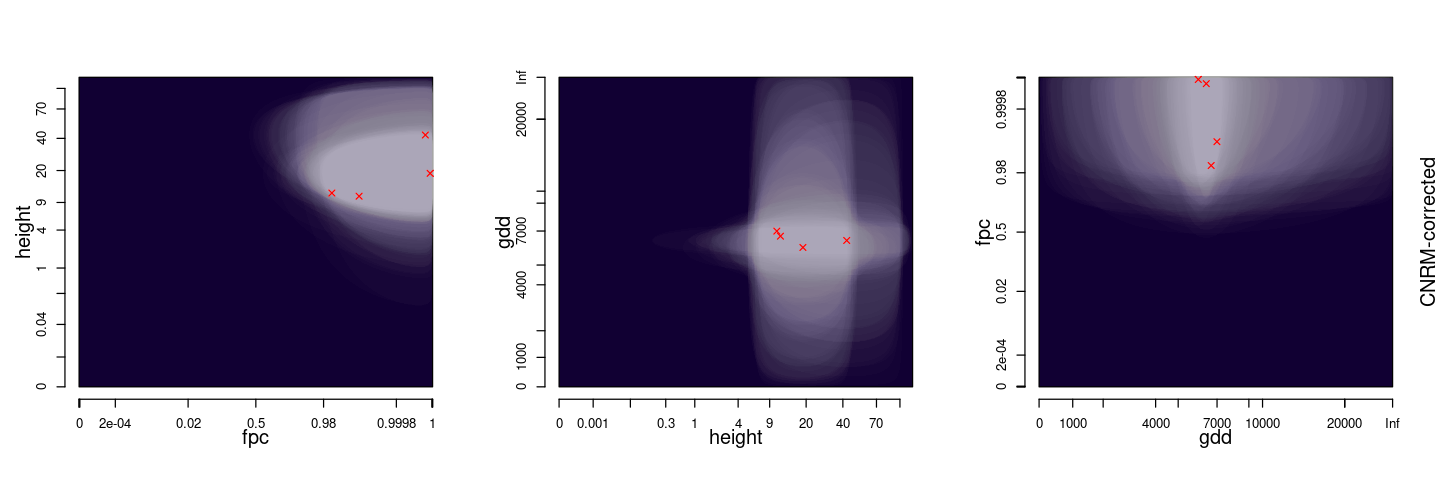

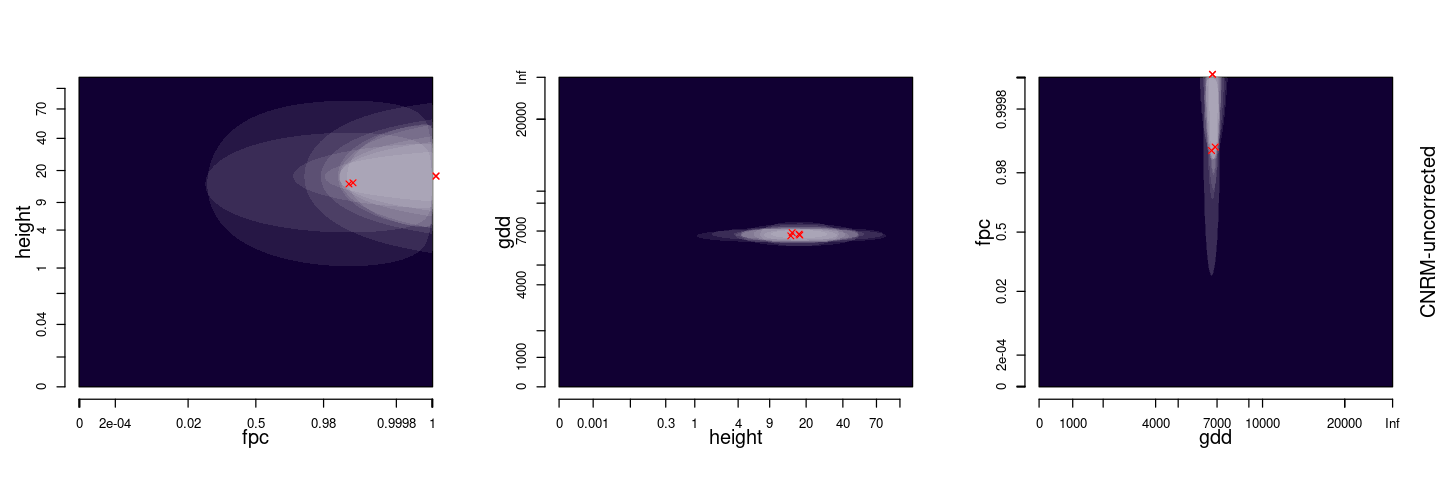

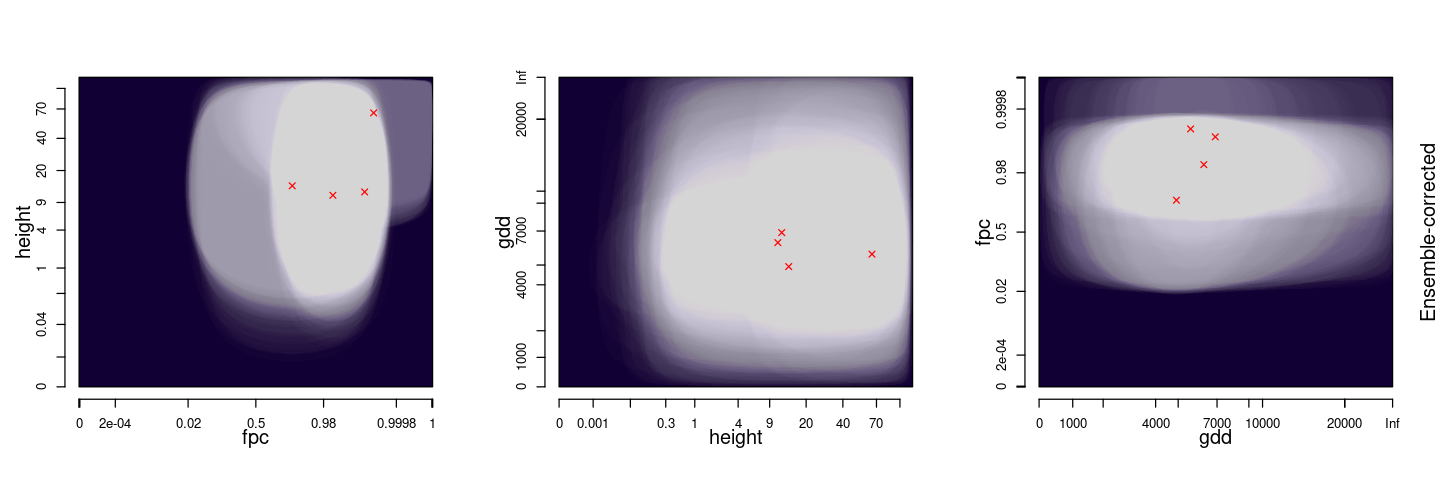

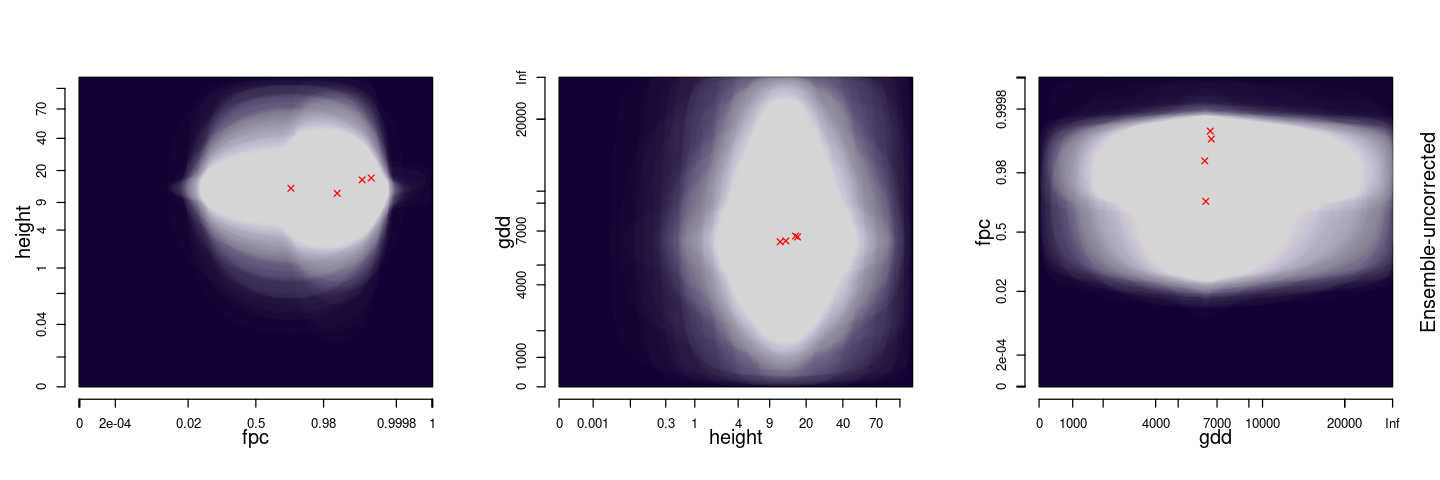

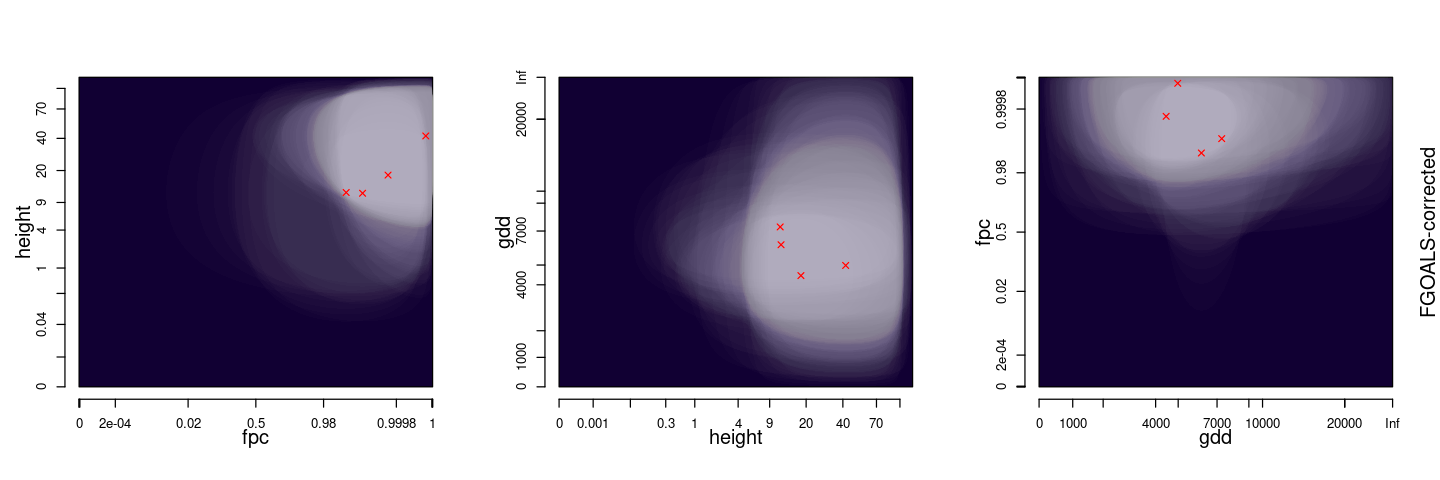

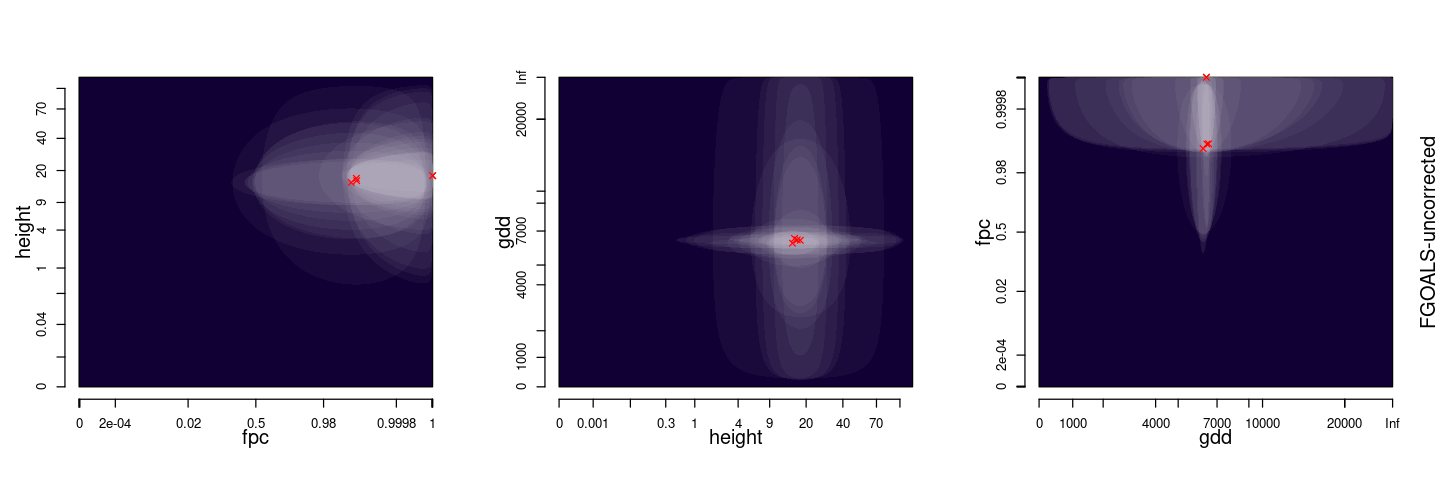

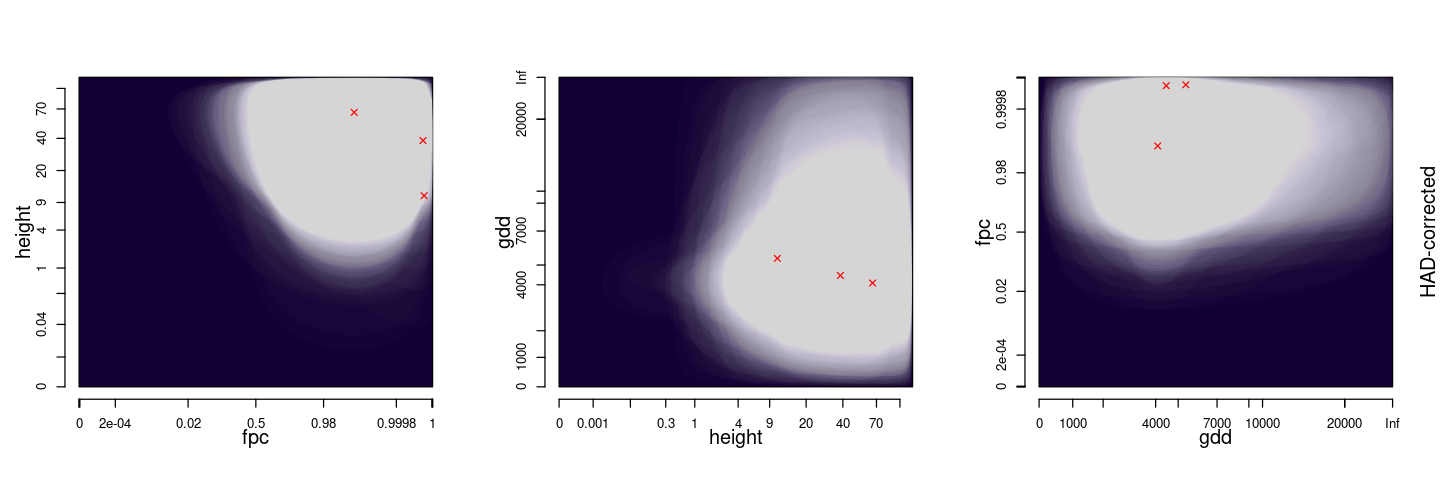

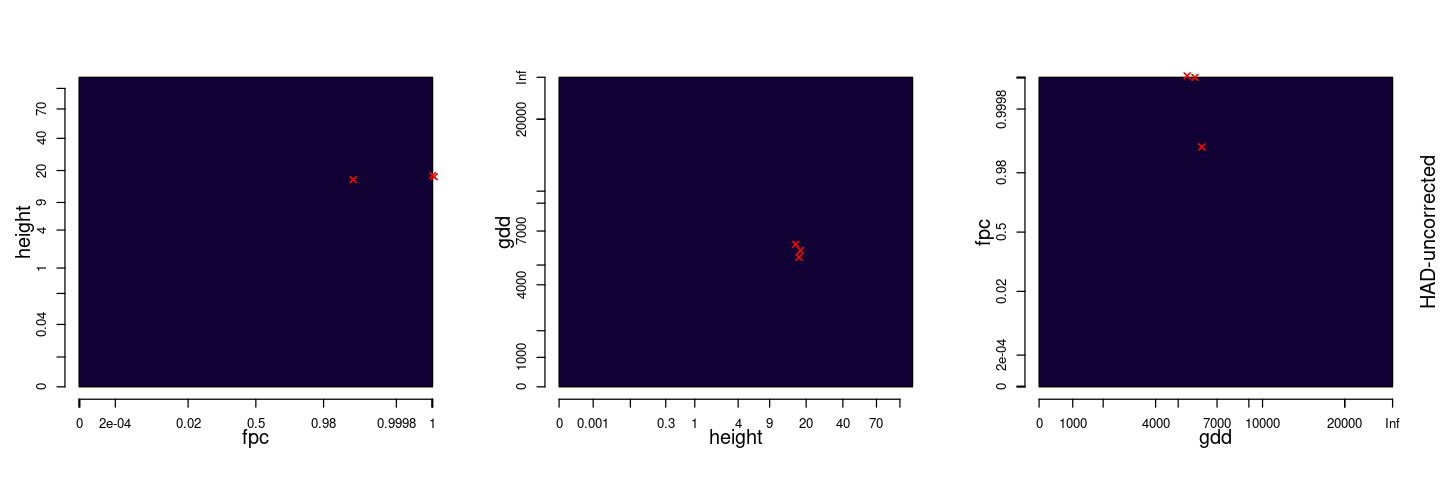

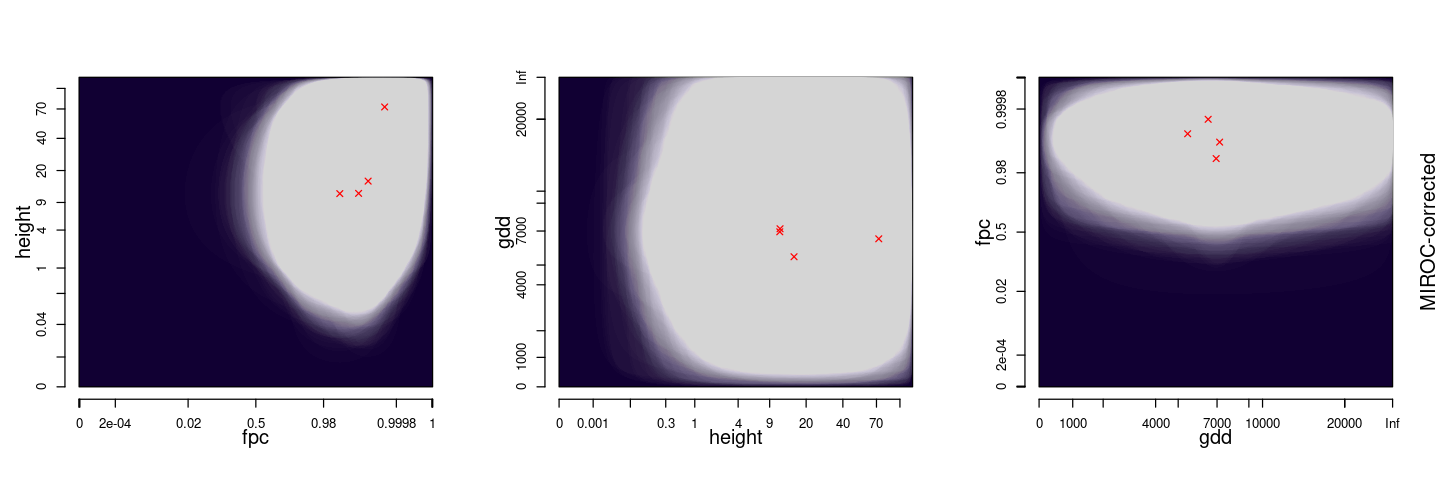

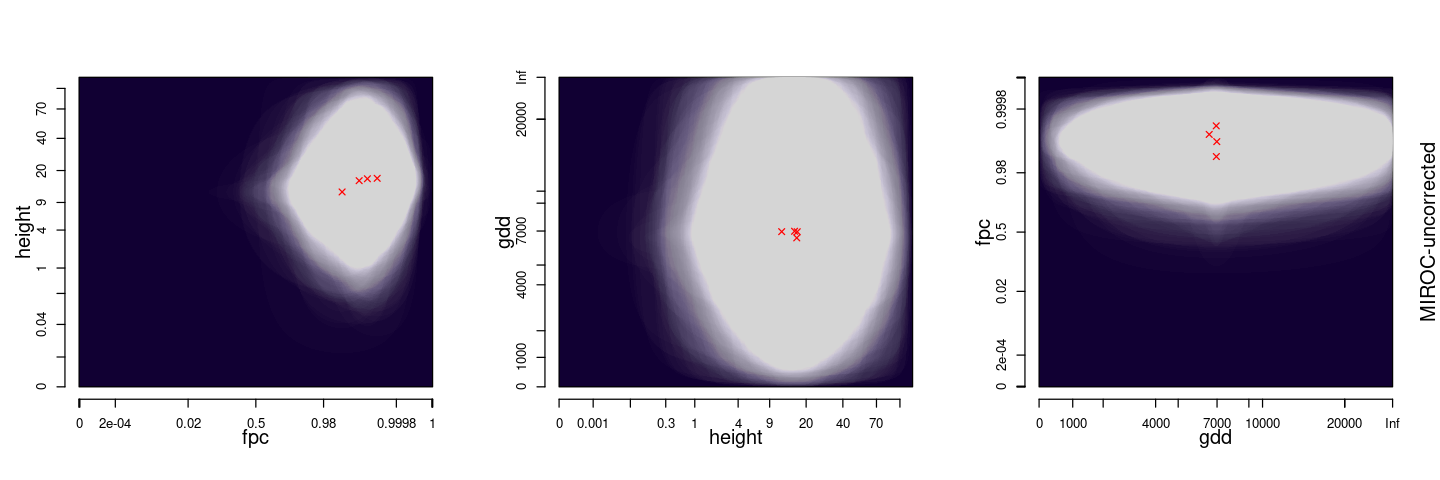

In [44]:
x = seq(-1, 1, 0.001)
y = sqrt(1-x^2)
x = c(x, rev(x)); y = c(y, -rev(y))


plotNichProb <- function(i, j, out) {
    
    centres = out[[2]]
    out = out[[1]]
    xc = ptranss[[i]](centres[[i]]); yc = ptranss[[j]](centres[[j]])
    
    plot(xc, yc, xlim = c(0,1), ylim = c(0,1), type = 'n', axes = FALSE, xlab = '', ylab = '')
    addAxis(i, 1)
    addAxis(j, 2)
    mtext(vars[i], side = 1, line = 2)
    mtext(vars[j], side = 2, line = 2)
    polygon(c(0, 1, 1, 0), c(0, 0, 1, 1), col = '#110033')
    
    addPoly <- function(fail, col, nc) {
        info = fail[[1]]

        shiftScale <- function(x, i){
            #x = logit(x)
            x = (x*diff(info[[i]])/2 + mean(info[[i]]))
            x = ptranss[[i]](itranss[[i]](x))
        }
        xt = shiftScale(x, i); yt = shiftScale(y, j)
        #browser()
        #xt = ptranss[[i]](xt); yt = ptranss[[i]](yt)
        polygon(xt, yt, col = make.transparent(col, min(0.99, 1-1/nc)), border = NA)
    }
    
    addPolys <- function(id, col) {
        con = out[sapply(out, function(i) i[[2]] == id)]                
        lapply(con, addPoly, col, length(con))
    }
    #addPolys(0, 'white')#'#110033')
    #addPolys(2, '#FF0000')
    points(xc, yc, pch = 4, col = 'red')
    addPolys(3, 'white') 
    points(xc, yc, pch = 4, col = 'red')
}
                         
plotNiches <- function(..., model, experiment)   {                     
    options(repr.plot.width=12, repr.plot.height=4)
    par(mfrow = c(1, 3))
    nn = plotNichProb(1, 2, ...)
    nn = plotNichProb(2, 3, ...)
    nn = plotNichProb(3, 1, ...)
    mtext(side = 4, paste0(model, '-', experiment), line = 1, xpd = TRUE)
}

plotModel <- function(outs, model)
    mapply(plotNiches, outs, experiment = experiments, MoreArgs = list(model = model))
    
                         
nn = mapply(plotModel, outss, models)
#outss[[1]][[1]][[1]]                       